In [1]:
import os
import random
import shutil
import itertools
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Network Definition

In [2]:
input_length = 28*28
hidden_0 = 1024
hidden_1 = 1024
hidden_2 = 1024
output_length = 10

In [3]:
class MLP(nn.Module):
    def __init__(self, dropout=0.5):
        super(MLP, self).__init__()
        
        self.fc0   = nn.Linear(input_length, hidden_0)
        self.bn0   = nn.BatchNorm1d(hidden_0)
        self.relu0 = nn.ReLU()
        self.drop0 = nn.Dropout(dropout)
        
        self.fc1   = nn.Linear(hidden_0, hidden_1)
        self.bn1   = nn.BatchNorm1d(hidden_1)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(dropout)
        
        self.fc2   = nn.Linear(hidden_1, hidden_2)
        self.bn2   = nn.BatchNorm1d(hidden_2)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(dropout)
        
        self.out   = nn.Linear(hidden_2, output_length)

    def forward(self, x):
        
        out = x.reshape(x.shape[0], -1)
        out = self.drop0(self.relu0(self.bn0(self.fc0(out))))
        out = self.drop1(self.relu1(self.bn1(self.fc1(out))))
        out = self.drop2(self.relu2(self.bn2(self.fc2(out))))
        out = self.out(out)
        
        return out

# Random Seed Utility

In [4]:
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Define Dataloader

In [5]:
def get_dataloaders(batch_size):
    transform = transforms.ToTensor()
    dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST("data", train=False, download=True, transform=transform)
    val_size = int(0.2 * len(dataset))
    train_size = len(dataset) - val_size
    train_set, val_set = random_split(dataset, [train_size, val_size])
    return (
        DataLoader(train_set, batch_size=batch_size, shuffle=True),
        DataLoader(val_set, batch_size=batch_size),
        DataLoader(test_dataset, batch_size=batch_size),
    )

# Training Pipeline

In [6]:
def train_validate_test(config, save_dir):
    set_random_seed()
    os.makedirs(save_dir, exist_ok=True)
    log_file = os.path.join(save_dir, "training_log.txt")
    resume_path = os.path.join(save_dir, "checkpoint.pth")

    epochs, batch_size, lr1, lr2, lr3, dropout = config
    train_loader, val_loader, test_loader = get_dataloaders(batch_size)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = MLP(dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr1)

    start_epoch = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    if os.path.exists(resume_path):
        ckpt = torch.load(resume_path)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        history = ckpt["history"]
        start_epoch = ckpt["epoch"] + 1
        print(f"🔄 Resuming from epoch {start_epoch}")
    else:
        with open(log_file, "w") as f:
            f.write("Training started\n")

    def evaluate(loader):
        model.eval()
        loss_total, correct, total = 0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                loss_total += loss.item() * x.size(0)
                _, pred = out.max(1)
                correct += (pred == y).sum().item()
                total += x.size(0)
        return loss_total / total, correct / total

    for epoch in range(start_epoch, epochs):
        model.train()
        lr = lr1 if epoch < 0.5 * epochs else lr2 if epoch < 0.8 * epochs else lr3
        for g in optimizer.param_groups:
            g["lr"] = lr

        train_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
            _, pred = out.max(1)
            correct += (pred == y).sum().item()
            total += x.size(0)

        val_loss, val_acc = evaluate(val_loader)
        train_loss /= total
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        log_line = (f"Epoch {epoch+1}/{epochs} - LR: {lr:.5f} | "
                    f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                    f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        print(log_line)
        with open(log_file, "a") as f:
            f.write(log_line + "\n")

        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "history": history
        }, resume_path)

    # Final Test
    test_loss, test_acc = evaluate(test_loader)
    final_line = f"Final Test Loss: {test_loss:.4f} Accuracy: {test_acc:.4f}"
    print(final_line)
    with open(log_file, "a") as f:
        f.write(final_line + "\n")
        f.write("Training completed\n")

    torch.save(model.state_dict(), os.path.join(save_dir, "final_model.pth"))

    # Plot and show
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.legend()
    plt.title("Accuracy")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_plot.png"))
    plt.show()

    return test_acc

# Exploring Best Hyperparameter

In [7]:
def Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates):
    output_root = root_path
    os.makedirs(output_root, exist_ok=True)
    
    epochs = epochs
    batch_sizes = batch_sizes
    lr_pool = lr_pool
    
    # Generate descending LR combinations
    lr_combos = [combo for combo in itertools.product(lr_pool, repeat=3)
                 if (combo[0] > combo[1] > combo[2]) or (combo[0] == combo[1] == combo[2])]
    
    all_runs = [
        f"batch{bs}_lr{lr1}_{lr2}_{lr3}"
        for bs, (lr1, lr2, lr3) in itertools.product(batch_sizes, lr_combos)
    ]
    
    completed_runs = []
    for run in all_runs:
        log_path = os.path.join(output_root, run, "training_log.txt")
        if os.path.exists(log_path):
            with open(log_path, "r") as f:
                if any("Training completed" in line for line in f):
                    completed_runs.append(run)
    
    if len(completed_runs) == len(all_runs):
        print("✅ All combinations completed. Restarting from scratch...")
        for run in all_runs:
            shutil.rmtree(os.path.join(output_root, run), ignore_errors=True)
        if os.path.exists(os.path.join(output_root, "summary.csv")):
            os.remove(os.path.join(output_root, "summary.csv"))
        completed_runs = []
    
    results = []
    for batch_size, (lr1, lr2, lr3), dropout in itertools.product(batch_sizes, lr_combos, dropout_rates):
        run_name = f"batch{batch_size}_lr{lr1}_{lr2}_{lr3}_dp{dropout}"
        save_dir = os.path.join(output_root, run_name)
    
        if run_name in completed_runs:
            print(f"✅ Skipping {run_name}")
            with open(os.path.join(save_dir, "training_log.txt")) as f:
                for line in f:
                    if "Final Test Loss" in line:
                        acc = float(line.strip().split()[-1])
                        results.append((run_name, acc))
            continue
    
        print(f"🚀 Running: {run_name}")
        acc = train_validate_test([epochs, batch_size, lr1, lr2, lr3, dropout], save_dir)
        results.append((run_name, acc))
    
    results.sort(key=lambda x: x[1], reverse=True)
    best_config, best_acc = results[0]
    print(f"🏆 Best Config: {best_config} Accuracy: {best_acc:.4f}")
    
    with open(os.path.join(output_root, "summary.csv"), "w") as f:
        f.write("Config,Accuracy\n")
        for name, acc in results:
            f.write(f"{name},{acc:.4f}\n")

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2749, Acc: 0.9206 | Val Loss: 0.1410, Acc: 0.9591


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1326, Acc: 0.9600 | Val Loss: 0.1095, Acc: 0.9688


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0964, Acc: 0.9709 | Val Loss: 0.1124, Acc: 0.9683


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0798, Acc: 0.9751 | Val Loss: 0.0974, Acc: 0.9715


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0689, Acc: 0.9779 | Val Loss: 0.0967, Acc: 0.9712


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0586, Acc: 0.9811 | Val Loss: 0.0880, Acc: 0.9753


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0510, Acc: 0.9841 | Val Loss: 0.0812, Acc: 0.9758


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9864 | Val Loss: 0.0825, Acc: 0.9773


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9876 | Val Loss: 0.0821, Acc: 0.9787


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9887 | Val Loss: 0.0816, Acc: 0.9778


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9900 | Val Loss: 0.0872, Acc: 0.9778


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9903 | Val Loss: 0.0931, Acc: 0.9768


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9911 | Val Loss: 0.0696, Acc: 0.9803


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9930 | Val Loss: 0.0787, Acc: 0.9797


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9924 | Val Loss: 0.0826, Acc: 0.9777


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9929 | Val Loss: 0.0863, Acc: 0.9792


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9937 | Val Loss: 0.0832, Acc: 0.9803


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 0.0836, Acc: 0.9805


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9948 | Val Loss: 0.0897, Acc: 0.9799


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9943 | Val Loss: 0.0814, Acc: 0.9802


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.0935, Acc: 0.9798


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 0.0797, Acc: 0.9819


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9950 | Val Loss: 0.0823, Acc: 0.9818


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.0862, Acc: 0.9820


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.0874, Acc: 0.9808


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9962 | Val Loss: 0.0965, Acc: 0.9788


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.0748, Acc: 0.9829


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.0814, Acc: 0.9812


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.0847, Acc: 0.9821


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.0866, Acc: 0.9830


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9966 | Val Loss: 0.0957, Acc: 0.9803


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.0946, Acc: 0.9818


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.0922, Acc: 0.9811


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.0977, Acc: 0.9812


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1151, Acc: 0.9800


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.0992, Acc: 0.9786


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0846, Acc: 0.9829


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.0827, Acc: 0.9823


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0926, Acc: 0.9817


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.0839, Acc: 0.9831


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1087, Acc: 0.9814


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.0984, Acc: 0.9831


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9968 | Val Loss: 0.1042, Acc: 0.9804


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.0844, Acc: 0.9840


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.0882, Acc: 0.9824


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9979 | Val Loss: 0.0969, Acc: 0.9804


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0932, Acc: 0.9821


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1027, Acc: 0.9831


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1033, Acc: 0.9812


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9981 | Val Loss: 0.1013, Acc: 0.9826


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9978 | Val Loss: 0.1033, Acc: 0.9828


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.0971, Acc: 0.9827


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.0939, Acc: 0.9832


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.0961, Acc: 0.9831


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9982 | Val Loss: 0.0883, Acc: 0.9835


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1074, Acc: 0.9808


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1028, Acc: 0.9834


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.0975, Acc: 0.9821


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.0986, Acc: 0.9837


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.1031, Acc: 0.9832


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1107, Acc: 0.9818


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1051, Acc: 0.9835


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9982 | Val Loss: 0.0952, Acc: 0.9830


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.0901, Acc: 0.9825


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9978 | Val Loss: 0.0927, Acc: 0.9828


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0899, Acc: 0.9843


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1058, Acc: 0.9828


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1037, Acc: 0.9828


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0883, Acc: 0.9842


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1140, Acc: 0.9823


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0939, Acc: 0.9831


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.0893, Acc: 0.9836


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1109, Acc: 0.9818


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9984 | Val Loss: 0.0997, Acc: 0.9837


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.0976, Acc: 0.9833


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1034, Acc: 0.9822


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1074, Acc: 0.9819


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1071, Acc: 0.9821


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1078, Acc: 0.9826


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1146, Acc: 0.9821


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.0877, Acc: 0.9843


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9993 | Val Loss: 0.0927, Acc: 0.9841


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1094, Acc: 0.9832


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.0956, Acc: 0.9841


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1138, Acc: 0.9828


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1080, Acc: 0.9839


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1310, Acc: 0.9808


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.1005, Acc: 0.9825


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1148, Acc: 0.9829


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1000, Acc: 0.9830


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9989 | Val Loss: 0.1084, Acc: 0.9828


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1156, Acc: 0.9807


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1058, Acc: 0.9848


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0942, Acc: 0.9853


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1107, Acc: 0.9842


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9988 | Val Loss: 0.1012, Acc: 0.9852


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1138, Acc: 0.9841


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9996 | Val Loss: 0.1165, Acc: 0.9828


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1039, Acc: 0.9843


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1114, Acc: 0.9847


Final Test Loss: 0.1170 Accuracy: 0.9836


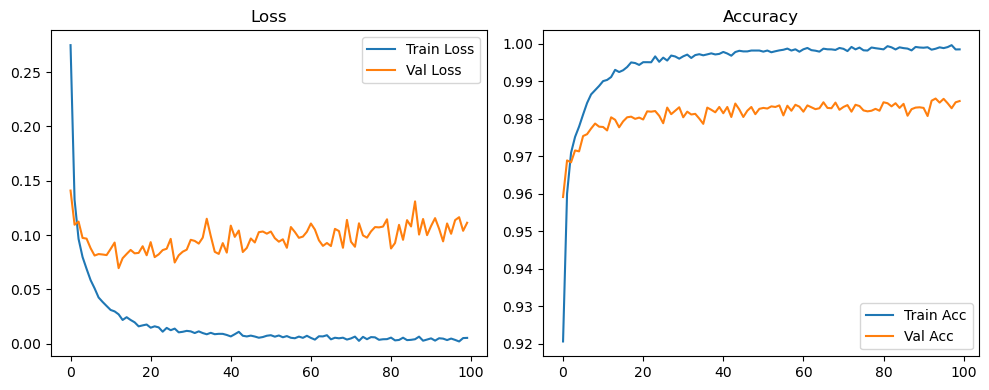

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2923, Acc: 0.9170 | Val Loss: 0.1373, Acc: 0.9626


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1529, Acc: 0.9540 | Val Loss: 0.1203, Acc: 0.9637


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1186, Acc: 0.9661 | Val Loss: 0.0925, Acc: 0.9717


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0987, Acc: 0.9703 | Val Loss: 0.0827, Acc: 0.9759


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0901, Acc: 0.9721 | Val Loss: 0.0938, Acc: 0.9710


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0819, Acc: 0.9747 | Val Loss: 0.0795, Acc: 0.9773


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0696, Acc: 0.9787 | Val Loss: 0.0799, Acc: 0.9759


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0641, Acc: 0.9800 | Val Loss: 0.0814, Acc: 0.9759


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0605, Acc: 0.9808 | Val Loss: 0.0799, Acc: 0.9777


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9824 | Val Loss: 0.0724, Acc: 0.9789


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9842 | Val Loss: 0.0787, Acc: 0.9795


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0464, Acc: 0.9855 | Val Loss: 0.0864, Acc: 0.9766


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9863 | Val Loss: 0.0758, Acc: 0.9784


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9870 | Val Loss: 0.0769, Acc: 0.9792


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9882 | Val Loss: 0.0740, Acc: 0.9804


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9883 | Val Loss: 0.0889, Acc: 0.9768


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9881 | Val Loss: 0.0796, Acc: 0.9798


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9902 | Val Loss: 0.0734, Acc: 0.9807


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0324, Acc: 0.9899 | Val Loss: 0.0768, Acc: 0.9821


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9900 | Val Loss: 0.0777, Acc: 0.9802


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9901 | Val Loss: 0.0741, Acc: 0.9817


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9919 | Val Loss: 0.0782, Acc: 0.9821


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9908 | Val Loss: 0.0724, Acc: 0.9833


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9925 | Val Loss: 0.0816, Acc: 0.9828


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9920 | Val Loss: 0.0783, Acc: 0.9832


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9925 | Val Loss: 0.0839, Acc: 0.9801


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9922 | Val Loss: 0.0714, Acc: 0.9821


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9930 | Val Loss: 0.0776, Acc: 0.9832


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9940 | Val Loss: 0.0770, Acc: 0.9826


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9932 | Val Loss: 0.0778, Acc: 0.9821


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9925 | Val Loss: 0.0897, Acc: 0.9805


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9940 | Val Loss: 0.0836, Acc: 0.9832


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9937 | Val Loss: 0.0862, Acc: 0.9826


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9935 | Val Loss: 0.0797, Acc: 0.9837


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9950 | Val Loss: 0.0875, Acc: 0.9826


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9937 | Val Loss: 0.0859, Acc: 0.9822


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9946 | Val Loss: 0.0946, Acc: 0.9816


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9944 | Val Loss: 0.0790, Acc: 0.9824


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9946 | Val Loss: 0.0913, Acc: 0.9824


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9937 | Val Loss: 0.0830, Acc: 0.9812


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9948 | Val Loss: 0.0995, Acc: 0.9817


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.0948, Acc: 0.9818


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9947 | Val Loss: 0.0811, Acc: 0.9848


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9955 | Val Loss: 0.0904, Acc: 0.9820


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9948 | Val Loss: 0.1000, Acc: 0.9819


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9952 | Val Loss: 0.0970, Acc: 0.9815


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9949 | Val Loss: 0.0931, Acc: 0.9834


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9958 | Val Loss: 0.0964, Acc: 0.9833


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.1083, Acc: 0.9820


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9949 | Val Loss: 0.0797, Acc: 0.9840


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.0888, Acc: 0.9834


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9957 | Val Loss: 0.1027, Acc: 0.9818


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9955 | Val Loss: 0.0965, Acc: 0.9827


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9956 | Val Loss: 0.1021, Acc: 0.9830


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9952 | Val Loss: 0.0855, Acc: 0.9847


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9966 | Val Loss: 0.0954, Acc: 0.9837


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9964 | Val Loss: 0.1003, Acc: 0.9828


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9961 | Val Loss: 0.0927, Acc: 0.9849


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9963 | Val Loss: 0.0920, Acc: 0.9838


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9957 | Val Loss: 0.0937, Acc: 0.9822


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.0958, Acc: 0.9845


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9958 | Val Loss: 0.0811, Acc: 0.9856


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9965 | Val Loss: 0.0943, Acc: 0.9850


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9962 | Val Loss: 0.0885, Acc: 0.9858


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9964 | Val Loss: 0.0972, Acc: 0.9839


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9965 | Val Loss: 0.0969, Acc: 0.9850


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9959 | Val Loss: 0.0914, Acc: 0.9840


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9966 | Val Loss: 0.1022, Acc: 0.9848


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.0984, Acc: 0.9840


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9968 | Val Loss: 0.0978, Acc: 0.9832


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9968 | Val Loss: 0.0966, Acc: 0.9828


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9962 | Val Loss: 0.0994, Acc: 0.9838


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9970 | Val Loss: 0.0904, Acc: 0.9852


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9967 | Val Loss: 0.0910, Acc: 0.9827


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9963 | Val Loss: 0.1020, Acc: 0.9841


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9969 | Val Loss: 0.0922, Acc: 0.9843


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9967 | Val Loss: 0.0955, Acc: 0.9851


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9973 | Val Loss: 0.0998, Acc: 0.9842


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9969 | Val Loss: 0.1008, Acc: 0.9827


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9970 | Val Loss: 0.0988, Acc: 0.9836


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9967 | Val Loss: 0.0943, Acc: 0.9847


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.0970, Acc: 0.9850


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9967 | Val Loss: 0.0902, Acc: 0.9855


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9972 | Val Loss: 0.0972, Acc: 0.9846


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.0922, Acc: 0.9835


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9975 | Val Loss: 0.1030, Acc: 0.9831


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9969 | Val Loss: 0.0995, Acc: 0.9850


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9970 | Val Loss: 0.1014, Acc: 0.9842


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.1150, Acc: 0.9832


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9965 | Val Loss: 0.1073, Acc: 0.9838


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9969 | Val Loss: 0.0846, Acc: 0.9849


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9978 | Val Loss: 0.0916, Acc: 0.9845


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9973 | Val Loss: 0.1005, Acc: 0.9841


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9973 | Val Loss: 0.0983, Acc: 0.9841


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.1076, Acc: 0.9840


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9975 | Val Loss: 0.1130, Acc: 0.9838


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9975 | Val Loss: 0.1114, Acc: 0.9842


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9976 | Val Loss: 0.1150, Acc: 0.9843


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9968 | Val Loss: 0.1090, Acc: 0.9836


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9976 | Val Loss: 0.1077, Acc: 0.9846


Final Test Loss: 0.1026 Accuracy: 0.9851


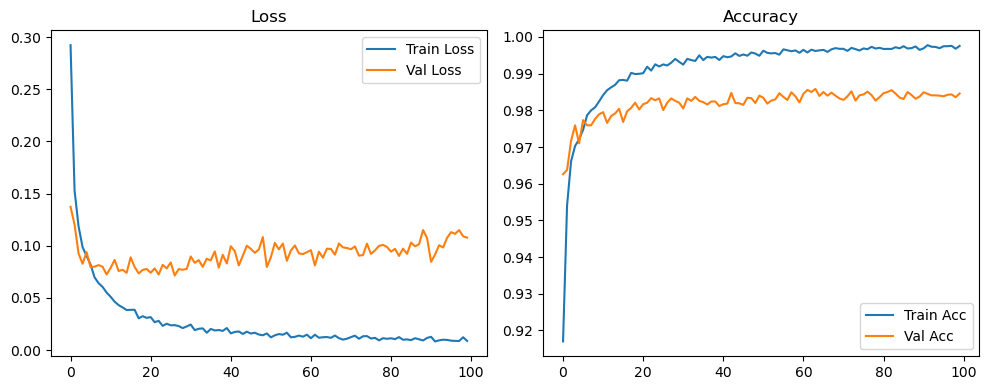

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3869, Acc: 0.8923 | Val Loss: 0.1434, Acc: 0.9570


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2228, Acc: 0.9350 | Val Loss: 0.1310, Acc: 0.9580


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1829, Acc: 0.9464 | Val Loss: 0.0991, Acc: 0.9702


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1607, Acc: 0.9523 | Val Loss: 0.0966, Acc: 0.9712


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1528, Acc: 0.9542 | Val Loss: 0.0872, Acc: 0.9737


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1394, Acc: 0.9589 | Val Loss: 0.0854, Acc: 0.9758


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1238, Acc: 0.9630 | Val Loss: 0.0901, Acc: 0.9738


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1215, Acc: 0.9640 | Val Loss: 0.0813, Acc: 0.9760


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1125, Acc: 0.9670 | Val Loss: 0.0713, Acc: 0.9798


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1101, Acc: 0.9672 | Val Loss: 0.0751, Acc: 0.9785


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1034, Acc: 0.9694 | Val Loss: 0.0711, Acc: 0.9789


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0969, Acc: 0.9715 | Val Loss: 0.0738, Acc: 0.9804


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0930, Acc: 0.9725 | Val Loss: 0.0714, Acc: 0.9805


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9736 | Val Loss: 0.0691, Acc: 0.9801


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0870, Acc: 0.9743 | Val Loss: 0.0734, Acc: 0.9808


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0821, Acc: 0.9755 | Val Loss: 0.0712, Acc: 0.9818


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0819, Acc: 0.9759 | Val Loss: 0.0689, Acc: 0.9808


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0750, Acc: 0.9772 | Val Loss: 0.0646, Acc: 0.9813


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0762, Acc: 0.9771 | Val Loss: 0.0692, Acc: 0.9813


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0713, Acc: 0.9790 | Val Loss: 0.0649, Acc: 0.9816


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0685, Acc: 0.9792 | Val Loss: 0.0660, Acc: 0.9822


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0672, Acc: 0.9796 | Val Loss: 0.0679, Acc: 0.9822


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0635, Acc: 0.9813 | Val Loss: 0.0653, Acc: 0.9834


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0638, Acc: 0.9804 | Val Loss: 0.0648, Acc: 0.9825


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0631, Acc: 0.9814 | Val Loss: 0.0645, Acc: 0.9824


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0608, Acc: 0.9819 | Val Loss: 0.0660, Acc: 0.9826


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0606, Acc: 0.9826 | Val Loss: 0.0647, Acc: 0.9840


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0621, Acc: 0.9812 | Val Loss: 0.0588, Acc: 0.9844


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0577, Acc: 0.9828 | Val Loss: 0.0717, Acc: 0.9818


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0545, Acc: 0.9837 | Val Loss: 0.0672, Acc: 0.9831


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0564, Acc: 0.9831 | Val Loss: 0.0649, Acc: 0.9845


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9841 | Val Loss: 0.0723, Acc: 0.9831


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0548, Acc: 0.9841 | Val Loss: 0.0709, Acc: 0.9840


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0548, Acc: 0.9833 | Val Loss: 0.0707, Acc: 0.9834


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9852 | Val Loss: 0.0686, Acc: 0.9834


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9849 | Val Loss: 0.0667, Acc: 0.9840


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0495, Acc: 0.9853 | Val Loss: 0.0585, Acc: 0.9858


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9858 | Val Loss: 0.0673, Acc: 0.9838


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9865 | Val Loss: 0.0690, Acc: 0.9832


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9858 | Val Loss: 0.0639, Acc: 0.9850


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9870 | Val Loss: 0.0734, Acc: 0.9832


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9869 | Val Loss: 0.0735, Acc: 0.9838


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9864 | Val Loss: 0.0674, Acc: 0.9846


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9869 | Val Loss: 0.0735, Acc: 0.9830


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9869 | Val Loss: 0.0747, Acc: 0.9843


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9867 | Val Loss: 0.0733, Acc: 0.9828


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9887 | Val Loss: 0.0784, Acc: 0.9827


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9878 | Val Loss: 0.0747, Acc: 0.9842


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9881 | Val Loss: 0.0804, Acc: 0.9835


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9875 | Val Loss: 0.0756, Acc: 0.9834


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9882 | Val Loss: 0.0719, Acc: 0.9842


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9883 | Val Loss: 0.0816, Acc: 0.9829


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9886 | Val Loss: 0.0746, Acc: 0.9848


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9879 | Val Loss: 0.0715, Acc: 0.9850


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9890 | Val Loss: 0.0668, Acc: 0.9848


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9892 | Val Loss: 0.0716, Acc: 0.9830


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9896 | Val Loss: 0.0815, Acc: 0.9838


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9892 | Val Loss: 0.0747, Acc: 0.9849


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9881 | Val Loss: 0.0807, Acc: 0.9832


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9892 | Val Loss: 0.0761, Acc: 0.9846


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9899 | Val Loss: 0.0735, Acc: 0.9840


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9894 | Val Loss: 0.0732, Acc: 0.9840


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9902 | Val Loss: 0.0843, Acc: 0.9843


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9901 | Val Loss: 0.0752, Acc: 0.9846


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9892 | Val Loss: 0.0752, Acc: 0.9848


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9896 | Val Loss: 0.0715, Acc: 0.9851


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9898 | Val Loss: 0.0832, Acc: 0.9848


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9898 | Val Loss: 0.0709, Acc: 0.9855


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0324, Acc: 0.9901 | Val Loss: 0.0775, Acc: 0.9843


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9900 | Val Loss: 0.0794, Acc: 0.9839


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9898 | Val Loss: 0.0740, Acc: 0.9856


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9904 | Val Loss: 0.0783, Acc: 0.9855


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9898 | Val Loss: 0.0743, Acc: 0.9844


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0380, Acc: 0.9896 | Val Loss: 0.0738, Acc: 0.9851


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9919 | Val Loss: 0.0809, Acc: 0.9844


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0324, Acc: 0.9905 | Val Loss: 0.0817, Acc: 0.9847


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9908 | Val Loss: 0.0842, Acc: 0.9849


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9918 | Val Loss: 0.0815, Acc: 0.9847


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0276, Acc: 0.9919 | Val Loss: 0.0824, Acc: 0.9851


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9910 | Val Loss: 0.0846, Acc: 0.9837


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9909 | Val Loss: 0.0811, Acc: 0.9842


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9913 | Val Loss: 0.0864, Acc: 0.9842


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9918 | Val Loss: 0.0821, Acc: 0.9840


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9916 | Val Loss: 0.0795, Acc: 0.9852


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9914 | Val Loss: 0.0866, Acc: 0.9844


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9913 | Val Loss: 0.0766, Acc: 0.9848


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9920 | Val Loss: 0.0777, Acc: 0.9840


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9920 | Val Loss: 0.0846, Acc: 0.9848


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9911 | Val Loss: 0.0843, Acc: 0.9846


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9912 | Val Loss: 0.0784, Acc: 0.9852


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9919 | Val Loss: 0.0850, Acc: 0.9848


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9912 | Val Loss: 0.0798, Acc: 0.9851


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9910 | Val Loss: 0.0820, Acc: 0.9838


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9920 | Val Loss: 0.0818, Acc: 0.9858


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9922 | Val Loss: 0.0824, Acc: 0.9842


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0286, Acc: 0.9918 | Val Loss: 0.0816, Acc: 0.9846


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9917 | Val Loss: 0.0830, Acc: 0.9845


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9923 | Val Loss: 0.0835, Acc: 0.9858


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9921 | Val Loss: 0.0895, Acc: 0.9850


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9922 | Val Loss: 0.0833, Acc: 0.9848


Final Test Loss: 0.0778 Accuracy: 0.9863


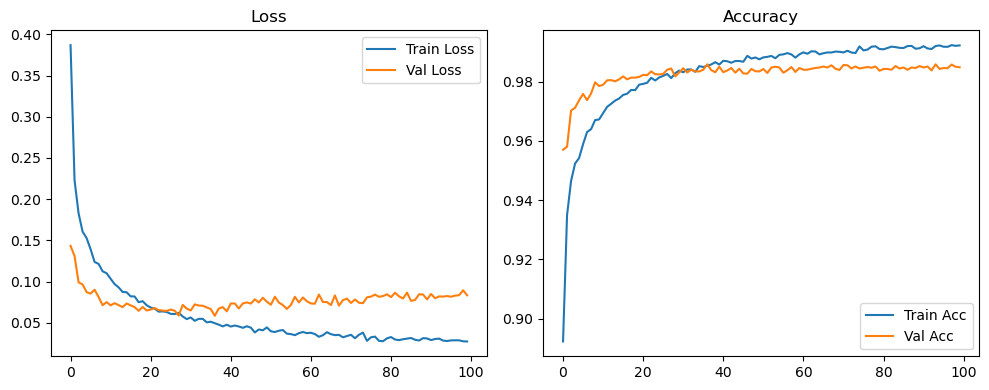

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2749, Acc: 0.9206 | Val Loss: 0.1410, Acc: 0.9591


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1326, Acc: 0.9600 | Val Loss: 0.1095, Acc: 0.9688


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0964, Acc: 0.9709 | Val Loss: 0.1124, Acc: 0.9683


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0798, Acc: 0.9751 | Val Loss: 0.0974, Acc: 0.9715


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0689, Acc: 0.9779 | Val Loss: 0.0967, Acc: 0.9712


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0586, Acc: 0.9811 | Val Loss: 0.0880, Acc: 0.9753


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0510, Acc: 0.9841 | Val Loss: 0.0812, Acc: 0.9758


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9864 | Val Loss: 0.0825, Acc: 0.9773


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9876 | Val Loss: 0.0821, Acc: 0.9787


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9887 | Val Loss: 0.0816, Acc: 0.9778


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9900 | Val Loss: 0.0872, Acc: 0.9778


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9903 | Val Loss: 0.0931, Acc: 0.9768


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9911 | Val Loss: 0.0696, Acc: 0.9803


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9930 | Val Loss: 0.0787, Acc: 0.9797


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9924 | Val Loss: 0.0826, Acc: 0.9777


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9929 | Val Loss: 0.0863, Acc: 0.9792


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9937 | Val Loss: 0.0832, Acc: 0.9803


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 0.0836, Acc: 0.9805


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9948 | Val Loss: 0.0897, Acc: 0.9799


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9943 | Val Loss: 0.0814, Acc: 0.9802


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.0935, Acc: 0.9798


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 0.0797, Acc: 0.9819


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9950 | Val Loss: 0.0823, Acc: 0.9818


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.0862, Acc: 0.9820


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.0874, Acc: 0.9808


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9962 | Val Loss: 0.0965, Acc: 0.9788


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.0748, Acc: 0.9829


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.0814, Acc: 0.9812


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.0847, Acc: 0.9821


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.0866, Acc: 0.9830


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9966 | Val Loss: 0.0957, Acc: 0.9803


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.0946, Acc: 0.9818


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.0922, Acc: 0.9811


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.0977, Acc: 0.9812


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1151, Acc: 0.9800


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.0992, Acc: 0.9786


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0846, Acc: 0.9829


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.0827, Acc: 0.9823


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0926, Acc: 0.9817


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.0839, Acc: 0.9831


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1087, Acc: 0.9814


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.0984, Acc: 0.9831


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9968 | Val Loss: 0.1042, Acc: 0.9804


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.0844, Acc: 0.9840


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.0882, Acc: 0.9824


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9979 | Val Loss: 0.0969, Acc: 0.9804


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0932, Acc: 0.9821


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1027, Acc: 0.9831


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1033, Acc: 0.9812


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9981 | Val Loss: 0.1013, Acc: 0.9826


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0851, Acc: 0.9845


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0874, Acc: 0.9842


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0962, Acc: 0.9833


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1044, Acc: 0.9836


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1000, Acc: 0.9834


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0964, Acc: 0.9849


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0940, Acc: 0.9842


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1010, Acc: 0.9852


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1090, Acc: 0.9822


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1103, Acc: 0.9830


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1164, Acc: 0.9832


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1089, Acc: 0.9837


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1077, Acc: 0.9844


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1080, Acc: 0.9853


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1123, Acc: 0.9846


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1121, Acc: 0.9838


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1067, Acc: 0.9847


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1185, Acc: 0.9840


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1164, Acc: 0.9849


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1243, Acc: 0.9843


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1143, Acc: 0.9855


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1161, Acc: 0.9838


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1261, Acc: 0.9831


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1190, Acc: 0.9840


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9995 | Val Loss: 0.1240, Acc: 0.9833


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1148, Acc: 0.9843


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1193, Acc: 0.9842


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1270, Acc: 0.9841


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1297, Acc: 0.9828


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1269, Acc: 0.9834


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1223, Acc: 0.9838


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1230, Acc: 0.9842


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1254, Acc: 0.9845


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1192, Acc: 0.9845


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1177, Acc: 0.9846


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1208, Acc: 0.9845


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1210, Acc: 0.9847


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1360, Acc: 0.9837


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1326, Acc: 0.9848


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1319, Acc: 0.9838


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1302, Acc: 0.9851


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1244, Acc: 0.9841


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1246, Acc: 0.9850


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1227, Acc: 0.9849


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1317, Acc: 0.9854


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1350, Acc: 0.9848


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1382, Acc: 0.9850


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1370, Acc: 0.9845


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1277, Acc: 0.9855


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1263, Acc: 0.9853


Final Test Loss: 0.1143 Accuracy: 0.9852


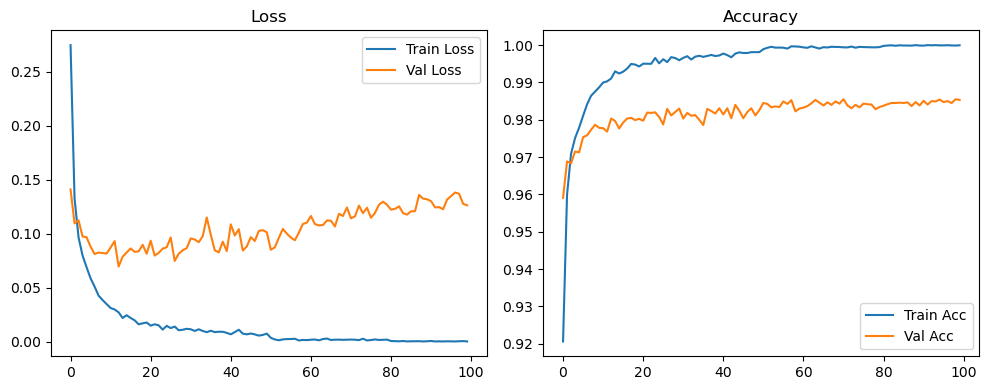

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2923, Acc: 0.9170 | Val Loss: 0.1373, Acc: 0.9626


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1529, Acc: 0.9540 | Val Loss: 0.1203, Acc: 0.9637


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1186, Acc: 0.9661 | Val Loss: 0.0925, Acc: 0.9717


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0987, Acc: 0.9703 | Val Loss: 0.0827, Acc: 0.9759


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0901, Acc: 0.9721 | Val Loss: 0.0938, Acc: 0.9710


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0819, Acc: 0.9747 | Val Loss: 0.0795, Acc: 0.9773


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0696, Acc: 0.9787 | Val Loss: 0.0799, Acc: 0.9759


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0641, Acc: 0.9800 | Val Loss: 0.0814, Acc: 0.9759


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0605, Acc: 0.9808 | Val Loss: 0.0799, Acc: 0.9777


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9824 | Val Loss: 0.0724, Acc: 0.9789


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9842 | Val Loss: 0.0787, Acc: 0.9795


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0464, Acc: 0.9855 | Val Loss: 0.0864, Acc: 0.9766


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9863 | Val Loss: 0.0758, Acc: 0.9784


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9870 | Val Loss: 0.0769, Acc: 0.9792


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9882 | Val Loss: 0.0740, Acc: 0.9804


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9883 | Val Loss: 0.0889, Acc: 0.9768


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9881 | Val Loss: 0.0796, Acc: 0.9798


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9902 | Val Loss: 0.0734, Acc: 0.9807


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0324, Acc: 0.9899 | Val Loss: 0.0768, Acc: 0.9821


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9900 | Val Loss: 0.0777, Acc: 0.9802


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9901 | Val Loss: 0.0741, Acc: 0.9817


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9919 | Val Loss: 0.0782, Acc: 0.9821


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9908 | Val Loss: 0.0724, Acc: 0.9833


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9925 | Val Loss: 0.0816, Acc: 0.9828


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9920 | Val Loss: 0.0783, Acc: 0.9832


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9925 | Val Loss: 0.0839, Acc: 0.9801


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9922 | Val Loss: 0.0714, Acc: 0.9821


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9930 | Val Loss: 0.0776, Acc: 0.9832


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9940 | Val Loss: 0.0770, Acc: 0.9826


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9932 | Val Loss: 0.0778, Acc: 0.9821


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9925 | Val Loss: 0.0897, Acc: 0.9805


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9940 | Val Loss: 0.0836, Acc: 0.9832


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9937 | Val Loss: 0.0862, Acc: 0.9826


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9935 | Val Loss: 0.0797, Acc: 0.9837


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9950 | Val Loss: 0.0875, Acc: 0.9826


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9937 | Val Loss: 0.0859, Acc: 0.9822


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9946 | Val Loss: 0.0946, Acc: 0.9816


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9944 | Val Loss: 0.0790, Acc: 0.9824


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9946 | Val Loss: 0.0913, Acc: 0.9824


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9937 | Val Loss: 0.0830, Acc: 0.9812


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9948 | Val Loss: 0.0995, Acc: 0.9817


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.0948, Acc: 0.9818


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9947 | Val Loss: 0.0811, Acc: 0.9848


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9955 | Val Loss: 0.0904, Acc: 0.9820


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9948 | Val Loss: 0.1000, Acc: 0.9819


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9952 | Val Loss: 0.0970, Acc: 0.9815


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9949 | Val Loss: 0.0931, Acc: 0.9834


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9958 | Val Loss: 0.0964, Acc: 0.9833


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.1083, Acc: 0.9820


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9949 | Val Loss: 0.0797, Acc: 0.9840


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0830, Acc: 0.9851


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0827, Acc: 0.9845


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.0823, Acc: 0.9853


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.0875, Acc: 0.9850


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0857, Acc: 0.9861


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0955, Acc: 0.9848


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0871, Acc: 0.9856


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.0916, Acc: 0.9848


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0990, Acc: 0.9853


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.0970, Acc: 0.9851


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0976, Acc: 0.9852


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.0861, Acc: 0.9852


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0906, Acc: 0.9855


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.0939, Acc: 0.9862


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.0946, Acc: 0.9852


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.0942, Acc: 0.9850


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0965, Acc: 0.9857


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1016, Acc: 0.9860


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.0995, Acc: 0.9848


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.0974, Acc: 0.9854


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9985 | Val Loss: 0.0961, Acc: 0.9843


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0985, Acc: 0.9857


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.0920, Acc: 0.9856


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0963, Acc: 0.9866


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1102, Acc: 0.9852


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0960, Acc: 0.9858


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1108, Acc: 0.9851


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0999, Acc: 0.9852


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1064, Acc: 0.9853


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.1006, Acc: 0.9851


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1001, Acc: 0.9851


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0966, Acc: 0.9855


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0978, Acc: 0.9858


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1011, Acc: 0.9864


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1057, Acc: 0.9851


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1054, Acc: 0.9858


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1055, Acc: 0.9862


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0998, Acc: 0.9864


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1092, Acc: 0.9859


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1037, Acc: 0.9859


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0986, Acc: 0.9866


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1027, Acc: 0.9867


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1076, Acc: 0.9870


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1156, Acc: 0.9855


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1074, Acc: 0.9863


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1017, Acc: 0.9873


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1039, Acc: 0.9868


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1026, Acc: 0.9866


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1049, Acc: 0.9868


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1053, Acc: 0.9867


Final Test Loss: 0.0976 Accuracy: 0.9878


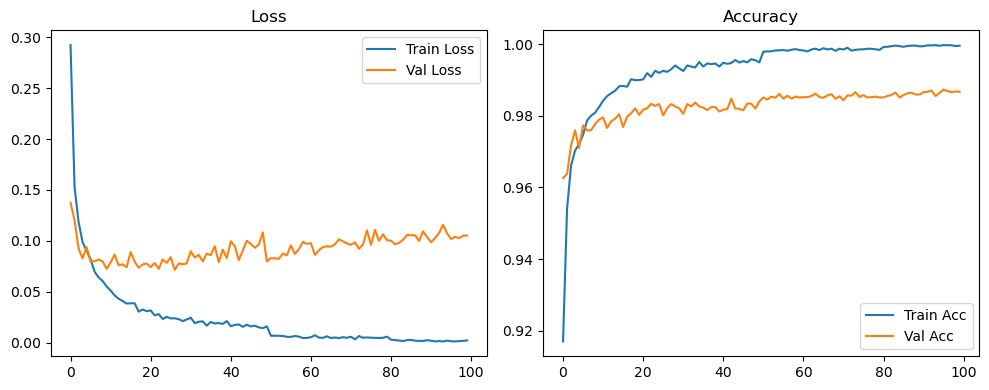

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3869, Acc: 0.8923 | Val Loss: 0.1434, Acc: 0.9570


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2228, Acc: 0.9350 | Val Loss: 0.1310, Acc: 0.9580


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1829, Acc: 0.9464 | Val Loss: 0.0991, Acc: 0.9702


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1607, Acc: 0.9523 | Val Loss: 0.0966, Acc: 0.9712


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1528, Acc: 0.9542 | Val Loss: 0.0872, Acc: 0.9737


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1394, Acc: 0.9589 | Val Loss: 0.0854, Acc: 0.9758


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1238, Acc: 0.9630 | Val Loss: 0.0901, Acc: 0.9738


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1215, Acc: 0.9640 | Val Loss: 0.0813, Acc: 0.9760


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1125, Acc: 0.9670 | Val Loss: 0.0713, Acc: 0.9798


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1101, Acc: 0.9672 | Val Loss: 0.0751, Acc: 0.9785


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1034, Acc: 0.9694 | Val Loss: 0.0711, Acc: 0.9789


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0969, Acc: 0.9715 | Val Loss: 0.0738, Acc: 0.9804


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0930, Acc: 0.9725 | Val Loss: 0.0714, Acc: 0.9805


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9736 | Val Loss: 0.0691, Acc: 0.9801


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0870, Acc: 0.9743 | Val Loss: 0.0734, Acc: 0.9808


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0821, Acc: 0.9755 | Val Loss: 0.0712, Acc: 0.9818


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0819, Acc: 0.9759 | Val Loss: 0.0689, Acc: 0.9808


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0750, Acc: 0.9772 | Val Loss: 0.0646, Acc: 0.9813


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0762, Acc: 0.9771 | Val Loss: 0.0692, Acc: 0.9813


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0713, Acc: 0.9790 | Val Loss: 0.0649, Acc: 0.9816


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0685, Acc: 0.9792 | Val Loss: 0.0660, Acc: 0.9822


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0672, Acc: 0.9796 | Val Loss: 0.0679, Acc: 0.9822


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0635, Acc: 0.9813 | Val Loss: 0.0653, Acc: 0.9834


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0638, Acc: 0.9804 | Val Loss: 0.0648, Acc: 0.9825


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0631, Acc: 0.9814 | Val Loss: 0.0645, Acc: 0.9824


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0608, Acc: 0.9819 | Val Loss: 0.0660, Acc: 0.9826


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0606, Acc: 0.9826 | Val Loss: 0.0647, Acc: 0.9840


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0621, Acc: 0.9812 | Val Loss: 0.0588, Acc: 0.9844


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0577, Acc: 0.9828 | Val Loss: 0.0717, Acc: 0.9818


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0545, Acc: 0.9837 | Val Loss: 0.0672, Acc: 0.9831


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0564, Acc: 0.9831 | Val Loss: 0.0649, Acc: 0.9845


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9841 | Val Loss: 0.0723, Acc: 0.9831


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0548, Acc: 0.9841 | Val Loss: 0.0709, Acc: 0.9840


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0548, Acc: 0.9833 | Val Loss: 0.0707, Acc: 0.9834


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9852 | Val Loss: 0.0686, Acc: 0.9834


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9849 | Val Loss: 0.0667, Acc: 0.9840


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0495, Acc: 0.9853 | Val Loss: 0.0585, Acc: 0.9858


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9858 | Val Loss: 0.0673, Acc: 0.9838


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9865 | Val Loss: 0.0690, Acc: 0.9832


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9858 | Val Loss: 0.0639, Acc: 0.9850


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9870 | Val Loss: 0.0734, Acc: 0.9832


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9869 | Val Loss: 0.0735, Acc: 0.9838


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9864 | Val Loss: 0.0674, Acc: 0.9846


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9869 | Val Loss: 0.0735, Acc: 0.9830


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9869 | Val Loss: 0.0747, Acc: 0.9843


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9867 | Val Loss: 0.0733, Acc: 0.9828


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9887 | Val Loss: 0.0784, Acc: 0.9827


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9878 | Val Loss: 0.0747, Acc: 0.9842


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9881 | Val Loss: 0.0804, Acc: 0.9835


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9875 | Val Loss: 0.0756, Acc: 0.9834


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9903 | Val Loss: 0.0709, Acc: 0.9843


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9922 | Val Loss: 0.0716, Acc: 0.9853


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9927 | Val Loss: 0.0696, Acc: 0.9859


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9929 | Val Loss: 0.0658, Acc: 0.9874


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9936 | Val Loss: 0.0684, Acc: 0.9862


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9934 | Val Loss: 0.0739, Acc: 0.9842


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9936 | Val Loss: 0.0732, Acc: 0.9862


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9935 | Val Loss: 0.0736, Acc: 0.9857


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9937 | Val Loss: 0.0745, Acc: 0.9860


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9939 | Val Loss: 0.0697, Acc: 0.9854


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9940 | Val Loss: 0.0773, Acc: 0.9851


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9944 | Val Loss: 0.0708, Acc: 0.9861


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9948 | Val Loss: 0.0851, Acc: 0.9864


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9945 | Val Loss: 0.0771, Acc: 0.9867


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9937 | Val Loss: 0.0756, Acc: 0.9864


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9942 | Val Loss: 0.0727, Acc: 0.9858


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9941 | Val Loss: 0.0827, Acc: 0.9848


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9941 | Val Loss: 0.0775, Acc: 0.9857


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9948 | Val Loss: 0.0808, Acc: 0.9865


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9944 | Val Loss: 0.0780, Acc: 0.9863


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9950 | Val Loss: 0.0768, Acc: 0.9859


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9948 | Val Loss: 0.0732, Acc: 0.9869


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9950 | Val Loss: 0.0766, Acc: 0.9858


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9944 | Val Loss: 0.0755, Acc: 0.9862


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9948 | Val Loss: 0.0792, Acc: 0.9864


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9949 | Val Loss: 0.0832, Acc: 0.9848


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9948 | Val Loss: 0.0804, Acc: 0.9859


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9953 | Val Loss: 0.0750, Acc: 0.9857


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9953 | Val Loss: 0.0760, Acc: 0.9863


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9955 | Val Loss: 0.0844, Acc: 0.9866


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9956 | Val Loss: 0.0763, Acc: 0.9863


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.0799, Acc: 0.9873


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9967 | Val Loss: 0.0785, Acc: 0.9866


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.0786, Acc: 0.9867


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.0808, Acc: 0.9867


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9972 | Val Loss: 0.0767, Acc: 0.9867


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0780, Acc: 0.9873


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9974 | Val Loss: 0.0781, Acc: 0.9868


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9972 | Val Loss: 0.0813, Acc: 0.9863


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9968 | Val Loss: 0.0728, Acc: 0.9871


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9971 | Val Loss: 0.0715, Acc: 0.9874


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9970 | Val Loss: 0.0721, Acc: 0.9874


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.0734, Acc: 0.9867


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.0769, Acc: 0.9872


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.0730, Acc: 0.9871


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.0785, Acc: 0.9871


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.0754, Acc: 0.9878


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.0793, Acc: 0.9874


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.0775, Acc: 0.9877


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.0762, Acc: 0.9877


Final Test Loss: 0.0787 Accuracy: 0.9868


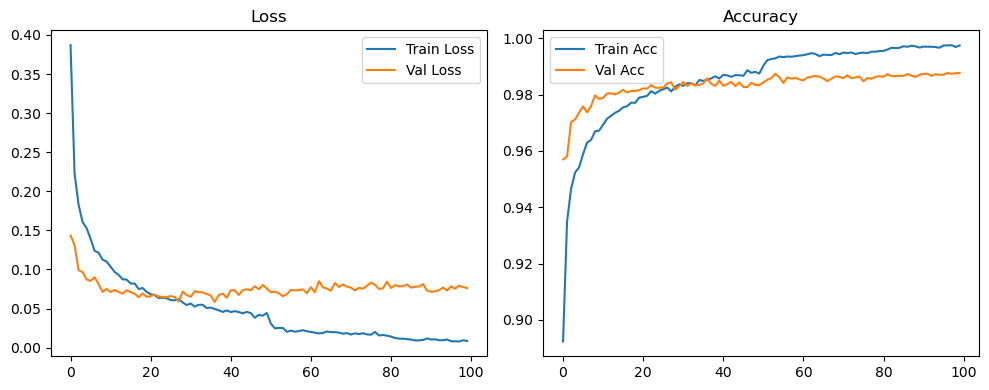

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2749, Acc: 0.9206 | Val Loss: 0.1410, Acc: 0.9591


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1326, Acc: 0.9600 | Val Loss: 0.1095, Acc: 0.9688


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0964, Acc: 0.9709 | Val Loss: 0.1124, Acc: 0.9683


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0798, Acc: 0.9751 | Val Loss: 0.0974, Acc: 0.9715


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0689, Acc: 0.9779 | Val Loss: 0.0967, Acc: 0.9712


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0586, Acc: 0.9811 | Val Loss: 0.0880, Acc: 0.9753


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0510, Acc: 0.9841 | Val Loss: 0.0812, Acc: 0.9758


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9864 | Val Loss: 0.0825, Acc: 0.9773


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9876 | Val Loss: 0.0821, Acc: 0.9787


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9887 | Val Loss: 0.0816, Acc: 0.9778


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9900 | Val Loss: 0.0872, Acc: 0.9778


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9903 | Val Loss: 0.0931, Acc: 0.9768


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9911 | Val Loss: 0.0696, Acc: 0.9803


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9930 | Val Loss: 0.0787, Acc: 0.9797


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9924 | Val Loss: 0.0826, Acc: 0.9777


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9929 | Val Loss: 0.0863, Acc: 0.9792


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9937 | Val Loss: 0.0832, Acc: 0.9803


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 0.0836, Acc: 0.9805


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9948 | Val Loss: 0.0897, Acc: 0.9799


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9943 | Val Loss: 0.0814, Acc: 0.9802


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.0935, Acc: 0.9798


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 0.0797, Acc: 0.9819


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9950 | Val Loss: 0.0823, Acc: 0.9818


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.0862, Acc: 0.9820


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.0874, Acc: 0.9808


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9962 | Val Loss: 0.0965, Acc: 0.9788


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.0748, Acc: 0.9829


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.0814, Acc: 0.9812


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.0847, Acc: 0.9821


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.0866, Acc: 0.9830


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9966 | Val Loss: 0.0957, Acc: 0.9803


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.0946, Acc: 0.9818


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.0922, Acc: 0.9811


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.0977, Acc: 0.9812


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1151, Acc: 0.9800


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.0992, Acc: 0.9786


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0846, Acc: 0.9829


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.0827, Acc: 0.9823


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0926, Acc: 0.9817


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.0839, Acc: 0.9831


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1087, Acc: 0.9814


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.0984, Acc: 0.9831


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9968 | Val Loss: 0.1042, Acc: 0.9804


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.0844, Acc: 0.9840


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.0882, Acc: 0.9824


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9979 | Val Loss: 0.0969, Acc: 0.9804


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0932, Acc: 0.9821


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1027, Acc: 0.9831


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1033, Acc: 0.9812


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9981 | Val Loss: 0.1013, Acc: 0.9826


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0851, Acc: 0.9845


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0874, Acc: 0.9842


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0962, Acc: 0.9833


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1044, Acc: 0.9836


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1000, Acc: 0.9834


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0964, Acc: 0.9849


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0940, Acc: 0.9842


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1010, Acc: 0.9852


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1090, Acc: 0.9822


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1103, Acc: 0.9830


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1164, Acc: 0.9832


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1089, Acc: 0.9837


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1077, Acc: 0.9844


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1080, Acc: 0.9853


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1123, Acc: 0.9846


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1121, Acc: 0.9838


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1067, Acc: 0.9847


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1185, Acc: 0.9840


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1164, Acc: 0.9849


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1243, Acc: 0.9843


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1143, Acc: 0.9855


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1161, Acc: 0.9838


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1261, Acc: 0.9831


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1190, Acc: 0.9840


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9995 | Val Loss: 0.1240, Acc: 0.9833


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1148, Acc: 0.9843


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1193, Acc: 0.9842


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1270, Acc: 0.9841


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1297, Acc: 0.9828


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1269, Acc: 0.9834


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1226, Acc: 0.9838


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1229, Acc: 0.9843


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1246, Acc: 0.9846


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1200, Acc: 0.9846


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1206, Acc: 0.9836


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1195, Acc: 0.9845


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1216, Acc: 0.9845


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1212, Acc: 0.9849


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1240, Acc: 0.9842


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1245, Acc: 0.9838


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1191, Acc: 0.9844


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1192, Acc: 0.9847


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1203, Acc: 0.9848


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1196, Acc: 0.9850


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1218, Acc: 0.9851


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1177, Acc: 0.9851


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1191, Acc: 0.9846


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1213, Acc: 0.9851


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1212, Acc: 0.9850


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1208, Acc: 0.9856


Final Test Loss: 0.1067 Accuracy: 0.9856


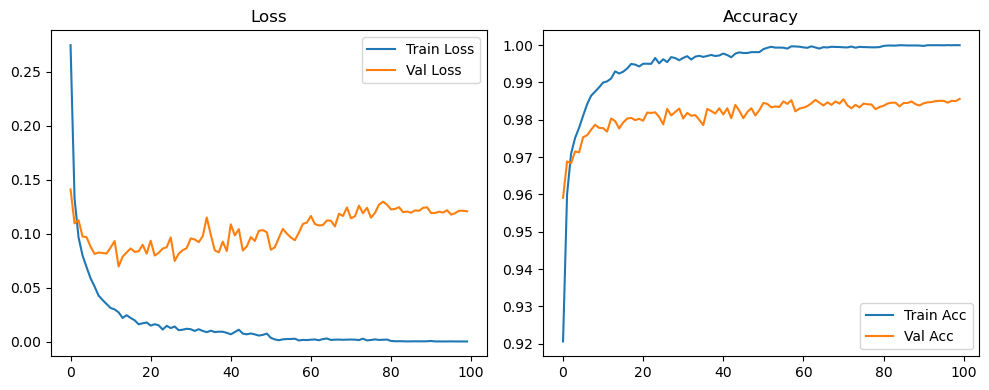

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2923, Acc: 0.9170 | Val Loss: 0.1373, Acc: 0.9626


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1529, Acc: 0.9540 | Val Loss: 0.1203, Acc: 0.9637


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1186, Acc: 0.9661 | Val Loss: 0.0925, Acc: 0.9717


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0987, Acc: 0.9703 | Val Loss: 0.0827, Acc: 0.9759


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0901, Acc: 0.9721 | Val Loss: 0.0938, Acc: 0.9710


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0819, Acc: 0.9747 | Val Loss: 0.0795, Acc: 0.9773


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0696, Acc: 0.9787 | Val Loss: 0.0799, Acc: 0.9759


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0641, Acc: 0.9800 | Val Loss: 0.0814, Acc: 0.9759


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0605, Acc: 0.9808 | Val Loss: 0.0799, Acc: 0.9777


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9824 | Val Loss: 0.0724, Acc: 0.9789


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9842 | Val Loss: 0.0787, Acc: 0.9795


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0464, Acc: 0.9855 | Val Loss: 0.0864, Acc: 0.9766


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9863 | Val Loss: 0.0758, Acc: 0.9784


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9870 | Val Loss: 0.0769, Acc: 0.9792


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9882 | Val Loss: 0.0740, Acc: 0.9804


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9883 | Val Loss: 0.0889, Acc: 0.9768


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9881 | Val Loss: 0.0796, Acc: 0.9798


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9902 | Val Loss: 0.0734, Acc: 0.9807


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0324, Acc: 0.9899 | Val Loss: 0.0768, Acc: 0.9821


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9900 | Val Loss: 0.0777, Acc: 0.9802


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9901 | Val Loss: 0.0741, Acc: 0.9817


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9919 | Val Loss: 0.0782, Acc: 0.9821


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9908 | Val Loss: 0.0724, Acc: 0.9833


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9925 | Val Loss: 0.0816, Acc: 0.9828


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9920 | Val Loss: 0.0783, Acc: 0.9832


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9925 | Val Loss: 0.0839, Acc: 0.9801


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9922 | Val Loss: 0.0714, Acc: 0.9821


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9930 | Val Loss: 0.0776, Acc: 0.9832


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9940 | Val Loss: 0.0770, Acc: 0.9826


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9932 | Val Loss: 0.0778, Acc: 0.9821


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9925 | Val Loss: 0.0897, Acc: 0.9805


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9940 | Val Loss: 0.0836, Acc: 0.9832


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9937 | Val Loss: 0.0862, Acc: 0.9826


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9935 | Val Loss: 0.0797, Acc: 0.9837


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9950 | Val Loss: 0.0875, Acc: 0.9826


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9937 | Val Loss: 0.0859, Acc: 0.9822


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9946 | Val Loss: 0.0946, Acc: 0.9816


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9944 | Val Loss: 0.0790, Acc: 0.9824


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9946 | Val Loss: 0.0913, Acc: 0.9824


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9937 | Val Loss: 0.0830, Acc: 0.9812


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9948 | Val Loss: 0.0995, Acc: 0.9817


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.0948, Acc: 0.9818


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9947 | Val Loss: 0.0811, Acc: 0.9848


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9955 | Val Loss: 0.0904, Acc: 0.9820


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9948 | Val Loss: 0.1000, Acc: 0.9819


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9952 | Val Loss: 0.0970, Acc: 0.9815


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9949 | Val Loss: 0.0931, Acc: 0.9834


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9958 | Val Loss: 0.0964, Acc: 0.9833


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.1083, Acc: 0.9820


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9949 | Val Loss: 0.0797, Acc: 0.9840


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0830, Acc: 0.9851


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0827, Acc: 0.9845


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.0823, Acc: 0.9853


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.0875, Acc: 0.9850


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0857, Acc: 0.9861


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0955, Acc: 0.9848


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0871, Acc: 0.9856


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.0916, Acc: 0.9848


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0990, Acc: 0.9853


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.0970, Acc: 0.9851


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0976, Acc: 0.9852


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.0861, Acc: 0.9852


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0906, Acc: 0.9855


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.0939, Acc: 0.9862


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.0946, Acc: 0.9852


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.0942, Acc: 0.9850


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0965, Acc: 0.9857


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1016, Acc: 0.9860


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.0995, Acc: 0.9848


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.0974, Acc: 0.9854


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9985 | Val Loss: 0.0961, Acc: 0.9843


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0985, Acc: 0.9857


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.0920, Acc: 0.9856


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0963, Acc: 0.9866


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1102, Acc: 0.9852


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0960, Acc: 0.9858


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1108, Acc: 0.9851


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0999, Acc: 0.9852


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1064, Acc: 0.9853


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.1006, Acc: 0.9851


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0982, Acc: 0.9855


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0978, Acc: 0.9855


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0982, Acc: 0.9857


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0992, Acc: 0.9862


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1017, Acc: 0.9860


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1033, Acc: 0.9864


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1024, Acc: 0.9868


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0987, Acc: 0.9867


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1089, Acc: 0.9861


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1031, Acc: 0.9866


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0999, Acc: 0.9868


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1020, Acc: 0.9864


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1027, Acc: 0.9868


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1040, Acc: 0.9869


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1022, Acc: 0.9868


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1008, Acc: 0.9866


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1028, Acc: 0.9862


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1044, Acc: 0.9867


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1034, Acc: 0.9867


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1010, Acc: 0.9871


Final Test Loss: 0.0966 Accuracy: 0.9868


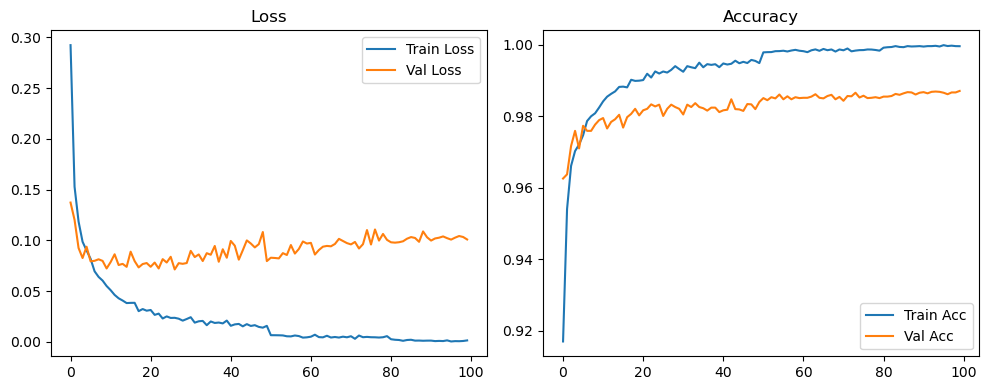

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3869, Acc: 0.8923 | Val Loss: 0.1434, Acc: 0.9570


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2228, Acc: 0.9350 | Val Loss: 0.1310, Acc: 0.9580


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1829, Acc: 0.9464 | Val Loss: 0.0991, Acc: 0.9702


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1607, Acc: 0.9523 | Val Loss: 0.0966, Acc: 0.9712


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1528, Acc: 0.9542 | Val Loss: 0.0872, Acc: 0.9737


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1394, Acc: 0.9589 | Val Loss: 0.0854, Acc: 0.9758


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1238, Acc: 0.9630 | Val Loss: 0.0901, Acc: 0.9738


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1215, Acc: 0.9640 | Val Loss: 0.0813, Acc: 0.9760


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1125, Acc: 0.9670 | Val Loss: 0.0713, Acc: 0.9798


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1101, Acc: 0.9672 | Val Loss: 0.0751, Acc: 0.9785


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1034, Acc: 0.9694 | Val Loss: 0.0711, Acc: 0.9789


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0969, Acc: 0.9715 | Val Loss: 0.0738, Acc: 0.9804


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0930, Acc: 0.9725 | Val Loss: 0.0714, Acc: 0.9805


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9736 | Val Loss: 0.0691, Acc: 0.9801


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0870, Acc: 0.9743 | Val Loss: 0.0734, Acc: 0.9808


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0821, Acc: 0.9755 | Val Loss: 0.0712, Acc: 0.9818


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0819, Acc: 0.9759 | Val Loss: 0.0689, Acc: 0.9808


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0750, Acc: 0.9772 | Val Loss: 0.0646, Acc: 0.9813


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0762, Acc: 0.9771 | Val Loss: 0.0692, Acc: 0.9813


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0713, Acc: 0.9790 | Val Loss: 0.0649, Acc: 0.9816


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0685, Acc: 0.9792 | Val Loss: 0.0660, Acc: 0.9822


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0672, Acc: 0.9796 | Val Loss: 0.0679, Acc: 0.9822


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0635, Acc: 0.9813 | Val Loss: 0.0653, Acc: 0.9834


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0638, Acc: 0.9804 | Val Loss: 0.0648, Acc: 0.9825


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0631, Acc: 0.9814 | Val Loss: 0.0645, Acc: 0.9824


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0608, Acc: 0.9819 | Val Loss: 0.0660, Acc: 0.9826


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0606, Acc: 0.9826 | Val Loss: 0.0647, Acc: 0.9840


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0621, Acc: 0.9812 | Val Loss: 0.0588, Acc: 0.9844


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0577, Acc: 0.9828 | Val Loss: 0.0717, Acc: 0.9818


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0545, Acc: 0.9837 | Val Loss: 0.0672, Acc: 0.9831


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0564, Acc: 0.9831 | Val Loss: 0.0649, Acc: 0.9845


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9841 | Val Loss: 0.0723, Acc: 0.9831


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0548, Acc: 0.9841 | Val Loss: 0.0709, Acc: 0.9840


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0548, Acc: 0.9833 | Val Loss: 0.0707, Acc: 0.9834


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9852 | Val Loss: 0.0686, Acc: 0.9834


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9849 | Val Loss: 0.0667, Acc: 0.9840


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0495, Acc: 0.9853 | Val Loss: 0.0585, Acc: 0.9858


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9858 | Val Loss: 0.0673, Acc: 0.9838


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9865 | Val Loss: 0.0690, Acc: 0.9832


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9858 | Val Loss: 0.0639, Acc: 0.9850


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9870 | Val Loss: 0.0734, Acc: 0.9832


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9869 | Val Loss: 0.0735, Acc: 0.9838


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9864 | Val Loss: 0.0674, Acc: 0.9846


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9869 | Val Loss: 0.0735, Acc: 0.9830


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9869 | Val Loss: 0.0747, Acc: 0.9843


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9867 | Val Loss: 0.0733, Acc: 0.9828


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9887 | Val Loss: 0.0784, Acc: 0.9827


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9878 | Val Loss: 0.0747, Acc: 0.9842


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9881 | Val Loss: 0.0804, Acc: 0.9835


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9875 | Val Loss: 0.0756, Acc: 0.9834


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9903 | Val Loss: 0.0709, Acc: 0.9843


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9922 | Val Loss: 0.0716, Acc: 0.9853


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9927 | Val Loss: 0.0696, Acc: 0.9859


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9929 | Val Loss: 0.0658, Acc: 0.9874


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9936 | Val Loss: 0.0684, Acc: 0.9862


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9934 | Val Loss: 0.0739, Acc: 0.9842


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9936 | Val Loss: 0.0732, Acc: 0.9862


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9935 | Val Loss: 0.0736, Acc: 0.9857


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9937 | Val Loss: 0.0745, Acc: 0.9860


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9939 | Val Loss: 0.0697, Acc: 0.9854


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9940 | Val Loss: 0.0773, Acc: 0.9851


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9944 | Val Loss: 0.0708, Acc: 0.9861


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9948 | Val Loss: 0.0851, Acc: 0.9864


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9945 | Val Loss: 0.0771, Acc: 0.9867


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9937 | Val Loss: 0.0756, Acc: 0.9864


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9942 | Val Loss: 0.0727, Acc: 0.9858


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9941 | Val Loss: 0.0827, Acc: 0.9848


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9941 | Val Loss: 0.0775, Acc: 0.9857


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9948 | Val Loss: 0.0808, Acc: 0.9865


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9944 | Val Loss: 0.0780, Acc: 0.9863


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9950 | Val Loss: 0.0768, Acc: 0.9859


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9948 | Val Loss: 0.0732, Acc: 0.9869


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9950 | Val Loss: 0.0766, Acc: 0.9858


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9944 | Val Loss: 0.0755, Acc: 0.9862


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9948 | Val Loss: 0.0792, Acc: 0.9864


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9949 | Val Loss: 0.0832, Acc: 0.9848


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9948 | Val Loss: 0.0804, Acc: 0.9859


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9953 | Val Loss: 0.0750, Acc: 0.9857


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9953 | Val Loss: 0.0760, Acc: 0.9863


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9955 | Val Loss: 0.0844, Acc: 0.9866


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9956 | Val Loss: 0.0775, Acc: 0.9867


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9961 | Val Loss: 0.0785, Acc: 0.9873


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.0777, Acc: 0.9866


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9967 | Val Loss: 0.0778, Acc: 0.9870


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.0782, Acc: 0.9870


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9971 | Val Loss: 0.0751, Acc: 0.9871


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0759, Acc: 0.9876


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9976 | Val Loss: 0.0766, Acc: 0.9868


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9972 | Val Loss: 0.0784, Acc: 0.9872


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9971 | Val Loss: 0.0733, Acc: 0.9876


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9972 | Val Loss: 0.0717, Acc: 0.9872


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9971 | Val Loss: 0.0716, Acc: 0.9872


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9974 | Val Loss: 0.0728, Acc: 0.9878


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.0753, Acc: 0.9874


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9972 | Val Loss: 0.0740, Acc: 0.9876


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.0760, Acc: 0.9873


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0753, Acc: 0.9872


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.0774, Acc: 0.9877


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0761, Acc: 0.9877


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.0759, Acc: 0.9876


Final Test Loss: 0.0745 Accuracy: 0.9873


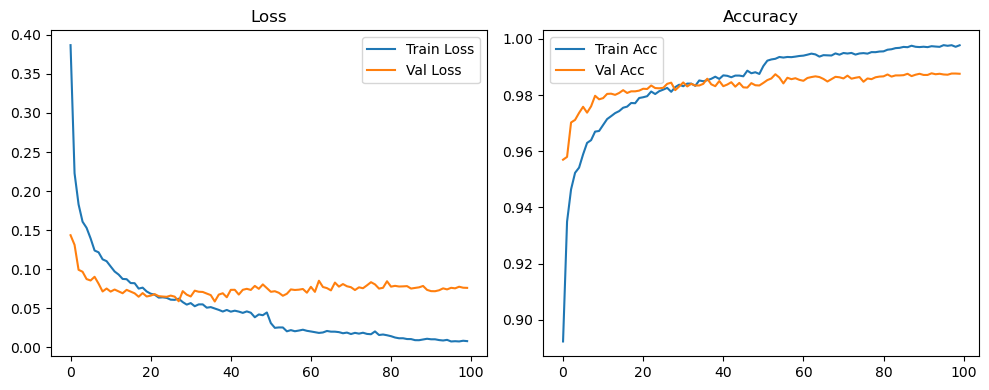

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2749, Acc: 0.9206 | Val Loss: 0.1410, Acc: 0.9591


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1326, Acc: 0.9600 | Val Loss: 0.1095, Acc: 0.9688


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0964, Acc: 0.9709 | Val Loss: 0.1124, Acc: 0.9683


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0798, Acc: 0.9751 | Val Loss: 0.0974, Acc: 0.9715


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0689, Acc: 0.9779 | Val Loss: 0.0967, Acc: 0.9712


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0586, Acc: 0.9811 | Val Loss: 0.0880, Acc: 0.9753


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0510, Acc: 0.9841 | Val Loss: 0.0812, Acc: 0.9758


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9864 | Val Loss: 0.0825, Acc: 0.9773


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9876 | Val Loss: 0.0821, Acc: 0.9787


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9887 | Val Loss: 0.0816, Acc: 0.9778


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9900 | Val Loss: 0.0872, Acc: 0.9778


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9903 | Val Loss: 0.0931, Acc: 0.9768


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9911 | Val Loss: 0.0696, Acc: 0.9803


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9930 | Val Loss: 0.0787, Acc: 0.9797


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9924 | Val Loss: 0.0826, Acc: 0.9777


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9929 | Val Loss: 0.0863, Acc: 0.9792


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9937 | Val Loss: 0.0832, Acc: 0.9803


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 0.0836, Acc: 0.9805


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9948 | Val Loss: 0.0897, Acc: 0.9799


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9943 | Val Loss: 0.0814, Acc: 0.9802


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.0935, Acc: 0.9798


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 0.0797, Acc: 0.9819


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9950 | Val Loss: 0.0823, Acc: 0.9818


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.0862, Acc: 0.9820


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.0874, Acc: 0.9808


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9962 | Val Loss: 0.0965, Acc: 0.9788


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.0748, Acc: 0.9829


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.0814, Acc: 0.9812


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.0847, Acc: 0.9821


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.0866, Acc: 0.9830


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9966 | Val Loss: 0.0957, Acc: 0.9803


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.0946, Acc: 0.9818


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.0922, Acc: 0.9811


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.0977, Acc: 0.9812


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1151, Acc: 0.9800


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.0992, Acc: 0.9786


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0846, Acc: 0.9829


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.0827, Acc: 0.9823


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0926, Acc: 0.9817


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.0839, Acc: 0.9831


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1087, Acc: 0.9814


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.0984, Acc: 0.9831


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9968 | Val Loss: 0.1042, Acc: 0.9804


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.0844, Acc: 0.9840


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.0882, Acc: 0.9824


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9979 | Val Loss: 0.0969, Acc: 0.9804


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0932, Acc: 0.9821


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1027, Acc: 0.9831


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1033, Acc: 0.9812


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9981 | Val Loss: 0.1013, Acc: 0.9826


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0876, Acc: 0.9842


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0836, Acc: 0.9843


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0852, Acc: 0.9845


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0862, Acc: 0.9848


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0854, Acc: 0.9845


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0857, Acc: 0.9853


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0914, Acc: 0.9858


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0879, Acc: 0.9863


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0932, Acc: 0.9847


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0946, Acc: 0.9849


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0925, Acc: 0.9858


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0954, Acc: 0.9857


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0988, Acc: 0.9854


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1022, Acc: 0.9844


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1060, Acc: 0.9858


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1094, Acc: 0.9855


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1072, Acc: 0.9852


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1073, Acc: 0.9852


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1093, Acc: 0.9856


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1113, Acc: 0.9848


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1167, Acc: 0.9846


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1138, Acc: 0.9846


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1121, Acc: 0.9847


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1127, Acc: 0.9842


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1036, Acc: 0.9861


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1049, Acc: 0.9852


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1096, Acc: 0.9857


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1086, Acc: 0.9853


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1133, Acc: 0.9858


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1099, Acc: 0.9862


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.1064, Acc: 0.9863


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1085, Acc: 0.9862


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1084, Acc: 0.9862


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1050, Acc: 0.9854


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1020, Acc: 0.9860


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1029, Acc: 0.9853


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1066, Acc: 0.9863


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1072, Acc: 0.9858


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1119, Acc: 0.9865


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1064, Acc: 0.9864


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1045, Acc: 0.9859


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1094, Acc: 0.9850


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1094, Acc: 0.9854


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1064, Acc: 0.9859


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1110, Acc: 0.9855


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1086, Acc: 0.9862


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1106, Acc: 0.9855


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1118, Acc: 0.9853


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1112, Acc: 0.9860


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1110, Acc: 0.9855


Final Test Loss: 0.1108 Accuracy: 0.9867


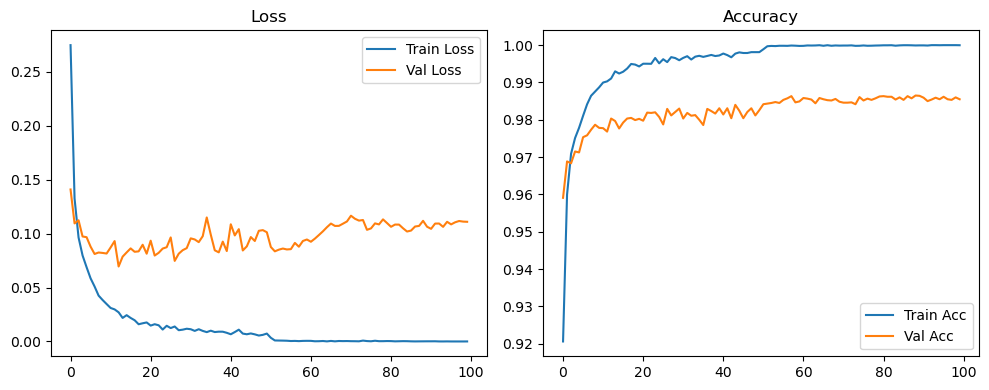

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2923, Acc: 0.9170 | Val Loss: 0.1373, Acc: 0.9626


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1529, Acc: 0.9540 | Val Loss: 0.1203, Acc: 0.9637


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1186, Acc: 0.9661 | Val Loss: 0.0925, Acc: 0.9717


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0987, Acc: 0.9703 | Val Loss: 0.0827, Acc: 0.9759


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0901, Acc: 0.9721 | Val Loss: 0.0938, Acc: 0.9710


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0819, Acc: 0.9747 | Val Loss: 0.0795, Acc: 0.9773


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0696, Acc: 0.9787 | Val Loss: 0.0799, Acc: 0.9759


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0641, Acc: 0.9800 | Val Loss: 0.0814, Acc: 0.9759


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0605, Acc: 0.9808 | Val Loss: 0.0799, Acc: 0.9777


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9824 | Val Loss: 0.0724, Acc: 0.9789


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9842 | Val Loss: 0.0787, Acc: 0.9795


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0464, Acc: 0.9855 | Val Loss: 0.0864, Acc: 0.9766


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9863 | Val Loss: 0.0758, Acc: 0.9784


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9870 | Val Loss: 0.0769, Acc: 0.9792


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9882 | Val Loss: 0.0740, Acc: 0.9804


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9883 | Val Loss: 0.0889, Acc: 0.9768


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9881 | Val Loss: 0.0796, Acc: 0.9798


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9902 | Val Loss: 0.0734, Acc: 0.9807


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0324, Acc: 0.9899 | Val Loss: 0.0768, Acc: 0.9821


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9900 | Val Loss: 0.0777, Acc: 0.9802


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9901 | Val Loss: 0.0741, Acc: 0.9817


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9919 | Val Loss: 0.0782, Acc: 0.9821


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9908 | Val Loss: 0.0724, Acc: 0.9833


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9925 | Val Loss: 0.0816, Acc: 0.9828


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9920 | Val Loss: 0.0783, Acc: 0.9832


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9925 | Val Loss: 0.0839, Acc: 0.9801


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9922 | Val Loss: 0.0714, Acc: 0.9821


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9930 | Val Loss: 0.0776, Acc: 0.9832


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9940 | Val Loss: 0.0770, Acc: 0.9826


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9932 | Val Loss: 0.0778, Acc: 0.9821


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9925 | Val Loss: 0.0897, Acc: 0.9805


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9940 | Val Loss: 0.0836, Acc: 0.9832


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9937 | Val Loss: 0.0862, Acc: 0.9826


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9935 | Val Loss: 0.0797, Acc: 0.9837


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9950 | Val Loss: 0.0875, Acc: 0.9826


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9937 | Val Loss: 0.0859, Acc: 0.9822


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9946 | Val Loss: 0.0946, Acc: 0.9816


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9944 | Val Loss: 0.0790, Acc: 0.9824


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9946 | Val Loss: 0.0913, Acc: 0.9824


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9937 | Val Loss: 0.0830, Acc: 0.9812


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9948 | Val Loss: 0.0995, Acc: 0.9817


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.0948, Acc: 0.9818


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9947 | Val Loss: 0.0811, Acc: 0.9848


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9955 | Val Loss: 0.0904, Acc: 0.9820


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9948 | Val Loss: 0.1000, Acc: 0.9819


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9952 | Val Loss: 0.0970, Acc: 0.9815


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9949 | Val Loss: 0.0931, Acc: 0.9834


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9958 | Val Loss: 0.0964, Acc: 0.9833


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.1083, Acc: 0.9820


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9949 | Val Loss: 0.0797, Acc: 0.9840


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.0811, Acc: 0.9852


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0777, Acc: 0.9861


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0791, Acc: 0.9856


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0802, Acc: 0.9858


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0809, Acc: 0.9859


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0859, Acc: 0.9862


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0879, Acc: 0.9867


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0852, Acc: 0.9862


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0887, Acc: 0.9860


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0881, Acc: 0.9863


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.0866, Acc: 0.9865


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0820, Acc: 0.9868


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0890, Acc: 0.9864


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0921, Acc: 0.9860


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0953, Acc: 0.9856


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0888, Acc: 0.9874


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0920, Acc: 0.9870


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0937, Acc: 0.9860


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0957, Acc: 0.9859


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0942, Acc: 0.9862


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.0911, Acc: 0.9868


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0973, Acc: 0.9861


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0959, Acc: 0.9859


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0966, Acc: 0.9864


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0939, Acc: 0.9863


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0970, Acc: 0.9872


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1010, Acc: 0.9861


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0977, Acc: 0.9871


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0996, Acc: 0.9865


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0966, Acc: 0.9869


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0987, Acc: 0.9867


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0979, Acc: 0.9868


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0965, Acc: 0.9868


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0982, Acc: 0.9871


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0959, Acc: 0.9868


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0942, Acc: 0.9871


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.1018, Acc: 0.9867


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0941, Acc: 0.9863


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0997, Acc: 0.9865


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.0961, Acc: 0.9868


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0963, Acc: 0.9874


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1011, Acc: 0.9875


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1058, Acc: 0.9866


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1069, Acc: 0.9870


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1064, Acc: 0.9866


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1039, Acc: 0.9868


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1071, Acc: 0.9863


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1087, Acc: 0.9866


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1037, Acc: 0.9871


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1038, Acc: 0.9870


Final Test Loss: 0.1058 Accuracy: 0.9874


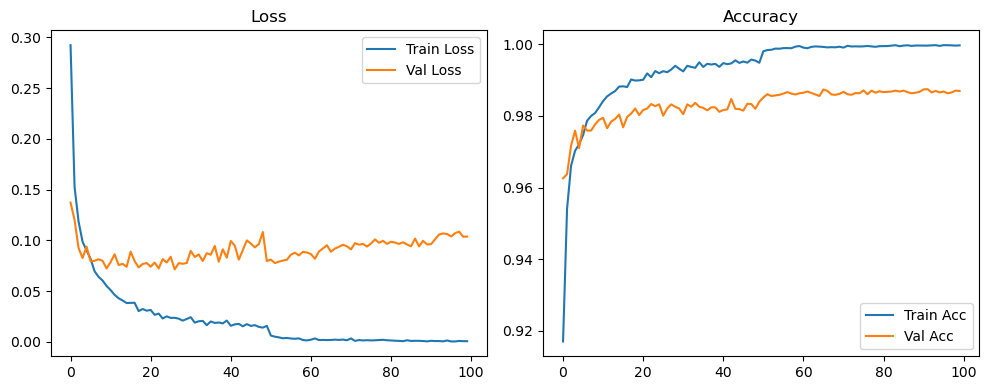

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3869, Acc: 0.8923 | Val Loss: 0.1434, Acc: 0.9570


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2228, Acc: 0.9350 | Val Loss: 0.1310, Acc: 0.9580


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1829, Acc: 0.9464 | Val Loss: 0.0991, Acc: 0.9702


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1607, Acc: 0.9523 | Val Loss: 0.0966, Acc: 0.9712


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1528, Acc: 0.9542 | Val Loss: 0.0872, Acc: 0.9737


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1394, Acc: 0.9589 | Val Loss: 0.0854, Acc: 0.9758


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1238, Acc: 0.9630 | Val Loss: 0.0901, Acc: 0.9738


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1215, Acc: 0.9640 | Val Loss: 0.0813, Acc: 0.9760


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1125, Acc: 0.9670 | Val Loss: 0.0713, Acc: 0.9798


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1101, Acc: 0.9672 | Val Loss: 0.0751, Acc: 0.9785


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1034, Acc: 0.9694 | Val Loss: 0.0711, Acc: 0.9789


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0969, Acc: 0.9715 | Val Loss: 0.0738, Acc: 0.9804


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0930, Acc: 0.9725 | Val Loss: 0.0714, Acc: 0.9805


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9736 | Val Loss: 0.0691, Acc: 0.9801


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0870, Acc: 0.9743 | Val Loss: 0.0734, Acc: 0.9808


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0821, Acc: 0.9755 | Val Loss: 0.0712, Acc: 0.9818


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0819, Acc: 0.9759 | Val Loss: 0.0689, Acc: 0.9808


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0750, Acc: 0.9772 | Val Loss: 0.0646, Acc: 0.9813


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0762, Acc: 0.9771 | Val Loss: 0.0692, Acc: 0.9813


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0713, Acc: 0.9790 | Val Loss: 0.0649, Acc: 0.9816


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0685, Acc: 0.9792 | Val Loss: 0.0660, Acc: 0.9822


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0672, Acc: 0.9796 | Val Loss: 0.0679, Acc: 0.9822


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0635, Acc: 0.9813 | Val Loss: 0.0653, Acc: 0.9834


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0638, Acc: 0.9804 | Val Loss: 0.0648, Acc: 0.9825


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0631, Acc: 0.9814 | Val Loss: 0.0645, Acc: 0.9824


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0608, Acc: 0.9819 | Val Loss: 0.0660, Acc: 0.9826


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0606, Acc: 0.9826 | Val Loss: 0.0647, Acc: 0.9840


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0621, Acc: 0.9812 | Val Loss: 0.0588, Acc: 0.9844


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0577, Acc: 0.9828 | Val Loss: 0.0717, Acc: 0.9818


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0545, Acc: 0.9837 | Val Loss: 0.0672, Acc: 0.9831


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0564, Acc: 0.9831 | Val Loss: 0.0649, Acc: 0.9845


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9841 | Val Loss: 0.0723, Acc: 0.9831


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0548, Acc: 0.9841 | Val Loss: 0.0709, Acc: 0.9840


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0548, Acc: 0.9833 | Val Loss: 0.0707, Acc: 0.9834


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9852 | Val Loss: 0.0686, Acc: 0.9834


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9849 | Val Loss: 0.0667, Acc: 0.9840


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0495, Acc: 0.9853 | Val Loss: 0.0585, Acc: 0.9858


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9858 | Val Loss: 0.0673, Acc: 0.9838


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9865 | Val Loss: 0.0690, Acc: 0.9832


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9858 | Val Loss: 0.0639, Acc: 0.9850


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9870 | Val Loss: 0.0734, Acc: 0.9832


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9869 | Val Loss: 0.0735, Acc: 0.9838


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9864 | Val Loss: 0.0674, Acc: 0.9846


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9869 | Val Loss: 0.0735, Acc: 0.9830


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9869 | Val Loss: 0.0747, Acc: 0.9843


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9867 | Val Loss: 0.0733, Acc: 0.9828


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9887 | Val Loss: 0.0784, Acc: 0.9827


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9878 | Val Loss: 0.0747, Acc: 0.9842


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9881 | Val Loss: 0.0804, Acc: 0.9835


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9875 | Val Loss: 0.0756, Acc: 0.9834


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9904 | Val Loss: 0.0710, Acc: 0.9852


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9928 | Val Loss: 0.0685, Acc: 0.9857


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9930 | Val Loss: 0.0688, Acc: 0.9862


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9936 | Val Loss: 0.0674, Acc: 0.9864


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0176, Acc: 0.9943 | Val Loss: 0.0681, Acc: 0.9863


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9939 | Val Loss: 0.0701, Acc: 0.9866


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9951 | Val Loss: 0.0689, Acc: 0.9869


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 0.0723, Acc: 0.9869


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9953 | Val Loss: 0.0708, Acc: 0.9866


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9956 | Val Loss: 0.0703, Acc: 0.9863


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.0715, Acc: 0.9862


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9958 | Val Loss: 0.0724, Acc: 0.9875


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9961 | Val Loss: 0.0773, Acc: 0.9862


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9954 | Val Loss: 0.0710, Acc: 0.9869


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9957 | Val Loss: 0.0737, Acc: 0.9862


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9957 | Val Loss: 0.0720, Acc: 0.9855


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9960 | Val Loss: 0.0761, Acc: 0.9862


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.0764, Acc: 0.9869


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9964 | Val Loss: 0.0749, Acc: 0.9869


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9962 | Val Loss: 0.0773, Acc: 0.9864


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.0745, Acc: 0.9877


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9963 | Val Loss: 0.0736, Acc: 0.9874


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.0753, Acc: 0.9870


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9965 | Val Loss: 0.0756, Acc: 0.9857


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9973 | Val Loss: 0.0793, Acc: 0.9870


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.0763, Acc: 0.9867


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9962 | Val Loss: 0.0763, Acc: 0.9866


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.0752, Acc: 0.9873


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.0761, Acc: 0.9866


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.0762, Acc: 0.9871


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9971 | Val Loss: 0.0743, Acc: 0.9878


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.0769, Acc: 0.9875


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9972 | Val Loss: 0.0770, Acc: 0.9870


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.0790, Acc: 0.9874


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.0793, Acc: 0.9869


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9973 | Val Loss: 0.0756, Acc: 0.9867


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9977 | Val Loss: 0.0751, Acc: 0.9878


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0766, Acc: 0.9879


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.0790, Acc: 0.9876


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.0759, Acc: 0.9874


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9973 | Val Loss: 0.0727, Acc: 0.9879


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9975 | Val Loss: 0.0719, Acc: 0.9873


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.0739, Acc: 0.9871


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.0769, Acc: 0.9868


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9973 | Val Loss: 0.0763, Acc: 0.9872


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0767, Acc: 0.9868


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0755, Acc: 0.9872


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.0791, Acc: 0.9874


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0794, Acc: 0.9877


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9976 | Val Loss: 0.0777, Acc: 0.9872


Final Test Loss: 0.0735 Accuracy: 0.9876


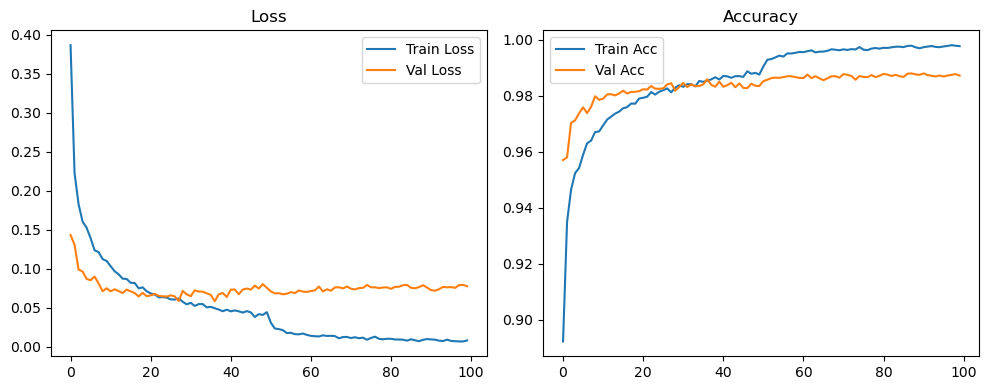

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2517, Acc: 0.9247 | Val Loss: 0.1465, Acc: 0.9585


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1228, Acc: 0.9619 | Val Loss: 0.1133, Acc: 0.9680


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0881, Acc: 0.9736 | Val Loss: 0.0888, Acc: 0.9742


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0731, Acc: 0.9770 | Val Loss: 0.0813, Acc: 0.9751


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0629, Acc: 0.9797 | Val Loss: 0.0965, Acc: 0.9701


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0536, Acc: 0.9827 | Val Loss: 0.0813, Acc: 0.9760


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0440, Acc: 0.9865 | Val Loss: 0.0804, Acc: 0.9772


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9875 | Val Loss: 0.0824, Acc: 0.9789


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9887 | Val Loss: 0.0919, Acc: 0.9778


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9888 | Val Loss: 0.0740, Acc: 0.9802


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9913 | Val Loss: 0.0776, Acc: 0.9807


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9914 | Val Loss: 0.0818, Acc: 0.9810


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9932 | Val Loss: 0.0880, Acc: 0.9795


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9931 | Val Loss: 0.0799, Acc: 0.9792


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9929 | Val Loss: 0.0843, Acc: 0.9776


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9940 | Val Loss: 0.0911, Acc: 0.9779


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9933 | Val Loss: 0.0810, Acc: 0.9813


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9947 | Val Loss: 0.0784, Acc: 0.9808


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9959 | Val Loss: 0.0718, Acc: 0.9818


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9949 | Val Loss: 0.0813, Acc: 0.9805


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9950 | Val Loss: 0.0770, Acc: 0.9830


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.0994, Acc: 0.9803


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9956 | Val Loss: 0.0686, Acc: 0.9837


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9970 | Val Loss: 0.0721, Acc: 0.9842


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9964 | Val Loss: 0.0784, Acc: 0.9824


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.0877, Acc: 0.9807


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.0890, Acc: 0.9822


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.0921, Acc: 0.9826


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.0895, Acc: 0.9828


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.0919, Acc: 0.9824


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.0948, Acc: 0.9798


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0989, Acc: 0.9808


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.1137, Acc: 0.9788


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0937, Acc: 0.9818


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.0856, Acc: 0.9818


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9977 | Val Loss: 0.0921, Acc: 0.9818


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9971 | Val Loss: 0.0976, Acc: 0.9826


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0837, Acc: 0.9832


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.0942, Acc: 0.9826


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0844, Acc: 0.9835


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0963, Acc: 0.9824


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.0941, Acc: 0.9825


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.0934, Acc: 0.9826


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0801, Acc: 0.9848


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.0913, Acc: 0.9825


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0955, Acc: 0.9826


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0829, Acc: 0.9842


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1007, Acc: 0.9828


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.0920, Acc: 0.9833


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.0908, Acc: 0.9835


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0871, Acc: 0.9835


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.0825, Acc: 0.9838


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9985 | Val Loss: 0.0855, Acc: 0.9837


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9983 | Val Loss: 0.0875, Acc: 0.9822


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.0844, Acc: 0.9839


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0831, Acc: 0.9840


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.0800, Acc: 0.9859


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.0952, Acc: 0.9843


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1111, Acc: 0.9820


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0927, Acc: 0.9845


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9984 | Val Loss: 0.0915, Acc: 0.9842


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9985 | Val Loss: 0.0910, Acc: 0.9843


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.0829, Acc: 0.9861


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0858, Acc: 0.9857


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0931, Acc: 0.9844


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0869, Acc: 0.9842


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1073, Acc: 0.9832


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0916, Acc: 0.9849


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1066, Acc: 0.9831


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1065, Acc: 0.9836


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.0996, Acc: 0.9847


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9985 | Val Loss: 0.1005, Acc: 0.9828


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1001, Acc: 0.9841


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1128, Acc: 0.9831


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1016, Acc: 0.9830


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0985, Acc: 0.9836


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0979, Acc: 0.9840


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1008, Acc: 0.9838


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1139, Acc: 0.9835


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0995, Acc: 0.9837


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1042, Acc: 0.9840


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9988 | Val Loss: 0.1153, Acc: 0.9817


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.0899, Acc: 0.9844


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1065, Acc: 0.9831


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1167, Acc: 0.9824


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0940, Acc: 0.9846


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0987, Acc: 0.9847


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1038, Acc: 0.9838


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1065, Acc: 0.9840


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1289, Acc: 0.9817


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1161, Acc: 0.9823


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1313, Acc: 0.9808


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1144, Acc: 0.9832


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9988 | Val Loss: 0.1154, Acc: 0.9825


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1157, Acc: 0.9828


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1147, Acc: 0.9814


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0987, Acc: 0.9844


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1215, Acc: 0.9824


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1246, Acc: 0.9832


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1121, Acc: 0.9824


Final Test Loss: 0.0931 Accuracy: 0.9849


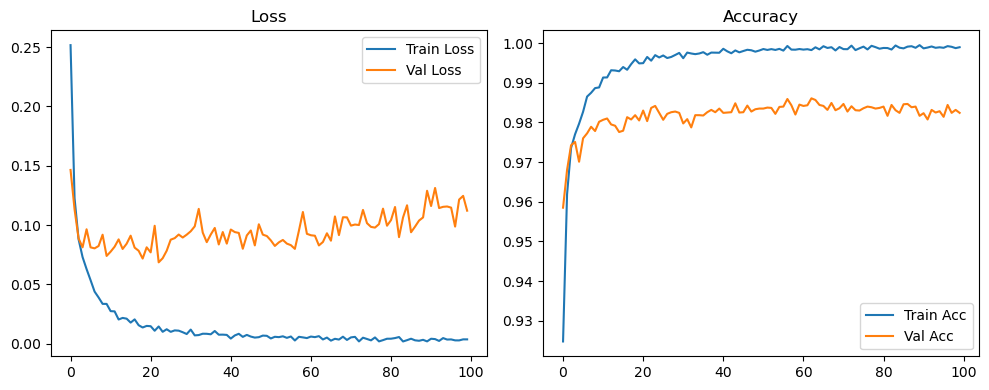

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2681, Acc: 0.9189 | Val Loss: 0.1335, Acc: 0.9612


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1433, Acc: 0.9566 | Val Loss: 0.1227, Acc: 0.9619


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1084, Acc: 0.9674 | Val Loss: 0.0844, Acc: 0.9751


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0895, Acc: 0.9716 | Val Loss: 0.0825, Acc: 0.9752


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0797, Acc: 0.9746 | Val Loss: 0.0938, Acc: 0.9726


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0713, Acc: 0.9771 | Val Loss: 0.0787, Acc: 0.9782


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0610, Acc: 0.9815 | Val Loss: 0.0840, Acc: 0.9757


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0591, Acc: 0.9813 | Val Loss: 0.0724, Acc: 0.9786


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0492, Acc: 0.9843 | Val Loss: 0.0831, Acc: 0.9771


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0483, Acc: 0.9848 | Val Loss: 0.0693, Acc: 0.9804


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0423, Acc: 0.9860 | Val Loss: 0.0704, Acc: 0.9810


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9864 | Val Loss: 0.0693, Acc: 0.9818


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9900 | Val Loss: 0.0774, Acc: 0.9803


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9891 | Val Loss: 0.0794, Acc: 0.9798


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9893 | Val Loss: 0.0725, Acc: 0.9812


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9903 | Val Loss: 0.0734, Acc: 0.9808


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9909 | Val Loss: 0.0633, Acc: 0.9831


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9919 | Val Loss: 0.0787, Acc: 0.9833


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9915 | Val Loss: 0.0788, Acc: 0.9814


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9920 | Val Loss: 0.0807, Acc: 0.9810


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9933 | Val Loss: 0.0784, Acc: 0.9829


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9921 | Val Loss: 0.0631, Acc: 0.9840


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9940 | Val Loss: 0.0782, Acc: 0.9824


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9931 | Val Loss: 0.0791, Acc: 0.9822


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9936 | Val Loss: 0.0822, Acc: 0.9838


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9938 | Val Loss: 0.0799, Acc: 0.9822


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9932 | Val Loss: 0.0777, Acc: 0.9839


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9947 | Val Loss: 0.0831, Acc: 0.9837


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9947 | Val Loss: 0.0872, Acc: 0.9824


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.0752, Acc: 0.9844


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9938 | Val Loss: 0.0729, Acc: 0.9848


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9950 | Val Loss: 0.0809, Acc: 0.9827


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9955 | Val Loss: 0.0788, Acc: 0.9838


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9957 | Val Loss: 0.0803, Acc: 0.9832


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9950 | Val Loss: 0.0819, Acc: 0.9842


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9953 | Val Loss: 0.0803, Acc: 0.9835


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9959 | Val Loss: 0.0791, Acc: 0.9835


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9956 | Val Loss: 0.0833, Acc: 0.9838


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9952 | Val Loss: 0.0741, Acc: 0.9838


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9952 | Val Loss: 0.0762, Acc: 0.9840


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.0997, Acc: 0.9818


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9952 | Val Loss: 0.0857, Acc: 0.9835


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9955 | Val Loss: 0.0819, Acc: 0.9838


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0858, Acc: 0.9846


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.0929, Acc: 0.9826


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.0941, Acc: 0.9820


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9963 | Val Loss: 0.0927, Acc: 0.9824


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9958 | Val Loss: 0.0927, Acc: 0.9836


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.0810, Acc: 0.9844


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.0879, Acc: 0.9838


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9964 | Val Loss: 0.0916, Acc: 0.9826


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9966 | Val Loss: 0.0934, Acc: 0.9831


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9970 | Val Loss: 0.0822, Acc: 0.9853


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9966 | Val Loss: 0.0819, Acc: 0.9844


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.0929, Acc: 0.9835


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.0956, Acc: 0.9828


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9967 | Val Loss: 0.0851, Acc: 0.9841


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.1013, Acc: 0.9818


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9969 | Val Loss: 0.0878, Acc: 0.9837


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.0898, Acc: 0.9834


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.0836, Acc: 0.9842


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9967 | Val Loss: 0.0815, Acc: 0.9842


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.0835, Acc: 0.9853


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.0961, Acc: 0.9828


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.0902, Acc: 0.9840


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0908, Acc: 0.9850


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9968 | Val Loss: 0.0848, Acc: 0.9843


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.0969, Acc: 0.9832


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.0972, Acc: 0.9840


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9977 | Val Loss: 0.0947, Acc: 0.9828


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9974 | Val Loss: 0.0994, Acc: 0.9837


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.0962, Acc: 0.9838


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0910, Acc: 0.9838


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.0936, Acc: 0.9839


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.0904, Acc: 0.9848


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.0880, Acc: 0.9841


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.0908, Acc: 0.9837


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0879, Acc: 0.9849


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9977 | Val Loss: 0.0944, Acc: 0.9846


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0974, Acc: 0.9833


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1005, Acc: 0.9847


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1058, Acc: 0.9848


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9972 | Val Loss: 0.1023, Acc: 0.9851


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.0978, Acc: 0.9855


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.0979, Acc: 0.9849


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0948, Acc: 0.9842


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1050, Acc: 0.9842


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9969 | Val Loss: 0.1019, Acc: 0.9832


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1138, Acc: 0.9829


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9980 | Val Loss: 0.0971, Acc: 0.9842


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9979 | Val Loss: 0.0973, Acc: 0.9843


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9979 | Val Loss: 0.0938, Acc: 0.9850


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9978 | Val Loss: 0.1001, Acc: 0.9840


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.1094, Acc: 0.9832


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9974 | Val Loss: 0.0971, Acc: 0.9853


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0945, Acc: 0.9851


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.0948, Acc: 0.9851


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9982 | Val Loss: 0.1063, Acc: 0.9838


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9981 | Val Loss: 0.0999, Acc: 0.9836


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9977 | Val Loss: 0.0998, Acc: 0.9838


Final Test Loss: 0.0863 Accuracy: 0.9862


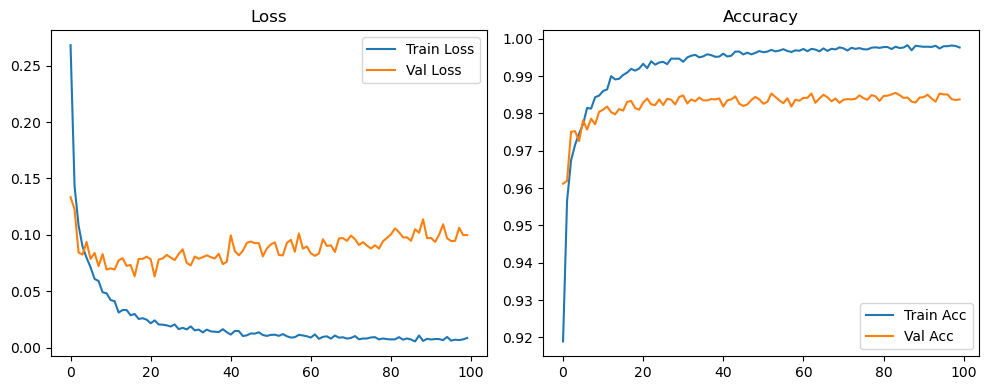

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3524, Acc: 0.8978 | Val Loss: 0.1596, Acc: 0.9537


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2032, Acc: 0.9392 | Val Loss: 0.1124, Acc: 0.9663


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1661, Acc: 0.9515 | Val Loss: 0.0926, Acc: 0.9718


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1401, Acc: 0.9571 | Val Loss: 0.0884, Acc: 0.9726


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1324, Acc: 0.9605 | Val Loss: 0.1020, Acc: 0.9691


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1220, Acc: 0.9629 | Val Loss: 0.0798, Acc: 0.9768


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1143, Acc: 0.9651 | Val Loss: 0.0867, Acc: 0.9741


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1009, Acc: 0.9695 | Val Loss: 0.0785, Acc: 0.9778


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0966, Acc: 0.9699 | Val Loss: 0.0736, Acc: 0.9778


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0921, Acc: 0.9720 | Val Loss: 0.0730, Acc: 0.9794


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0891, Acc: 0.9735 | Val Loss: 0.0732, Acc: 0.9794


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0845, Acc: 0.9744 | Val Loss: 0.0715, Acc: 0.9792


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0736, Acc: 0.9771 | Val Loss: 0.0659, Acc: 0.9798


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0741, Acc: 0.9762 | Val Loss: 0.0657, Acc: 0.9820


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0709, Acc: 0.9785 | Val Loss: 0.0641, Acc: 0.9823


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0651, Acc: 0.9804 | Val Loss: 0.0712, Acc: 0.9801


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0665, Acc: 0.9788 | Val Loss: 0.0628, Acc: 0.9831


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0635, Acc: 0.9803 | Val Loss: 0.0676, Acc: 0.9808


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0614, Acc: 0.9810 | Val Loss: 0.0687, Acc: 0.9817


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0587, Acc: 0.9822 | Val Loss: 0.0632, Acc: 0.9822


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0564, Acc: 0.9823 | Val Loss: 0.0677, Acc: 0.9809


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0531, Acc: 0.9834 | Val Loss: 0.0615, Acc: 0.9842


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0522, Acc: 0.9836 | Val Loss: 0.0688, Acc: 0.9813


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0502, Acc: 0.9844 | Val Loss: 0.0645, Acc: 0.9833


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0524, Acc: 0.9840 | Val Loss: 0.0643, Acc: 0.9834


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0466, Acc: 0.9856 | Val Loss: 0.0651, Acc: 0.9832


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0487, Acc: 0.9851 | Val Loss: 0.0652, Acc: 0.9822


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0457, Acc: 0.9857 | Val Loss: 0.0677, Acc: 0.9828


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0449, Acc: 0.9858 | Val Loss: 0.0707, Acc: 0.9812


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9858 | Val Loss: 0.0683, Acc: 0.9830


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0463, Acc: 0.9861 | Val Loss: 0.0657, Acc: 0.9834


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0411, Acc: 0.9871 | Val Loss: 0.0702, Acc: 0.9832


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0440, Acc: 0.9866 | Val Loss: 0.0708, Acc: 0.9822


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9869 | Val Loss: 0.0673, Acc: 0.9831


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0432, Acc: 0.9870 | Val Loss: 0.0610, Acc: 0.9847


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9868 | Val Loss: 0.0642, Acc: 0.9840


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9886 | Val Loss: 0.0648, Acc: 0.9832


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9884 | Val Loss: 0.0647, Acc: 0.9847


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9879 | Val Loss: 0.0695, Acc: 0.9838


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9889 | Val Loss: 0.0693, Acc: 0.9837


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9892 | Val Loss: 0.0767, Acc: 0.9834


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0361, Acc: 0.9891 | Val Loss: 0.0711, Acc: 0.9832


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9879 | Val Loss: 0.0652, Acc: 0.9850


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9891 | Val Loss: 0.0674, Acc: 0.9847


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9899 | Val Loss: 0.0721, Acc: 0.9852


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0304, Acc: 0.9908 | Val Loss: 0.0731, Acc: 0.9840


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9899 | Val Loss: 0.0675, Acc: 0.9847


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9895 | Val Loss: 0.0705, Acc: 0.9838


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9903 | Val Loss: 0.0728, Acc: 0.9842


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9900 | Val Loss: 0.0637, Acc: 0.9857


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9899 | Val Loss: 0.0654, Acc: 0.9855


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9910 | Val Loss: 0.0664, Acc: 0.9845


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9895 | Val Loss: 0.0691, Acc: 0.9846


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0317, Acc: 0.9905 | Val Loss: 0.0697, Acc: 0.9853


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0310, Acc: 0.9909 | Val Loss: 0.0660, Acc: 0.9848


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9919 | Val Loss: 0.0736, Acc: 0.9842


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9900 | Val Loss: 0.0713, Acc: 0.9852


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0296, Acc: 0.9912 | Val Loss: 0.0691, Acc: 0.9841


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9909 | Val Loss: 0.0666, Acc: 0.9850


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9911 | Val Loss: 0.0728, Acc: 0.9834


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9918 | Val Loss: 0.0686, Acc: 0.9849


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9911 | Val Loss: 0.0722, Acc: 0.9852


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9920 | Val Loss: 0.0779, Acc: 0.9829


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9922 | Val Loss: 0.0748, Acc: 0.9847


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9916 | Val Loss: 0.0716, Acc: 0.9843


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9918 | Val Loss: 0.0717, Acc: 0.9853


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9918 | Val Loss: 0.0759, Acc: 0.9854


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9923 | Val Loss: 0.0756, Acc: 0.9846


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9924 | Val Loss: 0.0730, Acc: 0.9852


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9926 | Val Loss: 0.0767, Acc: 0.9842


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9920 | Val Loss: 0.0710, Acc: 0.9855


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9929 | Val Loss: 0.0787, Acc: 0.9839


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9928 | Val Loss: 0.0742, Acc: 0.9848


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9930 | Val Loss: 0.0778, Acc: 0.9842


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9923 | Val Loss: 0.0757, Acc: 0.9842


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9925 | Val Loss: 0.0748, Acc: 0.9856


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9928 | Val Loss: 0.0830, Acc: 0.9840


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9933 | Val Loss: 0.0745, Acc: 0.9852


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9933 | Val Loss: 0.0828, Acc: 0.9848


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9929 | Val Loss: 0.0787, Acc: 0.9845


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9930 | Val Loss: 0.0722, Acc: 0.9853


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9924 | Val Loss: 0.0787, Acc: 0.9856


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9925 | Val Loss: 0.0718, Acc: 0.9841


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9938 | Val Loss: 0.0799, Acc: 0.9834


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9927 | Val Loss: 0.0824, Acc: 0.9832


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9939 | Val Loss: 0.0811, Acc: 0.9847


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9936 | Val Loss: 0.0766, Acc: 0.9858


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9929 | Val Loss: 0.0792, Acc: 0.9842


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9932 | Val Loss: 0.0783, Acc: 0.9849


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0235, Acc: 0.9932 | Val Loss: 0.0712, Acc: 0.9846


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9934 | Val Loss: 0.0740, Acc: 0.9846


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9937 | Val Loss: 0.0806, Acc: 0.9842


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9931 | Val Loss: 0.0854, Acc: 0.9858


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9940 | Val Loss: 0.0878, Acc: 0.9842


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9934 | Val Loss: 0.0829, Acc: 0.9851


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9937 | Val Loss: 0.0838, Acc: 0.9852


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9937 | Val Loss: 0.0798, Acc: 0.9850


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9940 | Val Loss: 0.0869, Acc: 0.9848


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9938 | Val Loss: 0.0881, Acc: 0.9849


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9936 | Val Loss: 0.0782, Acc: 0.9858


Final Test Loss: 0.0767 Accuracy: 0.9859


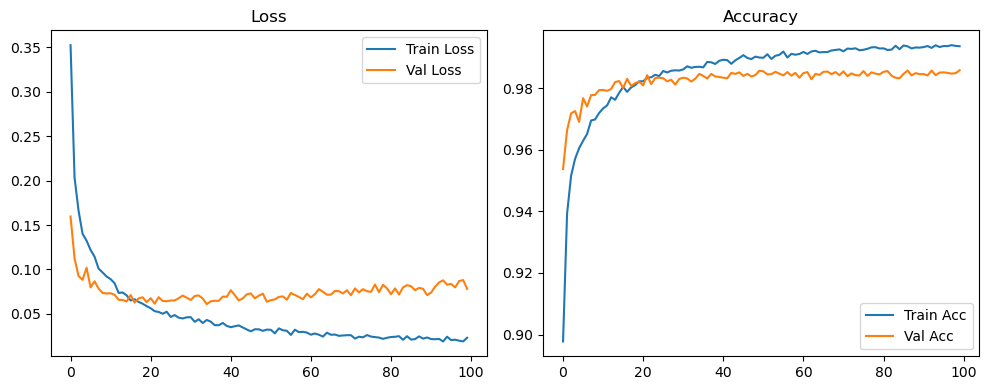

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2517, Acc: 0.9247 | Val Loss: 0.1465, Acc: 0.9585


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1228, Acc: 0.9619 | Val Loss: 0.1133, Acc: 0.9680


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0881, Acc: 0.9736 | Val Loss: 0.0888, Acc: 0.9742


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0731, Acc: 0.9770 | Val Loss: 0.0813, Acc: 0.9751


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0629, Acc: 0.9797 | Val Loss: 0.0965, Acc: 0.9701


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0536, Acc: 0.9827 | Val Loss: 0.0813, Acc: 0.9760


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0440, Acc: 0.9865 | Val Loss: 0.0804, Acc: 0.9772


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9875 | Val Loss: 0.0824, Acc: 0.9789


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9887 | Val Loss: 0.0919, Acc: 0.9778


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9888 | Val Loss: 0.0740, Acc: 0.9802


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9913 | Val Loss: 0.0776, Acc: 0.9807


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9914 | Val Loss: 0.0818, Acc: 0.9810


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9932 | Val Loss: 0.0880, Acc: 0.9795


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9931 | Val Loss: 0.0799, Acc: 0.9792


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9929 | Val Loss: 0.0843, Acc: 0.9776


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9940 | Val Loss: 0.0911, Acc: 0.9779


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9933 | Val Loss: 0.0810, Acc: 0.9813


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9947 | Val Loss: 0.0784, Acc: 0.9808


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9959 | Val Loss: 0.0718, Acc: 0.9818


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9949 | Val Loss: 0.0813, Acc: 0.9805


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9950 | Val Loss: 0.0770, Acc: 0.9830


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.0994, Acc: 0.9803


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9956 | Val Loss: 0.0686, Acc: 0.9837


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9970 | Val Loss: 0.0721, Acc: 0.9842


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9964 | Val Loss: 0.0784, Acc: 0.9824


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.0877, Acc: 0.9807


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.0890, Acc: 0.9822


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.0921, Acc: 0.9826


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.0895, Acc: 0.9828


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.0919, Acc: 0.9824


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.0948, Acc: 0.9798


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0989, Acc: 0.9808


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.1137, Acc: 0.9788


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0937, Acc: 0.9818


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.0856, Acc: 0.9818


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9977 | Val Loss: 0.0921, Acc: 0.9818


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9971 | Val Loss: 0.0976, Acc: 0.9826


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0837, Acc: 0.9832


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.0942, Acc: 0.9826


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0844, Acc: 0.9835


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0963, Acc: 0.9824


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.0941, Acc: 0.9825


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.0934, Acc: 0.9826


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0801, Acc: 0.9848


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.0913, Acc: 0.9825


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0955, Acc: 0.9826


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0829, Acc: 0.9842


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1007, Acc: 0.9828


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.0920, Acc: 0.9833


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.0908, Acc: 0.9835


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0795, Acc: 0.9852


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0787, Acc: 0.9846


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0803, Acc: 0.9852


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0840, Acc: 0.9842


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0833, Acc: 0.9847


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0859, Acc: 0.9852


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0968, Acc: 0.9854


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0936, Acc: 0.9858


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0887, Acc: 0.9858


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0890, Acc: 0.9861


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0956, Acc: 0.9846


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0947, Acc: 0.9848


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0947, Acc: 0.9852


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0986, Acc: 0.9847


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0991, Acc: 0.9838


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0958, Acc: 0.9845


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0964, Acc: 0.9849


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0934, Acc: 0.9864


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0998, Acc: 0.9851


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1177, Acc: 0.9830


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0982, Acc: 0.9848


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1001, Acc: 0.9852


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1012, Acc: 0.9834


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1075, Acc: 0.9839


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1095, Acc: 0.9848


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1011, Acc: 0.9856


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1105, Acc: 0.9857


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1035, Acc: 0.9858


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1016, Acc: 0.9856


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1132, Acc: 0.9849


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1070, Acc: 0.9851


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1077, Acc: 0.9858


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1052, Acc: 0.9866


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1052, Acc: 0.9864


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1028, Acc: 0.9862


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1096, Acc: 0.9856


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1069, Acc: 0.9853


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1106, Acc: 0.9859


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1106, Acc: 0.9863


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1081, Acc: 0.9861


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1012, Acc: 0.9862


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1043, Acc: 0.9865


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1073, Acc: 0.9868


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1084, Acc: 0.9867


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1146, Acc: 0.9862


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1046, Acc: 0.9866


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1047, Acc: 0.9871


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1055, Acc: 0.9870


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1074, Acc: 0.9869


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1094, Acc: 0.9861


Final Test Loss: 0.1084 Accuracy: 0.9854


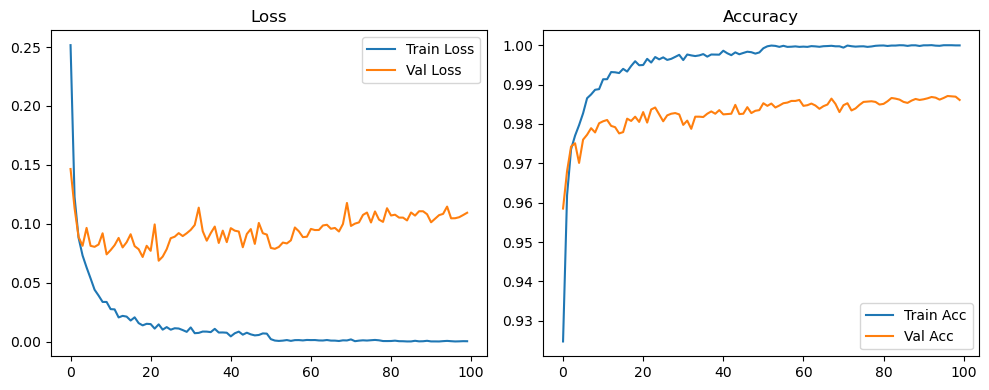

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2681, Acc: 0.9189 | Val Loss: 0.1335, Acc: 0.9612


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1433, Acc: 0.9566 | Val Loss: 0.1227, Acc: 0.9619


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1084, Acc: 0.9674 | Val Loss: 0.0844, Acc: 0.9751


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0895, Acc: 0.9716 | Val Loss: 0.0825, Acc: 0.9752


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0797, Acc: 0.9746 | Val Loss: 0.0938, Acc: 0.9726


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0713, Acc: 0.9771 | Val Loss: 0.0787, Acc: 0.9782


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0610, Acc: 0.9815 | Val Loss: 0.0840, Acc: 0.9757


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0591, Acc: 0.9813 | Val Loss: 0.0724, Acc: 0.9786


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0492, Acc: 0.9843 | Val Loss: 0.0831, Acc: 0.9771


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0483, Acc: 0.9848 | Val Loss: 0.0693, Acc: 0.9804


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0423, Acc: 0.9860 | Val Loss: 0.0704, Acc: 0.9810


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9864 | Val Loss: 0.0693, Acc: 0.9818


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9900 | Val Loss: 0.0774, Acc: 0.9803


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9891 | Val Loss: 0.0794, Acc: 0.9798


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9893 | Val Loss: 0.0725, Acc: 0.9812


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9903 | Val Loss: 0.0734, Acc: 0.9808


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9909 | Val Loss: 0.0633, Acc: 0.9831


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9919 | Val Loss: 0.0787, Acc: 0.9833


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9915 | Val Loss: 0.0788, Acc: 0.9814


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9920 | Val Loss: 0.0807, Acc: 0.9810


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9933 | Val Loss: 0.0784, Acc: 0.9829


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9921 | Val Loss: 0.0631, Acc: 0.9840


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9940 | Val Loss: 0.0782, Acc: 0.9824


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9931 | Val Loss: 0.0791, Acc: 0.9822


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9936 | Val Loss: 0.0822, Acc: 0.9838


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9938 | Val Loss: 0.0799, Acc: 0.9822


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9932 | Val Loss: 0.0777, Acc: 0.9839


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9947 | Val Loss: 0.0831, Acc: 0.9837


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9947 | Val Loss: 0.0872, Acc: 0.9824


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.0752, Acc: 0.9844


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9938 | Val Loss: 0.0729, Acc: 0.9848


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9950 | Val Loss: 0.0809, Acc: 0.9827


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9955 | Val Loss: 0.0788, Acc: 0.9838


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9957 | Val Loss: 0.0803, Acc: 0.9832


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9950 | Val Loss: 0.0819, Acc: 0.9842


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9953 | Val Loss: 0.0803, Acc: 0.9835


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9959 | Val Loss: 0.0791, Acc: 0.9835


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9956 | Val Loss: 0.0833, Acc: 0.9838


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9952 | Val Loss: 0.0741, Acc: 0.9838


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9952 | Val Loss: 0.0762, Acc: 0.9840


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.0997, Acc: 0.9818


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9952 | Val Loss: 0.0857, Acc: 0.9835


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9955 | Val Loss: 0.0819, Acc: 0.9838


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0858, Acc: 0.9846


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.0929, Acc: 0.9826


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.0941, Acc: 0.9820


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9963 | Val Loss: 0.0927, Acc: 0.9824


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9958 | Val Loss: 0.0927, Acc: 0.9836


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.0810, Acc: 0.9844


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.0879, Acc: 0.9838


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0794, Acc: 0.9849


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0809, Acc: 0.9860


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.0830, Acc: 0.9858


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0822, Acc: 0.9865


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0856, Acc: 0.9851


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0879, Acc: 0.9863


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0841, Acc: 0.9870


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0928, Acc: 0.9855


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0873, Acc: 0.9860


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0919, Acc: 0.9864


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0928, Acc: 0.9862


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0906, Acc: 0.9858


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.0871, Acc: 0.9870


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0876, Acc: 0.9866


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0922, Acc: 0.9867


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0909, Acc: 0.9869


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0986, Acc: 0.9857


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0970, Acc: 0.9856


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0959, Acc: 0.9855


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9989 | Val Loss: 0.0966, Acc: 0.9861


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0921, Acc: 0.9862


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0997, Acc: 0.9863


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1003, Acc: 0.9847


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1004, Acc: 0.9858


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1025, Acc: 0.9853


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0929, Acc: 0.9860


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0925, Acc: 0.9856


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0951, Acc: 0.9863


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1080, Acc: 0.9847


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1074, Acc: 0.9853


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1051, Acc: 0.9857


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1046, Acc: 0.9857


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1069, Acc: 0.9851


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1061, Acc: 0.9860


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1056, Acc: 0.9862


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1045, Acc: 0.9862


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1065, Acc: 0.9856


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1028, Acc: 0.9864


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1077, Acc: 0.9865


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0992, Acc: 0.9868


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1010, Acc: 0.9860


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1009, Acc: 0.9856


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1075, Acc: 0.9846


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1036, Acc: 0.9857


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1064, Acc: 0.9854


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1001, Acc: 0.9859


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1023, Acc: 0.9856


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1085, Acc: 0.9858


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1043, Acc: 0.9860


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1046, Acc: 0.9864


Final Test Loss: 0.1059 Accuracy: 0.9859


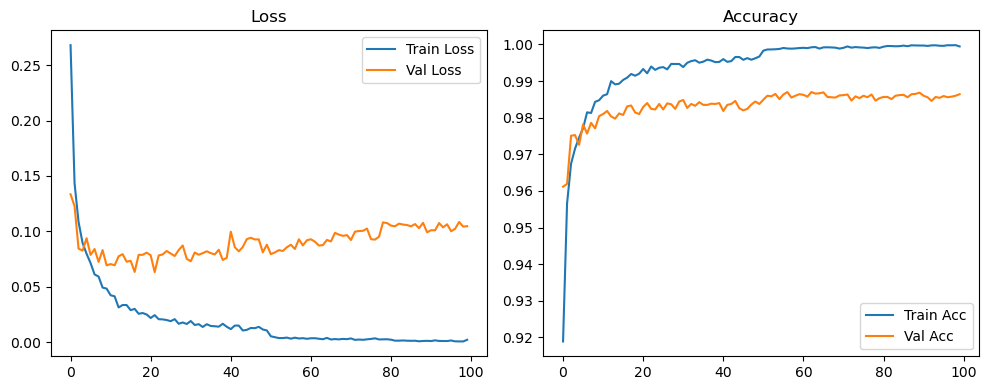

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3524, Acc: 0.8978 | Val Loss: 0.1596, Acc: 0.9537


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2032, Acc: 0.9392 | Val Loss: 0.1124, Acc: 0.9663


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1661, Acc: 0.9515 | Val Loss: 0.0926, Acc: 0.9718


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1401, Acc: 0.9571 | Val Loss: 0.0884, Acc: 0.9726


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1324, Acc: 0.9605 | Val Loss: 0.1020, Acc: 0.9691


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1220, Acc: 0.9629 | Val Loss: 0.0798, Acc: 0.9768


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1143, Acc: 0.9651 | Val Loss: 0.0867, Acc: 0.9741


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1009, Acc: 0.9695 | Val Loss: 0.0785, Acc: 0.9778


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0966, Acc: 0.9699 | Val Loss: 0.0736, Acc: 0.9778


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0921, Acc: 0.9720 | Val Loss: 0.0730, Acc: 0.9794


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0891, Acc: 0.9735 | Val Loss: 0.0732, Acc: 0.9794


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0845, Acc: 0.9744 | Val Loss: 0.0715, Acc: 0.9792


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0736, Acc: 0.9771 | Val Loss: 0.0659, Acc: 0.9798


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0741, Acc: 0.9762 | Val Loss: 0.0657, Acc: 0.9820


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0709, Acc: 0.9785 | Val Loss: 0.0641, Acc: 0.9823


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0651, Acc: 0.9804 | Val Loss: 0.0712, Acc: 0.9801


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0665, Acc: 0.9788 | Val Loss: 0.0628, Acc: 0.9831


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0635, Acc: 0.9803 | Val Loss: 0.0676, Acc: 0.9808


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0614, Acc: 0.9810 | Val Loss: 0.0687, Acc: 0.9817


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0587, Acc: 0.9822 | Val Loss: 0.0632, Acc: 0.9822


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0564, Acc: 0.9823 | Val Loss: 0.0677, Acc: 0.9809


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0531, Acc: 0.9834 | Val Loss: 0.0615, Acc: 0.9842


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0522, Acc: 0.9836 | Val Loss: 0.0688, Acc: 0.9813


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0502, Acc: 0.9844 | Val Loss: 0.0645, Acc: 0.9833


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0524, Acc: 0.9840 | Val Loss: 0.0643, Acc: 0.9834


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0466, Acc: 0.9856 | Val Loss: 0.0651, Acc: 0.9832


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0487, Acc: 0.9851 | Val Loss: 0.0652, Acc: 0.9822


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0457, Acc: 0.9857 | Val Loss: 0.0677, Acc: 0.9828


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0449, Acc: 0.9858 | Val Loss: 0.0707, Acc: 0.9812


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9858 | Val Loss: 0.0683, Acc: 0.9830


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0463, Acc: 0.9861 | Val Loss: 0.0657, Acc: 0.9834


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0411, Acc: 0.9871 | Val Loss: 0.0702, Acc: 0.9832


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0440, Acc: 0.9866 | Val Loss: 0.0708, Acc: 0.9822


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9869 | Val Loss: 0.0673, Acc: 0.9831


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0432, Acc: 0.9870 | Val Loss: 0.0610, Acc: 0.9847


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9868 | Val Loss: 0.0642, Acc: 0.9840


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9886 | Val Loss: 0.0648, Acc: 0.9832


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9884 | Val Loss: 0.0647, Acc: 0.9847


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9879 | Val Loss: 0.0695, Acc: 0.9838


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9889 | Val Loss: 0.0693, Acc: 0.9837


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9892 | Val Loss: 0.0767, Acc: 0.9834


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0361, Acc: 0.9891 | Val Loss: 0.0711, Acc: 0.9832


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9879 | Val Loss: 0.0652, Acc: 0.9850


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9891 | Val Loss: 0.0674, Acc: 0.9847


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9899 | Val Loss: 0.0721, Acc: 0.9852


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0304, Acc: 0.9908 | Val Loss: 0.0731, Acc: 0.9840


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9899 | Val Loss: 0.0675, Acc: 0.9847


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9895 | Val Loss: 0.0705, Acc: 0.9838


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9903 | Val Loss: 0.0728, Acc: 0.9842


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9900 | Val Loss: 0.0637, Acc: 0.9857


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9928 | Val Loss: 0.0619, Acc: 0.9866


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9936 | Val Loss: 0.0590, Acc: 0.9864


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9942 | Val Loss: 0.0599, Acc: 0.9869


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0175, Acc: 0.9945 | Val Loss: 0.0629, Acc: 0.9870


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9954 | Val Loss: 0.0651, Acc: 0.9857


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.0689, Acc: 0.9863


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9947 | Val Loss: 0.0647, Acc: 0.9864


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9958 | Val Loss: 0.0668, Acc: 0.9859


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.0702, Acc: 0.9859


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9952 | Val Loss: 0.0666, Acc: 0.9867


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.0684, Acc: 0.9856


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9959 | Val Loss: 0.0702, Acc: 0.9858


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9960 | Val Loss: 0.0699, Acc: 0.9858


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9961 | Val Loss: 0.0683, Acc: 0.9861


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.0728, Acc: 0.9867


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9960 | Val Loss: 0.0718, Acc: 0.9862


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.0770, Acc: 0.9861


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9964 | Val Loss: 0.0734, Acc: 0.9865


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9961 | Val Loss: 0.0735, Acc: 0.9861


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.0782, Acc: 0.9852


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9963 | Val Loss: 0.0728, Acc: 0.9852


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.0761, Acc: 0.9855


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.0766, Acc: 0.9844


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.0752, Acc: 0.9859


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.0854, Acc: 0.9853


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9962 | Val Loss: 0.0771, Acc: 0.9854


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0765, Acc: 0.9862


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.0757, Acc: 0.9870


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.0773, Acc: 0.9862


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9969 | Val Loss: 0.0763, Acc: 0.9866


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9969 | Val Loss: 0.0729, Acc: 0.9870


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.0750, Acc: 0.9867


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9974 | Val Loss: 0.0732, Acc: 0.9862


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.0740, Acc: 0.9866


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.0765, Acc: 0.9862


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.0725, Acc: 0.9868


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.0749, Acc: 0.9865


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0762, Acc: 0.9868


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0790, Acc: 0.9867


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.0796, Acc: 0.9868


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0755, Acc: 0.9862


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0781, Acc: 0.9858


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.0789, Acc: 0.9864


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0855, Acc: 0.9874


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9978 | Val Loss: 0.0849, Acc: 0.9867


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0824, Acc: 0.9863


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0791, Acc: 0.9864


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0808, Acc: 0.9867


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0826, Acc: 0.9870


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0816, Acc: 0.9863


Final Test Loss: 0.0727 Accuracy: 0.9877


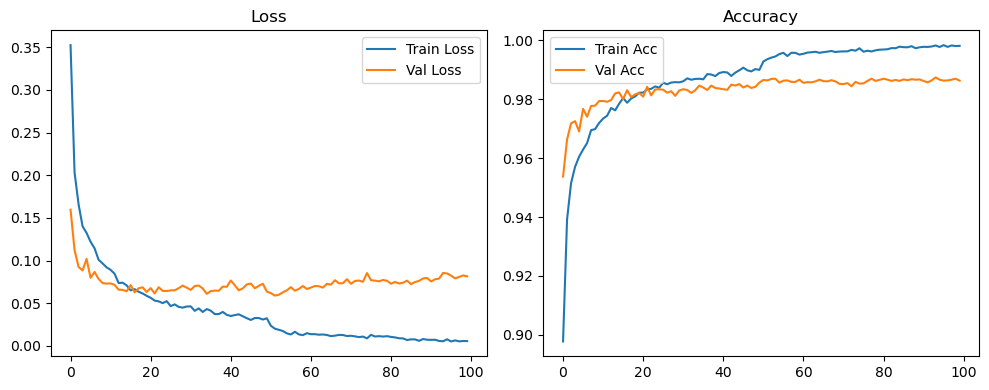

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2228, Acc: 0.9319 | Val Loss: 0.1320, Acc: 0.9619


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1150, Acc: 0.9639 | Val Loss: 0.1053, Acc: 0.9686


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0834, Acc: 0.9749 | Val Loss: 0.0937, Acc: 0.9725


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0683, Acc: 0.9794 | Val Loss: 0.0793, Acc: 0.9759


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0542, Acc: 0.9826 | Val Loss: 0.1030, Acc: 0.9701


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0525, Acc: 0.9829 | Val Loss: 0.0755, Acc: 0.9783


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0393, Acc: 0.9874 | Val Loss: 0.0804, Acc: 0.9765


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0379, Acc: 0.9886 | Val Loss: 0.0819, Acc: 0.9776


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9901 | Val Loss: 0.0967, Acc: 0.9759


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9901 | Val Loss: 0.0809, Acc: 0.9791


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9914 | Val Loss: 0.0742, Acc: 0.9822


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0237, Acc: 0.9923 | Val Loss: 0.0940, Acc: 0.9772


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0197, Acc: 0.9934 | Val Loss: 0.0866, Acc: 0.9797


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0200, Acc: 0.9936 | Val Loss: 0.0830, Acc: 0.9807


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0223, Acc: 0.9932 | Val Loss: 0.0759, Acc: 0.9822


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9946 | Val Loss: 0.0932, Acc: 0.9785


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9953 | Val Loss: 0.0851, Acc: 0.9804


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.0861, Acc: 0.9792


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9955 | Val Loss: 0.0819, Acc: 0.9822


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9954 | Val Loss: 0.0867, Acc: 0.9812


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9954 | Val Loss: 0.0791, Acc: 0.9838


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.0856, Acc: 0.9822


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9956 | Val Loss: 0.0838, Acc: 0.9813


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.0777, Acc: 0.9830


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.0870, Acc: 0.9823


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9972 | Val Loss: 0.0795, Acc: 0.9830


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0818, Acc: 0.9828


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.0892, Acc: 0.9817


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9966 | Val Loss: 0.0779, Acc: 0.9832


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.0837, Acc: 0.9822


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.0768, Acc: 0.9843


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0882, Acc: 0.9841


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9976 | Val Loss: 0.0756, Acc: 0.9848


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.0841, Acc: 0.9828


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0867, Acc: 0.9837


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0956, Acc: 0.9827


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.0956, Acc: 0.9828


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.0943, Acc: 0.9821


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.0898, Acc: 0.9848


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0893, Acc: 0.9826


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0866, Acc: 0.9844


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0864, Acc: 0.9842


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1015, Acc: 0.9832


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0900, Acc: 0.9835


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.0866, Acc: 0.9838


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1001, Acc: 0.9823


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.0952, Acc: 0.9822


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9988 | Val Loss: 0.0972, Acc: 0.9838


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1024, Acc: 0.9835


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1025, Acc: 0.9828


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0926, Acc: 0.9839


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1075, Acc: 0.9832


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.0952, Acc: 0.9842


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1038, Acc: 0.9828


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.0983, Acc: 0.9838


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9991 | Val Loss: 0.1080, Acc: 0.9820


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0995, Acc: 0.9841


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0949, Acc: 0.9844


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0919, Acc: 0.9848


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0933, Acc: 0.9857


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0950, Acc: 0.9844


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0940, Acc: 0.9836


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.0970, Acc: 0.9851


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0935, Acc: 0.9843


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1048, Acc: 0.9828


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0989, Acc: 0.9831


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1017, Acc: 0.9828


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0922, Acc: 0.9848


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1009, Acc: 0.9838


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1115, Acc: 0.9822


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1066, Acc: 0.9832


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9990 | Val Loss: 0.0926, Acc: 0.9853


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0885, Acc: 0.9852


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0997, Acc: 0.9829


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1014, Acc: 0.9831


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9991 | Val Loss: 0.1042, Acc: 0.9819


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.1071, Acc: 0.9822


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9991 | Val Loss: 0.1135, Acc: 0.9811


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.1001, Acc: 0.9842


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1071, Acc: 0.9822


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1121, Acc: 0.9827


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1058, Acc: 0.9841


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1124, Acc: 0.9814


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1072, Acc: 0.9831


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1017, Acc: 0.9829


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9992 | Val Loss: 0.1034, Acc: 0.9841


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0997, Acc: 0.9848


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0962, Acc: 0.9850


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1123, Acc: 0.9818


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1079, Acc: 0.9830


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0979, Acc: 0.9844


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0994, Acc: 0.9831


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1043, Acc: 0.9844


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1092, Acc: 0.9842


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1141, Acc: 0.9845


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1025, Acc: 0.9844


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.1081, Acc: 0.9824


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0980, Acc: 0.9856


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1061, Acc: 0.9844


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1247, Acc: 0.9820


Final Test Loss: 0.1357 Accuracy: 0.9792


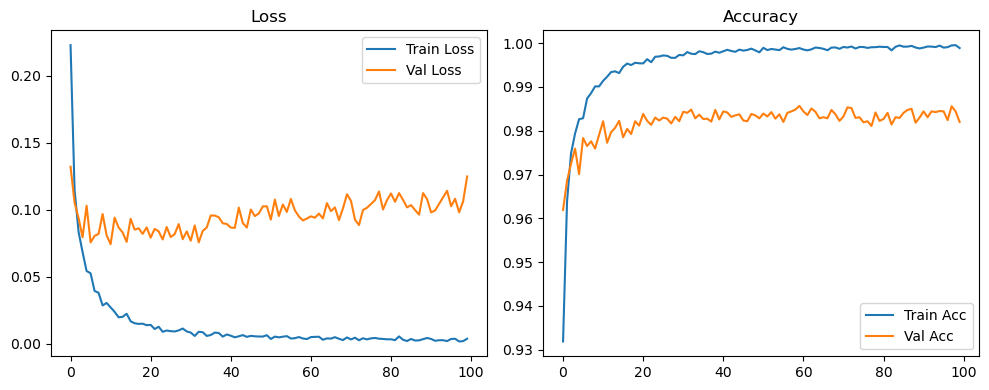

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2386, Acc: 0.9270 | Val Loss: 0.1372, Acc: 0.9591


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1336, Acc: 0.9584 | Val Loss: 0.1157, Acc: 0.9647


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1018, Acc: 0.9690 | Val Loss: 0.0867, Acc: 0.9760


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0803, Acc: 0.9746 | Val Loss: 0.0856, Acc: 0.9760


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0749, Acc: 0.9766 | Val Loss: 0.0840, Acc: 0.9762


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0632, Acc: 0.9802 | Val Loss: 0.0774, Acc: 0.9766


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0549, Acc: 0.9822 | Val Loss: 0.0870, Acc: 0.9733


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0521, Acc: 0.9835 | Val Loss: 0.0706, Acc: 0.9795


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0428, Acc: 0.9857 | Val Loss: 0.0863, Acc: 0.9775


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0405, Acc: 0.9869 | Val Loss: 0.0751, Acc: 0.9796


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0393, Acc: 0.9867 | Val Loss: 0.0779, Acc: 0.9802


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0356, Acc: 0.9889 | Val Loss: 0.0714, Acc: 0.9805


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9901 | Val Loss: 0.0823, Acc: 0.9786


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0292, Acc: 0.9903 | Val Loss: 0.0715, Acc: 0.9810


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9907 | Val Loss: 0.0879, Acc: 0.9783


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9912 | Val Loss: 0.0701, Acc: 0.9834


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9926 | Val Loss: 0.0693, Acc: 0.9833


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9928 | Val Loss: 0.0759, Acc: 0.9815


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9921 | Val Loss: 0.0774, Acc: 0.9818


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9932 | Val Loss: 0.0851, Acc: 0.9812


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9934 | Val Loss: 0.0823, Acc: 0.9818


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0186, Acc: 0.9941 | Val Loss: 0.0756, Acc: 0.9817


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9940 | Val Loss: 0.0714, Acc: 0.9830


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9952 | Val Loss: 0.0768, Acc: 0.9833


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0175, Acc: 0.9944 | Val Loss: 0.0828, Acc: 0.9817


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.0768, Acc: 0.9824


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.0718, Acc: 0.9838


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9949 | Val Loss: 0.0972, Acc: 0.9812


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.0789, Acc: 0.9838


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9954 | Val Loss: 0.0725, Acc: 0.9838


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9955 | Val Loss: 0.0779, Acc: 0.9832


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9961 | Val Loss: 0.0825, Acc: 0.9824


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.0770, Acc: 0.9844


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9959 | Val Loss: 0.0842, Acc: 0.9823


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9964 | Val Loss: 0.0723, Acc: 0.9838


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.0798, Acc: 0.9824


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.0823, Acc: 0.9832


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.0809, Acc: 0.9829


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9963 | Val Loss: 0.0806, Acc: 0.9822


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.0797, Acc: 0.9833


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.0841, Acc: 0.9834


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.0741, Acc: 0.9843


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.0734, Acc: 0.9844


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.0693, Acc: 0.9862


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.0769, Acc: 0.9845


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9973 | Val Loss: 0.0909, Acc: 0.9835


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0765, Acc: 0.9845


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9969 | Val Loss: 0.0803, Acc: 0.9834


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0879, Acc: 0.9847


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0843, Acc: 0.9852


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0865, Acc: 0.9840


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9974 | Val Loss: 0.0885, Acc: 0.9849


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9980 | Val Loss: 0.0921, Acc: 0.9836


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.0779, Acc: 0.9848


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0895, Acc: 0.9835


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.0982, Acc: 0.9827


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.0881, Acc: 0.9852


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.0962, Acc: 0.9841


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0887, Acc: 0.9852


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.0876, Acc: 0.9840


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9977 | Val Loss: 0.0851, Acc: 0.9849


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9978 | Val Loss: 0.0790, Acc: 0.9852


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9978 | Val Loss: 0.0822, Acc: 0.9839


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0855, Acc: 0.9839


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.0843, Acc: 0.9848


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.0854, Acc: 0.9852


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9981 | Val Loss: 0.1021, Acc: 0.9823


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.0802, Acc: 0.9840


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0766, Acc: 0.9858


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0882, Acc: 0.9841


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9979 | Val Loss: 0.0817, Acc: 0.9849


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0907, Acc: 0.9844


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0985, Acc: 0.9842


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0847, Acc: 0.9842


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0905, Acc: 0.9834


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.0917, Acc: 0.9846


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.0803, Acc: 0.9858


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.0837, Acc: 0.9845


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.0862, Acc: 0.9858


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.0948, Acc: 0.9838


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0901, Acc: 0.9847


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.0875, Acc: 0.9851


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.0824, Acc: 0.9853


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.0838, Acc: 0.9852


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9979 | Val Loss: 0.0798, Acc: 0.9852


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0799, Acc: 0.9852


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.0824, Acc: 0.9855


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0901, Acc: 0.9850


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0930, Acc: 0.9848


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0843, Acc: 0.9856


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0955, Acc: 0.9833


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1002, Acc: 0.9843


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0986, Acc: 0.9854


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0961, Acc: 0.9842


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.0992, Acc: 0.9843


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0858, Acc: 0.9850


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1002, Acc: 0.9852


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9983 | Val Loss: 0.0861, Acc: 0.9854


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.0923, Acc: 0.9855


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0916, Acc: 0.9856


Final Test Loss: 0.0852 Accuracy: 0.9868


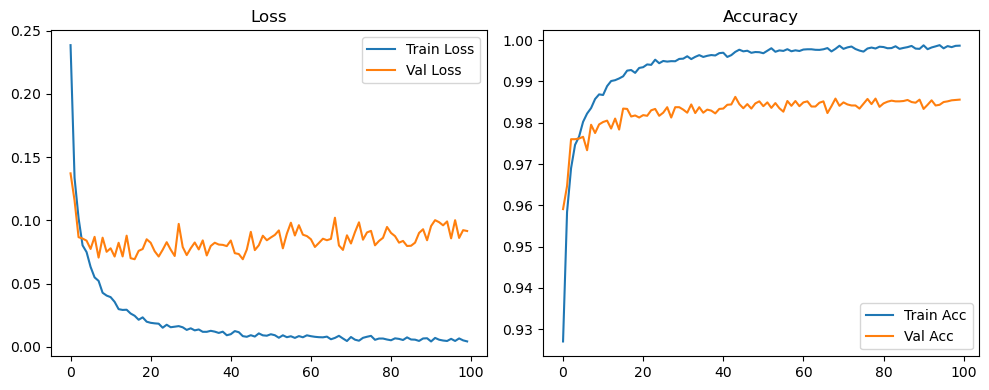

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3119, Acc: 0.9047 | Val Loss: 0.1503, Acc: 0.9545


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1882, Acc: 0.9433 | Val Loss: 0.1114, Acc: 0.9657


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1574, Acc: 0.9522 | Val Loss: 0.0886, Acc: 0.9728


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1303, Acc: 0.9608 | Val Loss: 0.0842, Acc: 0.9737


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1215, Acc: 0.9631 | Val Loss: 0.0841, Acc: 0.9732


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1125, Acc: 0.9658 | Val Loss: 0.0811, Acc: 0.9768


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0988, Acc: 0.9704 | Val Loss: 0.0787, Acc: 0.9767


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0948, Acc: 0.9705 | Val Loss: 0.0746, Acc: 0.9771


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0846, Acc: 0.9732 | Val Loss: 0.0802, Acc: 0.9767


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0820, Acc: 0.9746 | Val Loss: 0.0660, Acc: 0.9806


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0775, Acc: 0.9760 | Val Loss: 0.0681, Acc: 0.9803


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0731, Acc: 0.9781 | Val Loss: 0.0692, Acc: 0.9801


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0629, Acc: 0.9799 | Val Loss: 0.0668, Acc: 0.9791


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0637, Acc: 0.9799 | Val Loss: 0.0590, Acc: 0.9825


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0620, Acc: 0.9806 | Val Loss: 0.0637, Acc: 0.9818


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0578, Acc: 0.9817 | Val Loss: 0.0629, Acc: 0.9822


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0559, Acc: 0.9816 | Val Loss: 0.0603, Acc: 0.9824


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0515, Acc: 0.9832 | Val Loss: 0.0609, Acc: 0.9823


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0532, Acc: 0.9835 | Val Loss: 0.0638, Acc: 0.9838


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0504, Acc: 0.9841 | Val Loss: 0.0587, Acc: 0.9835


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0461, Acc: 0.9857 | Val Loss: 0.0582, Acc: 0.9846


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0462, Acc: 0.9852 | Val Loss: 0.0610, Acc: 0.9832


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0443, Acc: 0.9869 | Val Loss: 0.0660, Acc: 0.9824


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0409, Acc: 0.9867 | Val Loss: 0.0659, Acc: 0.9822


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0419, Acc: 0.9867 | Val Loss: 0.0662, Acc: 0.9835


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0379, Acc: 0.9877 | Val Loss: 0.0619, Acc: 0.9843


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0387, Acc: 0.9881 | Val Loss: 0.0627, Acc: 0.9834


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0382, Acc: 0.9875 | Val Loss: 0.0627, Acc: 0.9844


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0378, Acc: 0.9882 | Val Loss: 0.0667, Acc: 0.9837


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0354, Acc: 0.9887 | Val Loss: 0.0648, Acc: 0.9835


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0387, Acc: 0.9873 | Val Loss: 0.0633, Acc: 0.9842


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0317, Acc: 0.9899 | Val Loss: 0.0639, Acc: 0.9839


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0343, Acc: 0.9892 | Val Loss: 0.0678, Acc: 0.9828


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0328, Acc: 0.9898 | Val Loss: 0.0679, Acc: 0.9840


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0335, Acc: 0.9893 | Val Loss: 0.0671, Acc: 0.9842


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0323, Acc: 0.9893 | Val Loss: 0.0656, Acc: 0.9836


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0303, Acc: 0.9904 | Val Loss: 0.0638, Acc: 0.9850


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0292, Acc: 0.9906 | Val Loss: 0.0637, Acc: 0.9858


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0320, Acc: 0.9904 | Val Loss: 0.0642, Acc: 0.9848


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9909 | Val Loss: 0.0642, Acc: 0.9846


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9915 | Val Loss: 0.0740, Acc: 0.9842


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9913 | Val Loss: 0.0696, Acc: 0.9848


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9912 | Val Loss: 0.0629, Acc: 0.9848


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9911 | Val Loss: 0.0698, Acc: 0.9832


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9918 | Val Loss: 0.0676, Acc: 0.9832


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0248, Acc: 0.9920 | Val Loss: 0.0695, Acc: 0.9835


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9921 | Val Loss: 0.0686, Acc: 0.9848


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9916 | Val Loss: 0.0707, Acc: 0.9832


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9920 | Val Loss: 0.0682, Acc: 0.9852


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9923 | Val Loss: 0.0685, Acc: 0.9841


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0249, Acc: 0.9918 | Val Loss: 0.0656, Acc: 0.9855


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9917 | Val Loss: 0.0682, Acc: 0.9850


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9929 | Val Loss: 0.0671, Acc: 0.9850


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9921 | Val Loss: 0.0642, Acc: 0.9848


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9931 | Val Loss: 0.0696, Acc: 0.9848


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9922 | Val Loss: 0.0707, Acc: 0.9844


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0216, Acc: 0.9931 | Val Loss: 0.0710, Acc: 0.9854


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0211, Acc: 0.9938 | Val Loss: 0.0693, Acc: 0.9851


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9931 | Val Loss: 0.0662, Acc: 0.9860


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0205, Acc: 0.9933 | Val Loss: 0.0673, Acc: 0.9858


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0200, Acc: 0.9934 | Val Loss: 0.0653, Acc: 0.9862


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9934 | Val Loss: 0.0687, Acc: 0.9844


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0229, Acc: 0.9931 | Val Loss: 0.0759, Acc: 0.9837


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9939 | Val Loss: 0.0752, Acc: 0.9847


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9934 | Val Loss: 0.0705, Acc: 0.9850


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9935 | Val Loss: 0.0720, Acc: 0.9844


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9931 | Val Loss: 0.0650, Acc: 0.9865


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0203, Acc: 0.9936 | Val Loss: 0.0674, Acc: 0.9851


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9937 | Val Loss: 0.0632, Acc: 0.9855


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.0665, Acc: 0.9855


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9943 | Val Loss: 0.0660, Acc: 0.9867


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0198, Acc: 0.9937 | Val Loss: 0.0673, Acc: 0.9862


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9943 | Val Loss: 0.0696, Acc: 0.9850


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0179, Acc: 0.9942 | Val Loss: 0.0692, Acc: 0.9859


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0186, Acc: 0.9942 | Val Loss: 0.0744, Acc: 0.9847


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0203, Acc: 0.9938 | Val Loss: 0.0678, Acc: 0.9864


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9939 | Val Loss: 0.0680, Acc: 0.9858


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9944 | Val Loss: 0.0701, Acc: 0.9857


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0197, Acc: 0.9939 | Val Loss: 0.0677, Acc: 0.9868


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9951 | Val Loss: 0.0679, Acc: 0.9862


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9944 | Val Loss: 0.0642, Acc: 0.9863


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9941 | Val Loss: 0.0703, Acc: 0.9855


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0159, Acc: 0.9949 | Val Loss: 0.0692, Acc: 0.9864


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9948 | Val Loss: 0.0690, Acc: 0.9858


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0187, Acc: 0.9941 | Val Loss: 0.0687, Acc: 0.9857


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9949 | Val Loss: 0.0684, Acc: 0.9845


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9948 | Val Loss: 0.0681, Acc: 0.9864


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0159, Acc: 0.9951 | Val Loss: 0.0700, Acc: 0.9857


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9951 | Val Loss: 0.0718, Acc: 0.9868


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9954 | Val Loss: 0.0716, Acc: 0.9858


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9949 | Val Loss: 0.0729, Acc: 0.9851


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9951 | Val Loss: 0.0733, Acc: 0.9852


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9948 | Val Loss: 0.0688, Acc: 0.9866


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9956 | Val Loss: 0.0770, Acc: 0.9852


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9944 | Val Loss: 0.0720, Acc: 0.9861


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9957 | Val Loss: 0.0718, Acc: 0.9859


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9948 | Val Loss: 0.0664, Acc: 0.9861


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9949 | Val Loss: 0.0664, Acc: 0.9870


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.0703, Acc: 0.9861


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9955 | Val Loss: 0.0680, Acc: 0.9863


Final Test Loss: 0.0667 Accuracy: 0.9864


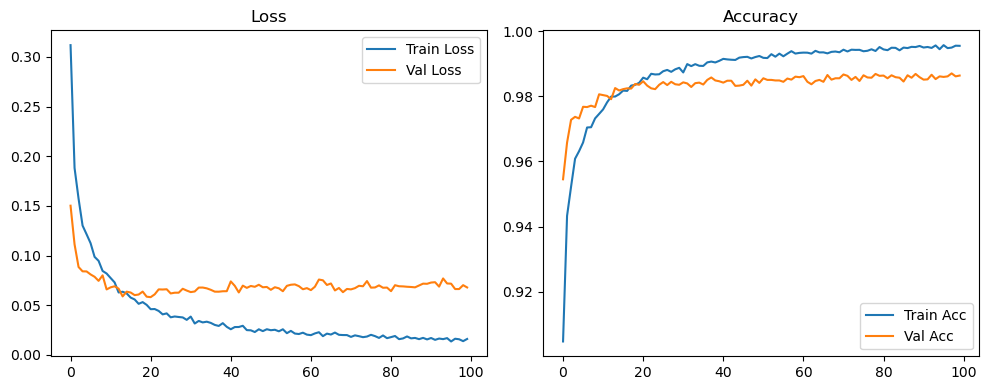

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2017, Acc: 0.9380 | Val Loss: 0.1203, Acc: 0.9640


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1017, Acc: 0.9678 | Val Loss: 0.0996, Acc: 0.9689


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0751, Acc: 0.9771 | Val Loss: 0.0853, Acc: 0.9745


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0613, Acc: 0.9806 | Val Loss: 0.0747, Acc: 0.9783


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0498, Acc: 0.9835 | Val Loss: 0.0845, Acc: 0.9757


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0443, Acc: 0.9849 | Val Loss: 0.0745, Acc: 0.9769


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0370, Acc: 0.9886 | Val Loss: 0.0910, Acc: 0.9761


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0332, Acc: 0.9888 | Val Loss: 0.0866, Acc: 0.9774


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0272, Acc: 0.9911 | Val Loss: 0.0914, Acc: 0.9778


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9918 | Val Loss: 0.0920, Acc: 0.9775


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0250, Acc: 0.9918 | Val Loss: 0.0848, Acc: 0.9793


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9927 | Val Loss: 0.0759, Acc: 0.9810


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9939 | Val Loss: 0.0777, Acc: 0.9810


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9941 | Val Loss: 0.0718, Acc: 0.9825


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9942 | Val Loss: 0.0821, Acc: 0.9805


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9941 | Val Loss: 0.0762, Acc: 0.9827


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0163, Acc: 0.9945 | Val Loss: 0.0798, Acc: 0.9830


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.0866, Acc: 0.9810


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0141, Acc: 0.9949 | Val Loss: 0.0803, Acc: 0.9827


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.0814, Acc: 0.9819


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9958 | Val Loss: 0.0768, Acc: 0.9831


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.0873, Acc: 0.9822


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.0965, Acc: 0.9797


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9965 | Val Loss: 0.0898, Acc: 0.9797


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9972 | Val Loss: 0.0890, Acc: 0.9825


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.0894, Acc: 0.9813


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9967 | Val Loss: 0.0773, Acc: 0.9838


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.0803, Acc: 0.9834


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9974 | Val Loss: 0.0860, Acc: 0.9806


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0791, Acc: 0.9830


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.0851, Acc: 0.9833


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.0827, Acc: 0.9848


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0927, Acc: 0.9831


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.0917, Acc: 0.9831


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0797, Acc: 0.9838


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.0895, Acc: 0.9818


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0843, Acc: 0.9833


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0863, Acc: 0.9847


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.0808, Acc: 0.9837


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0887, Acc: 0.9831


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.0870, Acc: 0.9850


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0948, Acc: 0.9838


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.0822, Acc: 0.9858


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0784, Acc: 0.9859


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0966, Acc: 0.9832


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0889, Acc: 0.9835


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0930, Acc: 0.9828


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.0791, Acc: 0.9848


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0820, Acc: 0.9841


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.0804, Acc: 0.9853


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0946, Acc: 0.9846


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0881, Acc: 0.9853


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.0941, Acc: 0.9837


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.0906, Acc: 0.9835


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0812, Acc: 0.9861


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0974, Acc: 0.9834


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.0893, Acc: 0.9848


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0875, Acc: 0.9841


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0890, Acc: 0.9854


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.0916, Acc: 0.9848


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9989 | Val Loss: 0.0899, Acc: 0.9843


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0852, Acc: 0.9856


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0960, Acc: 0.9859


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0884, Acc: 0.9848


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0821, Acc: 0.9862


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0867, Acc: 0.9861


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1022, Acc: 0.9843


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0882, Acc: 0.9852


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0946, Acc: 0.9852


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1101, Acc: 0.9826


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1033, Acc: 0.9832


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1026, Acc: 0.9848


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.0890, Acc: 0.9848


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0986, Acc: 0.9852


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0985, Acc: 0.9846


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0863, Acc: 0.9857


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0931, Acc: 0.9855


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0873, Acc: 0.9860


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0901, Acc: 0.9852


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1031, Acc: 0.9844


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0908, Acc: 0.9841


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.0875, Acc: 0.9859


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1083, Acc: 0.9825


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9996 | Val Loss: 0.0888, Acc: 0.9856


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1056, Acc: 0.9828


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0944, Acc: 0.9837


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0858, Acc: 0.9858


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0940, Acc: 0.9849


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0992, Acc: 0.9841


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0961, Acc: 0.9857


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0867, Acc: 0.9865


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0893, Acc: 0.9852


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0976, Acc: 0.9847


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.0906, Acc: 0.9855


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0936, Acc: 0.9856


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.0904, Acc: 0.9852


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.0929, Acc: 0.9841


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0931, Acc: 0.9848


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0949, Acc: 0.9855


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9995 | Val Loss: 0.1013, Acc: 0.9858


Final Test Loss: 0.1119 Accuracy: 0.9830


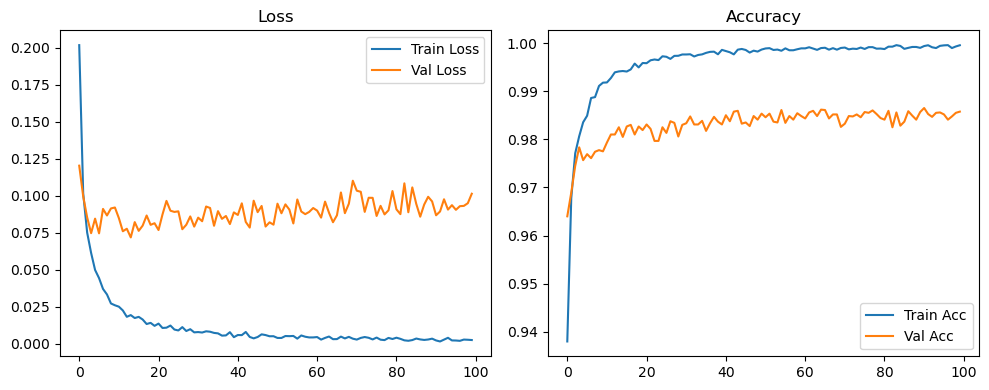

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2209, Acc: 0.9310 | Val Loss: 0.1302, Acc: 0.9617


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1208, Acc: 0.9617 | Val Loss: 0.1046, Acc: 0.9677


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0912, Acc: 0.9719 | Val Loss: 0.0794, Acc: 0.9756


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0751, Acc: 0.9758 | Val Loss: 0.0722, Acc: 0.9783


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0662, Acc: 0.9793 | Val Loss: 0.0813, Acc: 0.9758


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0590, Acc: 0.9810 | Val Loss: 0.0707, Acc: 0.9794


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0493, Acc: 0.9842 | Val Loss: 0.0844, Acc: 0.9761


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0459, Acc: 0.9856 | Val Loss: 0.0773, Acc: 0.9778


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0409, Acc: 0.9859 | Val Loss: 0.0834, Acc: 0.9765


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0366, Acc: 0.9878 | Val Loss: 0.0758, Acc: 0.9797


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0366, Acc: 0.9881 | Val Loss: 0.0694, Acc: 0.9803


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0323, Acc: 0.9897 | Val Loss: 0.0739, Acc: 0.9824


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0284, Acc: 0.9905 | Val Loss: 0.0843, Acc: 0.9782


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9907 | Val Loss: 0.0732, Acc: 0.9813


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0265, Acc: 0.9912 | Val Loss: 0.0691, Acc: 0.9828


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0228, Acc: 0.9929 | Val Loss: 0.0796, Acc: 0.9805


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9922 | Val Loss: 0.0716, Acc: 0.9819


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9934 | Val Loss: 0.0837, Acc: 0.9808


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9924 | Val Loss: 0.0714, Acc: 0.9838


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9940 | Val Loss: 0.0755, Acc: 0.9820


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9943 | Val Loss: 0.0726, Acc: 0.9842


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9940 | Val Loss: 0.0733, Acc: 0.9826


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9945 | Val Loss: 0.0691, Acc: 0.9848


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9947 | Val Loss: 0.0845, Acc: 0.9817


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.0812, Acc: 0.9818


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9954 | Val Loss: 0.0800, Acc: 0.9821


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9958 | Val Loss: 0.0718, Acc: 0.9845


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.0752, Acc: 0.9848


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 0.0747, Acc: 0.9832


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0824, Acc: 0.9828


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9953 | Val Loss: 0.0733, Acc: 0.9842


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.0735, Acc: 0.9843


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9966 | Val Loss: 0.0797, Acc: 0.9846


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.0814, Acc: 0.9819


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9968 | Val Loss: 0.0715, Acc: 0.9843


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9968 | Val Loss: 0.0752, Acc: 0.9838


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0793, Acc: 0.9845


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.0804, Acc: 0.9858


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0739, Acc: 0.9854


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.0774, Acc: 0.9849


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.0847, Acc: 0.9840


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0844, Acc: 0.9842


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9970 | Val Loss: 0.0758, Acc: 0.9846


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0743, Acc: 0.9851


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.0911, Acc: 0.9830


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.0892, Acc: 0.9824


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.0889, Acc: 0.9837


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.0877, Acc: 0.9850


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.0792, Acc: 0.9841


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0930, Acc: 0.9840


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9976 | Val Loss: 0.0839, Acc: 0.9842


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9976 | Val Loss: 0.0875, Acc: 0.9834


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.0789, Acc: 0.9856


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0764, Acc: 0.9862


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.0805, Acc: 0.9854


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0911, Acc: 0.9828


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.0755, Acc: 0.9849


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9981 | Val Loss: 0.0814, Acc: 0.9844


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0757, Acc: 0.9850


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0729, Acc: 0.9857


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.0721, Acc: 0.9864


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0854, Acc: 0.9851


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.0882, Acc: 0.9839


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0863, Acc: 0.9859


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0902, Acc: 0.9840


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0817, Acc: 0.9854


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0901, Acc: 0.9848


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0933, Acc: 0.9831


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.0954, Acc: 0.9844


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9980 | Val Loss: 0.0923, Acc: 0.9834


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.0811, Acc: 0.9847


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0927, Acc: 0.9841


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0764, Acc: 0.9858


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0889, Acc: 0.9838


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0943, Acc: 0.9846


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.0883, Acc: 0.9848


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0912, Acc: 0.9859


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.0912, Acc: 0.9838


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0935, Acc: 0.9854


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.0850, Acc: 0.9858


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0902, Acc: 0.9851


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0969, Acc: 0.9840


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.0921, Acc: 0.9852


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.0864, Acc: 0.9857


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0886, Acc: 0.9842


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0864, Acc: 0.9852


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.0909, Acc: 0.9854


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0869, Acc: 0.9850


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0936, Acc: 0.9849


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0905, Acc: 0.9848


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0864, Acc: 0.9853


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0997, Acc: 0.9834


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0960, Acc: 0.9842


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0919, Acc: 0.9842


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9979 | Val Loss: 0.0956, Acc: 0.9858


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0913, Acc: 0.9856


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0940, Acc: 0.9848


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.0876, Acc: 0.9858


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0864, Acc: 0.9851


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0850, Acc: 0.9850


Final Test Loss: 0.0882 Accuracy: 0.9849


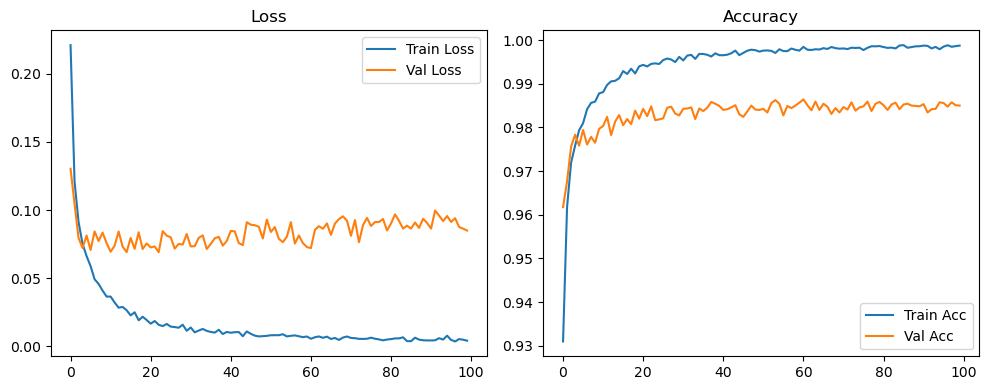

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2988, Acc: 0.9080 | Val Loss: 0.1367, Acc: 0.9580


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1763, Acc: 0.9463 | Val Loss: 0.1116, Acc: 0.9644


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1441, Acc: 0.9563 | Val Loss: 0.0889, Acc: 0.9721


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1229, Acc: 0.9604 | Val Loss: 0.0881, Acc: 0.9730


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1164, Acc: 0.9644 | Val Loss: 0.0848, Acc: 0.9743


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1037, Acc: 0.9677 | Val Loss: 0.0761, Acc: 0.9768


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0943, Acc: 0.9707 | Val Loss: 0.0822, Acc: 0.9755


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0890, Acc: 0.9721 | Val Loss: 0.0713, Acc: 0.9785


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0833, Acc: 0.9736 | Val Loss: 0.0725, Acc: 0.9766


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0782, Acc: 0.9751 | Val Loss: 0.0697, Acc: 0.9790


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0759, Acc: 0.9768 | Val Loss: 0.0690, Acc: 0.9795


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0682, Acc: 0.9789 | Val Loss: 0.0699, Acc: 0.9801


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0603, Acc: 0.9802 | Val Loss: 0.0628, Acc: 0.9808


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0618, Acc: 0.9802 | Val Loss: 0.0651, Acc: 0.9809


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0599, Acc: 0.9805 | Val Loss: 0.0642, Acc: 0.9817


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0551, Acc: 0.9821 | Val Loss: 0.0642, Acc: 0.9815


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0560, Acc: 0.9822 | Val Loss: 0.0621, Acc: 0.9820


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0481, Acc: 0.9839 | Val Loss: 0.0614, Acc: 0.9825


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0502, Acc: 0.9842 | Val Loss: 0.0592, Acc: 0.9839


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0487, Acc: 0.9835 | Val Loss: 0.0600, Acc: 0.9831


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0447, Acc: 0.9859 | Val Loss: 0.0589, Acc: 0.9838


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0464, Acc: 0.9848 | Val Loss: 0.0597, Acc: 0.9845


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0414, Acc: 0.9866 | Val Loss: 0.0613, Acc: 0.9834


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0374, Acc: 0.9880 | Val Loss: 0.0604, Acc: 0.9837


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0389, Acc: 0.9874 | Val Loss: 0.0597, Acc: 0.9838


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0342, Acc: 0.9891 | Val Loss: 0.0656, Acc: 0.9832


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0380, Acc: 0.9881 | Val Loss: 0.0623, Acc: 0.9835


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0382, Acc: 0.9873 | Val Loss: 0.0653, Acc: 0.9843


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0352, Acc: 0.9882 | Val Loss: 0.0637, Acc: 0.9844


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0317, Acc: 0.9896 | Val Loss: 0.0613, Acc: 0.9836


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0361, Acc: 0.9887 | Val Loss: 0.0616, Acc: 0.9839


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0309, Acc: 0.9898 | Val Loss: 0.0702, Acc: 0.9824


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0328, Acc: 0.9891 | Val Loss: 0.0670, Acc: 0.9846


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0297, Acc: 0.9903 | Val Loss: 0.0646, Acc: 0.9843


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0296, Acc: 0.9907 | Val Loss: 0.0628, Acc: 0.9842


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0293, Acc: 0.9907 | Val Loss: 0.0610, Acc: 0.9842


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0300, Acc: 0.9901 | Val Loss: 0.0622, Acc: 0.9846


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0269, Acc: 0.9911 | Val Loss: 0.0629, Acc: 0.9848


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0285, Acc: 0.9911 | Val Loss: 0.0653, Acc: 0.9846


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0265, Acc: 0.9914 | Val Loss: 0.0656, Acc: 0.9846


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9926 | Val Loss: 0.0724, Acc: 0.9842


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0283, Acc: 0.9910 | Val Loss: 0.0674, Acc: 0.9835


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0263, Acc: 0.9917 | Val Loss: 0.0636, Acc: 0.9846


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9907 | Val Loss: 0.0605, Acc: 0.9852


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0232, Acc: 0.9925 | Val Loss: 0.0659, Acc: 0.9851


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0241, Acc: 0.9924 | Val Loss: 0.0695, Acc: 0.9833


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9930 | Val Loss: 0.0669, Acc: 0.9852


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9921 | Val Loss: 0.0691, Acc: 0.9842


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9928 | Val Loss: 0.0696, Acc: 0.9848


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0270, Acc: 0.9916 | Val Loss: 0.0640, Acc: 0.9852


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9930 | Val Loss: 0.0624, Acc: 0.9855


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0204, Acc: 0.9931 | Val Loss: 0.0645, Acc: 0.9855


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9932 | Val Loss: 0.0647, Acc: 0.9858


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9934 | Val Loss: 0.0702, Acc: 0.9856


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0204, Acc: 0.9931 | Val Loss: 0.0692, Acc: 0.9850


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9935 | Val Loss: 0.0666, Acc: 0.9850


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0184, Acc: 0.9939 | Val Loss: 0.0680, Acc: 0.9852


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9934 | Val Loss: 0.0667, Acc: 0.9852


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0201, Acc: 0.9937 | Val Loss: 0.0706, Acc: 0.9862


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0196, Acc: 0.9933 | Val Loss: 0.0708, Acc: 0.9845


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0196, Acc: 0.9937 | Val Loss: 0.0689, Acc: 0.9848


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0180, Acc: 0.9941 | Val Loss: 0.0708, Acc: 0.9851


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0198, Acc: 0.9935 | Val Loss: 0.0692, Acc: 0.9855


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9945 | Val Loss: 0.0762, Acc: 0.9844


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0204, Acc: 0.9939 | Val Loss: 0.0716, Acc: 0.9847


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0180, Acc: 0.9941 | Val Loss: 0.0715, Acc: 0.9848


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9943 | Val Loss: 0.0788, Acc: 0.9851


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9941 | Val Loss: 0.0747, Acc: 0.9849


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9947 | Val Loss: 0.0733, Acc: 0.9839


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9951 | Val Loss: 0.0770, Acc: 0.9848


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9940 | Val Loss: 0.0739, Acc: 0.9847


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9946 | Val Loss: 0.0779, Acc: 0.9852


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9949 | Val Loss: 0.0740, Acc: 0.9848


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9951 | Val Loss: 0.0766, Acc: 0.9848


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.0752, Acc: 0.9848


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9947 | Val Loss: 0.0701, Acc: 0.9852


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0154, Acc: 0.9954 | Val Loss: 0.0721, Acc: 0.9862


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0161, Acc: 0.9949 | Val Loss: 0.0694, Acc: 0.9852


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0787, Acc: 0.9857


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.0764, Acc: 0.9855


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0166, Acc: 0.9946 | Val Loss: 0.0725, Acc: 0.9855


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9947 | Val Loss: 0.0772, Acc: 0.9857


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9949 | Val Loss: 0.0695, Acc: 0.9860


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9953 | Val Loss: 0.0685, Acc: 0.9861


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.0707, Acc: 0.9854


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9956 | Val Loss: 0.0704, Acc: 0.9859


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.0737, Acc: 0.9857


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0141, Acc: 0.9951 | Val Loss: 0.0777, Acc: 0.9845


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9954 | Val Loss: 0.0770, Acc: 0.9852


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9956 | Val Loss: 0.0703, Acc: 0.9859


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9952 | Val Loss: 0.0718, Acc: 0.9849


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9955 | Val Loss: 0.0711, Acc: 0.9857


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9957 | Val Loss: 0.0723, Acc: 0.9858


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.0769, Acc: 0.9860


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0151, Acc: 0.9954 | Val Loss: 0.0779, Acc: 0.9845


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.0720, Acc: 0.9863


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.0706, Acc: 0.9862


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9956 | Val Loss: 0.0717, Acc: 0.9861


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9961 | Val Loss: 0.0754, Acc: 0.9857


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9959 | Val Loss: 0.0736, Acc: 0.9853


Final Test Loss: 0.0589 Accuracy: 0.9877


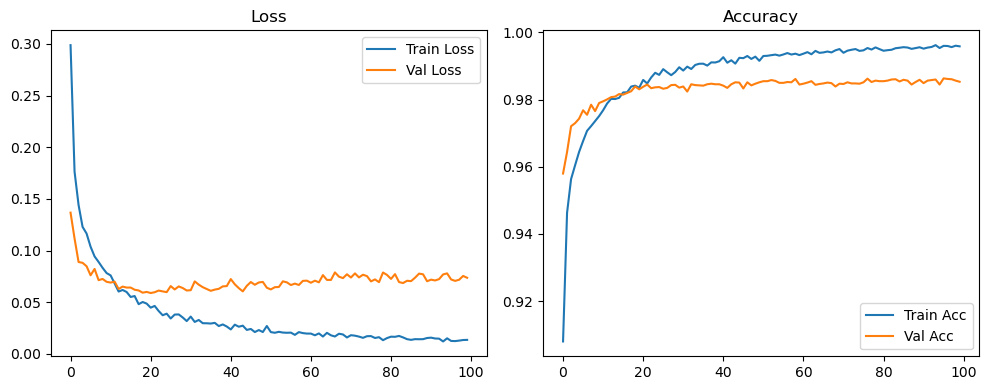

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2532, Acc: 0.9258 | Val Loss: 0.1526, Acc: 0.9544


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1110, Acc: 0.9667 | Val Loss: 0.1066, Acc: 0.9695


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0770, Acc: 0.9764 | Val Loss: 0.0912, Acc: 0.9747


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0637, Acc: 0.9798 | Val Loss: 0.0839, Acc: 0.9749


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0512, Acc: 0.9835 | Val Loss: 0.0997, Acc: 0.9718


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0454, Acc: 0.9854 | Val Loss: 0.0886, Acc: 0.9758


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9877 | Val Loss: 0.1046, Acc: 0.9727


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9881 | Val Loss: 0.0964, Acc: 0.9748


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9885 | Val Loss: 0.0907, Acc: 0.9778


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9904 | Val Loss: 0.0797, Acc: 0.9805


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9928 | Val Loss: 0.0850, Acc: 0.9808


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9920 | Val Loss: 0.0911, Acc: 0.9781


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9928 | Val Loss: 0.1152, Acc: 0.9747


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9927 | Val Loss: 0.0802, Acc: 0.9815


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.0899, Acc: 0.9785


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9931 | Val Loss: 0.0922, Acc: 0.9768


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9946 | Val Loss: 0.0827, Acc: 0.9808


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9951 | Val Loss: 0.0968, Acc: 0.9792


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9951 | Val Loss: 0.0816, Acc: 0.9819


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9953 | Val Loss: 0.0913, Acc: 0.9791


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 0.0963, Acc: 0.9791


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9955 | Val Loss: 0.0818, Acc: 0.9822


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9961 | Val Loss: 0.0948, Acc: 0.9798


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9965 | Val Loss: 0.0920, Acc: 0.9806


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9968 | Val Loss: 0.0782, Acc: 0.9832


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.0843, Acc: 0.9807


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.0790, Acc: 0.9832


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.0806, Acc: 0.9815


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.0802, Acc: 0.9827


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.0753, Acc: 0.9816


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.0848, Acc: 0.9832


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.0885, Acc: 0.9806


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0888, Acc: 0.9828


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9973 | Val Loss: 0.0908, Acc: 0.9816


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0887, Acc: 0.9812


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1029, Acc: 0.9812


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9971 | Val Loss: 0.0879, Acc: 0.9831


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0929, Acc: 0.9813


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.0800, Acc: 0.9836


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.0845, Acc: 0.9828


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0854, Acc: 0.9834


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.0883, Acc: 0.9838


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9979 | Val Loss: 0.0855, Acc: 0.9833


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0930, Acc: 0.9823


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1023, Acc: 0.9808


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0981, Acc: 0.9817


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9984 | Val Loss: 0.0928, Acc: 0.9807


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1117, Acc: 0.9797


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0939, Acc: 0.9828


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0988, Acc: 0.9820


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1042, Acc: 0.9820


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1099, Acc: 0.9797


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1037, Acc: 0.9820


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0979, Acc: 0.9824


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0882, Acc: 0.9841


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1017, Acc: 0.9812


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.1416, Acc: 0.9772


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9982 | Val Loss: 0.0932, Acc: 0.9832


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0934, Acc: 0.9841


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0959, Acc: 0.9840


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1000, Acc: 0.9817


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.0901, Acc: 0.9847


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0900, Acc: 0.9843


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1083, Acc: 0.9824


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0926, Acc: 0.9821


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0906, Acc: 0.9834


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1104, Acc: 0.9815


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0952, Acc: 0.9823


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0913, Acc: 0.9842


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0961, Acc: 0.9834


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.0932, Acc: 0.9843


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0932, Acc: 0.9835


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.0952, Acc: 0.9832


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0988, Acc: 0.9822


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1015, Acc: 0.9822


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0948, Acc: 0.9836


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1159, Acc: 0.9822


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9987 | Val Loss: 0.1100, Acc: 0.9815


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0982, Acc: 0.9826


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1053, Acc: 0.9839


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.1026, Acc: 0.9826


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0990, Acc: 0.9836


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1019, Acc: 0.9842


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9993 | Val Loss: 0.0970, Acc: 0.9835


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1035, Acc: 0.9842


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1039, Acc: 0.9842


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.0967, Acc: 0.9842


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1092, Acc: 0.9843


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9987 | Val Loss: 0.0956, Acc: 0.9842


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.1134, Acc: 0.9830


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1204, Acc: 0.9828


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1123, Acc: 0.9812


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0983, Acc: 0.9834


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1097, Acc: 0.9844


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.0995, Acc: 0.9829


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1000, Acc: 0.9831


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1168, Acc: 0.9816


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1015, Acc: 0.9835


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1059, Acc: 0.9832


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1066, Acc: 0.9816


Final Test Loss: 0.0877 Accuracy: 0.9851


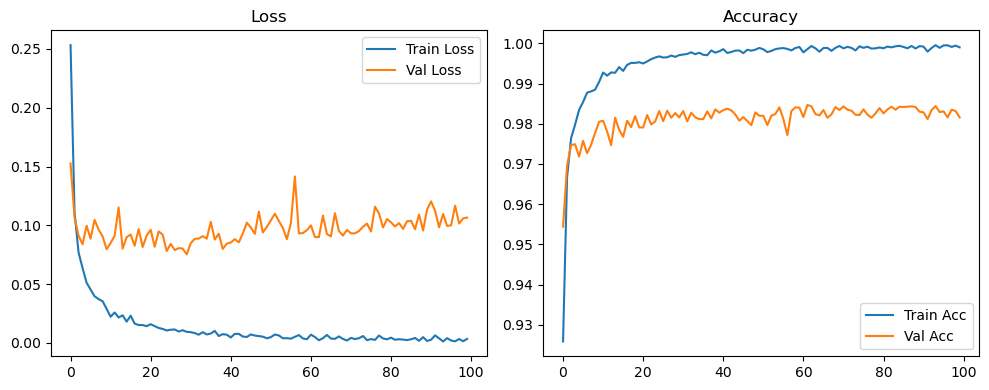

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2617, Acc: 0.9234 | Val Loss: 0.1536, Acc: 0.9549


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1282, Acc: 0.9609 | Val Loss: 0.1080, Acc: 0.9671


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0974, Acc: 0.9706 | Val Loss: 0.0930, Acc: 0.9717


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0775, Acc: 0.9763 | Val Loss: 0.0849, Acc: 0.9748


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0666, Acc: 0.9791 | Val Loss: 0.0907, Acc: 0.9743


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0615, Acc: 0.9804 | Val Loss: 0.0815, Acc: 0.9758


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0540, Acc: 0.9833 | Val Loss: 0.0861, Acc: 0.9775


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9848 | Val Loss: 0.0820, Acc: 0.9762


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9859 | Val Loss: 0.0775, Acc: 0.9793


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9858 | Val Loss: 0.0762, Acc: 0.9789


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9867 | Val Loss: 0.0800, Acc: 0.9798


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9878 | Val Loss: 0.0884, Acc: 0.9779


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9896 | Val Loss: 0.0707, Acc: 0.9809


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9898 | Val Loss: 0.0799, Acc: 0.9811


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9901 | Val Loss: 0.0802, Acc: 0.9815


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9900 | Val Loss: 0.0893, Acc: 0.9773


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9912 | Val Loss: 0.0850, Acc: 0.9792


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9911 | Val Loss: 0.0811, Acc: 0.9809


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9918 | Val Loss: 0.0828, Acc: 0.9802


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9914 | Val Loss: 0.0854, Acc: 0.9805


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9928 | Val Loss: 0.0872, Acc: 0.9785


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9922 | Val Loss: 0.0798, Acc: 0.9823


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9948 | Val Loss: 0.0906, Acc: 0.9791


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9935 | Val Loss: 0.0834, Acc: 0.9813


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9931 | Val Loss: 0.0940, Acc: 0.9788


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9941 | Val Loss: 0.0823, Acc: 0.9815


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.0824, Acc: 0.9826


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9947 | Val Loss: 0.0784, Acc: 0.9840


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9944 | Val Loss: 0.0777, Acc: 0.9818


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9949 | Val Loss: 0.0780, Acc: 0.9828


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9945 | Val Loss: 0.0876, Acc: 0.9818


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 0.1001, Acc: 0.9808


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9949 | Val Loss: 0.0814, Acc: 0.9816


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9953 | Val Loss: 0.1025, Acc: 0.9792


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9954 | Val Loss: 0.0897, Acc: 0.9822


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.0870, Acc: 0.9827


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9958 | Val Loss: 0.1070, Acc: 0.9793


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 0.0916, Acc: 0.9821


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9954 | Val Loss: 0.0765, Acc: 0.9842


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9962 | Val Loss: 0.0830, Acc: 0.9836


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.0897, Acc: 0.9821


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9960 | Val Loss: 0.0939, Acc: 0.9822


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9967 | Val Loss: 0.0946, Acc: 0.9815


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0994, Acc: 0.9832


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9955 | Val Loss: 0.0858, Acc: 0.9821


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.0928, Acc: 0.9820


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0942, Acc: 0.9836


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9962 | Val Loss: 0.0942, Acc: 0.9824


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9965 | Val Loss: 0.1027, Acc: 0.9825


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9963 | Val Loss: 0.0846, Acc: 0.9832


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.0925, Acc: 0.9838


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9966 | Val Loss: 0.0902, Acc: 0.9824


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.0918, Acc: 0.9842


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9969 | Val Loss: 0.0951, Acc: 0.9827


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9976 | Val Loss: 0.0903, Acc: 0.9839


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.0904, Acc: 0.9825


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9970 | Val Loss: 0.0876, Acc: 0.9840


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9976 | Val Loss: 0.0962, Acc: 0.9832


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.0931, Acc: 0.9828


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.1023, Acc: 0.9817


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0869, Acc: 0.9851


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9972 | Val Loss: 0.0908, Acc: 0.9838


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9971 | Val Loss: 0.0881, Acc: 0.9850


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.0920, Acc: 0.9837


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.0987, Acc: 0.9820


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9970 | Val Loss: 0.0793, Acc: 0.9838


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.1004, Acc: 0.9837


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9972 | Val Loss: 0.0882, Acc: 0.9843


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.0920, Acc: 0.9831


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.0955, Acc: 0.9836


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.0920, Acc: 0.9838


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9976 | Val Loss: 0.1080, Acc: 0.9828


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9975 | Val Loss: 0.0928, Acc: 0.9850


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9972 | Val Loss: 0.0887, Acc: 0.9848


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.0941, Acc: 0.9825


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9980 | Val Loss: 0.0947, Acc: 0.9835


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0983, Acc: 0.9838


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9978 | Val Loss: 0.0875, Acc: 0.9842


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9974 | Val Loss: 0.0968, Acc: 0.9844


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1017, Acc: 0.9836


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9972 | Val Loss: 0.1071, Acc: 0.9830


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9976 | Val Loss: 0.1035, Acc: 0.9832


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9979 | Val Loss: 0.1103, Acc: 0.9838


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.0999, Acc: 0.9840


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.1100, Acc: 0.9828


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.1012, Acc: 0.9841


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.1042, Acc: 0.9837


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0958, Acc: 0.9846


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9978 | Val Loss: 0.1055, Acc: 0.9845


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9976 | Val Loss: 0.1059, Acc: 0.9833


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1053, Acc: 0.9840


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.1031, Acc: 0.9834


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9980 | Val Loss: 0.1011, Acc: 0.9837


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1094, Acc: 0.9828


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9975 | Val Loss: 0.1028, Acc: 0.9833


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0982, Acc: 0.9855


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1068, Acc: 0.9842


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9981 | Val Loss: 0.1019, Acc: 0.9846


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9984 | Val Loss: 0.1114, Acc: 0.9829


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0986, Acc: 0.9852


Final Test Loss: 0.1041 Accuracy: 0.9846


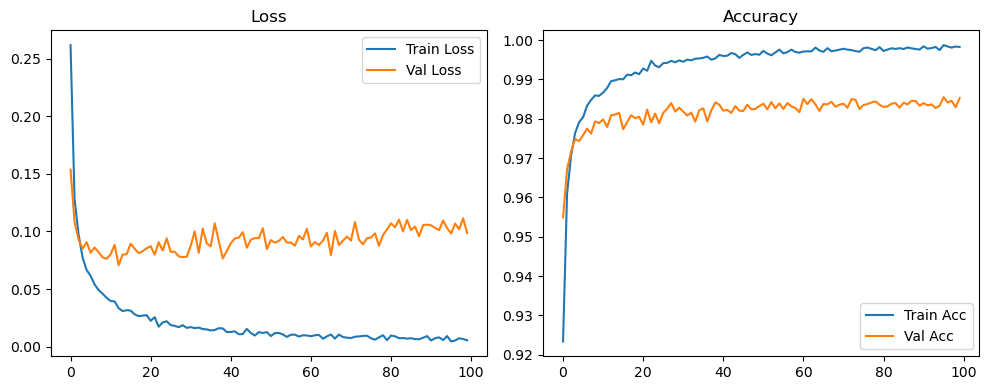

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3383, Acc: 0.9029 | Val Loss: 0.1566, Acc: 0.9544


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1896, Acc: 0.9442 | Val Loss: 0.1128, Acc: 0.9655


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1494, Acc: 0.9561 | Val Loss: 0.0986, Acc: 0.9716


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1299, Acc: 0.9616 | Val Loss: 0.0883, Acc: 0.9742


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1181, Acc: 0.9641 | Val Loss: 0.0931, Acc: 0.9722


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1109, Acc: 0.9668 | Val Loss: 0.0871, Acc: 0.9756


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0984, Acc: 0.9709 | Val Loss: 0.0843, Acc: 0.9752


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0954, Acc: 0.9711 | Val Loss: 0.0840, Acc: 0.9750


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0875, Acc: 0.9740 | Val Loss: 0.0789, Acc: 0.9775


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0872, Acc: 0.9736 | Val Loss: 0.0784, Acc: 0.9777


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0782, Acc: 0.9762 | Val Loss: 0.0721, Acc: 0.9792


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0777, Acc: 0.9756 | Val Loss: 0.0804, Acc: 0.9770


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0716, Acc: 0.9775 | Val Loss: 0.0762, Acc: 0.9786


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0704, Acc: 0.9784 | Val Loss: 0.0730, Acc: 0.9803


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0710, Acc: 0.9788 | Val Loss: 0.0701, Acc: 0.9798


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0620, Acc: 0.9808 | Val Loss: 0.0756, Acc: 0.9793


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0627, Acc: 0.9802 | Val Loss: 0.0744, Acc: 0.9802


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0625, Acc: 0.9811 | Val Loss: 0.0696, Acc: 0.9800


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0588, Acc: 0.9824 | Val Loss: 0.0648, Acc: 0.9832


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0569, Acc: 0.9820 | Val Loss: 0.0689, Acc: 0.9815


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9833 | Val Loss: 0.0698, Acc: 0.9817


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0562, Acc: 0.9832 | Val Loss: 0.0610, Acc: 0.9838


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0515, Acc: 0.9842 | Val Loss: 0.0744, Acc: 0.9805


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0520, Acc: 0.9838 | Val Loss: 0.0694, Acc: 0.9827


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0521, Acc: 0.9846 | Val Loss: 0.0677, Acc: 0.9827


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9866 | Val Loss: 0.0712, Acc: 0.9831


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9854 | Val Loss: 0.0671, Acc: 0.9823


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9863 | Val Loss: 0.0683, Acc: 0.9829


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9868 | Val Loss: 0.0715, Acc: 0.9815


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9871 | Val Loss: 0.0628, Acc: 0.9844


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9875 | Val Loss: 0.0675, Acc: 0.9838


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9881 | Val Loss: 0.0766, Acc: 0.9829


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9864 | Val Loss: 0.0681, Acc: 0.9828


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9881 | Val Loss: 0.0650, Acc: 0.9843


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9884 | Val Loss: 0.0684, Acc: 0.9838


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9885 | Val Loss: 0.0678, Acc: 0.9842


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9880 | Val Loss: 0.0809, Acc: 0.9830


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9892 | Val Loss: 0.0753, Acc: 0.9820


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9889 | Val Loss: 0.0769, Acc: 0.9829


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9893 | Val Loss: 0.0719, Acc: 0.9834


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9894 | Val Loss: 0.0746, Acc: 0.9834


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9891 | Val Loss: 0.0841, Acc: 0.9823


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9895 | Val Loss: 0.0742, Acc: 0.9837


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9903 | Val Loss: 0.0754, Acc: 0.9839


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9910 | Val Loss: 0.0746, Acc: 0.9819


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9905 | Val Loss: 0.0718, Acc: 0.9832


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9904 | Val Loss: 0.0745, Acc: 0.9831


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9903 | Val Loss: 0.0852, Acc: 0.9828


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9912 | Val Loss: 0.0770, Acc: 0.9831


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9916 | Val Loss: 0.0774, Acc: 0.9848


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9911 | Val Loss: 0.0795, Acc: 0.9835


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9918 | Val Loss: 0.0714, Acc: 0.9842


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9921 | Val Loss: 0.0787, Acc: 0.9839


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9905 | Val Loss: 0.0686, Acc: 0.9844


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9918 | Val Loss: 0.0721, Acc: 0.9848


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9918 | Val Loss: 0.0722, Acc: 0.9838


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9920 | Val Loss: 0.0715, Acc: 0.9838


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9917 | Val Loss: 0.0749, Acc: 0.9842


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9921 | Val Loss: 0.0753, Acc: 0.9842


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9934 | Val Loss: 0.0760, Acc: 0.9845


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9926 | Val Loss: 0.0790, Acc: 0.9838


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9929 | Val Loss: 0.0770, Acc: 0.9844


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9928 | Val Loss: 0.0762, Acc: 0.9860


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9921 | Val Loss: 0.0755, Acc: 0.9844


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9920 | Val Loss: 0.0788, Acc: 0.9844


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9920 | Val Loss: 0.0778, Acc: 0.9837


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9925 | Val Loss: 0.0805, Acc: 0.9841


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9922 | Val Loss: 0.0818, Acc: 0.9837


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9919 | Val Loss: 0.0776, Acc: 0.9839


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9932 | Val Loss: 0.0829, Acc: 0.9838


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9925 | Val Loss: 0.0823, Acc: 0.9843


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9930 | Val Loss: 0.0846, Acc: 0.9845


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9932 | Val Loss: 0.0852, Acc: 0.9846


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9932 | Val Loss: 0.0883, Acc: 0.9831


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9932 | Val Loss: 0.0848, Acc: 0.9858


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9930 | Val Loss: 0.0794, Acc: 0.9855


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9928 | Val Loss: 0.0883, Acc: 0.9852


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9932 | Val Loss: 0.0711, Acc: 0.9856


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9932 | Val Loss: 0.0806, Acc: 0.9853


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9939 | Val Loss: 0.0779, Acc: 0.9835


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9940 | Val Loss: 0.0800, Acc: 0.9848


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9932 | Val Loss: 0.0803, Acc: 0.9848


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9936 | Val Loss: 0.0862, Acc: 0.9847


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9935 | Val Loss: 0.0817, Acc: 0.9842


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9942 | Val Loss: 0.0850, Acc: 0.9840


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9938 | Val Loss: 0.0882, Acc: 0.9832


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9931 | Val Loss: 0.0833, Acc: 0.9851


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9937 | Val Loss: 0.0853, Acc: 0.9846


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9941 | Val Loss: 0.0917, Acc: 0.9846


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9939 | Val Loss: 0.0851, Acc: 0.9849


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.0880, Acc: 0.9847


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9939 | Val Loss: 0.0839, Acc: 0.9842


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9946 | Val Loss: 0.0847, Acc: 0.9839


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9935 | Val Loss: 0.0807, Acc: 0.9856


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9942 | Val Loss: 0.0882, Acc: 0.9853


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9948 | Val Loss: 0.0942, Acc: 0.9843


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9946 | Val Loss: 0.0846, Acc: 0.9847


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9944 | Val Loss: 0.0873, Acc: 0.9845


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9936 | Val Loss: 0.0873, Acc: 0.9842


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9950 | Val Loss: 0.0863, Acc: 0.9847


Final Test Loss: 0.0733 Accuracy: 0.9865


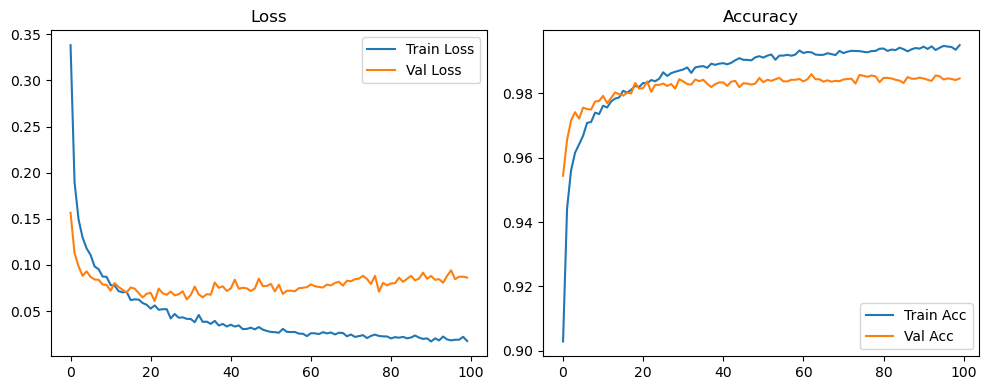

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2532, Acc: 0.9258 | Val Loss: 0.1526, Acc: 0.9544


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1110, Acc: 0.9667 | Val Loss: 0.1066, Acc: 0.9695


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0770, Acc: 0.9764 | Val Loss: 0.0912, Acc: 0.9747


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0637, Acc: 0.9798 | Val Loss: 0.0839, Acc: 0.9749


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0512, Acc: 0.9835 | Val Loss: 0.0997, Acc: 0.9718


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0454, Acc: 0.9854 | Val Loss: 0.0886, Acc: 0.9758


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9877 | Val Loss: 0.1046, Acc: 0.9727


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9881 | Val Loss: 0.0964, Acc: 0.9748


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9885 | Val Loss: 0.0907, Acc: 0.9778


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9904 | Val Loss: 0.0797, Acc: 0.9805


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9928 | Val Loss: 0.0850, Acc: 0.9808


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9920 | Val Loss: 0.0911, Acc: 0.9781


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9928 | Val Loss: 0.1152, Acc: 0.9747


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9927 | Val Loss: 0.0802, Acc: 0.9815


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.0899, Acc: 0.9785


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9931 | Val Loss: 0.0922, Acc: 0.9768


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9946 | Val Loss: 0.0827, Acc: 0.9808


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9951 | Val Loss: 0.0968, Acc: 0.9792


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9951 | Val Loss: 0.0816, Acc: 0.9819


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9953 | Val Loss: 0.0913, Acc: 0.9791


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 0.0963, Acc: 0.9791


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9955 | Val Loss: 0.0818, Acc: 0.9822


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9961 | Val Loss: 0.0948, Acc: 0.9798


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9965 | Val Loss: 0.0920, Acc: 0.9806


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9968 | Val Loss: 0.0782, Acc: 0.9832


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.0843, Acc: 0.9807


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.0790, Acc: 0.9832


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.0806, Acc: 0.9815


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.0802, Acc: 0.9827


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.0753, Acc: 0.9816


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.0848, Acc: 0.9832


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.0885, Acc: 0.9806


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0888, Acc: 0.9828


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9973 | Val Loss: 0.0908, Acc: 0.9816


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0887, Acc: 0.9812


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1029, Acc: 0.9812


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9971 | Val Loss: 0.0879, Acc: 0.9831


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0929, Acc: 0.9813


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.0800, Acc: 0.9836


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.0845, Acc: 0.9828


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0854, Acc: 0.9834


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.0883, Acc: 0.9838


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9979 | Val Loss: 0.0855, Acc: 0.9833


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0930, Acc: 0.9823


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1023, Acc: 0.9808


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0981, Acc: 0.9817


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9984 | Val Loss: 0.0928, Acc: 0.9807


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1117, Acc: 0.9797


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0939, Acc: 0.9828


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0988, Acc: 0.9820


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0916, Acc: 0.9839


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0851, Acc: 0.9847


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0839, Acc: 0.9857


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0937, Acc: 0.9852


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0938, Acc: 0.9852


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0986, Acc: 0.9853


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1011, Acc: 0.9842


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.0984, Acc: 0.9842


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9994 | Val Loss: 0.0971, Acc: 0.9846


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1027, Acc: 0.9834


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0940, Acc: 0.9858


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1036, Acc: 0.9824


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1000, Acc: 0.9834


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1005, Acc: 0.9836


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1067, Acc: 0.9824


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1095, Acc: 0.9844


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1053, Acc: 0.9835


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.1157, Acc: 0.9831


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1012, Acc: 0.9852


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1007, Acc: 0.9858


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1078, Acc: 0.9846


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1086, Acc: 0.9848


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1073, Acc: 0.9828


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1110, Acc: 0.9823


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1099, Acc: 0.9834


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1174, Acc: 0.9823


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1074, Acc: 0.9842


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1085, Acc: 0.9837


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1118, Acc: 0.9828


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1120, Acc: 0.9839


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1101, Acc: 0.9839


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1089, Acc: 0.9846


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1074, Acc: 0.9847


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1081, Acc: 0.9848


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1101, Acc: 0.9842


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1143, Acc: 0.9844


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1108, Acc: 0.9848


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1133, Acc: 0.9852


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1181, Acc: 0.9842


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1195, Acc: 0.9848


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1226, Acc: 0.9843


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1227, Acc: 0.9844


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1190, Acc: 0.9847


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1193, Acc: 0.9849


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1225, Acc: 0.9845


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1263, Acc: 0.9838


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1287, Acc: 0.9842


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1261, Acc: 0.9846


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1244, Acc: 0.9853


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1257, Acc: 0.9852


Final Test Loss: 0.1084 Accuracy: 0.9851


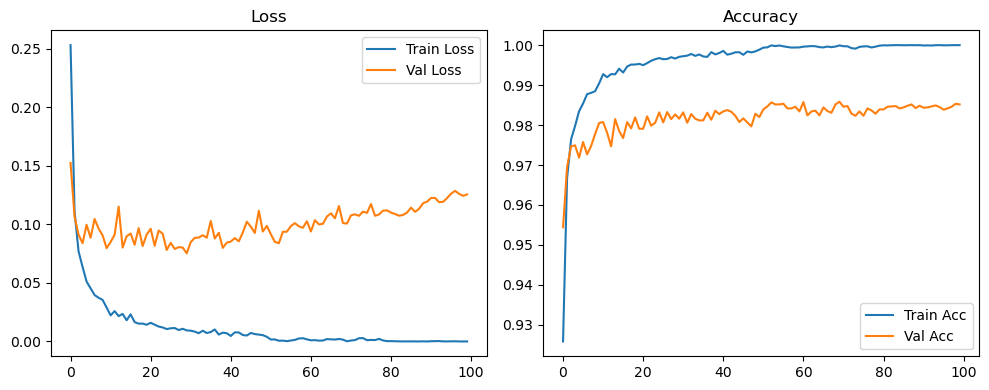

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2617, Acc: 0.9234 | Val Loss: 0.1536, Acc: 0.9549


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1282, Acc: 0.9609 | Val Loss: 0.1080, Acc: 0.9671


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0974, Acc: 0.9706 | Val Loss: 0.0930, Acc: 0.9717


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0775, Acc: 0.9763 | Val Loss: 0.0849, Acc: 0.9748


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0666, Acc: 0.9791 | Val Loss: 0.0907, Acc: 0.9743


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0615, Acc: 0.9804 | Val Loss: 0.0815, Acc: 0.9758


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0540, Acc: 0.9833 | Val Loss: 0.0861, Acc: 0.9775


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9848 | Val Loss: 0.0820, Acc: 0.9762


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9859 | Val Loss: 0.0775, Acc: 0.9793


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9858 | Val Loss: 0.0762, Acc: 0.9789


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9867 | Val Loss: 0.0800, Acc: 0.9798


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9878 | Val Loss: 0.0884, Acc: 0.9779


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9896 | Val Loss: 0.0707, Acc: 0.9809


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9898 | Val Loss: 0.0799, Acc: 0.9811


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9901 | Val Loss: 0.0802, Acc: 0.9815


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9900 | Val Loss: 0.0893, Acc: 0.9773


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9912 | Val Loss: 0.0850, Acc: 0.9792


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9911 | Val Loss: 0.0811, Acc: 0.9809


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9918 | Val Loss: 0.0828, Acc: 0.9802


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9914 | Val Loss: 0.0854, Acc: 0.9805


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9928 | Val Loss: 0.0872, Acc: 0.9785


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9922 | Val Loss: 0.0798, Acc: 0.9823


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9948 | Val Loss: 0.0906, Acc: 0.9791


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9935 | Val Loss: 0.0834, Acc: 0.9813


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9931 | Val Loss: 0.0940, Acc: 0.9788


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9941 | Val Loss: 0.0823, Acc: 0.9815


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.0824, Acc: 0.9826


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9947 | Val Loss: 0.0784, Acc: 0.9840


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9944 | Val Loss: 0.0777, Acc: 0.9818


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9949 | Val Loss: 0.0780, Acc: 0.9828


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9945 | Val Loss: 0.0876, Acc: 0.9818


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 0.1001, Acc: 0.9808


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9949 | Val Loss: 0.0814, Acc: 0.9816


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9953 | Val Loss: 0.1025, Acc: 0.9792


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9954 | Val Loss: 0.0897, Acc: 0.9822


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.0870, Acc: 0.9827


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9958 | Val Loss: 0.1070, Acc: 0.9793


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 0.0916, Acc: 0.9821


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9954 | Val Loss: 0.0765, Acc: 0.9842


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9962 | Val Loss: 0.0830, Acc: 0.9836


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.0897, Acc: 0.9821


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9960 | Val Loss: 0.0939, Acc: 0.9822


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9967 | Val Loss: 0.0946, Acc: 0.9815


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0994, Acc: 0.9832


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9955 | Val Loss: 0.0858, Acc: 0.9821


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.0928, Acc: 0.9820


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0942, Acc: 0.9836


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9962 | Val Loss: 0.0942, Acc: 0.9824


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9965 | Val Loss: 0.1027, Acc: 0.9825


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9963 | Val Loss: 0.0846, Acc: 0.9832


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0792, Acc: 0.9853


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0744, Acc: 0.9856


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.0816, Acc: 0.9855


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0797, Acc: 0.9855


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0797, Acc: 0.9858


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0872, Acc: 0.9853


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0856, Acc: 0.9852


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0866, Acc: 0.9849


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0862, Acc: 0.9858


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0902, Acc: 0.9844


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0905, Acc: 0.9858


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0903, Acc: 0.9852


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0956, Acc: 0.9852


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0993, Acc: 0.9837


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0993, Acc: 0.9854


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0990, Acc: 0.9848


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0960, Acc: 0.9851


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1014, Acc: 0.9852


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0999, Acc: 0.9845


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.0970, Acc: 0.9850


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9988 | Val Loss: 0.0947, Acc: 0.9833


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0948, Acc: 0.9850


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1013, Acc: 0.9832


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.0924, Acc: 0.9852


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0999, Acc: 0.9834


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.0930, Acc: 0.9854


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1044, Acc: 0.9846


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0922, Acc: 0.9850


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1022, Acc: 0.9852


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0942, Acc: 0.9859


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0924, Acc: 0.9855


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0932, Acc: 0.9862


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0869, Acc: 0.9868


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0888, Acc: 0.9871


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0904, Acc: 0.9873


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0938, Acc: 0.9865


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0950, Acc: 0.9863


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0985, Acc: 0.9859


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0970, Acc: 0.9856


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0948, Acc: 0.9853


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0921, Acc: 0.9862


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0995, Acc: 0.9854


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0978, Acc: 0.9863


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1022, Acc: 0.9862


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1024, Acc: 0.9855


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1003, Acc: 0.9862


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.1005, Acc: 0.9867


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1010, Acc: 0.9867


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1051, Acc: 0.9868


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1078, Acc: 0.9856


Final Test Loss: 0.1099 Accuracy: 0.9868


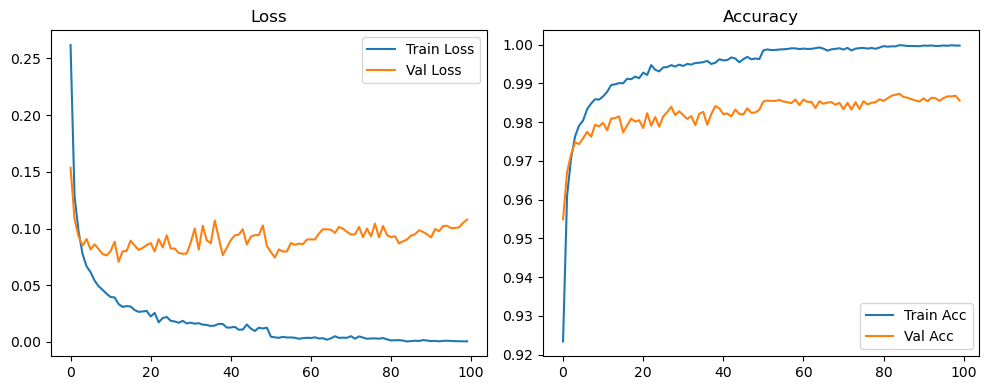

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3383, Acc: 0.9029 | Val Loss: 0.1566, Acc: 0.9544


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1896, Acc: 0.9442 | Val Loss: 0.1128, Acc: 0.9655


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1494, Acc: 0.9561 | Val Loss: 0.0986, Acc: 0.9716


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1299, Acc: 0.9616 | Val Loss: 0.0883, Acc: 0.9742


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1181, Acc: 0.9641 | Val Loss: 0.0931, Acc: 0.9722


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1109, Acc: 0.9668 | Val Loss: 0.0871, Acc: 0.9756


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0984, Acc: 0.9709 | Val Loss: 0.0843, Acc: 0.9752


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0954, Acc: 0.9711 | Val Loss: 0.0840, Acc: 0.9750


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0875, Acc: 0.9740 | Val Loss: 0.0789, Acc: 0.9775


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0872, Acc: 0.9736 | Val Loss: 0.0784, Acc: 0.9777


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0782, Acc: 0.9762 | Val Loss: 0.0721, Acc: 0.9792


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0777, Acc: 0.9756 | Val Loss: 0.0804, Acc: 0.9770


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0716, Acc: 0.9775 | Val Loss: 0.0762, Acc: 0.9786


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0704, Acc: 0.9784 | Val Loss: 0.0730, Acc: 0.9803


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0710, Acc: 0.9788 | Val Loss: 0.0701, Acc: 0.9798


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0620, Acc: 0.9808 | Val Loss: 0.0756, Acc: 0.9793


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0627, Acc: 0.9802 | Val Loss: 0.0744, Acc: 0.9802


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0625, Acc: 0.9811 | Val Loss: 0.0696, Acc: 0.9800


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0588, Acc: 0.9824 | Val Loss: 0.0648, Acc: 0.9832


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0569, Acc: 0.9820 | Val Loss: 0.0689, Acc: 0.9815


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9833 | Val Loss: 0.0698, Acc: 0.9817


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0562, Acc: 0.9832 | Val Loss: 0.0610, Acc: 0.9838


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0515, Acc: 0.9842 | Val Loss: 0.0744, Acc: 0.9805


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0520, Acc: 0.9838 | Val Loss: 0.0694, Acc: 0.9827


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0521, Acc: 0.9846 | Val Loss: 0.0677, Acc: 0.9827


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9866 | Val Loss: 0.0712, Acc: 0.9831


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9854 | Val Loss: 0.0671, Acc: 0.9823


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9863 | Val Loss: 0.0683, Acc: 0.9829


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9868 | Val Loss: 0.0715, Acc: 0.9815


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9871 | Val Loss: 0.0628, Acc: 0.9844


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9875 | Val Loss: 0.0675, Acc: 0.9838


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9881 | Val Loss: 0.0766, Acc: 0.9829


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9864 | Val Loss: 0.0681, Acc: 0.9828


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9881 | Val Loss: 0.0650, Acc: 0.9843


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9884 | Val Loss: 0.0684, Acc: 0.9838


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9885 | Val Loss: 0.0678, Acc: 0.9842


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9880 | Val Loss: 0.0809, Acc: 0.9830


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9892 | Val Loss: 0.0753, Acc: 0.9820


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9889 | Val Loss: 0.0769, Acc: 0.9829


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9893 | Val Loss: 0.0719, Acc: 0.9834


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9894 | Val Loss: 0.0746, Acc: 0.9834


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9891 | Val Loss: 0.0841, Acc: 0.9823


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9895 | Val Loss: 0.0742, Acc: 0.9837


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9903 | Val Loss: 0.0754, Acc: 0.9839


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9910 | Val Loss: 0.0746, Acc: 0.9819


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9905 | Val Loss: 0.0718, Acc: 0.9832


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9904 | Val Loss: 0.0745, Acc: 0.9831


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9903 | Val Loss: 0.0852, Acc: 0.9828


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9912 | Val Loss: 0.0770, Acc: 0.9831


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9916 | Val Loss: 0.0774, Acc: 0.9848


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9937 | Val Loss: 0.0730, Acc: 0.9856


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9947 | Val Loss: 0.0684, Acc: 0.9854


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9952 | Val Loss: 0.0721, Acc: 0.9862


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.0679, Acc: 0.9862


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9962 | Val Loss: 0.0699, Acc: 0.9865


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9961 | Val Loss: 0.0781, Acc: 0.9858


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.0745, Acc: 0.9862


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.0787, Acc: 0.9859


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9960 | Val Loss: 0.0779, Acc: 0.9850


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9957 | Val Loss: 0.0713, Acc: 0.9863


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9964 | Val Loss: 0.0770, Acc: 0.9859


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9958 | Val Loss: 0.0812, Acc: 0.9860


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.0782, Acc: 0.9852


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9958 | Val Loss: 0.0811, Acc: 0.9849


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9961 | Val Loss: 0.0777, Acc: 0.9853


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.0756, Acc: 0.9852


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.0832, Acc: 0.9858


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9961 | Val Loss: 0.0800, Acc: 0.9855


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9963 | Val Loss: 0.0818, Acc: 0.9854


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9968 | Val Loss: 0.0828, Acc: 0.9851


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9957 | Val Loss: 0.0786, Acc: 0.9848


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9964 | Val Loss: 0.0807, Acc: 0.9862


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9961 | Val Loss: 0.0765, Acc: 0.9859


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9966 | Val Loss: 0.0795, Acc: 0.9862


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9964 | Val Loss: 0.0851, Acc: 0.9850


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9961 | Val Loss: 0.0819, Acc: 0.9856


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9967 | Val Loss: 0.0848, Acc: 0.9858


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.0879, Acc: 0.9852


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.0803, Acc: 0.9856


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.0854, Acc: 0.9850


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.0799, Acc: 0.9852


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0803, Acc: 0.9862


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.0830, Acc: 0.9864


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0846, Acc: 0.9858


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0871, Acc: 0.9864


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.0834, Acc: 0.9858


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.0804, Acc: 0.9870


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0841, Acc: 0.9861


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.0844, Acc: 0.9859


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.0817, Acc: 0.9855


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0874, Acc: 0.9857


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0895, Acc: 0.9861


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9983 | Val Loss: 0.0891, Acc: 0.9857


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.0912, Acc: 0.9860


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0895, Acc: 0.9863


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0906, Acc: 0.9862


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0884, Acc: 0.9862


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0881, Acc: 0.9862


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.0857, Acc: 0.9865


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0878, Acc: 0.9867


Final Test Loss: 0.0802 Accuracy: 0.9869


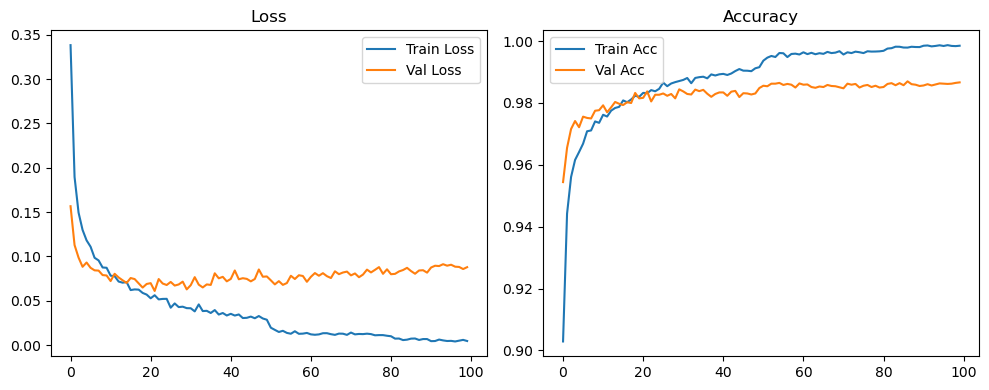

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2532, Acc: 0.9258 | Val Loss: 0.1526, Acc: 0.9544


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1110, Acc: 0.9667 | Val Loss: 0.1066, Acc: 0.9695


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0770, Acc: 0.9764 | Val Loss: 0.0912, Acc: 0.9747


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0637, Acc: 0.9798 | Val Loss: 0.0839, Acc: 0.9749


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0512, Acc: 0.9835 | Val Loss: 0.0997, Acc: 0.9718


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0454, Acc: 0.9854 | Val Loss: 0.0886, Acc: 0.9758


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9877 | Val Loss: 0.1046, Acc: 0.9727


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9881 | Val Loss: 0.0964, Acc: 0.9748


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9885 | Val Loss: 0.0907, Acc: 0.9778


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9904 | Val Loss: 0.0797, Acc: 0.9805


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9928 | Val Loss: 0.0850, Acc: 0.9808


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9920 | Val Loss: 0.0911, Acc: 0.9781


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9928 | Val Loss: 0.1152, Acc: 0.9747


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9927 | Val Loss: 0.0802, Acc: 0.9815


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.0899, Acc: 0.9785


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9931 | Val Loss: 0.0922, Acc: 0.9768


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9946 | Val Loss: 0.0827, Acc: 0.9808


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9951 | Val Loss: 0.0968, Acc: 0.9792


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9951 | Val Loss: 0.0816, Acc: 0.9819


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9953 | Val Loss: 0.0913, Acc: 0.9791


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 0.0963, Acc: 0.9791


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9955 | Val Loss: 0.0818, Acc: 0.9822


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9961 | Val Loss: 0.0948, Acc: 0.9798


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9965 | Val Loss: 0.0920, Acc: 0.9806


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9968 | Val Loss: 0.0782, Acc: 0.9832


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.0843, Acc: 0.9807


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.0790, Acc: 0.9832


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.0806, Acc: 0.9815


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.0802, Acc: 0.9827


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.0753, Acc: 0.9816


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.0848, Acc: 0.9832


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.0885, Acc: 0.9806


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0888, Acc: 0.9828


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9973 | Val Loss: 0.0908, Acc: 0.9816


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0887, Acc: 0.9812


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1029, Acc: 0.9812


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9971 | Val Loss: 0.0879, Acc: 0.9831


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0929, Acc: 0.9813


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.0800, Acc: 0.9836


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.0845, Acc: 0.9828


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0854, Acc: 0.9834


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.0883, Acc: 0.9838


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9979 | Val Loss: 0.0855, Acc: 0.9833


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0930, Acc: 0.9823


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1023, Acc: 0.9808


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0981, Acc: 0.9817


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9984 | Val Loss: 0.0928, Acc: 0.9807


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1117, Acc: 0.9797


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0939, Acc: 0.9828


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0988, Acc: 0.9820


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0916, Acc: 0.9839


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0851, Acc: 0.9847


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0839, Acc: 0.9857


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0937, Acc: 0.9852


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0938, Acc: 0.9852


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0986, Acc: 0.9853


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1011, Acc: 0.9842


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.0984, Acc: 0.9842


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9994 | Val Loss: 0.0971, Acc: 0.9846


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1027, Acc: 0.9834


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0940, Acc: 0.9858


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1036, Acc: 0.9824


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1000, Acc: 0.9834


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1005, Acc: 0.9836


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1067, Acc: 0.9824


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1095, Acc: 0.9844


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1053, Acc: 0.9835


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.1157, Acc: 0.9831


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1012, Acc: 0.9852


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1007, Acc: 0.9858


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1078, Acc: 0.9846


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1086, Acc: 0.9848


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1073, Acc: 0.9828


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1110, Acc: 0.9823


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1099, Acc: 0.9834


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1174, Acc: 0.9823


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1074, Acc: 0.9842


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1085, Acc: 0.9837


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1118, Acc: 0.9828


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1120, Acc: 0.9839


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1103, Acc: 0.9839


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1089, Acc: 0.9843


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1084, Acc: 0.9846


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1091, Acc: 0.9847


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1083, Acc: 0.9845


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1097, Acc: 0.9842


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1077, Acc: 0.9852


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1102, Acc: 0.9849


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1145, Acc: 0.9842


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1141, Acc: 0.9845


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1163, Acc: 0.9845


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1147, Acc: 0.9844


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1121, Acc: 0.9851


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1139, Acc: 0.9852


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1157, Acc: 0.9852


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1165, Acc: 0.9842


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1175, Acc: 0.9841


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1168, Acc: 0.9841


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1165, Acc: 0.9849


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1157, Acc: 0.9849


Final Test Loss: 0.1014 Accuracy: 0.9858


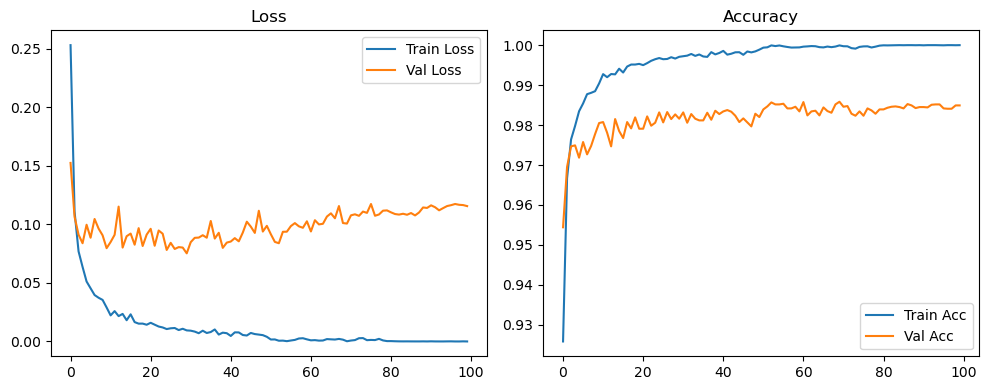

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2617, Acc: 0.9234 | Val Loss: 0.1536, Acc: 0.9549


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1282, Acc: 0.9609 | Val Loss: 0.1080, Acc: 0.9671


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0974, Acc: 0.9706 | Val Loss: 0.0930, Acc: 0.9717


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0775, Acc: 0.9763 | Val Loss: 0.0849, Acc: 0.9748


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0666, Acc: 0.9791 | Val Loss: 0.0907, Acc: 0.9743


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0615, Acc: 0.9804 | Val Loss: 0.0815, Acc: 0.9758


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0540, Acc: 0.9833 | Val Loss: 0.0861, Acc: 0.9775


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9848 | Val Loss: 0.0820, Acc: 0.9762


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9859 | Val Loss: 0.0775, Acc: 0.9793


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9858 | Val Loss: 0.0762, Acc: 0.9789


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9867 | Val Loss: 0.0800, Acc: 0.9798


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9878 | Val Loss: 0.0884, Acc: 0.9779


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9896 | Val Loss: 0.0707, Acc: 0.9809


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9898 | Val Loss: 0.0799, Acc: 0.9811


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9901 | Val Loss: 0.0802, Acc: 0.9815


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9900 | Val Loss: 0.0893, Acc: 0.9773


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9912 | Val Loss: 0.0850, Acc: 0.9792


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9911 | Val Loss: 0.0811, Acc: 0.9809


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9918 | Val Loss: 0.0828, Acc: 0.9802


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9914 | Val Loss: 0.0854, Acc: 0.9805


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9928 | Val Loss: 0.0872, Acc: 0.9785


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9922 | Val Loss: 0.0798, Acc: 0.9823


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9948 | Val Loss: 0.0906, Acc: 0.9791


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9935 | Val Loss: 0.0834, Acc: 0.9813


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9931 | Val Loss: 0.0940, Acc: 0.9788


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9941 | Val Loss: 0.0823, Acc: 0.9815


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.0824, Acc: 0.9826


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9947 | Val Loss: 0.0784, Acc: 0.9840


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9944 | Val Loss: 0.0777, Acc: 0.9818


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9949 | Val Loss: 0.0780, Acc: 0.9828


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9945 | Val Loss: 0.0876, Acc: 0.9818


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 0.1001, Acc: 0.9808


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9949 | Val Loss: 0.0814, Acc: 0.9816


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9953 | Val Loss: 0.1025, Acc: 0.9792


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9954 | Val Loss: 0.0897, Acc: 0.9822


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.0870, Acc: 0.9827


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9958 | Val Loss: 0.1070, Acc: 0.9793


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 0.0916, Acc: 0.9821


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9954 | Val Loss: 0.0765, Acc: 0.9842


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9962 | Val Loss: 0.0830, Acc: 0.9836


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.0897, Acc: 0.9821


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9960 | Val Loss: 0.0939, Acc: 0.9822


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9967 | Val Loss: 0.0946, Acc: 0.9815


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0994, Acc: 0.9832


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9955 | Val Loss: 0.0858, Acc: 0.9821


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.0928, Acc: 0.9820


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0942, Acc: 0.9836


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9962 | Val Loss: 0.0942, Acc: 0.9824


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9965 | Val Loss: 0.1027, Acc: 0.9825


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9963 | Val Loss: 0.0846, Acc: 0.9832


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0792, Acc: 0.9853


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0744, Acc: 0.9856


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.0816, Acc: 0.9855


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0797, Acc: 0.9855


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0797, Acc: 0.9858


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0872, Acc: 0.9853


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0856, Acc: 0.9852


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0866, Acc: 0.9849


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0862, Acc: 0.9858


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0902, Acc: 0.9844


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0905, Acc: 0.9858


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0903, Acc: 0.9852


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0956, Acc: 0.9852


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0993, Acc: 0.9837


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0993, Acc: 0.9854


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0990, Acc: 0.9848


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0960, Acc: 0.9851


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1014, Acc: 0.9852


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0999, Acc: 0.9845


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.0970, Acc: 0.9850


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9988 | Val Loss: 0.0947, Acc: 0.9833


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0948, Acc: 0.9850


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1013, Acc: 0.9832


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.0924, Acc: 0.9852


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0999, Acc: 0.9834


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.0930, Acc: 0.9854


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1044, Acc: 0.9846


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0922, Acc: 0.9850


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1022, Acc: 0.9852


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0942, Acc: 0.9859


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0909, Acc: 0.9861


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0914, Acc: 0.9865


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0874, Acc: 0.9871


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0870, Acc: 0.9868


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0866, Acc: 0.9874


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0877, Acc: 0.9874


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0909, Acc: 0.9873


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0916, Acc: 0.9868


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0937, Acc: 0.9864


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0915, Acc: 0.9858


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0889, Acc: 0.9872


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.0972, Acc: 0.9860


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0958, Acc: 0.9860


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0957, Acc: 0.9868


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0968, Acc: 0.9864


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0924, Acc: 0.9870


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0922, Acc: 0.9868


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0942, Acc: 0.9868


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0954, Acc: 0.9875


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0952, Acc: 0.9872


Final Test Loss: 0.0994 Accuracy: 0.9863


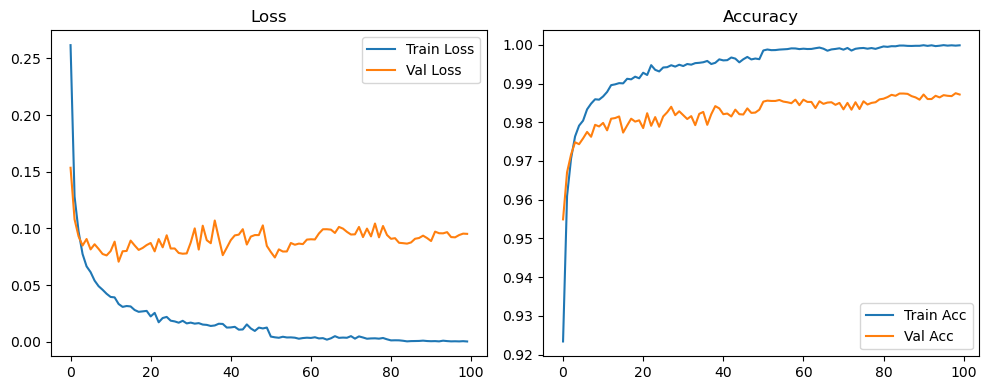

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3383, Acc: 0.9029 | Val Loss: 0.1566, Acc: 0.9544


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1896, Acc: 0.9442 | Val Loss: 0.1128, Acc: 0.9655


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1494, Acc: 0.9561 | Val Loss: 0.0986, Acc: 0.9716


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1299, Acc: 0.9616 | Val Loss: 0.0883, Acc: 0.9742


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1181, Acc: 0.9641 | Val Loss: 0.0931, Acc: 0.9722


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1109, Acc: 0.9668 | Val Loss: 0.0871, Acc: 0.9756


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0984, Acc: 0.9709 | Val Loss: 0.0843, Acc: 0.9752


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0954, Acc: 0.9711 | Val Loss: 0.0840, Acc: 0.9750


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0875, Acc: 0.9740 | Val Loss: 0.0789, Acc: 0.9775


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0872, Acc: 0.9736 | Val Loss: 0.0784, Acc: 0.9777


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0782, Acc: 0.9762 | Val Loss: 0.0721, Acc: 0.9792


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0777, Acc: 0.9756 | Val Loss: 0.0804, Acc: 0.9770


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0716, Acc: 0.9775 | Val Loss: 0.0762, Acc: 0.9786


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0704, Acc: 0.9784 | Val Loss: 0.0730, Acc: 0.9803


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0710, Acc: 0.9788 | Val Loss: 0.0701, Acc: 0.9798


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0620, Acc: 0.9808 | Val Loss: 0.0756, Acc: 0.9793


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0627, Acc: 0.9802 | Val Loss: 0.0744, Acc: 0.9802


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0625, Acc: 0.9811 | Val Loss: 0.0696, Acc: 0.9800


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0588, Acc: 0.9824 | Val Loss: 0.0648, Acc: 0.9832


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0569, Acc: 0.9820 | Val Loss: 0.0689, Acc: 0.9815


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9833 | Val Loss: 0.0698, Acc: 0.9817


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0562, Acc: 0.9832 | Val Loss: 0.0610, Acc: 0.9838


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0515, Acc: 0.9842 | Val Loss: 0.0744, Acc: 0.9805


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0520, Acc: 0.9838 | Val Loss: 0.0694, Acc: 0.9827


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0521, Acc: 0.9846 | Val Loss: 0.0677, Acc: 0.9827


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9866 | Val Loss: 0.0712, Acc: 0.9831


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9854 | Val Loss: 0.0671, Acc: 0.9823


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9863 | Val Loss: 0.0683, Acc: 0.9829


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9868 | Val Loss: 0.0715, Acc: 0.9815


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9871 | Val Loss: 0.0628, Acc: 0.9844


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9875 | Val Loss: 0.0675, Acc: 0.9838


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9881 | Val Loss: 0.0766, Acc: 0.9829


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9864 | Val Loss: 0.0681, Acc: 0.9828


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9881 | Val Loss: 0.0650, Acc: 0.9843


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9884 | Val Loss: 0.0684, Acc: 0.9838


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9885 | Val Loss: 0.0678, Acc: 0.9842


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9880 | Val Loss: 0.0809, Acc: 0.9830


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9892 | Val Loss: 0.0753, Acc: 0.9820


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9889 | Val Loss: 0.0769, Acc: 0.9829


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9893 | Val Loss: 0.0719, Acc: 0.9834


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9894 | Val Loss: 0.0746, Acc: 0.9834


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9891 | Val Loss: 0.0841, Acc: 0.9823


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9895 | Val Loss: 0.0742, Acc: 0.9837


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9903 | Val Loss: 0.0754, Acc: 0.9839


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9910 | Val Loss: 0.0746, Acc: 0.9819


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9905 | Val Loss: 0.0718, Acc: 0.9832


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9904 | Val Loss: 0.0745, Acc: 0.9831


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9903 | Val Loss: 0.0852, Acc: 0.9828


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9912 | Val Loss: 0.0770, Acc: 0.9831


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9916 | Val Loss: 0.0774, Acc: 0.9848


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9937 | Val Loss: 0.0730, Acc: 0.9856


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9947 | Val Loss: 0.0684, Acc: 0.9854


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9952 | Val Loss: 0.0721, Acc: 0.9862


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.0679, Acc: 0.9862


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9962 | Val Loss: 0.0699, Acc: 0.9865


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9961 | Val Loss: 0.0781, Acc: 0.9858


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.0745, Acc: 0.9862


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.0787, Acc: 0.9859


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9960 | Val Loss: 0.0779, Acc: 0.9850


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9957 | Val Loss: 0.0713, Acc: 0.9863


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9964 | Val Loss: 0.0770, Acc: 0.9859


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9958 | Val Loss: 0.0812, Acc: 0.9860


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.0782, Acc: 0.9852


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9958 | Val Loss: 0.0811, Acc: 0.9849


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9961 | Val Loss: 0.0777, Acc: 0.9853


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.0756, Acc: 0.9852


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.0832, Acc: 0.9858


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9961 | Val Loss: 0.0800, Acc: 0.9855


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9963 | Val Loss: 0.0818, Acc: 0.9854


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9968 | Val Loss: 0.0828, Acc: 0.9851


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9957 | Val Loss: 0.0786, Acc: 0.9848


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9964 | Val Loss: 0.0807, Acc: 0.9862


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9961 | Val Loss: 0.0765, Acc: 0.9859


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9966 | Val Loss: 0.0795, Acc: 0.9862


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9964 | Val Loss: 0.0851, Acc: 0.9850


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9961 | Val Loss: 0.0819, Acc: 0.9856


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9967 | Val Loss: 0.0848, Acc: 0.9858


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.0879, Acc: 0.9852


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.0803, Acc: 0.9856


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.0854, Acc: 0.9850


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.0806, Acc: 0.9856


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0801, Acc: 0.9858


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.0821, Acc: 0.9857


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0826, Acc: 0.9860


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0839, Acc: 0.9867


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.0806, Acc: 0.9860


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0789, Acc: 0.9866


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0810, Acc: 0.9859


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.0812, Acc: 0.9866


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9983 | Val Loss: 0.0786, Acc: 0.9865


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0809, Acc: 0.9862


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0843, Acc: 0.9863


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.0849, Acc: 0.9858


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0861, Acc: 0.9863


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0855, Acc: 0.9866


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0863, Acc: 0.9865


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0842, Acc: 0.9863


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0837, Acc: 0.9870


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.0816, Acc: 0.9873


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0842, Acc: 0.9865


Final Test Loss: 0.0786 Accuracy: 0.9873


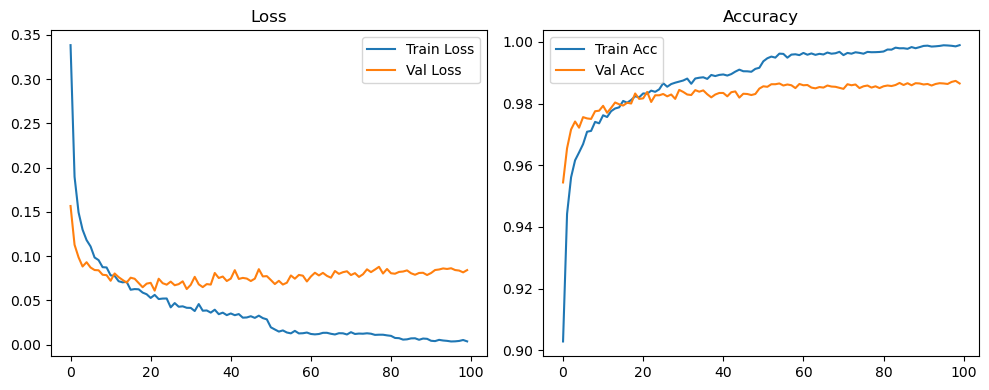

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2532, Acc: 0.9258 | Val Loss: 0.1526, Acc: 0.9544


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1110, Acc: 0.9667 | Val Loss: 0.1066, Acc: 0.9695


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0770, Acc: 0.9764 | Val Loss: 0.0912, Acc: 0.9747


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0637, Acc: 0.9798 | Val Loss: 0.0839, Acc: 0.9749


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0512, Acc: 0.9835 | Val Loss: 0.0997, Acc: 0.9718


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0454, Acc: 0.9854 | Val Loss: 0.0886, Acc: 0.9758


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9877 | Val Loss: 0.1046, Acc: 0.9727


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9881 | Val Loss: 0.0964, Acc: 0.9748


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9885 | Val Loss: 0.0907, Acc: 0.9778


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9904 | Val Loss: 0.0797, Acc: 0.9805


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9928 | Val Loss: 0.0850, Acc: 0.9808


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9920 | Val Loss: 0.0911, Acc: 0.9781


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9928 | Val Loss: 0.1152, Acc: 0.9747


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9927 | Val Loss: 0.0802, Acc: 0.9815


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.0899, Acc: 0.9785


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9931 | Val Loss: 0.0922, Acc: 0.9768


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9946 | Val Loss: 0.0827, Acc: 0.9808


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9951 | Val Loss: 0.0968, Acc: 0.9792


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9951 | Val Loss: 0.0816, Acc: 0.9819


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9953 | Val Loss: 0.0913, Acc: 0.9791


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 0.0963, Acc: 0.9791


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9955 | Val Loss: 0.0818, Acc: 0.9822


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9961 | Val Loss: 0.0948, Acc: 0.9798


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9965 | Val Loss: 0.0920, Acc: 0.9806


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9968 | Val Loss: 0.0782, Acc: 0.9832


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.0843, Acc: 0.9807


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.0790, Acc: 0.9832


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.0806, Acc: 0.9815


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.0802, Acc: 0.9827


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.0753, Acc: 0.9816


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.0848, Acc: 0.9832


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.0885, Acc: 0.9806


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0888, Acc: 0.9828


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9973 | Val Loss: 0.0908, Acc: 0.9816


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0887, Acc: 0.9812


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1029, Acc: 0.9812


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9971 | Val Loss: 0.0879, Acc: 0.9831


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0929, Acc: 0.9813


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.0800, Acc: 0.9836


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.0845, Acc: 0.9828


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0854, Acc: 0.9834


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.0883, Acc: 0.9838


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9979 | Val Loss: 0.0855, Acc: 0.9833


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0930, Acc: 0.9823


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1023, Acc: 0.9808


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0981, Acc: 0.9817


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9984 | Val Loss: 0.0928, Acc: 0.9807


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1117, Acc: 0.9797


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0939, Acc: 0.9828


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0988, Acc: 0.9820


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0882, Acc: 0.9840


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0859, Acc: 0.9848


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0847, Acc: 0.9854


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0849, Acc: 0.9854


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0867, Acc: 0.9846


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0897, Acc: 0.9853


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0897, Acc: 0.9852


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0906, Acc: 0.9855


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0900, Acc: 0.9852


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0889, Acc: 0.9848


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0910, Acc: 0.9857


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0945, Acc: 0.9848


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0913, Acc: 0.9852


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0934, Acc: 0.9851


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0959, Acc: 0.9847


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1022, Acc: 0.9842


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1021, Acc: 0.9844


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1002, Acc: 0.9848


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1027, Acc: 0.9852


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1059, Acc: 0.9842


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0998, Acc: 0.9857


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1066, Acc: 0.9840


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1060, Acc: 0.9847


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1076, Acc: 0.9843


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1040, Acc: 0.9854


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1052, Acc: 0.9851


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1076, Acc: 0.9841


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1070, Acc: 0.9845


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1027, Acc: 0.9849


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1047, Acc: 0.9850


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1023, Acc: 0.9848


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1067, Acc: 0.9849


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1068, Acc: 0.9850


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1049, Acc: 0.9852


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1032, Acc: 0.9852


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1059, Acc: 0.9848


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1052, Acc: 0.9854


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1062, Acc: 0.9852


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1078, Acc: 0.9858


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1083, Acc: 0.9857


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1082, Acc: 0.9859


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1100, Acc: 0.9858


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1116, Acc: 0.9843


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1162, Acc: 0.9846


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1153, Acc: 0.9852


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1108, Acc: 0.9853


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1117, Acc: 0.9852


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1115, Acc: 0.9855


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1155, Acc: 0.9854


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1148, Acc: 0.9849


Final Test Loss: 0.1006 Accuracy: 0.9864


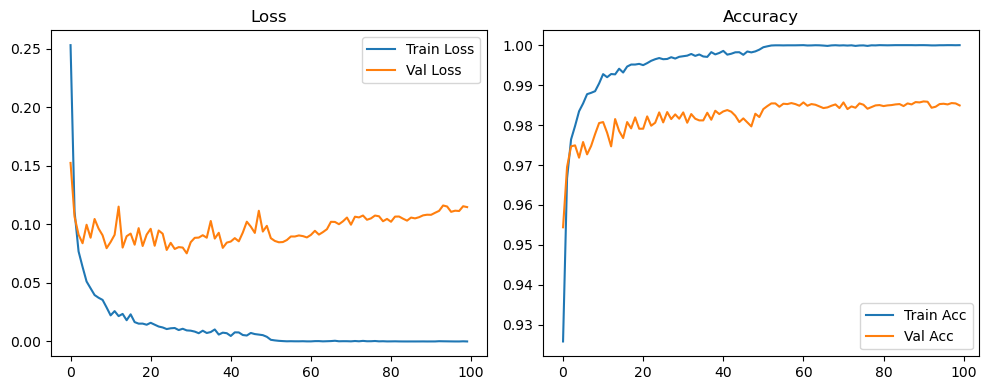

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2617, Acc: 0.9234 | Val Loss: 0.1536, Acc: 0.9549


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1282, Acc: 0.9609 | Val Loss: 0.1080, Acc: 0.9671


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0974, Acc: 0.9706 | Val Loss: 0.0930, Acc: 0.9717


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0775, Acc: 0.9763 | Val Loss: 0.0849, Acc: 0.9748


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0666, Acc: 0.9791 | Val Loss: 0.0907, Acc: 0.9743


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0615, Acc: 0.9804 | Val Loss: 0.0815, Acc: 0.9758


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0540, Acc: 0.9833 | Val Loss: 0.0861, Acc: 0.9775


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9848 | Val Loss: 0.0820, Acc: 0.9762


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9859 | Val Loss: 0.0775, Acc: 0.9793


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9858 | Val Loss: 0.0762, Acc: 0.9789


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9867 | Val Loss: 0.0800, Acc: 0.9798


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9878 | Val Loss: 0.0884, Acc: 0.9779


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9896 | Val Loss: 0.0707, Acc: 0.9809


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9898 | Val Loss: 0.0799, Acc: 0.9811


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9901 | Val Loss: 0.0802, Acc: 0.9815


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9900 | Val Loss: 0.0893, Acc: 0.9773


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9912 | Val Loss: 0.0850, Acc: 0.9792


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9911 | Val Loss: 0.0811, Acc: 0.9809


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9918 | Val Loss: 0.0828, Acc: 0.9802


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9914 | Val Loss: 0.0854, Acc: 0.9805


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9928 | Val Loss: 0.0872, Acc: 0.9785


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9922 | Val Loss: 0.0798, Acc: 0.9823


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9948 | Val Loss: 0.0906, Acc: 0.9791


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9935 | Val Loss: 0.0834, Acc: 0.9813


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9931 | Val Loss: 0.0940, Acc: 0.9788


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9941 | Val Loss: 0.0823, Acc: 0.9815


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.0824, Acc: 0.9826


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9947 | Val Loss: 0.0784, Acc: 0.9840


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9944 | Val Loss: 0.0777, Acc: 0.9818


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9949 | Val Loss: 0.0780, Acc: 0.9828


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9945 | Val Loss: 0.0876, Acc: 0.9818


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 0.1001, Acc: 0.9808


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9949 | Val Loss: 0.0814, Acc: 0.9816


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9953 | Val Loss: 0.1025, Acc: 0.9792


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9954 | Val Loss: 0.0897, Acc: 0.9822


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.0870, Acc: 0.9827


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9958 | Val Loss: 0.1070, Acc: 0.9793


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 0.0916, Acc: 0.9821


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9954 | Val Loss: 0.0765, Acc: 0.9842


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9962 | Val Loss: 0.0830, Acc: 0.9836


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.0897, Acc: 0.9821


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9960 | Val Loss: 0.0939, Acc: 0.9822


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9967 | Val Loss: 0.0946, Acc: 0.9815


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0994, Acc: 0.9832


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9955 | Val Loss: 0.0858, Acc: 0.9821


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.0928, Acc: 0.9820


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0942, Acc: 0.9836


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9962 | Val Loss: 0.0942, Acc: 0.9824


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9965 | Val Loss: 0.1027, Acc: 0.9825


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9963 | Val Loss: 0.0846, Acc: 0.9832


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0763, Acc: 0.9855


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0731, Acc: 0.9868


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.0754, Acc: 0.9867


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0779, Acc: 0.9865


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0805, Acc: 0.9865


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0835, Acc: 0.9858


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0804, Acc: 0.9864


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0832, Acc: 0.9863


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0828, Acc: 0.9864


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0830, Acc: 0.9852


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0845, Acc: 0.9864


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0887, Acc: 0.9867


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0892, Acc: 0.9864


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0956, Acc: 0.9857


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.0955, Acc: 0.9858


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0918, Acc: 0.9858


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0928, Acc: 0.9864


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0909, Acc: 0.9862


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0884, Acc: 0.9870


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0898, Acc: 0.9872


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.0927, Acc: 0.9872


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0950, Acc: 0.9864


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0895, Acc: 0.9868


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0873, Acc: 0.9874


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0921, Acc: 0.9872


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0922, Acc: 0.9868


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0909, Acc: 0.9874


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0885, Acc: 0.9869


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0962, Acc: 0.9863


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0931, Acc: 0.9873


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0883, Acc: 0.9876


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0906, Acc: 0.9878


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0922, Acc: 0.9879


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0909, Acc: 0.9880


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0910, Acc: 0.9877


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0940, Acc: 0.9863


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0941, Acc: 0.9867


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0950, Acc: 0.9863


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0968, Acc: 0.9868


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0981, Acc: 0.9864


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0991, Acc: 0.9871


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1017, Acc: 0.9873


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1084, Acc: 0.9864


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1085, Acc: 0.9863


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1088, Acc: 0.9868


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1049, Acc: 0.9872


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1051, Acc: 0.9866


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1044, Acc: 0.9865


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1016, Acc: 0.9873


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1015, Acc: 0.9872


Final Test Loss: 0.1017 Accuracy: 0.9866


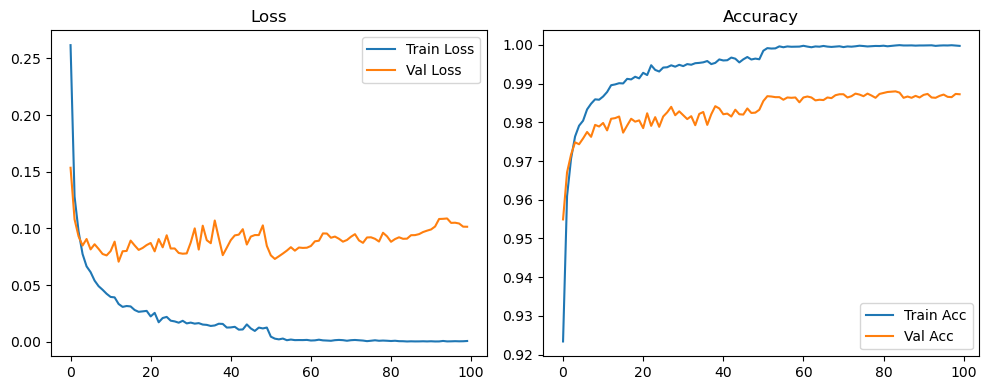

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3383, Acc: 0.9029 | Val Loss: 0.1566, Acc: 0.9544


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1896, Acc: 0.9442 | Val Loss: 0.1128, Acc: 0.9655


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1494, Acc: 0.9561 | Val Loss: 0.0986, Acc: 0.9716


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1299, Acc: 0.9616 | Val Loss: 0.0883, Acc: 0.9742


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1181, Acc: 0.9641 | Val Loss: 0.0931, Acc: 0.9722


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1109, Acc: 0.9668 | Val Loss: 0.0871, Acc: 0.9756


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0984, Acc: 0.9709 | Val Loss: 0.0843, Acc: 0.9752


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0954, Acc: 0.9711 | Val Loss: 0.0840, Acc: 0.9750


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0875, Acc: 0.9740 | Val Loss: 0.0789, Acc: 0.9775


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0872, Acc: 0.9736 | Val Loss: 0.0784, Acc: 0.9777


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0782, Acc: 0.9762 | Val Loss: 0.0721, Acc: 0.9792


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0777, Acc: 0.9756 | Val Loss: 0.0804, Acc: 0.9770


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0716, Acc: 0.9775 | Val Loss: 0.0762, Acc: 0.9786


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0704, Acc: 0.9784 | Val Loss: 0.0730, Acc: 0.9803


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0710, Acc: 0.9788 | Val Loss: 0.0701, Acc: 0.9798


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0620, Acc: 0.9808 | Val Loss: 0.0756, Acc: 0.9793


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0627, Acc: 0.9802 | Val Loss: 0.0744, Acc: 0.9802


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0625, Acc: 0.9811 | Val Loss: 0.0696, Acc: 0.9800


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0588, Acc: 0.9824 | Val Loss: 0.0648, Acc: 0.9832


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0569, Acc: 0.9820 | Val Loss: 0.0689, Acc: 0.9815


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9833 | Val Loss: 0.0698, Acc: 0.9817


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0562, Acc: 0.9832 | Val Loss: 0.0610, Acc: 0.9838


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0515, Acc: 0.9842 | Val Loss: 0.0744, Acc: 0.9805


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0520, Acc: 0.9838 | Val Loss: 0.0694, Acc: 0.9827


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0521, Acc: 0.9846 | Val Loss: 0.0677, Acc: 0.9827


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9866 | Val Loss: 0.0712, Acc: 0.9831


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9854 | Val Loss: 0.0671, Acc: 0.9823


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9863 | Val Loss: 0.0683, Acc: 0.9829


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9868 | Val Loss: 0.0715, Acc: 0.9815


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9871 | Val Loss: 0.0628, Acc: 0.9844


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9875 | Val Loss: 0.0675, Acc: 0.9838


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9881 | Val Loss: 0.0766, Acc: 0.9829


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9864 | Val Loss: 0.0681, Acc: 0.9828


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9881 | Val Loss: 0.0650, Acc: 0.9843


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9884 | Val Loss: 0.0684, Acc: 0.9838


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9885 | Val Loss: 0.0678, Acc: 0.9842


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9880 | Val Loss: 0.0809, Acc: 0.9830


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9892 | Val Loss: 0.0753, Acc: 0.9820


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9889 | Val Loss: 0.0769, Acc: 0.9829


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9893 | Val Loss: 0.0719, Acc: 0.9834


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9894 | Val Loss: 0.0746, Acc: 0.9834


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9891 | Val Loss: 0.0841, Acc: 0.9823


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9895 | Val Loss: 0.0742, Acc: 0.9837


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9903 | Val Loss: 0.0754, Acc: 0.9839


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9910 | Val Loss: 0.0746, Acc: 0.9819


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9905 | Val Loss: 0.0718, Acc: 0.9832


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9904 | Val Loss: 0.0745, Acc: 0.9831


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9903 | Val Loss: 0.0852, Acc: 0.9828


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9912 | Val Loss: 0.0770, Acc: 0.9831


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9916 | Val Loss: 0.0774, Acc: 0.9848


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9938 | Val Loss: 0.0698, Acc: 0.9858


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9954 | Val Loss: 0.0679, Acc: 0.9864


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.0698, Acc: 0.9865


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.0680, Acc: 0.9861


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.0696, Acc: 0.9870


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9968 | Val Loss: 0.0731, Acc: 0.9865


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.0701, Acc: 0.9863


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.0737, Acc: 0.9868


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.0738, Acc: 0.9862


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.0731, Acc: 0.9858


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.0722, Acc: 0.9858


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0727, Acc: 0.9863


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.0732, Acc: 0.9864


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0776, Acc: 0.9853


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9975 | Val Loss: 0.0744, Acc: 0.9860


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.0736, Acc: 0.9864


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9979 | Val Loss: 0.0775, Acc: 0.9862


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0776, Acc: 0.9863


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9976 | Val Loss: 0.0757, Acc: 0.9862


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9980 | Val Loss: 0.0781, Acc: 0.9863


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0816, Acc: 0.9862


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0815, Acc: 0.9874


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0788, Acc: 0.9857


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.0764, Acc: 0.9866


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0762, Acc: 0.9864


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0773, Acc: 0.9862


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0764, Acc: 0.9869


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0766, Acc: 0.9868


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.0789, Acc: 0.9863


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0819, Acc: 0.9858


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.0791, Acc: 0.9858


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0782, Acc: 0.9862


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0814, Acc: 0.9862


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.0805, Acc: 0.9858


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0822, Acc: 0.9859


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0809, Acc: 0.9864


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0812, Acc: 0.9865


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0832, Acc: 0.9868


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0842, Acc: 0.9861


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9983 | Val Loss: 0.0814, Acc: 0.9862


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0817, Acc: 0.9864


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.0834, Acc: 0.9869


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0826, Acc: 0.9862


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0860, Acc: 0.9868


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0873, Acc: 0.9866


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0879, Acc: 0.9866


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0876, Acc: 0.9862


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0852, Acc: 0.9864


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0850, Acc: 0.9862


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0853, Acc: 0.9867


Final Test Loss: 0.0758 Accuracy: 0.9871


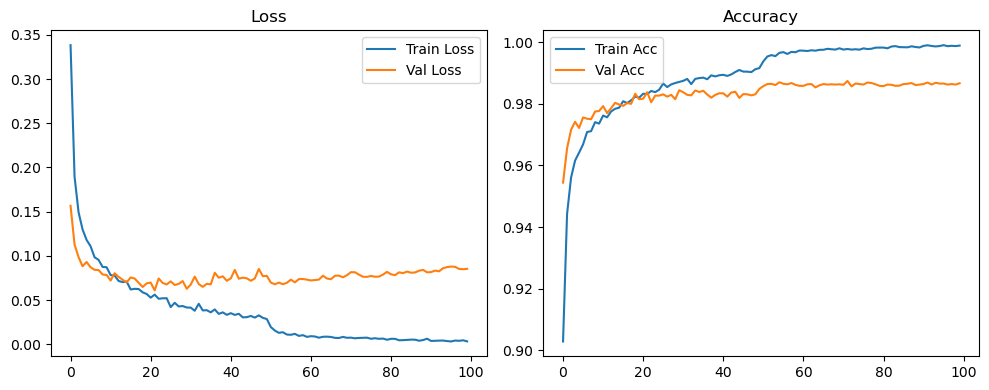

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2225, Acc: 0.9335 | Val Loss: 0.1373, Acc: 0.9580


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1042, Acc: 0.9680 | Val Loss: 0.1128, Acc: 0.9664


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0738, Acc: 0.9772 | Val Loss: 0.0959, Acc: 0.9748


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0569, Acc: 0.9818 | Val Loss: 0.0871, Acc: 0.9757


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0459, Acc: 0.9859 | Val Loss: 0.0900, Acc: 0.9741


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0418, Acc: 0.9870 | Val Loss: 0.0793, Acc: 0.9768


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9883 | Val Loss: 0.0896, Acc: 0.9768


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9898 | Val Loss: 0.0839, Acc: 0.9765


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9911 | Val Loss: 0.0937, Acc: 0.9758


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9923 | Val Loss: 0.0851, Acc: 0.9772


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9916 | Val Loss: 0.0881, Acc: 0.9779


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9930 | Val Loss: 0.0945, Acc: 0.9783


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9938 | Val Loss: 0.0862, Acc: 0.9799


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.0896, Acc: 0.9785


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9939 | Val Loss: 0.0805, Acc: 0.9814


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9940 | Val Loss: 0.1084, Acc: 0.9767


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9950 | Val Loss: 0.0933, Acc: 0.9791


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9942 | Val Loss: 0.0904, Acc: 0.9781


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.0807, Acc: 0.9819


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9960 | Val Loss: 0.0905, Acc: 0.9812


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0980, Acc: 0.9796


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9960 | Val Loss: 0.0796, Acc: 0.9822


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.1048, Acc: 0.9787


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0904, Acc: 0.9788


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9968 | Val Loss: 0.0795, Acc: 0.9828


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9969 | Val Loss: 0.0781, Acc: 0.9816


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.0784, Acc: 0.9823


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0830, Acc: 0.9822


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.0911, Acc: 0.9820


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9970 | Val Loss: 0.0791, Acc: 0.9833


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.0928, Acc: 0.9792


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9975 | Val Loss: 0.0871, Acc: 0.9812


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9981 | Val Loss: 0.0768, Acc: 0.9832


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0997, Acc: 0.9812


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9971 | Val Loss: 0.0772, Acc: 0.9821


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1127, Acc: 0.9773


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9973 | Val Loss: 0.0897, Acc: 0.9818


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0777, Acc: 0.9830


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0798, Acc: 0.9833


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1062, Acc: 0.9807


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.0956, Acc: 0.9814


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0910, Acc: 0.9833


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.0826, Acc: 0.9839


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0869, Acc: 0.9852


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0938, Acc: 0.9816


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0889, Acc: 0.9830


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1091, Acc: 0.9802


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9978 | Val Loss: 0.0960, Acc: 0.9818


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9979 | Val Loss: 0.0826, Acc: 0.9832


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0826, Acc: 0.9848


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0866, Acc: 0.9832


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0885, Acc: 0.9829


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0973, Acc: 0.9835


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1055, Acc: 0.9813


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1040, Acc: 0.9801


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0901, Acc: 0.9832


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0907, Acc: 0.9844


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0997, Acc: 0.9832


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.0859, Acc: 0.9827


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0882, Acc: 0.9832


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0841, Acc: 0.9845


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0975, Acc: 0.9819


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0926, Acc: 0.9834


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0916, Acc: 0.9836


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0950, Acc: 0.9833


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0921, Acc: 0.9846


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0912, Acc: 0.9841


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0924, Acc: 0.9828


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0963, Acc: 0.9832


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0820, Acc: 0.9854


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1006, Acc: 0.9823


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0983, Acc: 0.9833


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1022, Acc: 0.9826


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1041, Acc: 0.9815


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.0990, Acc: 0.9821


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9986 | Val Loss: 0.0919, Acc: 0.9849


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0980, Acc: 0.9829


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0909, Acc: 0.9839


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0953, Acc: 0.9842


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0947, Acc: 0.9838


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0918, Acc: 0.9827


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1039, Acc: 0.9814


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0925, Acc: 0.9835


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1118, Acc: 0.9812


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0915, Acc: 0.9832


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0930, Acc: 0.9845


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0913, Acc: 0.9833


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0955, Acc: 0.9832


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0987, Acc: 0.9823


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0955, Acc: 0.9840


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1004, Acc: 0.9842


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0975, Acc: 0.9837


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0965, Acc: 0.9831


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.0903, Acc: 0.9837


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0933, Acc: 0.9824


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1103, Acc: 0.9825


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1001, Acc: 0.9833


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1058, Acc: 0.9823


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.0981, Acc: 0.9838


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1044, Acc: 0.9828


Final Test Loss: 0.1185 Accuracy: 0.9819


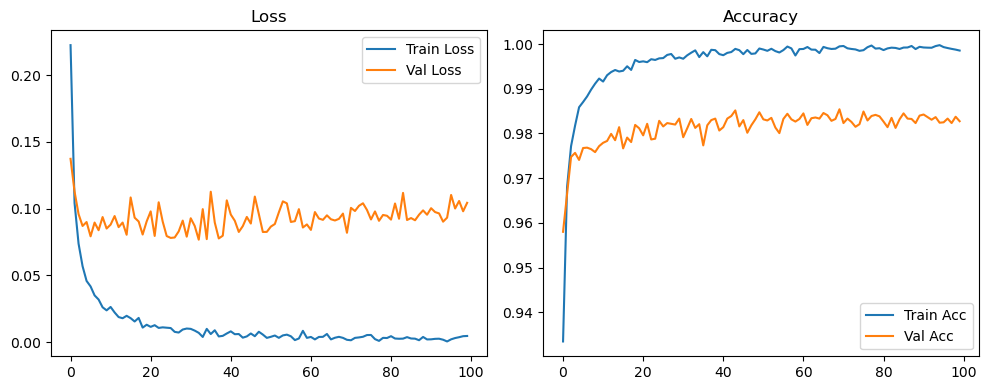

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2396, Acc: 0.9278 | Val Loss: 0.1388, Acc: 0.9572


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1234, Acc: 0.9620 | Val Loss: 0.1069, Acc: 0.9674


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0909, Acc: 0.9724 | Val Loss: 0.0891, Acc: 0.9725


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0705, Acc: 0.9780 | Val Loss: 0.0723, Acc: 0.9778


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0597, Acc: 0.9808 | Val Loss: 0.0874, Acc: 0.9738


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0541, Acc: 0.9823 | Val Loss: 0.0803, Acc: 0.9779


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9849 | Val Loss: 0.0864, Acc: 0.9759


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0419, Acc: 0.9868 | Val Loss: 0.0773, Acc: 0.9783


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9874 | Val Loss: 0.0817, Acc: 0.9772


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9882 | Val Loss: 0.0816, Acc: 0.9778


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9898 | Val Loss: 0.0817, Acc: 0.9789


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9897 | Val Loss: 0.1038, Acc: 0.9755


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9904 | Val Loss: 0.0843, Acc: 0.9798


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9915 | Val Loss: 0.0722, Acc: 0.9812


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9921 | Val Loss: 0.0777, Acc: 0.9806


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9921 | Val Loss: 0.0909, Acc: 0.9776


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9923 | Val Loss: 0.0767, Acc: 0.9825


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9926 | Val Loss: 0.0832, Acc: 0.9810


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9926 | Val Loss: 0.0832, Acc: 0.9809


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9940 | Val Loss: 0.0793, Acc: 0.9822


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9930 | Val Loss: 0.0861, Acc: 0.9802


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9941 | Val Loss: 0.0765, Acc: 0.9828


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9944 | Val Loss: 0.0817, Acc: 0.9810


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9949 | Val Loss: 0.0861, Acc: 0.9810


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.0916, Acc: 0.9798


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9952 | Val Loss: 0.0822, Acc: 0.9829


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9954 | Val Loss: 0.0805, Acc: 0.9822


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9946 | Val Loss: 0.0857, Acc: 0.9832


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.0904, Acc: 0.9818


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.0974, Acc: 0.9813


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.0899, Acc: 0.9822


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.0888, Acc: 0.9826


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9958 | Val Loss: 0.0868, Acc: 0.9823


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.0947, Acc: 0.9824


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.0925, Acc: 0.9819


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.0910, Acc: 0.9833


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.0875, Acc: 0.9817


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0883, Acc: 0.9832


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9964 | Val Loss: 0.0879, Acc: 0.9827


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.0973, Acc: 0.9794


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.0993, Acc: 0.9813


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9964 | Val Loss: 0.0920, Acc: 0.9837


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.0843, Acc: 0.9848


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0966, Acc: 0.9828


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9971 | Val Loss: 0.0977, Acc: 0.9820


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.0953, Acc: 0.9820


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.0738, Acc: 0.9846


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.0900, Acc: 0.9832


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9971 | Val Loss: 0.0897, Acc: 0.9834


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.0885, Acc: 0.9834


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0929, Acc: 0.9822


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.0965, Acc: 0.9835


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9979 | Val Loss: 0.0849, Acc: 0.9855


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.0870, Acc: 0.9836


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.0846, Acc: 0.9824


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9974 | Val Loss: 0.0908, Acc: 0.9824


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0876, Acc: 0.9859


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.0899, Acc: 0.9839


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1010, Acc: 0.9826


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.0908, Acc: 0.9838


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.0842, Acc: 0.9853


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0884, Acc: 0.9840


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0872, Acc: 0.9850


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0927, Acc: 0.9834


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9980 | Val Loss: 0.0901, Acc: 0.9838


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.0863, Acc: 0.9840


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.0976, Acc: 0.9833


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.0954, Acc: 0.9822


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0975, Acc: 0.9832


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0920, Acc: 0.9842


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9978 | Val Loss: 0.0973, Acc: 0.9834


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0979, Acc: 0.9830


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0969, Acc: 0.9830


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0892, Acc: 0.9848


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.0965, Acc: 0.9833


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.0866, Acc: 0.9852


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0898, Acc: 0.9846


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0857, Acc: 0.9848


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.0872, Acc: 0.9843


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0952, Acc: 0.9844


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.0953, Acc: 0.9841


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.0888, Acc: 0.9844


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0902, Acc: 0.9846


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.0905, Acc: 0.9846


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.0988, Acc: 0.9830


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0975, Acc: 0.9833


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0990, Acc: 0.9824


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1056, Acc: 0.9832


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0951, Acc: 0.9850


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.0959, Acc: 0.9854


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1040, Acc: 0.9848


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1023, Acc: 0.9838


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1008, Acc: 0.9831


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0958, Acc: 0.9838


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1049, Acc: 0.9835


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.0948, Acc: 0.9843


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1007, Acc: 0.9832


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0986, Acc: 0.9844


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1098, Acc: 0.9832


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1100, Acc: 0.9834


Final Test Loss: 0.1029 Accuracy: 0.9843


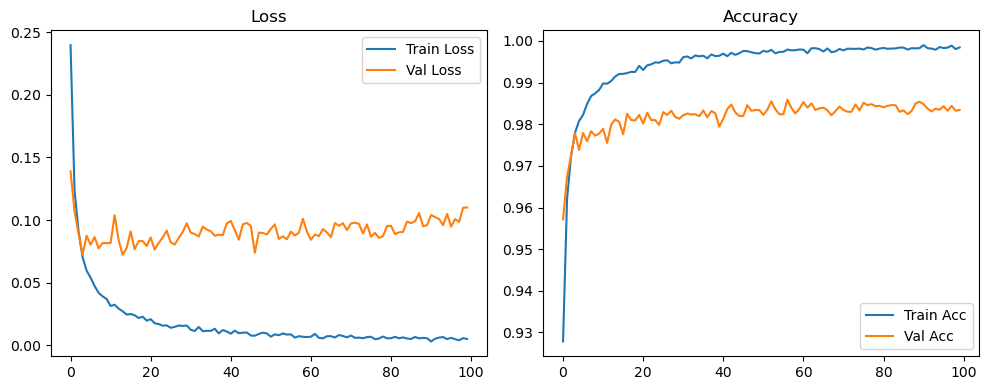

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3070, Acc: 0.9083 | Val Loss: 0.1523, Acc: 0.9554


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1829, Acc: 0.9454 | Val Loss: 0.1067, Acc: 0.9683


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1421, Acc: 0.9577 | Val Loss: 0.0891, Acc: 0.9738


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1189, Acc: 0.9643 | Val Loss: 0.0849, Acc: 0.9758


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1033, Acc: 0.9685 | Val Loss: 0.0873, Acc: 0.9741


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0980, Acc: 0.9700 | Val Loss: 0.0782, Acc: 0.9773


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0883, Acc: 0.9728 | Val Loss: 0.0870, Acc: 0.9739


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0823, Acc: 0.9734 | Val Loss: 0.0805, Acc: 0.9774


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0759, Acc: 0.9766 | Val Loss: 0.0784, Acc: 0.9775


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0714, Acc: 0.9780 | Val Loss: 0.0740, Acc: 0.9774


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0639, Acc: 0.9798 | Val Loss: 0.0703, Acc: 0.9806


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0641, Acc: 0.9803 | Val Loss: 0.0773, Acc: 0.9798


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0647, Acc: 0.9798 | Val Loss: 0.0693, Acc: 0.9801


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0590, Acc: 0.9819 | Val Loss: 0.0708, Acc: 0.9812


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0565, Acc: 0.9819 | Val Loss: 0.0687, Acc: 0.9807


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0559, Acc: 0.9826 | Val Loss: 0.0630, Acc: 0.9816


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0524, Acc: 0.9833 | Val Loss: 0.0748, Acc: 0.9800


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0501, Acc: 0.9841 | Val Loss: 0.0682, Acc: 0.9813


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0471, Acc: 0.9847 | Val Loss: 0.0662, Acc: 0.9825


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0483, Acc: 0.9852 | Val Loss: 0.0686, Acc: 0.9818


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9844 | Val Loss: 0.0733, Acc: 0.9803


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9863 | Val Loss: 0.0690, Acc: 0.9821


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0392, Acc: 0.9878 | Val Loss: 0.0695, Acc: 0.9810


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0389, Acc: 0.9874 | Val Loss: 0.0740, Acc: 0.9814


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0410, Acc: 0.9869 | Val Loss: 0.0727, Acc: 0.9810


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9886 | Val Loss: 0.0653, Acc: 0.9828


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0396, Acc: 0.9876 | Val Loss: 0.0691, Acc: 0.9828


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0348, Acc: 0.9895 | Val Loss: 0.0675, Acc: 0.9835


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9885 | Val Loss: 0.0676, Acc: 0.9832


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0342, Acc: 0.9894 | Val Loss: 0.0674, Acc: 0.9827


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9888 | Val Loss: 0.0760, Acc: 0.9830


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9891 | Val Loss: 0.0731, Acc: 0.9822


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9897 | Val Loss: 0.0753, Acc: 0.9828


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9903 | Val Loss: 0.0679, Acc: 0.9842


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0335, Acc: 0.9897 | Val Loss: 0.0732, Acc: 0.9838


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9914 | Val Loss: 0.0689, Acc: 0.9847


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0304, Acc: 0.9901 | Val Loss: 0.0734, Acc: 0.9828


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9912 | Val Loss: 0.0670, Acc: 0.9841


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9904 | Val Loss: 0.0763, Acc: 0.9839


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9910 | Val Loss: 0.0676, Acc: 0.9833


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9918 | Val Loss: 0.0729, Acc: 0.9840


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9917 | Val Loss: 0.0710, Acc: 0.9833


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9918 | Val Loss: 0.0681, Acc: 0.9843


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9924 | Val Loss: 0.0754, Acc: 0.9826


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9917 | Val Loss: 0.0716, Acc: 0.9834


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9916 | Val Loss: 0.0724, Acc: 0.9822


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9923 | Val Loss: 0.0758, Acc: 0.9838


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9919 | Val Loss: 0.0768, Acc: 0.9829


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9926 | Val Loss: 0.0708, Acc: 0.9844


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0235, Acc: 0.9927 | Val Loss: 0.0724, Acc: 0.9834


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9933 | Val Loss: 0.0747, Acc: 0.9838


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9924 | Val Loss: 0.0727, Acc: 0.9841


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9931 | Val Loss: 0.0719, Acc: 0.9851


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9929 | Val Loss: 0.0715, Acc: 0.9838


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9928 | Val Loss: 0.0732, Acc: 0.9834


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9934 | Val Loss: 0.0735, Acc: 0.9840


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9933 | Val Loss: 0.0714, Acc: 0.9843


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9937 | Val Loss: 0.0720, Acc: 0.9839


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9934 | Val Loss: 0.0753, Acc: 0.9838


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0226, Acc: 0.9936 | Val Loss: 0.0724, Acc: 0.9832


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9939 | Val Loss: 0.0789, Acc: 0.9842


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9939 | Val Loss: 0.0764, Acc: 0.9838


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9938 | Val Loss: 0.0750, Acc: 0.9841


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9938 | Val Loss: 0.0725, Acc: 0.9844


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9937 | Val Loss: 0.0717, Acc: 0.9855


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9949 | Val Loss: 0.0771, Acc: 0.9845


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9938 | Val Loss: 0.0757, Acc: 0.9838


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9939 | Val Loss: 0.0736, Acc: 0.9846


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9951 | Val Loss: 0.0743, Acc: 0.9850


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9937 | Val Loss: 0.0724, Acc: 0.9845


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9940 | Val Loss: 0.0726, Acc: 0.9849


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9949 | Val Loss: 0.0717, Acc: 0.9855


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9949 | Val Loss: 0.0747, Acc: 0.9847


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9941 | Val Loss: 0.0738, Acc: 0.9852


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9946 | Val Loss: 0.0773, Acc: 0.9845


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9940 | Val Loss: 0.0736, Acc: 0.9852


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9951 | Val Loss: 0.0745, Acc: 0.9858


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9945 | Val Loss: 0.0720, Acc: 0.9853


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9947 | Val Loss: 0.0676, Acc: 0.9858


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9946 | Val Loss: 0.0755, Acc: 0.9848


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9950 | Val Loss: 0.0753, Acc: 0.9842


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9953 | Val Loss: 0.0833, Acc: 0.9842


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9948 | Val Loss: 0.0781, Acc: 0.9848


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9951 | Val Loss: 0.0750, Acc: 0.9848


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9952 | Val Loss: 0.0763, Acc: 0.9842


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9944 | Val Loss: 0.0807, Acc: 0.9845


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9955 | Val Loss: 0.0802, Acc: 0.9848


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.0748, Acc: 0.9850


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9952 | Val Loss: 0.0819, Acc: 0.9853


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.0797, Acc: 0.9843


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9951 | Val Loss: 0.0761, Acc: 0.9844


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9953 | Val Loss: 0.0685, Acc: 0.9859


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9951 | Val Loss: 0.0714, Acc: 0.9852


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.0808, Acc: 0.9857


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9954 | Val Loss: 0.0755, Acc: 0.9837


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9952 | Val Loss: 0.0766, Acc: 0.9853


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9963 | Val Loss: 0.0834, Acc: 0.9840


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9950 | Val Loss: 0.0823, Acc: 0.9858


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9952 | Val Loss: 0.0774, Acc: 0.9858


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9957 | Val Loss: 0.0751, Acc: 0.9857


Final Test Loss: 0.0721 Accuracy: 0.9869


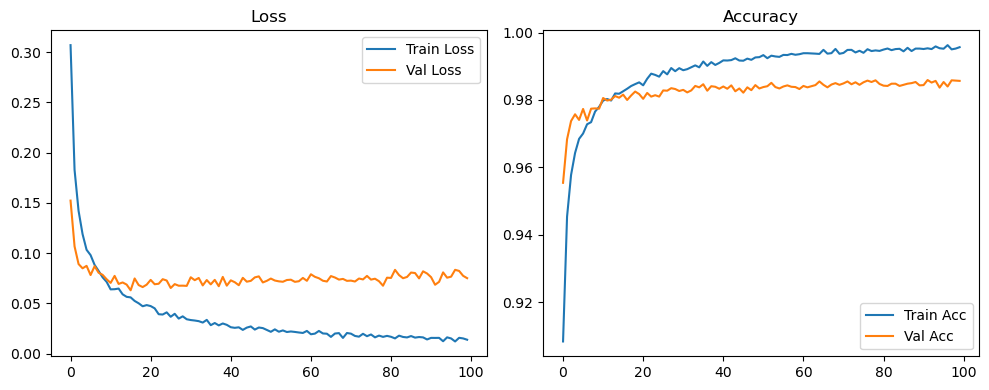

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2225, Acc: 0.9335 | Val Loss: 0.1373, Acc: 0.9580


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1042, Acc: 0.9680 | Val Loss: 0.1128, Acc: 0.9664


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0738, Acc: 0.9772 | Val Loss: 0.0959, Acc: 0.9748


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0569, Acc: 0.9818 | Val Loss: 0.0871, Acc: 0.9757


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0459, Acc: 0.9859 | Val Loss: 0.0900, Acc: 0.9741


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0418, Acc: 0.9870 | Val Loss: 0.0793, Acc: 0.9768


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9883 | Val Loss: 0.0896, Acc: 0.9768


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9898 | Val Loss: 0.0839, Acc: 0.9765


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9911 | Val Loss: 0.0937, Acc: 0.9758


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9923 | Val Loss: 0.0851, Acc: 0.9772


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9916 | Val Loss: 0.0881, Acc: 0.9779


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9930 | Val Loss: 0.0945, Acc: 0.9783


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9938 | Val Loss: 0.0862, Acc: 0.9799


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.0896, Acc: 0.9785


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9939 | Val Loss: 0.0805, Acc: 0.9814


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9940 | Val Loss: 0.1084, Acc: 0.9767


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9950 | Val Loss: 0.0933, Acc: 0.9791


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9942 | Val Loss: 0.0904, Acc: 0.9781


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.0807, Acc: 0.9819


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9960 | Val Loss: 0.0905, Acc: 0.9812


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0980, Acc: 0.9796


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9960 | Val Loss: 0.0796, Acc: 0.9822


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.1048, Acc: 0.9787


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0904, Acc: 0.9788


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9968 | Val Loss: 0.0795, Acc: 0.9828


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9969 | Val Loss: 0.0781, Acc: 0.9816


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.0784, Acc: 0.9823


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0830, Acc: 0.9822


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.0911, Acc: 0.9820


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9970 | Val Loss: 0.0791, Acc: 0.9833


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.0928, Acc: 0.9792


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9975 | Val Loss: 0.0871, Acc: 0.9812


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9981 | Val Loss: 0.0768, Acc: 0.9832


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0997, Acc: 0.9812


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9971 | Val Loss: 0.0772, Acc: 0.9821


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1127, Acc: 0.9773


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9973 | Val Loss: 0.0897, Acc: 0.9818


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0777, Acc: 0.9830


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0798, Acc: 0.9833


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1062, Acc: 0.9807


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.0956, Acc: 0.9814


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0910, Acc: 0.9833


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.0826, Acc: 0.9839


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0869, Acc: 0.9852


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0938, Acc: 0.9816


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0889, Acc: 0.9830


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1091, Acc: 0.9802


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9978 | Val Loss: 0.0960, Acc: 0.9818


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9979 | Val Loss: 0.0826, Acc: 0.9832


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0826, Acc: 0.9848


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0793, Acc: 0.9854


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0778, Acc: 0.9859


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0789, Acc: 0.9858


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0804, Acc: 0.9867


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0805, Acc: 0.9869


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0862, Acc: 0.9854


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0837, Acc: 0.9861


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0848, Acc: 0.9862


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0835, Acc: 0.9868


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0943, Acc: 0.9858


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1021, Acc: 0.9848


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1197, Acc: 0.9827


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0992, Acc: 0.9851


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0951, Acc: 0.9855


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1019, Acc: 0.9841


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0984, Acc: 0.9846


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0937, Acc: 0.9847


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1088, Acc: 0.9838


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1069, Acc: 0.9839


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1036, Acc: 0.9852


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1017, Acc: 0.9850


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1045, Acc: 0.9853


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1001, Acc: 0.9854


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1027, Acc: 0.9847


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1027, Acc: 0.9854


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1086, Acc: 0.9840


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1034, Acc: 0.9841


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1104, Acc: 0.9837


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1026, Acc: 0.9851


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1010, Acc: 0.9858


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0998, Acc: 0.9858


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1016, Acc: 0.9855


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1012, Acc: 0.9858


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1008, Acc: 0.9858


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1007, Acc: 0.9855


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1017, Acc: 0.9861


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1020, Acc: 0.9858


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1018, Acc: 0.9859


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0993, Acc: 0.9855


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0971, Acc: 0.9855


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1021, Acc: 0.9855


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1044, Acc: 0.9852


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1028, Acc: 0.9852


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1069, Acc: 0.9848


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1037, Acc: 0.9855


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1024, Acc: 0.9852


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1028, Acc: 0.9859


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1025, Acc: 0.9858


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1117, Acc: 0.9856


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1034, Acc: 0.9865


Final Test Loss: 0.1119 Accuracy: 0.9862


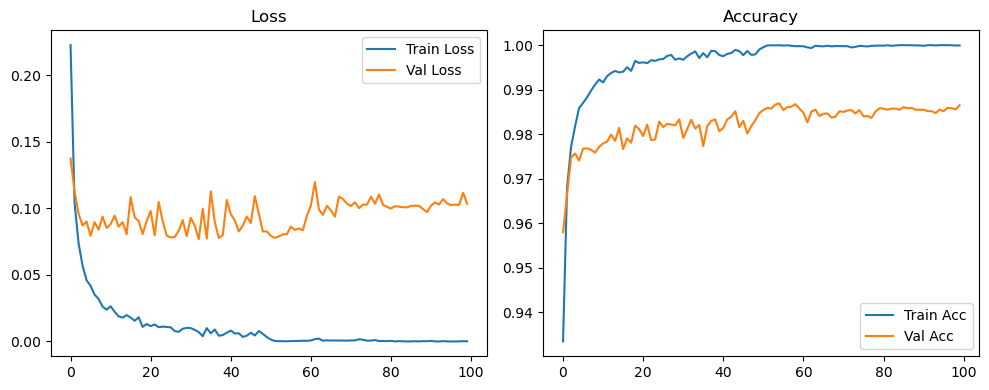

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2396, Acc: 0.9278 | Val Loss: 0.1388, Acc: 0.9572


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1234, Acc: 0.9620 | Val Loss: 0.1069, Acc: 0.9674


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0909, Acc: 0.9724 | Val Loss: 0.0891, Acc: 0.9725


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0705, Acc: 0.9780 | Val Loss: 0.0723, Acc: 0.9778


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0597, Acc: 0.9808 | Val Loss: 0.0874, Acc: 0.9738


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0541, Acc: 0.9823 | Val Loss: 0.0803, Acc: 0.9779


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9849 | Val Loss: 0.0864, Acc: 0.9759


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0419, Acc: 0.9868 | Val Loss: 0.0773, Acc: 0.9783


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9874 | Val Loss: 0.0817, Acc: 0.9772


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9882 | Val Loss: 0.0816, Acc: 0.9778


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9898 | Val Loss: 0.0817, Acc: 0.9789


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9897 | Val Loss: 0.1038, Acc: 0.9755


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9904 | Val Loss: 0.0843, Acc: 0.9798


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9915 | Val Loss: 0.0722, Acc: 0.9812


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9921 | Val Loss: 0.0777, Acc: 0.9806


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9921 | Val Loss: 0.0909, Acc: 0.9776


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9923 | Val Loss: 0.0767, Acc: 0.9825


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9926 | Val Loss: 0.0832, Acc: 0.9810


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9926 | Val Loss: 0.0832, Acc: 0.9809


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9940 | Val Loss: 0.0793, Acc: 0.9822


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9930 | Val Loss: 0.0861, Acc: 0.9802


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9941 | Val Loss: 0.0765, Acc: 0.9828


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9944 | Val Loss: 0.0817, Acc: 0.9810


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9949 | Val Loss: 0.0861, Acc: 0.9810


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.0916, Acc: 0.9798


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9952 | Val Loss: 0.0822, Acc: 0.9829


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9954 | Val Loss: 0.0805, Acc: 0.9822


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9946 | Val Loss: 0.0857, Acc: 0.9832


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.0904, Acc: 0.9818


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.0974, Acc: 0.9813


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.0899, Acc: 0.9822


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.0888, Acc: 0.9826


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9958 | Val Loss: 0.0868, Acc: 0.9823


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.0947, Acc: 0.9824


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.0925, Acc: 0.9819


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.0910, Acc: 0.9833


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.0875, Acc: 0.9817


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0883, Acc: 0.9832


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9964 | Val Loss: 0.0879, Acc: 0.9827


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.0973, Acc: 0.9794


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.0993, Acc: 0.9813


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9964 | Val Loss: 0.0920, Acc: 0.9837


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.0843, Acc: 0.9848


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0966, Acc: 0.9828


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9971 | Val Loss: 0.0977, Acc: 0.9820


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.0953, Acc: 0.9820


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.0738, Acc: 0.9846


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.0900, Acc: 0.9832


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9971 | Val Loss: 0.0897, Acc: 0.9834


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.0885, Acc: 0.9834


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0751, Acc: 0.9854


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0726, Acc: 0.9866


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0802, Acc: 0.9857


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0850, Acc: 0.9857


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0898, Acc: 0.9848


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0875, Acc: 0.9852


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0862, Acc: 0.9859


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0880, Acc: 0.9856


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0916, Acc: 0.9853


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0927, Acc: 0.9858


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0977, Acc: 0.9861


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0944, Acc: 0.9851


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1050, Acc: 0.9836


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0947, Acc: 0.9858


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0943, Acc: 0.9858


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0953, Acc: 0.9858


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.1074, Acc: 0.9850


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0962, Acc: 0.9862


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0988, Acc: 0.9852


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0987, Acc: 0.9854


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0958, Acc: 0.9861


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0951, Acc: 0.9867


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0940, Acc: 0.9859


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1001, Acc: 0.9852


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0941, Acc: 0.9858


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0968, Acc: 0.9852


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0921, Acc: 0.9858


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0956, Acc: 0.9854


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0993, Acc: 0.9857


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0980, Acc: 0.9852


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0948, Acc: 0.9859


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0965, Acc: 0.9862


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0990, Acc: 0.9856


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0966, Acc: 0.9868


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0971, Acc: 0.9866


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0957, Acc: 0.9866


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0979, Acc: 0.9862


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0954, Acc: 0.9863


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0978, Acc: 0.9856


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0933, Acc: 0.9863


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0981, Acc: 0.9858


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0955, Acc: 0.9868


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1040, Acc: 0.9864


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1012, Acc: 0.9865


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1040, Acc: 0.9856


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1006, Acc: 0.9862


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1031, Acc: 0.9865


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1020, Acc: 0.9862


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.1050, Acc: 0.9862


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1028, Acc: 0.9859


Final Test Loss: 0.1100 Accuracy: 0.9857


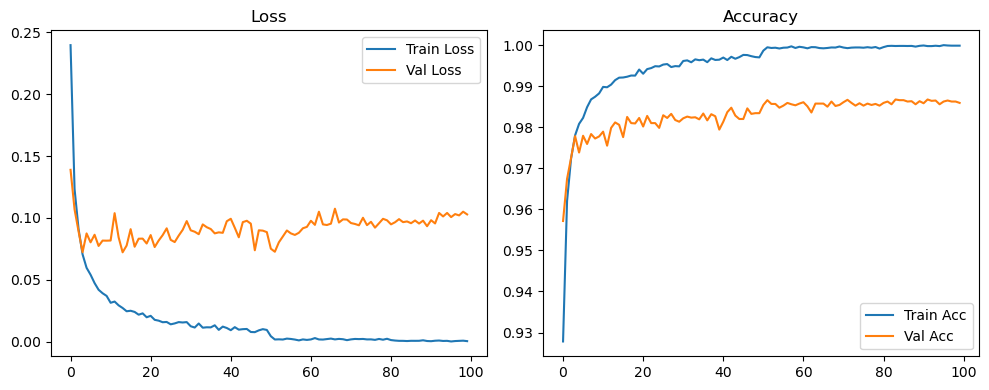

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3070, Acc: 0.9083 | Val Loss: 0.1523, Acc: 0.9554


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1829, Acc: 0.9454 | Val Loss: 0.1067, Acc: 0.9683


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1421, Acc: 0.9577 | Val Loss: 0.0891, Acc: 0.9738


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1189, Acc: 0.9643 | Val Loss: 0.0849, Acc: 0.9758


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1033, Acc: 0.9685 | Val Loss: 0.0873, Acc: 0.9741


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0980, Acc: 0.9700 | Val Loss: 0.0782, Acc: 0.9773


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0883, Acc: 0.9728 | Val Loss: 0.0870, Acc: 0.9739


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0823, Acc: 0.9734 | Val Loss: 0.0805, Acc: 0.9774


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0759, Acc: 0.9766 | Val Loss: 0.0784, Acc: 0.9775


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0714, Acc: 0.9780 | Val Loss: 0.0740, Acc: 0.9774


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0639, Acc: 0.9798 | Val Loss: 0.0703, Acc: 0.9806


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0641, Acc: 0.9803 | Val Loss: 0.0773, Acc: 0.9798


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0647, Acc: 0.9798 | Val Loss: 0.0693, Acc: 0.9801


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0590, Acc: 0.9819 | Val Loss: 0.0708, Acc: 0.9812


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0565, Acc: 0.9819 | Val Loss: 0.0687, Acc: 0.9807


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0559, Acc: 0.9826 | Val Loss: 0.0630, Acc: 0.9816


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0524, Acc: 0.9833 | Val Loss: 0.0748, Acc: 0.9800


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0501, Acc: 0.9841 | Val Loss: 0.0682, Acc: 0.9813


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0471, Acc: 0.9847 | Val Loss: 0.0662, Acc: 0.9825


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0483, Acc: 0.9852 | Val Loss: 0.0686, Acc: 0.9818


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9844 | Val Loss: 0.0733, Acc: 0.9803


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9863 | Val Loss: 0.0690, Acc: 0.9821


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0392, Acc: 0.9878 | Val Loss: 0.0695, Acc: 0.9810


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0389, Acc: 0.9874 | Val Loss: 0.0740, Acc: 0.9814


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0410, Acc: 0.9869 | Val Loss: 0.0727, Acc: 0.9810


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9886 | Val Loss: 0.0653, Acc: 0.9828


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0396, Acc: 0.9876 | Val Loss: 0.0691, Acc: 0.9828


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0348, Acc: 0.9895 | Val Loss: 0.0675, Acc: 0.9835


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9885 | Val Loss: 0.0676, Acc: 0.9832


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0342, Acc: 0.9894 | Val Loss: 0.0674, Acc: 0.9827


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9888 | Val Loss: 0.0760, Acc: 0.9830


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9891 | Val Loss: 0.0731, Acc: 0.9822


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9897 | Val Loss: 0.0753, Acc: 0.9828


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9903 | Val Loss: 0.0679, Acc: 0.9842


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0335, Acc: 0.9897 | Val Loss: 0.0732, Acc: 0.9838


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9914 | Val Loss: 0.0689, Acc: 0.9847


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0304, Acc: 0.9901 | Val Loss: 0.0734, Acc: 0.9828


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9912 | Val Loss: 0.0670, Acc: 0.9841


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9904 | Val Loss: 0.0763, Acc: 0.9839


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9910 | Val Loss: 0.0676, Acc: 0.9833


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9918 | Val Loss: 0.0729, Acc: 0.9840


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9917 | Val Loss: 0.0710, Acc: 0.9833


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9918 | Val Loss: 0.0681, Acc: 0.9843


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9924 | Val Loss: 0.0754, Acc: 0.9826


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9917 | Val Loss: 0.0716, Acc: 0.9834


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9916 | Val Loss: 0.0724, Acc: 0.9822


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9923 | Val Loss: 0.0758, Acc: 0.9838


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9919 | Val Loss: 0.0768, Acc: 0.9829


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9926 | Val Loss: 0.0708, Acc: 0.9844


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0235, Acc: 0.9927 | Val Loss: 0.0724, Acc: 0.9834


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9946 | Val Loss: 0.0675, Acc: 0.9851


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.0669, Acc: 0.9843


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.0713, Acc: 0.9848


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9965 | Val Loss: 0.0710, Acc: 0.9856


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9963 | Val Loss: 0.0725, Acc: 0.9847


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.0729, Acc: 0.9857


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.0732, Acc: 0.9859


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.0707, Acc: 0.9856


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.0719, Acc: 0.9846


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9972 | Val Loss: 0.0716, Acc: 0.9854


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.0759, Acc: 0.9859


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0788, Acc: 0.9856


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9974 | Val Loss: 0.0760, Acc: 0.9848


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.0740, Acc: 0.9856


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.0745, Acc: 0.9865


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0777, Acc: 0.9851


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.0776, Acc: 0.9858


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9973 | Val Loss: 0.0727, Acc: 0.9860


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.0774, Acc: 0.9858


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0750, Acc: 0.9862


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0769, Acc: 0.9862


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.0787, Acc: 0.9858


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.0716, Acc: 0.9864


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0754, Acc: 0.9866


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.0770, Acc: 0.9855


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9975 | Val Loss: 0.0718, Acc: 0.9862


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.0740, Acc: 0.9857


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.0757, Acc: 0.9852


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0778, Acc: 0.9858


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0715, Acc: 0.9865


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0720, Acc: 0.9865


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0741, Acc: 0.9870


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0747, Acc: 0.9868


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0783, Acc: 0.9858


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9983 | Val Loss: 0.0770, Acc: 0.9861


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0776, Acc: 0.9857


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0787, Acc: 0.9860


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0772, Acc: 0.9858


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0772, Acc: 0.9863


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0762, Acc: 0.9864


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0776, Acc: 0.9864


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0797, Acc: 0.9863


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0790, Acc: 0.9862


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0813, Acc: 0.9869


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0825, Acc: 0.9859


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0818, Acc: 0.9867


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0838, Acc: 0.9858


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0843, Acc: 0.9865


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0860, Acc: 0.9856


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0828, Acc: 0.9866


Final Test Loss: 0.0801 Accuracy: 0.9878


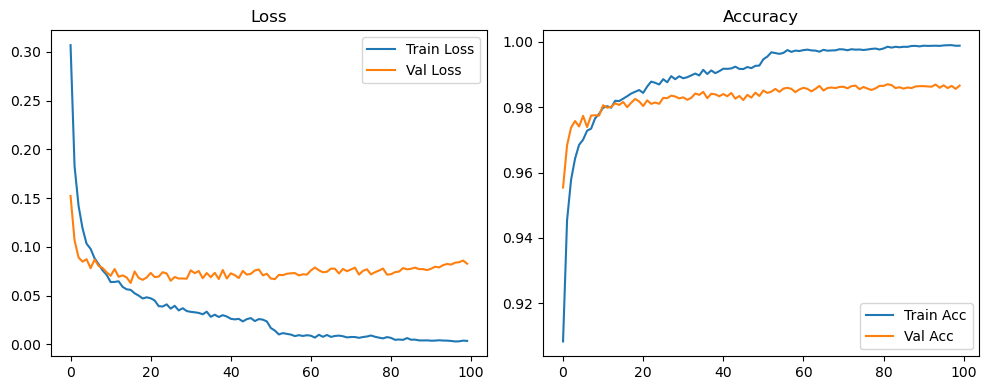

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.1946, Acc: 0.9401 | Val Loss: 0.1277, Acc: 0.9603


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0955, Acc: 0.9696 | Val Loss: 0.1037, Acc: 0.9683


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0643, Acc: 0.9795 | Val Loss: 0.0917, Acc: 0.9753


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0514, Acc: 0.9833 | Val Loss: 0.0794, Acc: 0.9777


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0420, Acc: 0.9862 | Val Loss: 0.1090, Acc: 0.9687


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0363, Acc: 0.9878 | Val Loss: 0.0902, Acc: 0.9747


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9905 | Val Loss: 0.1074, Acc: 0.9740


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9907 | Val Loss: 0.0918, Acc: 0.9763


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9919 | Val Loss: 0.0753, Acc: 0.9798


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9924 | Val Loss: 0.0979, Acc: 0.9756


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9938 | Val Loss: 0.0822, Acc: 0.9797


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9931 | Val Loss: 0.1073, Acc: 0.9767


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.0788, Acc: 0.9813


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.0793, Acc: 0.9809


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9938 | Val Loss: 0.0986, Acc: 0.9769


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9946 | Val Loss: 0.1047, Acc: 0.9767


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9955 | Val Loss: 0.0872, Acc: 0.9796


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.0952, Acc: 0.9774


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.0862, Acc: 0.9818


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0883, Acc: 0.9822


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9957 | Val Loss: 0.1082, Acc: 0.9781


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.0799, Acc: 0.9817


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0871, Acc: 0.9814


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9962 | Val Loss: 0.0886, Acc: 0.9822


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0913, Acc: 0.9818


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9973 | Val Loss: 0.0969, Acc: 0.9794


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.0998, Acc: 0.9804


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9965 | Val Loss: 0.0863, Acc: 0.9825


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0984, Acc: 0.9808


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0726, Acc: 0.9841


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.0908, Acc: 0.9823


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.0984, Acc: 0.9802


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0870, Acc: 0.9838


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0961, Acc: 0.9835


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9974 | Val Loss: 0.0908, Acc: 0.9821


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0842, Acc: 0.9832


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0884, Acc: 0.9831


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.0930, Acc: 0.9826


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.0936, Acc: 0.9825


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0787, Acc: 0.9828


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9984 | Val Loss: 0.0785, Acc: 0.9846


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9984 | Val Loss: 0.1033, Acc: 0.9808


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.0854, Acc: 0.9831


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.0814, Acc: 0.9840


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0908, Acc: 0.9816


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.0821, Acc: 0.9840


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0910, Acc: 0.9825


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1018, Acc: 0.9816


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.0987, Acc: 0.9825


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0926, Acc: 0.9829


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.0876, Acc: 0.9833


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0905, Acc: 0.9840


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9987 | Val Loss: 0.0888, Acc: 0.9830


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0922, Acc: 0.9834


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0930, Acc: 0.9838


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9996 | Val Loss: 0.0909, Acc: 0.9835


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9987 | Val Loss: 0.0962, Acc: 0.9822


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0892, Acc: 0.9841


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0985, Acc: 0.9822


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.0957, Acc: 0.9832


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.0916, Acc: 0.9829


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1044, Acc: 0.9822


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0994, Acc: 0.9829


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0869, Acc: 0.9841


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0970, Acc: 0.9827


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1075, Acc: 0.9826


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0844, Acc: 0.9839


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0968, Acc: 0.9850


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0929, Acc: 0.9841


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0970, Acc: 0.9834


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0922, Acc: 0.9848


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0958, Acc: 0.9829


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.0988, Acc: 0.9835


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0938, Acc: 0.9837


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9991 | Val Loss: 0.1031, Acc: 0.9831


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1005, Acc: 0.9839


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1066, Acc: 0.9828


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0945, Acc: 0.9830


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0946, Acc: 0.9839


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.0882, Acc: 0.9855


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9993 | Val Loss: 0.0950, Acc: 0.9850


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0910, Acc: 0.9850


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0978, Acc: 0.9848


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0865, Acc: 0.9858


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0928, Acc: 0.9850


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9993 | Val Loss: 0.0999, Acc: 0.9844


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1085, Acc: 0.9833


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0891, Acc: 0.9852


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0925, Acc: 0.9839


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.0870, Acc: 0.9843


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0896, Acc: 0.9850


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0911, Acc: 0.9851


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.0981, Acc: 0.9829


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1091, Acc: 0.9832


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1246, Acc: 0.9812


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0982, Acc: 0.9846


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1052, Acc: 0.9838


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.0967, Acc: 0.9838


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0994, Acc: 0.9840


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1052, Acc: 0.9836


Final Test Loss: 0.0930 Accuracy: 0.9851


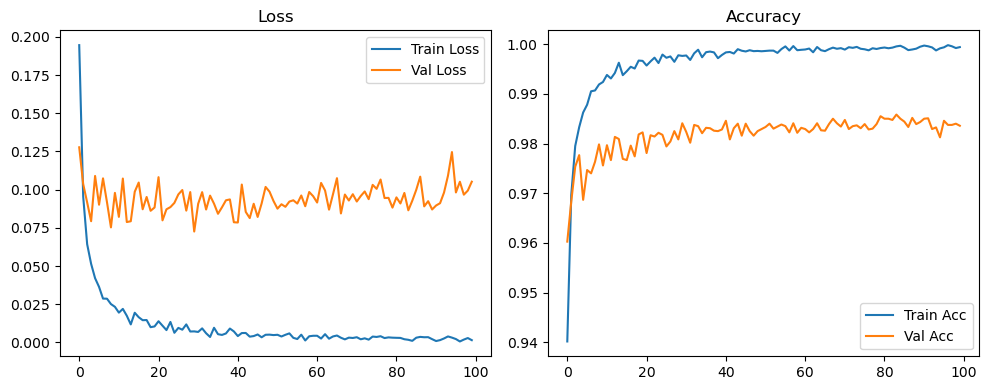

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2128, Acc: 0.9348 | Val Loss: 0.1468, Acc: 0.9547


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1120, Acc: 0.9654 | Val Loss: 0.0996, Acc: 0.9702


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0833, Acc: 0.9739 | Val Loss: 0.0872, Acc: 0.9738


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0660, Acc: 0.9791 | Val Loss: 0.0839, Acc: 0.9742


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0563, Acc: 0.9821 | Val Loss: 0.0842, Acc: 0.9754


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0502, Acc: 0.9833 | Val Loss: 0.0820, Acc: 0.9759


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0428, Acc: 0.9856 | Val Loss: 0.0849, Acc: 0.9791


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0392, Acc: 0.9876 | Val Loss: 0.0787, Acc: 0.9775


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0327, Acc: 0.9894 | Val Loss: 0.0894, Acc: 0.9782


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9894 | Val Loss: 0.0829, Acc: 0.9786


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0300, Acc: 0.9903 | Val Loss: 0.0768, Acc: 0.9806


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9910 | Val Loss: 0.0897, Acc: 0.9782


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9920 | Val Loss: 0.0772, Acc: 0.9807


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9925 | Val Loss: 0.0919, Acc: 0.9795


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9927 | Val Loss: 0.0845, Acc: 0.9794


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9931 | Val Loss: 0.0753, Acc: 0.9818


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0197, Acc: 0.9933 | Val Loss: 0.0783, Acc: 0.9803


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0159, Acc: 0.9944 | Val Loss: 0.0878, Acc: 0.9816


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9932 | Val Loss: 0.0744, Acc: 0.9828


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9941 | Val Loss: 0.0792, Acc: 0.9810


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0176, Acc: 0.9943 | Val Loss: 0.0866, Acc: 0.9816


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9947 | Val Loss: 0.0800, Acc: 0.9831


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9957 | Val Loss: 0.0865, Acc: 0.9818


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.0941, Acc: 0.9807


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9946 | Val Loss: 0.0883, Acc: 0.9828


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9953 | Val Loss: 0.0835, Acc: 0.9823


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.0873, Acc: 0.9803


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.0903, Acc: 0.9819


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9958 | Val Loss: 0.0815, Acc: 0.9830


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.0821, Acc: 0.9825


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9960 | Val Loss: 0.0983, Acc: 0.9809


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.0965, Acc: 0.9804


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.0887, Acc: 0.9834


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.0945, Acc: 0.9827


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.0908, Acc: 0.9826


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.0945, Acc: 0.9817


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.0926, Acc: 0.9818


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0903, Acc: 0.9824


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.0949, Acc: 0.9829


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.0925, Acc: 0.9836


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.0916, Acc: 0.9821


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0887, Acc: 0.9837


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0894, Acc: 0.9842


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9976 | Val Loss: 0.0969, Acc: 0.9821


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9977 | Val Loss: 0.0953, Acc: 0.9831


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0954, Acc: 0.9815


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.0816, Acc: 0.9843


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.1013, Acc: 0.9826


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0899, Acc: 0.9826


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0912, Acc: 0.9834


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1003, Acc: 0.9816


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.0860, Acc: 0.9842


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.0831, Acc: 0.9842


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0951, Acc: 0.9834


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.0972, Acc: 0.9826


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0841, Acc: 0.9842


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.0837, Acc: 0.9828


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0891, Acc: 0.9849


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9978 | Val Loss: 0.0892, Acc: 0.9840


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0860, Acc: 0.9853


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0940, Acc: 0.9848


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.1010, Acc: 0.9836


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0962, Acc: 0.9842


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.0867, Acc: 0.9841


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.0845, Acc: 0.9850


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0951, Acc: 0.9838


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.1000, Acc: 0.9825


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.0986, Acc: 0.9836


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.0952, Acc: 0.9848


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1043, Acc: 0.9833


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.0902, Acc: 0.9840


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0941, Acc: 0.9839


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0983, Acc: 0.9840


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1084, Acc: 0.9838


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9982 | Val Loss: 0.0929, Acc: 0.9852


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0949, Acc: 0.9845


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0911, Acc: 0.9844


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.0952, Acc: 0.9848


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1031, Acc: 0.9842


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.0950, Acc: 0.9836


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0997, Acc: 0.9834


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1026, Acc: 0.9837


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9983 | Val Loss: 0.0949, Acc: 0.9846


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0903, Acc: 0.9853


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1019, Acc: 0.9837


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.0955, Acc: 0.9837


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.0870, Acc: 0.9843


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0920, Acc: 0.9832


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0960, Acc: 0.9848


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0909, Acc: 0.9848


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.0911, Acc: 0.9842


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.0890, Acc: 0.9837


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9991 | Val Loss: 0.0914, Acc: 0.9842


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1034, Acc: 0.9833


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0913, Acc: 0.9845


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0931, Acc: 0.9833


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1000, Acc: 0.9828


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.0888, Acc: 0.9842


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1002, Acc: 0.9832


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1070, Acc: 0.9837


Final Test Loss: 0.1004 Accuracy: 0.9841


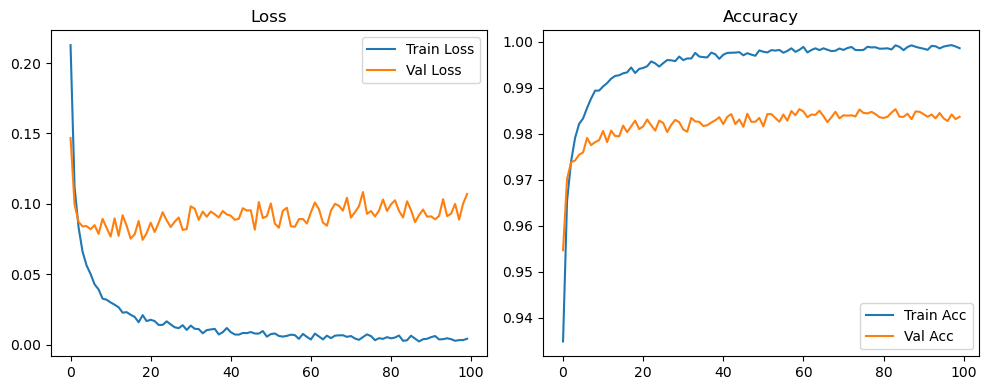

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2776, Acc: 0.9132 | Val Loss: 0.1460, Acc: 0.9571


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1667, Acc: 0.9487 | Val Loss: 0.1077, Acc: 0.9664


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1303, Acc: 0.9600 | Val Loss: 0.0883, Acc: 0.9733


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1168, Acc: 0.9645 | Val Loss: 0.0799, Acc: 0.9756


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1017, Acc: 0.9684 | Val Loss: 0.0866, Acc: 0.9752


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0918, Acc: 0.9715 | Val Loss: 0.0789, Acc: 0.9757


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0836, Acc: 0.9739 | Val Loss: 0.0811, Acc: 0.9758


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0802, Acc: 0.9745 | Val Loss: 0.0779, Acc: 0.9785


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0709, Acc: 0.9774 | Val Loss: 0.0722, Acc: 0.9788


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0665, Acc: 0.9797 | Val Loss: 0.0707, Acc: 0.9812


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0632, Acc: 0.9806 | Val Loss: 0.0692, Acc: 0.9808


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0585, Acc: 0.9803 | Val Loss: 0.0735, Acc: 0.9802


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0554, Acc: 0.9825 | Val Loss: 0.0690, Acc: 0.9814


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0533, Acc: 0.9828 | Val Loss: 0.0669, Acc: 0.9812


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0527, Acc: 0.9832 | Val Loss: 0.0660, Acc: 0.9821


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0479, Acc: 0.9842 | Val Loss: 0.0663, Acc: 0.9822


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0470, Acc: 0.9851 | Val Loss: 0.0625, Acc: 0.9831


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0443, Acc: 0.9858 | Val Loss: 0.0644, Acc: 0.9825


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0437, Acc: 0.9855 | Val Loss: 0.0629, Acc: 0.9825


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0391, Acc: 0.9872 | Val Loss: 0.0641, Acc: 0.9828


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0371, Acc: 0.9881 | Val Loss: 0.0662, Acc: 0.9831


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0391, Acc: 0.9874 | Val Loss: 0.0668, Acc: 0.9825


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0363, Acc: 0.9883 | Val Loss: 0.0693, Acc: 0.9823


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0363, Acc: 0.9878 | Val Loss: 0.0727, Acc: 0.9822


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9891 | Val Loss: 0.0682, Acc: 0.9820


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0318, Acc: 0.9896 | Val Loss: 0.0657, Acc: 0.9819


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9904 | Val Loss: 0.0748, Acc: 0.9818


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0305, Acc: 0.9902 | Val Loss: 0.0698, Acc: 0.9831


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0330, Acc: 0.9893 | Val Loss: 0.0658, Acc: 0.9833


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0308, Acc: 0.9899 | Val Loss: 0.0663, Acc: 0.9839


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0292, Acc: 0.9904 | Val Loss: 0.0745, Acc: 0.9828


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9916 | Val Loss: 0.0724, Acc: 0.9824


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9912 | Val Loss: 0.0638, Acc: 0.9841


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9920 | Val Loss: 0.0693, Acc: 0.9844


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9919 | Val Loss: 0.0690, Acc: 0.9836


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9915 | Val Loss: 0.0692, Acc: 0.9828


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9917 | Val Loss: 0.0651, Acc: 0.9845


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0218, Acc: 0.9929 | Val Loss: 0.0656, Acc: 0.9838


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0211, Acc: 0.9931 | Val Loss: 0.0684, Acc: 0.9838


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9927 | Val Loss: 0.0686, Acc: 0.9848


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9922 | Val Loss: 0.0686, Acc: 0.9845


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9931 | Val Loss: 0.0721, Acc: 0.9840


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9936 | Val Loss: 0.0702, Acc: 0.9838


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.0746, Acc: 0.9827


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9937 | Val Loss: 0.0709, Acc: 0.9843


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9935 | Val Loss: 0.0787, Acc: 0.9810


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.0673, Acc: 0.9852


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9931 | Val Loss: 0.0683, Acc: 0.9843


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0186, Acc: 0.9944 | Val Loss: 0.0710, Acc: 0.9849


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9938 | Val Loss: 0.0743, Acc: 0.9840


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9931 | Val Loss: 0.0748, Acc: 0.9838


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9939 | Val Loss: 0.0711, Acc: 0.9840


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9949 | Val Loss: 0.0819, Acc: 0.9835


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9946 | Val Loss: 0.0751, Acc: 0.9839


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9948 | Val Loss: 0.0766, Acc: 0.9847


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0181, Acc: 0.9944 | Val Loss: 0.0742, Acc: 0.9846


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0187, Acc: 0.9941 | Val Loss: 0.0687, Acc: 0.9845


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9947 | Val Loss: 0.0708, Acc: 0.9847


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9946 | Val Loss: 0.0780, Acc: 0.9844


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.0710, Acc: 0.9852


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.0715, Acc: 0.9840


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9945 | Val Loss: 0.0701, Acc: 0.9845


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.0707, Acc: 0.9844


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.0817, Acc: 0.9837


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9949 | Val Loss: 0.0732, Acc: 0.9846


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.0745, Acc: 0.9855


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9954 | Val Loss: 0.0791, Acc: 0.9853


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9945 | Val Loss: 0.0742, Acc: 0.9851


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9949 | Val Loss: 0.0715, Acc: 0.9852


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9956 | Val Loss: 0.0738, Acc: 0.9850


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9956 | Val Loss: 0.0677, Acc: 0.9856


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.0701, Acc: 0.9855


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.0768, Acc: 0.9842


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9951 | Val Loss: 0.0678, Acc: 0.9859


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.0763, Acc: 0.9848


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.0761, Acc: 0.9846


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9959 | Val Loss: 0.0790, Acc: 0.9848


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.0738, Acc: 0.9854


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9958 | Val Loss: 0.0767, Acc: 0.9843


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.0783, Acc: 0.9855


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.0720, Acc: 0.9848


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9957 | Val Loss: 0.0712, Acc: 0.9858


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.0752, Acc: 0.9852


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.0787, Acc: 0.9840


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9960 | Val Loss: 0.0770, Acc: 0.9842


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.0740, Acc: 0.9848


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.0740, Acc: 0.9865


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.0756, Acc: 0.9850


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9963 | Val Loss: 0.0721, Acc: 0.9854


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9959 | Val Loss: 0.0802, Acc: 0.9848


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.0752, Acc: 0.9863


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.0761, Acc: 0.9851


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9963 | Val Loss: 0.0724, Acc: 0.9855


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.0727, Acc: 0.9859


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0753, Acc: 0.9858


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.0779, Acc: 0.9852


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0738, Acc: 0.9861


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.0797, Acc: 0.9856


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9967 | Val Loss: 0.0783, Acc: 0.9851


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9964 | Val Loss: 0.0802, Acc: 0.9858


Final Test Loss: 0.0754 Accuracy: 0.9845


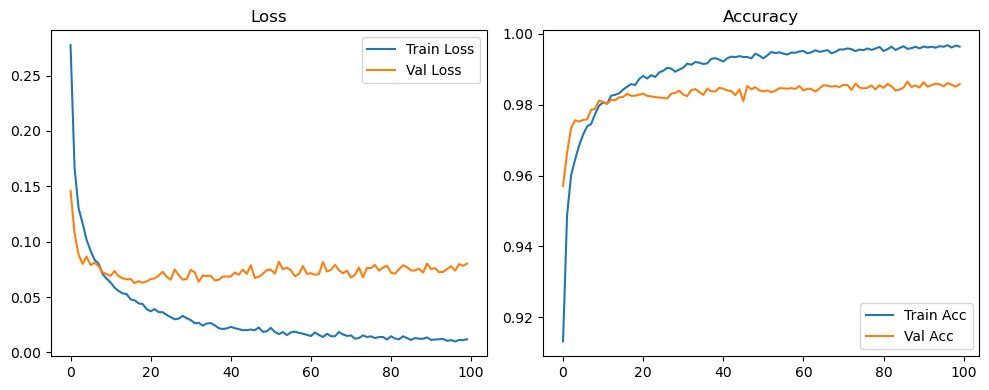

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.1818, Acc: 0.9439 | Val Loss: 0.1148, Acc: 0.9653


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0845, Acc: 0.9733 | Val Loss: 0.0838, Acc: 0.9738


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0550, Acc: 0.9821 | Val Loss: 0.0909, Acc: 0.9745


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0440, Acc: 0.9859 | Val Loss: 0.0753, Acc: 0.9783


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0363, Acc: 0.9882 | Val Loss: 0.0973, Acc: 0.9722


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0310, Acc: 0.9894 | Val Loss: 0.0943, Acc: 0.9746


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0264, Acc: 0.9914 | Val Loss: 0.0810, Acc: 0.9786


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9923 | Val Loss: 0.0811, Acc: 0.9779


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9933 | Val Loss: 0.0873, Acc: 0.9778


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9942 | Val Loss: 0.0862, Acc: 0.9789


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9927 | Val Loss: 0.0848, Acc: 0.9792


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9945 | Val Loss: 0.1054, Acc: 0.9755


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0151, Acc: 0.9947 | Val Loss: 0.0813, Acc: 0.9808


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.0874, Acc: 0.9797


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9959 | Val Loss: 0.0856, Acc: 0.9812


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9954 | Val Loss: 0.0845, Acc: 0.9808


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.0822, Acc: 0.9814


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9962 | Val Loss: 0.1039, Acc: 0.9774


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.0820, Acc: 0.9822


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.0950, Acc: 0.9806


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0809, Acc: 0.9825


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9964 | Val Loss: 0.1000, Acc: 0.9791


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0971, Acc: 0.9788


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0918, Acc: 0.9832


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0899, Acc: 0.9817


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1022, Acc: 0.9795


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.0888, Acc: 0.9818


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0814, Acc: 0.9826


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.1181, Acc: 0.9778


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0936, Acc: 0.9824


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.1065, Acc: 0.9797


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0889, Acc: 0.9825


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0911, Acc: 0.9835


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1011, Acc: 0.9807


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.0833, Acc: 0.9840


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.0881, Acc: 0.9818


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9984 | Val Loss: 0.0886, Acc: 0.9830


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0977, Acc: 0.9824


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9978 | Val Loss: 0.0855, Acc: 0.9835


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1030, Acc: 0.9827


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0946, Acc: 0.9838


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1020, Acc: 0.9830


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1045, Acc: 0.9818


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0855, Acc: 0.9848


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1007, Acc: 0.9818


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1043, Acc: 0.9814


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0997, Acc: 0.9828


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.0992, Acc: 0.9825


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.0890, Acc: 0.9841


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0900, Acc: 0.9848


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0980, Acc: 0.9828


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.1112, Acc: 0.9818


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9982 | Val Loss: 0.0967, Acc: 0.9824


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0918, Acc: 0.9840


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0857, Acc: 0.9842


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9994 | Val Loss: 0.0947, Acc: 0.9828


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0918, Acc: 0.9837


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0958, Acc: 0.9819


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9988 | Val Loss: 0.0958, Acc: 0.9828


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0989, Acc: 0.9839


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1017, Acc: 0.9844


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9991 | Val Loss: 0.0883, Acc: 0.9846


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.0836, Acc: 0.9847


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1058, Acc: 0.9830


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1169, Acc: 0.9795


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1064, Acc: 0.9818


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0946, Acc: 0.9841


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0940, Acc: 0.9847


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1038, Acc: 0.9829


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1047, Acc: 0.9826


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1013, Acc: 0.9832


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.0941, Acc: 0.9838


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0913, Acc: 0.9831


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.0876, Acc: 0.9836


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.0940, Acc: 0.9826


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1053, Acc: 0.9821


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.0932, Acc: 0.9846


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0944, Acc: 0.9836


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0917, Acc: 0.9844


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0877, Acc: 0.9845


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1003, Acc: 0.9825


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9981 | Val Loss: 0.0939, Acc: 0.9837


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0904, Acc: 0.9834


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0849, Acc: 0.9848


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0890, Acc: 0.9852


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1020, Acc: 0.9838


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0954, Acc: 0.9840


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1200, Acc: 0.9819


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0986, Acc: 0.9829


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0879, Acc: 0.9851


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9996 | Val Loss: 0.0954, Acc: 0.9846


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0983, Acc: 0.9838


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1042, Acc: 0.9836


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.1031, Acc: 0.9838


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1057, Acc: 0.9837


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9995 | Val Loss: 0.1045, Acc: 0.9832


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1206, Acc: 0.9812


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1007, Acc: 0.9836


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0901, Acc: 0.9856


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1021, Acc: 0.9838


Final Test Loss: 0.0913 Accuracy: 0.9840


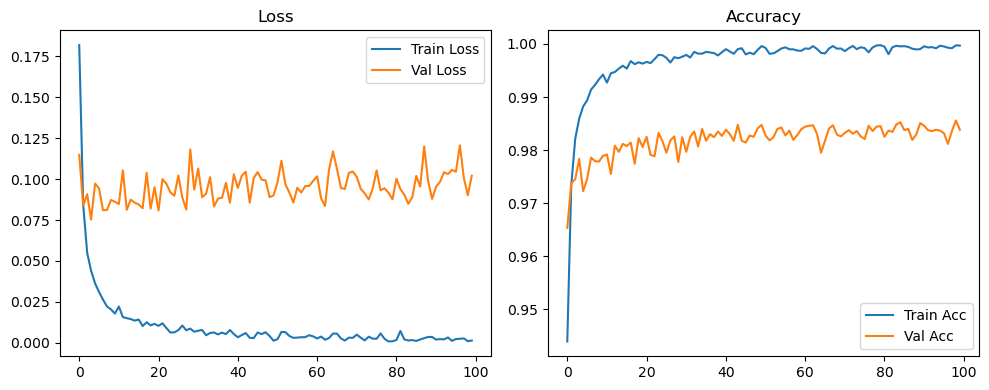

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2040, Acc: 0.9375 | Val Loss: 0.1164, Acc: 0.9647


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1006, Acc: 0.9688 | Val Loss: 0.0897, Acc: 0.9712


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0773, Acc: 0.9752 | Val Loss: 0.0820, Acc: 0.9748


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0583, Acc: 0.9809 | Val Loss: 0.0714, Acc: 0.9782


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0496, Acc: 0.9840 | Val Loss: 0.0920, Acc: 0.9736


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0455, Acc: 0.9854 | Val Loss: 0.0800, Acc: 0.9764


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0398, Acc: 0.9866 | Val Loss: 0.0838, Acc: 0.9775


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0337, Acc: 0.9886 | Val Loss: 0.0747, Acc: 0.9798


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0309, Acc: 0.9897 | Val Loss: 0.0848, Acc: 0.9755


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0265, Acc: 0.9907 | Val Loss: 0.0829, Acc: 0.9783


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0280, Acc: 0.9904 | Val Loss: 0.0821, Acc: 0.9801


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9925 | Val Loss: 0.0930, Acc: 0.9774


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0241, Acc: 0.9919 | Val Loss: 0.0739, Acc: 0.9810


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9928 | Val Loss: 0.0754, Acc: 0.9817


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9923 | Val Loss: 0.0795, Acc: 0.9798


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.0932, Acc: 0.9763


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9935 | Val Loss: 0.0838, Acc: 0.9811


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9943 | Val Loss: 0.0888, Acc: 0.9807


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9939 | Val Loss: 0.0806, Acc: 0.9832


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9944 | Val Loss: 0.0792, Acc: 0.9828


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9951 | Val Loss: 0.0844, Acc: 0.9818


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9953 | Val Loss: 0.0917, Acc: 0.9804


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0166, Acc: 0.9943 | Val Loss: 0.0869, Acc: 0.9808


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.0808, Acc: 0.9823


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9959 | Val Loss: 0.0816, Acc: 0.9807


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.0778, Acc: 0.9818


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9967 | Val Loss: 0.0879, Acc: 0.9819


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.0901, Acc: 0.9818


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 0.0839, Acc: 0.9826


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.0856, Acc: 0.9826


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.0898, Acc: 0.9824


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.0933, Acc: 0.9822


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.0877, Acc: 0.9824


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.0875, Acc: 0.9831


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.0800, Acc: 0.9835


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.0910, Acc: 0.9814


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.0730, Acc: 0.9839


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.0774, Acc: 0.9834


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0915, Acc: 0.9825


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.0991, Acc: 0.9829


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.0913, Acc: 0.9833


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9972 | Val Loss: 0.0959, Acc: 0.9826


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.0975, Acc: 0.9819


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0868, Acc: 0.9837


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9981 | Val Loss: 0.0825, Acc: 0.9828


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9976 | Val Loss: 0.0874, Acc: 0.9835


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9981 | Val Loss: 0.0781, Acc: 0.9840


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0970, Acc: 0.9820


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.0903, Acc: 0.9837


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0883, Acc: 0.9839


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1037, Acc: 0.9809


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0936, Acc: 0.9823


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0783, Acc: 0.9847


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0879, Acc: 0.9852


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.0970, Acc: 0.9839


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1086, Acc: 0.9822


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.0930, Acc: 0.9838


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0892, Acc: 0.9842


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.0942, Acc: 0.9833


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0993, Acc: 0.9831


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.0900, Acc: 0.9840


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1012, Acc: 0.9826


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0872, Acc: 0.9841


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0898, Acc: 0.9832


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.0903, Acc: 0.9836


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0903, Acc: 0.9838


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0997, Acc: 0.9824


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1001, Acc: 0.9834


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0957, Acc: 0.9842


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0966, Acc: 0.9832


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1015, Acc: 0.9822


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0881, Acc: 0.9852


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0914, Acc: 0.9843


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9987 | Val Loss: 0.0942, Acc: 0.9844


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0933, Acc: 0.9842


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0961, Acc: 0.9838


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.0887, Acc: 0.9841


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0964, Acc: 0.9840


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0995, Acc: 0.9833


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0990, Acc: 0.9838


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0946, Acc: 0.9852


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0925, Acc: 0.9844


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0914, Acc: 0.9848


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0929, Acc: 0.9842


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0936, Acc: 0.9862


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0998, Acc: 0.9836


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0956, Acc: 0.9842


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1045, Acc: 0.9833


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0952, Acc: 0.9852


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0917, Acc: 0.9848


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0906, Acc: 0.9857


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0908, Acc: 0.9846


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1022, Acc: 0.9834


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1023, Acc: 0.9843


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0995, Acc: 0.9842


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0977, Acc: 0.9846


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.0950, Acc: 0.9846


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0870, Acc: 0.9858


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9988 | Val Loss: 0.0999, Acc: 0.9837


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1006, Acc: 0.9827


Final Test Loss: 0.0939 Accuracy: 0.9837


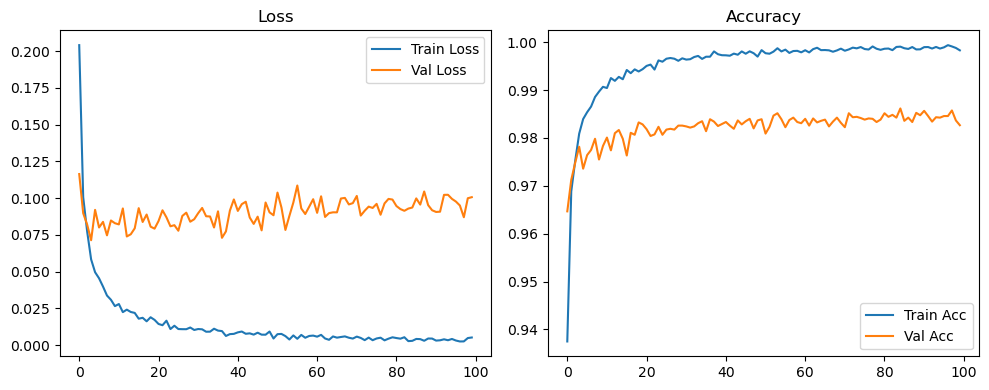

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2854, Acc: 0.9112 | Val Loss: 0.1274, Acc: 0.9627


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1554, Acc: 0.9515 | Val Loss: 0.0984, Acc: 0.9689


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1243, Acc: 0.9615 | Val Loss: 0.0882, Acc: 0.9732


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1112, Acc: 0.9651 | Val Loss: 0.0779, Acc: 0.9762


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0951, Acc: 0.9702 | Val Loss: 0.0854, Acc: 0.9750


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0849, Acc: 0.9724 | Val Loss: 0.0776, Acc: 0.9765


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0811, Acc: 0.9752 | Val Loss: 0.0768, Acc: 0.9777


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0759, Acc: 0.9754 | Val Loss: 0.0761, Acc: 0.9778


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0665, Acc: 0.9786 | Val Loss: 0.0677, Acc: 0.9792


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0653, Acc: 0.9784 | Val Loss: 0.0722, Acc: 0.9797


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0584, Acc: 0.9809 | Val Loss: 0.0675, Acc: 0.9817


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0555, Acc: 0.9811 | Val Loss: 0.0751, Acc: 0.9797


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0554, Acc: 0.9815 | Val Loss: 0.0747, Acc: 0.9788


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0508, Acc: 0.9832 | Val Loss: 0.0665, Acc: 0.9811


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0476, Acc: 0.9837 | Val Loss: 0.0677, Acc: 0.9813


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0468, Acc: 0.9846 | Val Loss: 0.0698, Acc: 0.9819


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0463, Acc: 0.9842 | Val Loss: 0.0715, Acc: 0.9818


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0424, Acc: 0.9855 | Val Loss: 0.0663, Acc: 0.9818


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0404, Acc: 0.9872 | Val Loss: 0.0654, Acc: 0.9812


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0379, Acc: 0.9882 | Val Loss: 0.0682, Acc: 0.9818


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0374, Acc: 0.9874 | Val Loss: 0.0666, Acc: 0.9826


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0392, Acc: 0.9872 | Val Loss: 0.0642, Acc: 0.9818


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0353, Acc: 0.9886 | Val Loss: 0.0613, Acc: 0.9833


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0348, Acc: 0.9889 | Val Loss: 0.0673, Acc: 0.9828


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0331, Acc: 0.9893 | Val Loss: 0.0627, Acc: 0.9837


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0295, Acc: 0.9897 | Val Loss: 0.0649, Acc: 0.9844


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0310, Acc: 0.9899 | Val Loss: 0.0703, Acc: 0.9828


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0295, Acc: 0.9902 | Val Loss: 0.0687, Acc: 0.9847


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9904 | Val Loss: 0.0665, Acc: 0.9837


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0271, Acc: 0.9910 | Val Loss: 0.0646, Acc: 0.9842


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9903 | Val Loss: 0.0683, Acc: 0.9829


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9919 | Val Loss: 0.0744, Acc: 0.9822


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0264, Acc: 0.9912 | Val Loss: 0.0677, Acc: 0.9828


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0243, Acc: 0.9919 | Val Loss: 0.0697, Acc: 0.9831


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9924 | Val Loss: 0.0676, Acc: 0.9838


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0234, Acc: 0.9923 | Val Loss: 0.0619, Acc: 0.9841


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0254, Acc: 0.9915 | Val Loss: 0.0699, Acc: 0.9828


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0216, Acc: 0.9926 | Val Loss: 0.0660, Acc: 0.9838


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9926 | Val Loss: 0.0655, Acc: 0.9838


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9932 | Val Loss: 0.0709, Acc: 0.9840


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9930 | Val Loss: 0.0713, Acc: 0.9838


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9935 | Val Loss: 0.0693, Acc: 0.9845


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9936 | Val Loss: 0.0665, Acc: 0.9849


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0196, Acc: 0.9936 | Val Loss: 0.0669, Acc: 0.9844


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0196, Acc: 0.9932 | Val Loss: 0.0702, Acc: 0.9847


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9933 | Val Loss: 0.0727, Acc: 0.9833


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9937 | Val Loss: 0.0691, Acc: 0.9842


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9933 | Val Loss: 0.0698, Acc: 0.9833


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9935 | Val Loss: 0.0674, Acc: 0.9837


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0161, Acc: 0.9947 | Val Loss: 0.0712, Acc: 0.9843


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9938 | Val Loss: 0.0699, Acc: 0.9842


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9946 | Val Loss: 0.0677, Acc: 0.9840


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0156, Acc: 0.9945 | Val Loss: 0.0697, Acc: 0.9846


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9945 | Val Loss: 0.0695, Acc: 0.9849


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.0706, Acc: 0.9842


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0161, Acc: 0.9943 | Val Loss: 0.0708, Acc: 0.9849


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9948 | Val Loss: 0.0685, Acc: 0.9855


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0156, Acc: 0.9951 | Val Loss: 0.0718, Acc: 0.9842


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.0741, Acc: 0.9842


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0150, Acc: 0.9950 | Val Loss: 0.0747, Acc: 0.9837


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9953 | Val Loss: 0.0753, Acc: 0.9843


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0163, Acc: 0.9949 | Val Loss: 0.0770, Acc: 0.9835


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9954 | Val Loss: 0.0779, Acc: 0.9840


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.0749, Acc: 0.9844


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9954 | Val Loss: 0.0733, Acc: 0.9854


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9959 | Val Loss: 0.0708, Acc: 0.9854


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.0715, Acc: 0.9859


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.0731, Acc: 0.9851


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.0748, Acc: 0.9847


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.0770, Acc: 0.9851


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0141, Acc: 0.9956 | Val Loss: 0.0791, Acc: 0.9847


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9958 | Val Loss: 0.0768, Acc: 0.9848


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.0729, Acc: 0.9852


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9957 | Val Loss: 0.0722, Acc: 0.9848


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9962 | Val Loss: 0.0775, Acc: 0.9844


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9955 | Val Loss: 0.0705, Acc: 0.9861


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 0.0730, Acc: 0.9860


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.0657, Acc: 0.9858


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.0752, Acc: 0.9855


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.0810, Acc: 0.9844


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9962 | Val Loss: 0.0734, Acc: 0.9858


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.0713, Acc: 0.9847


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.0734, Acc: 0.9857


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.0771, Acc: 0.9847


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9967 | Val Loss: 0.0793, Acc: 0.9848


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.0742, Acc: 0.9849


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.0779, Acc: 0.9852


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.0823, Acc: 0.9846


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.0780, Acc: 0.9844


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.0758, Acc: 0.9843


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.0794, Acc: 0.9846


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.0758, Acc: 0.9842


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.0745, Acc: 0.9852


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.0757, Acc: 0.9852


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.0766, Acc: 0.9848


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9971 | Val Loss: 0.0734, Acc: 0.9850


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.0764, Acc: 0.9848


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.0801, Acc: 0.9842


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.0805, Acc: 0.9844


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.0760, Acc: 0.9852


Final Test Loss: 0.0754 Accuracy: 0.9869


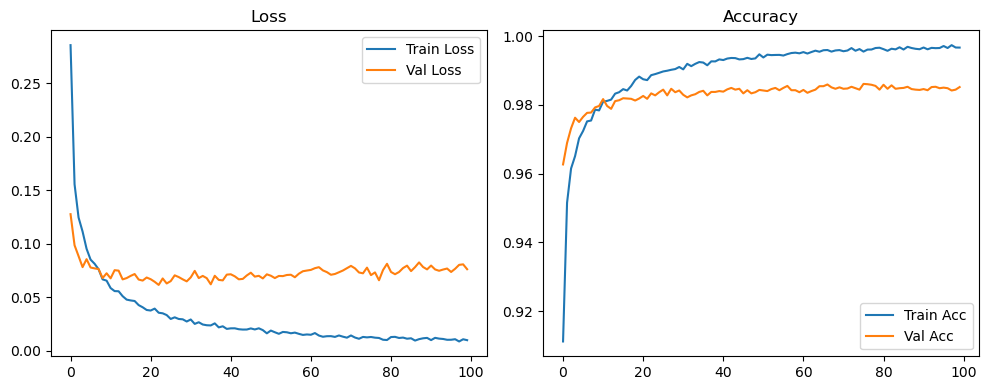

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2518, Acc: 0.9255 | Val Loss: 0.1479, Acc: 0.9557


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1034, Acc: 0.9684 | Val Loss: 0.1023, Acc: 0.9698


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0700, Acc: 0.9779 | Val Loss: 0.1090, Acc: 0.9689


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9825 | Val Loss: 0.0835, Acc: 0.9763


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0438, Acc: 0.9856 | Val Loss: 0.1003, Acc: 0.9710


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9883 | Val Loss: 0.0896, Acc: 0.9752


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9902 | Val Loss: 0.1149, Acc: 0.9704


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9907 | Val Loss: 0.0982, Acc: 0.9757


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9924 | Val Loss: 0.1116, Acc: 0.9733


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9911 | Val Loss: 0.0822, Acc: 0.9798


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9937 | Val Loss: 0.0935, Acc: 0.9797


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.1347, Acc: 0.9719


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9944 | Val Loss: 0.1048, Acc: 0.9758


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9947 | Val Loss: 0.0958, Acc: 0.9767


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.0994, Acc: 0.9778


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9960 | Val Loss: 0.1011, Acc: 0.9766


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9930 | Val Loss: 0.0950, Acc: 0.9796


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9957 | Val Loss: 0.0861, Acc: 0.9809


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.0893, Acc: 0.9805


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9942 | Val Loss: 0.0915, Acc: 0.9792


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9955 | Val Loss: 0.1030, Acc: 0.9765


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9963 | Val Loss: 0.0910, Acc: 0.9812


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.0896, Acc: 0.9812


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.0888, Acc: 0.9815


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9948 | Val Loss: 0.1138, Acc: 0.9752


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9963 | Val Loss: 0.1394, Acc: 0.9755


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.0979, Acc: 0.9814


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9978 | Val Loss: 0.1417, Acc: 0.9752


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.0968, Acc: 0.9809


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.1185, Acc: 0.9782


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9962 | Val Loss: 0.1291, Acc: 0.9777


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9972 | Val Loss: 0.0866, Acc: 0.9814


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.0963, Acc: 0.9812


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1170, Acc: 0.9797


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9976 | Val Loss: 0.1074, Acc: 0.9791


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.1171, Acc: 0.9779


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9971 | Val Loss: 0.1106, Acc: 0.9773


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.0989, Acc: 0.9803


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1017, Acc: 0.9812


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1019, Acc: 0.9806


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.1135, Acc: 0.9782


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.0854, Acc: 0.9823


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0904, Acc: 0.9834


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0893, Acc: 0.9823


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1013, Acc: 0.9819


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0894, Acc: 0.9832


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.1067, Acc: 0.9809


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.1081, Acc: 0.9797


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.0959, Acc: 0.9810


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1281, Acc: 0.9783


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1019, Acc: 0.9802


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0939, Acc: 0.9836


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1147, Acc: 0.9808


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1196, Acc: 0.9803


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9983 | Val Loss: 0.1094, Acc: 0.9794


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0951, Acc: 0.9813


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0958, Acc: 0.9823


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0985, Acc: 0.9824


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.0895, Acc: 0.9828


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.0941, Acc: 0.9832


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0933, Acc: 0.9838


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1069, Acc: 0.9816


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0966, Acc: 0.9832


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1183, Acc: 0.9802


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9973 | Val Loss: 0.1022, Acc: 0.9798


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.0962, Acc: 0.9822


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1103, Acc: 0.9822


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1069, Acc: 0.9825


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1136, Acc: 0.9819


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1557, Acc: 0.9772


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9976 | Val Loss: 0.0901, Acc: 0.9820


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1031, Acc: 0.9818


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1149, Acc: 0.9813


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1235, Acc: 0.9807


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1102, Acc: 0.9824


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1045, Acc: 0.9813


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9989 | Val Loss: 0.1204, Acc: 0.9802


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0922, Acc: 0.9834


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0977, Acc: 0.9831


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1094, Acc: 0.9811


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0943, Acc: 0.9832


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0922, Acc: 0.9842


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0938, Acc: 0.9838


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0930, Acc: 0.9850


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9997 | Val Loss: 0.0908, Acc: 0.9849


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0957, Acc: 0.9846


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.1072, Acc: 0.9813


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1262, Acc: 0.9786


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.0970, Acc: 0.9828


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1119, Acc: 0.9818


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.0962, Acc: 0.9824


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.0974, Acc: 0.9819


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0904, Acc: 0.9830


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.1069, Acc: 0.9812


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0926, Acc: 0.9838


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0887, Acc: 0.9843


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1042, Acc: 0.9828


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.0925, Acc: 0.9843


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.0909, Acc: 0.9842


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1008, Acc: 0.9820


Final Test Loss: 0.0914 Accuracy: 0.9840


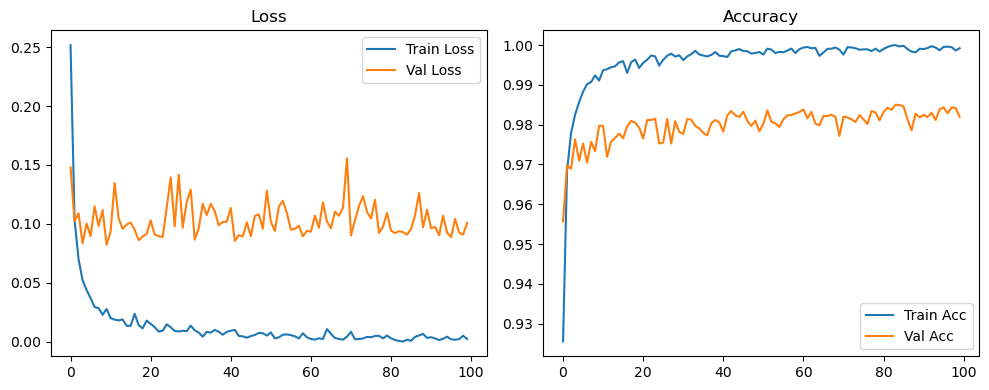

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2684, Acc: 0.9207 | Val Loss: 0.1574, Acc: 0.9534


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1188, Acc: 0.9630 | Val Loss: 0.1081, Acc: 0.9667


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0840, Acc: 0.9743 | Val Loss: 0.1002, Acc: 0.9713


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0697, Acc: 0.9786 | Val Loss: 0.0887, Acc: 0.9742


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0570, Acc: 0.9818 | Val Loss: 0.0838, Acc: 0.9765


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9834 | Val Loss: 0.0896, Acc: 0.9748


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9871 | Val Loss: 0.1019, Acc: 0.9737


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9881 | Val Loss: 0.1055, Acc: 0.9732


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9890 | Val Loss: 0.0984, Acc: 0.9748


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9889 | Val Loss: 0.0909, Acc: 0.9778


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9906 | Val Loss: 0.0945, Acc: 0.9768


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9909 | Val Loss: 0.1096, Acc: 0.9738


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9903 | Val Loss: 0.0917, Acc: 0.9773


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9908 | Val Loss: 0.0839, Acc: 0.9783


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9917 | Val Loss: 0.0827, Acc: 0.9777


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9918 | Val Loss: 0.0898, Acc: 0.9779


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9923 | Val Loss: 0.0974, Acc: 0.9781


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9930 | Val Loss: 0.1088, Acc: 0.9760


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9929 | Val Loss: 0.0904, Acc: 0.9805


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9938 | Val Loss: 0.1070, Acc: 0.9771


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9939 | Val Loss: 0.0794, Acc: 0.9800


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9941 | Val Loss: 0.0744, Acc: 0.9813


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.0928, Acc: 0.9793


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9941 | Val Loss: 0.1115, Acc: 0.9778


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9935 | Val Loss: 0.1007, Acc: 0.9782


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.0940, Acc: 0.9812


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9947 | Val Loss: 0.1059, Acc: 0.9778


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9953 | Val Loss: 0.0989, Acc: 0.9802


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9946 | Val Loss: 0.1009, Acc: 0.9794


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9949 | Val Loss: 0.0984, Acc: 0.9811


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9948 | Val Loss: 0.0933, Acc: 0.9802


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9963 | Val Loss: 0.0906, Acc: 0.9816


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9953 | Val Loss: 0.1070, Acc: 0.9789


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.0968, Acc: 0.9818


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9954 | Val Loss: 0.1089, Acc: 0.9803


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1071, Acc: 0.9792


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9961 | Val Loss: 0.0871, Acc: 0.9822


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9962 | Val Loss: 0.1009, Acc: 0.9816


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.0960, Acc: 0.9813


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.0930, Acc: 0.9814


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9971 | Val Loss: 0.0948, Acc: 0.9816


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9968 | Val Loss: 0.0973, Acc: 0.9821


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9964 | Val Loss: 0.0872, Acc: 0.9825


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9973 | Val Loss: 0.1115, Acc: 0.9801


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9963 | Val Loss: 0.1076, Acc: 0.9796


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9962 | Val Loss: 0.0945, Acc: 0.9820


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.0919, Acc: 0.9830


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.1049, Acc: 0.9845


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9964 | Val Loss: 0.0862, Acc: 0.9818


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9972 | Val Loss: 0.1010, Acc: 0.9818


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.0934, Acc: 0.9832


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.0970, Acc: 0.9818


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1005, Acc: 0.9821


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.0884, Acc: 0.9822


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1070, Acc: 0.9813


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.0936, Acc: 0.9818


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9971 | Val Loss: 0.0920, Acc: 0.9818


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0914, Acc: 0.9822


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.0890, Acc: 0.9827


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9976 | Val Loss: 0.0967, Acc: 0.9813


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.0963, Acc: 0.9824


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.0946, Acc: 0.9827


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.1014, Acc: 0.9825


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1180, Acc: 0.9813


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9975 | Val Loss: 0.0989, Acc: 0.9822


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1056, Acc: 0.9810


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9976 | Val Loss: 0.0920, Acc: 0.9832


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.0874, Acc: 0.9831


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9972 | Val Loss: 0.0902, Acc: 0.9832


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0972, Acc: 0.9834


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0928, Acc: 0.9828


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9979 | Val Loss: 0.0974, Acc: 0.9822


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.0938, Acc: 0.9830


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1054, Acc: 0.9828


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1085, Acc: 0.9838


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1029, Acc: 0.9838


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9976 | Val Loss: 0.1111, Acc: 0.9822


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9972 | Val Loss: 0.0932, Acc: 0.9847


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1027, Acc: 0.9837


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0950, Acc: 0.9829


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1018, Acc: 0.9828


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.1135, Acc: 0.9829


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9984 | Val Loss: 0.1022, Acc: 0.9836


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0978, Acc: 0.9837


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.0963, Acc: 0.9833


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.0973, Acc: 0.9831


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0992, Acc: 0.9838


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9984 | Val Loss: 0.1168, Acc: 0.9808


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9979 | Val Loss: 0.0984, Acc: 0.9842


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.0921, Acc: 0.9838


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1074, Acc: 0.9832


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9980 | Val Loss: 0.1012, Acc: 0.9820


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9986 | Val Loss: 0.1128, Acc: 0.9813


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.1011, Acc: 0.9839


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9981 | Val Loss: 0.1021, Acc: 0.9823


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0906, Acc: 0.9850


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1032, Acc: 0.9830


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0989, Acc: 0.9825


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9983 | Val Loss: 0.1033, Acc: 0.9830


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1108, Acc: 0.9832


Final Test Loss: 0.1182 Accuracy: 0.9830


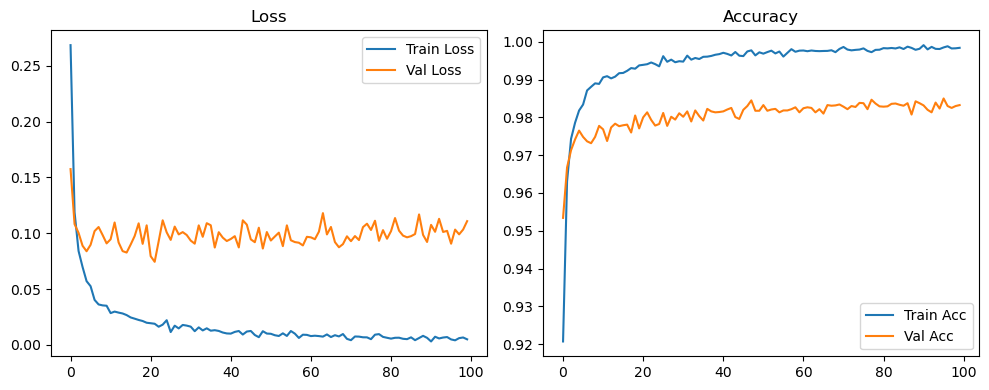

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3204, Acc: 0.9057 | Val Loss: 0.1489, Acc: 0.9563


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1738, Acc: 0.9486 | Val Loss: 0.1110, Acc: 0.9659


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1333, Acc: 0.9601 | Val Loss: 0.1004, Acc: 0.9710


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1151, Acc: 0.9649 | Val Loss: 0.0843, Acc: 0.9748


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0945, Acc: 0.9708 | Val Loss: 0.0829, Acc: 0.9759


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0903, Acc: 0.9724 | Val Loss: 0.0787, Acc: 0.9780


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0809, Acc: 0.9754 | Val Loss: 0.0803, Acc: 0.9782


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0740, Acc: 0.9764 | Val Loss: 0.0867, Acc: 0.9764


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0765, Acc: 0.9761 | Val Loss: 0.0900, Acc: 0.9750


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0675, Acc: 0.9791 | Val Loss: 0.0797, Acc: 0.9770


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0616, Acc: 0.9807 | Val Loss: 0.0763, Acc: 0.9781


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0613, Acc: 0.9805 | Val Loss: 0.0821, Acc: 0.9788


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0607, Acc: 0.9813 | Val Loss: 0.0682, Acc: 0.9807


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0557, Acc: 0.9823 | Val Loss: 0.0760, Acc: 0.9793


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0529, Acc: 0.9837 | Val Loss: 0.0744, Acc: 0.9798


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9835 | Val Loss: 0.0724, Acc: 0.9810


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9836 | Val Loss: 0.0758, Acc: 0.9807


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9851 | Val Loss: 0.0716, Acc: 0.9815


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9856 | Val Loss: 0.0781, Acc: 0.9811


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9858 | Val Loss: 0.0649, Acc: 0.9831


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0451, Acc: 0.9856 | Val Loss: 0.0679, Acc: 0.9817


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9870 | Val Loss: 0.0727, Acc: 0.9809


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9874 | Val Loss: 0.0736, Acc: 0.9818


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9872 | Val Loss: 0.0725, Acc: 0.9807


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9879 | Val Loss: 0.0756, Acc: 0.9810


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9880 | Val Loss: 0.0678, Acc: 0.9832


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9886 | Val Loss: 0.0760, Acc: 0.9824


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9874 | Val Loss: 0.0716, Acc: 0.9815


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9884 | Val Loss: 0.0758, Acc: 0.9813


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9888 | Val Loss: 0.0717, Acc: 0.9821


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0319, Acc: 0.9903 | Val Loss: 0.0724, Acc: 0.9831


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9903 | Val Loss: 0.0769, Acc: 0.9820


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9889 | Val Loss: 0.0735, Acc: 0.9822


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9901 | Val Loss: 0.0724, Acc: 0.9828


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9900 | Val Loss: 0.0746, Acc: 0.9840


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9907 | Val Loss: 0.0703, Acc: 0.9846


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9898 | Val Loss: 0.0793, Acc: 0.9838


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9902 | Val Loss: 0.0698, Acc: 0.9842


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9911 | Val Loss: 0.0704, Acc: 0.9842


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9916 | Val Loss: 0.0759, Acc: 0.9825


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9919 | Val Loss: 0.0809, Acc: 0.9832


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9916 | Val Loss: 0.0750, Acc: 0.9828


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9909 | Val Loss: 0.0811, Acc: 0.9824


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9914 | Val Loss: 0.0747, Acc: 0.9844


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9921 | Val Loss: 0.0759, Acc: 0.9840


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9924 | Val Loss: 0.0771, Acc: 0.9828


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9916 | Val Loss: 0.0781, Acc: 0.9829


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9925 | Val Loss: 0.0789, Acc: 0.9832


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9921 | Val Loss: 0.0800, Acc: 0.9841


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9918 | Val Loss: 0.0772, Acc: 0.9845


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9929 | Val Loss: 0.0785, Acc: 0.9836


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9931 | Val Loss: 0.0916, Acc: 0.9829


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9931 | Val Loss: 0.0808, Acc: 0.9836


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9923 | Val Loss: 0.0835, Acc: 0.9825


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9933 | Val Loss: 0.0806, Acc: 0.9832


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9931 | Val Loss: 0.0780, Acc: 0.9822


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9932 | Val Loss: 0.0757, Acc: 0.9844


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9937 | Val Loss: 0.0728, Acc: 0.9850


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.0760, Acc: 0.9835


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.0787, Acc: 0.9842


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9936 | Val Loss: 0.0863, Acc: 0.9823


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9933 | Val Loss: 0.0780, Acc: 0.9841


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.0825, Acc: 0.9841


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9930 | Val Loss: 0.0808, Acc: 0.9832


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9944 | Val Loss: 0.0808, Acc: 0.9836


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9942 | Val Loss: 0.0845, Acc: 0.9837


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9935 | Val Loss: 0.0867, Acc: 0.9838


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9939 | Val Loss: 0.0895, Acc: 0.9844


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9946 | Val Loss: 0.0801, Acc: 0.9844


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9939 | Val Loss: 0.0894, Acc: 0.9847


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9942 | Val Loss: 0.0865, Acc: 0.9831


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9938 | Val Loss: 0.0873, Acc: 0.9832


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9948 | Val Loss: 0.0795, Acc: 0.9842


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.0885, Acc: 0.9837


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9939 | Val Loss: 0.0868, Acc: 0.9848


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9954 | Val Loss: 0.0901, Acc: 0.9832


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9948 | Val Loss: 0.0834, Acc: 0.9834


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9947 | Val Loss: 0.0838, Acc: 0.9851


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9936 | Val Loss: 0.0903, Acc: 0.9838


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9942 | Val Loss: 0.0825, Acc: 0.9842


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9949 | Val Loss: 0.0836, Acc: 0.9846


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9956 | Val Loss: 0.0866, Acc: 0.9842


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9950 | Val Loss: 0.0902, Acc: 0.9856


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9948 | Val Loss: 0.0833, Acc: 0.9831


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9949 | Val Loss: 0.0838, Acc: 0.9847


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9948 | Val Loss: 0.0807, Acc: 0.9838


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9954 | Val Loss: 0.0879, Acc: 0.9840


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9957 | Val Loss: 0.0864, Acc: 0.9854


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9956 | Val Loss: 0.0914, Acc: 0.9838


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9952 | Val Loss: 0.0860, Acc: 0.9835


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9952 | Val Loss: 0.0850, Acc: 0.9852


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9954 | Val Loss: 0.0844, Acc: 0.9853


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9949 | Val Loss: 0.0821, Acc: 0.9854


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9948 | Val Loss: 0.0857, Acc: 0.9840


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9951 | Val Loss: 0.0966, Acc: 0.9838


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9950 | Val Loss: 0.0891, Acc: 0.9849


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9959 | Val Loss: 0.0877, Acc: 0.9842


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9960 | Val Loss: 0.0896, Acc: 0.9844


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9960 | Val Loss: 0.0913, Acc: 0.9835


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9957 | Val Loss: 0.0847, Acc: 0.9851


Final Test Loss: 0.0825 Accuracy: 0.9863


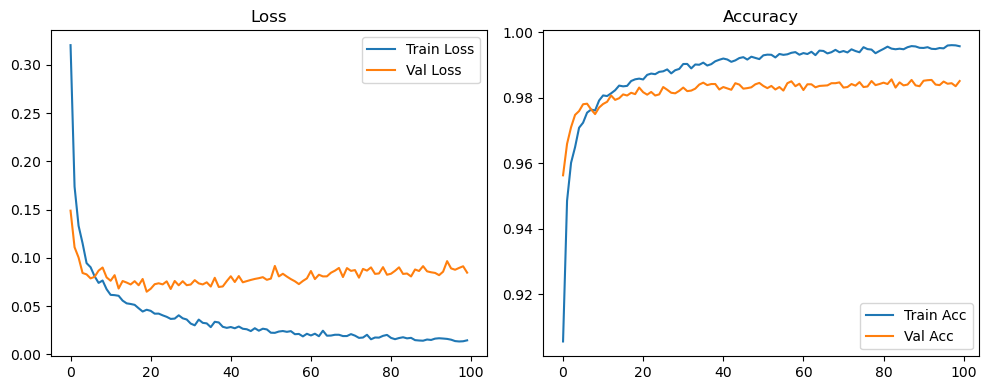

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2518, Acc: 0.9255 | Val Loss: 0.1479, Acc: 0.9557


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1034, Acc: 0.9684 | Val Loss: 0.1023, Acc: 0.9698


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0700, Acc: 0.9779 | Val Loss: 0.1090, Acc: 0.9689


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9825 | Val Loss: 0.0835, Acc: 0.9763


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0438, Acc: 0.9856 | Val Loss: 0.1003, Acc: 0.9710


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9883 | Val Loss: 0.0896, Acc: 0.9752


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9902 | Val Loss: 0.1149, Acc: 0.9704


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9907 | Val Loss: 0.0982, Acc: 0.9757


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9924 | Val Loss: 0.1116, Acc: 0.9733


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9911 | Val Loss: 0.0822, Acc: 0.9798


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9937 | Val Loss: 0.0935, Acc: 0.9797


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.1347, Acc: 0.9719


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9944 | Val Loss: 0.1048, Acc: 0.9758


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9947 | Val Loss: 0.0958, Acc: 0.9767


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.0994, Acc: 0.9778


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9960 | Val Loss: 0.1011, Acc: 0.9766


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9930 | Val Loss: 0.0950, Acc: 0.9796


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9957 | Val Loss: 0.0861, Acc: 0.9809


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.0893, Acc: 0.9805


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9942 | Val Loss: 0.0915, Acc: 0.9792


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9955 | Val Loss: 0.1030, Acc: 0.9765


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9963 | Val Loss: 0.0910, Acc: 0.9812


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.0896, Acc: 0.9812


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.0888, Acc: 0.9815


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9948 | Val Loss: 0.1138, Acc: 0.9752


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9963 | Val Loss: 0.1394, Acc: 0.9755


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.0979, Acc: 0.9814


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9978 | Val Loss: 0.1417, Acc: 0.9752


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.0968, Acc: 0.9809


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.1185, Acc: 0.9782


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9962 | Val Loss: 0.1291, Acc: 0.9777


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9972 | Val Loss: 0.0866, Acc: 0.9814


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.0963, Acc: 0.9812


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1170, Acc: 0.9797


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9976 | Val Loss: 0.1074, Acc: 0.9791


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.1171, Acc: 0.9779


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9971 | Val Loss: 0.1106, Acc: 0.9773


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.0989, Acc: 0.9803


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1017, Acc: 0.9812


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1019, Acc: 0.9806


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.1135, Acc: 0.9782


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.0854, Acc: 0.9823


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0904, Acc: 0.9834


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0893, Acc: 0.9823


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1013, Acc: 0.9819


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0894, Acc: 0.9832


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.1067, Acc: 0.9809


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.1081, Acc: 0.9797


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.0959, Acc: 0.9810


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1281, Acc: 0.9783


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0867, Acc: 0.9832


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0834, Acc: 0.9853


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0858, Acc: 0.9854


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0884, Acc: 0.9842


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0856, Acc: 0.9849


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0924, Acc: 0.9838


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0902, Acc: 0.9850


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0955, Acc: 0.9836


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9997 | Val Loss: 0.0956, Acc: 0.9842


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1001, Acc: 0.9832


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1001, Acc: 0.9841


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0937, Acc: 0.9848


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1035, Acc: 0.9832


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0978, Acc: 0.9838


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1052, Acc: 0.9830


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0967, Acc: 0.9828


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0951, Acc: 0.9835


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1072, Acc: 0.9825


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0998, Acc: 0.9839


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1028, Acc: 0.9832


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.1014, Acc: 0.9828


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0987, Acc: 0.9833


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1002, Acc: 0.9832


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0994, Acc: 0.9842


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0993, Acc: 0.9840


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1059, Acc: 0.9838


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1281, Acc: 0.9802


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.1082, Acc: 0.9834


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1039, Acc: 0.9836


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1128, Acc: 0.9835


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1023, Acc: 0.9842


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0984, Acc: 0.9851


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0979, Acc: 0.9850


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0976, Acc: 0.9853


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0996, Acc: 0.9856


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1003, Acc: 0.9852


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0996, Acc: 0.9858


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0989, Acc: 0.9862


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0998, Acc: 0.9865


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1016, Acc: 0.9855


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0997, Acc: 0.9857


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0985, Acc: 0.9857


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1008, Acc: 0.9857


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1005, Acc: 0.9856


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1009, Acc: 0.9852


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0999, Acc: 0.9857


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1019, Acc: 0.9858


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1006, Acc: 0.9859


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1035, Acc: 0.9857


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1023, Acc: 0.9858


Final Test Loss: 0.0930 Accuracy: 0.9864


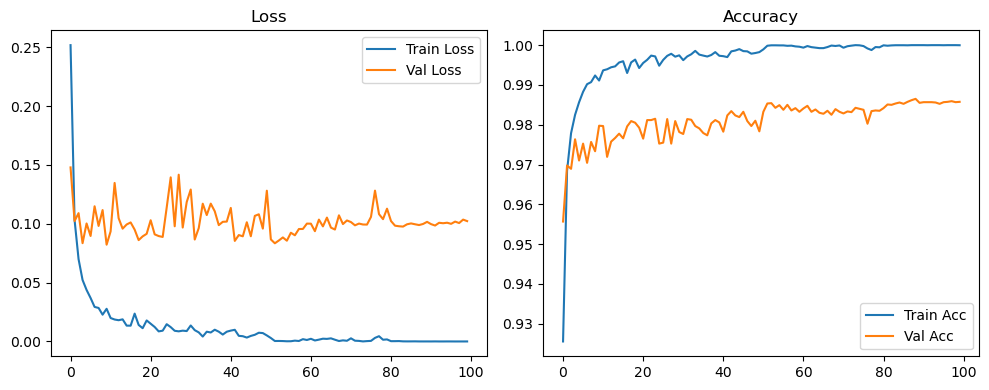

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2684, Acc: 0.9207 | Val Loss: 0.1574, Acc: 0.9534


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1188, Acc: 0.9630 | Val Loss: 0.1081, Acc: 0.9667


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0840, Acc: 0.9743 | Val Loss: 0.1002, Acc: 0.9713


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0697, Acc: 0.9786 | Val Loss: 0.0887, Acc: 0.9742


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0570, Acc: 0.9818 | Val Loss: 0.0838, Acc: 0.9765


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9834 | Val Loss: 0.0896, Acc: 0.9748


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9871 | Val Loss: 0.1019, Acc: 0.9737


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9881 | Val Loss: 0.1055, Acc: 0.9732


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9890 | Val Loss: 0.0984, Acc: 0.9748


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9889 | Val Loss: 0.0909, Acc: 0.9778


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9906 | Val Loss: 0.0945, Acc: 0.9768


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9909 | Val Loss: 0.1096, Acc: 0.9738


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9903 | Val Loss: 0.0917, Acc: 0.9773


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9908 | Val Loss: 0.0839, Acc: 0.9783


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9917 | Val Loss: 0.0827, Acc: 0.9777


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9918 | Val Loss: 0.0898, Acc: 0.9779


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9923 | Val Loss: 0.0974, Acc: 0.9781


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9930 | Val Loss: 0.1088, Acc: 0.9760


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9929 | Val Loss: 0.0904, Acc: 0.9805


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9938 | Val Loss: 0.1070, Acc: 0.9771


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9939 | Val Loss: 0.0794, Acc: 0.9800


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9941 | Val Loss: 0.0744, Acc: 0.9813


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.0928, Acc: 0.9793


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9941 | Val Loss: 0.1115, Acc: 0.9778


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9935 | Val Loss: 0.1007, Acc: 0.9782


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.0940, Acc: 0.9812


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9947 | Val Loss: 0.1059, Acc: 0.9778


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9953 | Val Loss: 0.0989, Acc: 0.9802


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9946 | Val Loss: 0.1009, Acc: 0.9794


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9949 | Val Loss: 0.0984, Acc: 0.9811


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9948 | Val Loss: 0.0933, Acc: 0.9802


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9963 | Val Loss: 0.0906, Acc: 0.9816


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9953 | Val Loss: 0.1070, Acc: 0.9789


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.0968, Acc: 0.9818


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9954 | Val Loss: 0.1089, Acc: 0.9803


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1071, Acc: 0.9792


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9961 | Val Loss: 0.0871, Acc: 0.9822


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9962 | Val Loss: 0.1009, Acc: 0.9816


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.0960, Acc: 0.9813


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.0930, Acc: 0.9814


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9971 | Val Loss: 0.0948, Acc: 0.9816


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9968 | Val Loss: 0.0973, Acc: 0.9821


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9964 | Val Loss: 0.0872, Acc: 0.9825


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9973 | Val Loss: 0.1115, Acc: 0.9801


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9963 | Val Loss: 0.1076, Acc: 0.9796


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9962 | Val Loss: 0.0945, Acc: 0.9820


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.0919, Acc: 0.9830


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.1049, Acc: 0.9845


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9964 | Val Loss: 0.0862, Acc: 0.9818


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9972 | Val Loss: 0.1010, Acc: 0.9818


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0810, Acc: 0.9847


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0884, Acc: 0.9839


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0848, Acc: 0.9853


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0917, Acc: 0.9850


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0957, Acc: 0.9851


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0989, Acc: 0.9845


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0980, Acc: 0.9858


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0984, Acc: 0.9851


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1007, Acc: 0.9845


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0955, Acc: 0.9848


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1030, Acc: 0.9840


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1067, Acc: 0.9843


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0991, Acc: 0.9839


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1031, Acc: 0.9842


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1117, Acc: 0.9832


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0950, Acc: 0.9853


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1075, Acc: 0.9842


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0997, Acc: 0.9844


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1039, Acc: 0.9834


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1034, Acc: 0.9848


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1005, Acc: 0.9830


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1085, Acc: 0.9838


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0970, Acc: 0.9825


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0946, Acc: 0.9844


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1036, Acc: 0.9836


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1054, Acc: 0.9840


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1116, Acc: 0.9836


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1097, Acc: 0.9838


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0961, Acc: 0.9858


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1129, Acc: 0.9845


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1045, Acc: 0.9850


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1026, Acc: 0.9857


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1067, Acc: 0.9851


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1013, Acc: 0.9868


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1028, Acc: 0.9859


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1039, Acc: 0.9866


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1027, Acc: 0.9867


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1050, Acc: 0.9861


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1046, Acc: 0.9861


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1039, Acc: 0.9861


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1026, Acc: 0.9856


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1092, Acc: 0.9859


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1099, Acc: 0.9859


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1112, Acc: 0.9857


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1043, Acc: 0.9862


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0994, Acc: 0.9857


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1123, Acc: 0.9849


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1109, Acc: 0.9844


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1177, Acc: 0.9848


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1092, Acc: 0.9851


Final Test Loss: 0.1006 Accuracy: 0.9861


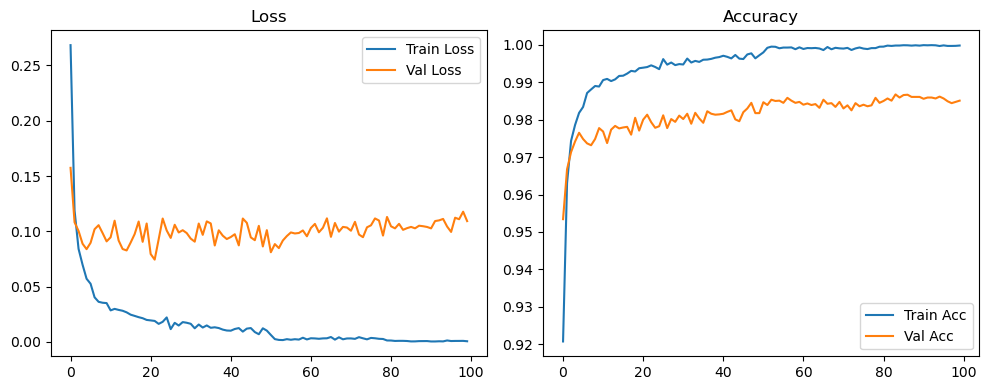

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3204, Acc: 0.9057 | Val Loss: 0.1489, Acc: 0.9563


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1738, Acc: 0.9486 | Val Loss: 0.1110, Acc: 0.9659


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1333, Acc: 0.9601 | Val Loss: 0.1004, Acc: 0.9710


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1151, Acc: 0.9649 | Val Loss: 0.0843, Acc: 0.9748


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0945, Acc: 0.9708 | Val Loss: 0.0829, Acc: 0.9759


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0903, Acc: 0.9724 | Val Loss: 0.0787, Acc: 0.9780


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0809, Acc: 0.9754 | Val Loss: 0.0803, Acc: 0.9782


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0740, Acc: 0.9764 | Val Loss: 0.0867, Acc: 0.9764


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0765, Acc: 0.9761 | Val Loss: 0.0900, Acc: 0.9750


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0675, Acc: 0.9791 | Val Loss: 0.0797, Acc: 0.9770


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0616, Acc: 0.9807 | Val Loss: 0.0763, Acc: 0.9781


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0613, Acc: 0.9805 | Val Loss: 0.0821, Acc: 0.9788


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0607, Acc: 0.9813 | Val Loss: 0.0682, Acc: 0.9807


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0557, Acc: 0.9823 | Val Loss: 0.0760, Acc: 0.9793


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0529, Acc: 0.9837 | Val Loss: 0.0744, Acc: 0.9798


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9835 | Val Loss: 0.0724, Acc: 0.9810


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9836 | Val Loss: 0.0758, Acc: 0.9807


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9851 | Val Loss: 0.0716, Acc: 0.9815


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9856 | Val Loss: 0.0781, Acc: 0.9811


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9858 | Val Loss: 0.0649, Acc: 0.9831


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0451, Acc: 0.9856 | Val Loss: 0.0679, Acc: 0.9817


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9870 | Val Loss: 0.0727, Acc: 0.9809


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9874 | Val Loss: 0.0736, Acc: 0.9818


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9872 | Val Loss: 0.0725, Acc: 0.9807


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9879 | Val Loss: 0.0756, Acc: 0.9810


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9880 | Val Loss: 0.0678, Acc: 0.9832


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9886 | Val Loss: 0.0760, Acc: 0.9824


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9874 | Val Loss: 0.0716, Acc: 0.9815


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9884 | Val Loss: 0.0758, Acc: 0.9813


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9888 | Val Loss: 0.0717, Acc: 0.9821


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0319, Acc: 0.9903 | Val Loss: 0.0724, Acc: 0.9831


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9903 | Val Loss: 0.0769, Acc: 0.9820


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9889 | Val Loss: 0.0735, Acc: 0.9822


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9901 | Val Loss: 0.0724, Acc: 0.9828


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9900 | Val Loss: 0.0746, Acc: 0.9840


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9907 | Val Loss: 0.0703, Acc: 0.9846


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9898 | Val Loss: 0.0793, Acc: 0.9838


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9902 | Val Loss: 0.0698, Acc: 0.9842


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9911 | Val Loss: 0.0704, Acc: 0.9842


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9916 | Val Loss: 0.0759, Acc: 0.9825


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9919 | Val Loss: 0.0809, Acc: 0.9832


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9916 | Val Loss: 0.0750, Acc: 0.9828


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9909 | Val Loss: 0.0811, Acc: 0.9824


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9914 | Val Loss: 0.0747, Acc: 0.9844


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9921 | Val Loss: 0.0759, Acc: 0.9840


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9924 | Val Loss: 0.0771, Acc: 0.9828


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9916 | Val Loss: 0.0781, Acc: 0.9829


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9925 | Val Loss: 0.0789, Acc: 0.9832


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9921 | Val Loss: 0.0800, Acc: 0.9841


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9918 | Val Loss: 0.0772, Acc: 0.9845


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9944 | Val Loss: 0.0727, Acc: 0.9852


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9957 | Val Loss: 0.0793, Acc: 0.9858


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.0770, Acc: 0.9856


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.0771, Acc: 0.9857


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.0776, Acc: 0.9853


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9971 | Val Loss: 0.0796, Acc: 0.9853


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.0768, Acc: 0.9858


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.0767, Acc: 0.9852


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9967 | Val Loss: 0.0761, Acc: 0.9858


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0848, Acc: 0.9854


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9974 | Val Loss: 0.0804, Acc: 0.9849


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.0802, Acc: 0.9850


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0830, Acc: 0.9854


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0892, Acc: 0.9850


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.0869, Acc: 0.9849


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0885, Acc: 0.9842


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0893, Acc: 0.9856


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0879, Acc: 0.9841


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.0865, Acc: 0.9841


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9972 | Val Loss: 0.0810, Acc: 0.9854


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.0804, Acc: 0.9852


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.0839, Acc: 0.9849


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.0821, Acc: 0.9854


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0897, Acc: 0.9849


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.0907, Acc: 0.9846


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9968 | Val Loss: 0.0891, Acc: 0.9832


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.0887, Acc: 0.9837


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0882, Acc: 0.9838


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9972 | Val Loss: 0.0914, Acc: 0.9840


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.0908, Acc: 0.9836


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.0857, Acc: 0.9847


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.0862, Acc: 0.9842


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0863, Acc: 0.9849


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0859, Acc: 0.9844


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.0867, Acc: 0.9846


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0885, Acc: 0.9852


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.0884, Acc: 0.9857


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0876, Acc: 0.9857


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0889, Acc: 0.9854


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0887, Acc: 0.9849


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0895, Acc: 0.9847


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0913, Acc: 0.9855


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0921, Acc: 0.9852


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0947, Acc: 0.9850


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0910, Acc: 0.9856


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0920, Acc: 0.9858


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0901, Acc: 0.9854


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0920, Acc: 0.9853


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0916, Acc: 0.9862


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0922, Acc: 0.9860


Final Test Loss: 0.0838 Accuracy: 0.9872


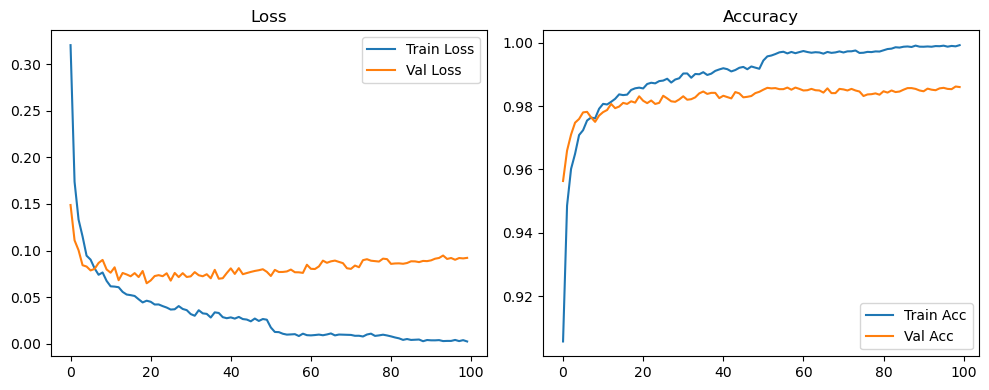

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2518, Acc: 0.9255 | Val Loss: 0.1479, Acc: 0.9557


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1034, Acc: 0.9684 | Val Loss: 0.1023, Acc: 0.9698


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0700, Acc: 0.9779 | Val Loss: 0.1090, Acc: 0.9689


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9825 | Val Loss: 0.0835, Acc: 0.9763


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0438, Acc: 0.9856 | Val Loss: 0.1003, Acc: 0.9710


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9883 | Val Loss: 0.0896, Acc: 0.9752


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9902 | Val Loss: 0.1149, Acc: 0.9704


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9907 | Val Loss: 0.0982, Acc: 0.9757


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9924 | Val Loss: 0.1116, Acc: 0.9733


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9911 | Val Loss: 0.0822, Acc: 0.9798


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9937 | Val Loss: 0.0935, Acc: 0.9797


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.1347, Acc: 0.9719


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9944 | Val Loss: 0.1048, Acc: 0.9758


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9947 | Val Loss: 0.0958, Acc: 0.9767


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.0994, Acc: 0.9778


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9960 | Val Loss: 0.1011, Acc: 0.9766


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9930 | Val Loss: 0.0950, Acc: 0.9796


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9957 | Val Loss: 0.0861, Acc: 0.9809


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.0893, Acc: 0.9805


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9942 | Val Loss: 0.0915, Acc: 0.9792


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9955 | Val Loss: 0.1030, Acc: 0.9765


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9963 | Val Loss: 0.0910, Acc: 0.9812


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.0896, Acc: 0.9812


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.0888, Acc: 0.9815


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9948 | Val Loss: 0.1138, Acc: 0.9752


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9963 | Val Loss: 0.1394, Acc: 0.9755


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.0979, Acc: 0.9814


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9978 | Val Loss: 0.1417, Acc: 0.9752


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.0968, Acc: 0.9809


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.1185, Acc: 0.9782


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9962 | Val Loss: 0.1291, Acc: 0.9777


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9972 | Val Loss: 0.0866, Acc: 0.9814


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.0963, Acc: 0.9812


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1170, Acc: 0.9797


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9976 | Val Loss: 0.1074, Acc: 0.9791


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.1171, Acc: 0.9779


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9971 | Val Loss: 0.1106, Acc: 0.9773


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.0989, Acc: 0.9803


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1017, Acc: 0.9812


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1019, Acc: 0.9806


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.1135, Acc: 0.9782


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.0854, Acc: 0.9823


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0904, Acc: 0.9834


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0893, Acc: 0.9823


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1013, Acc: 0.9819


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0894, Acc: 0.9832


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.1067, Acc: 0.9809


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.1081, Acc: 0.9797


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.0959, Acc: 0.9810


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1281, Acc: 0.9783


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0867, Acc: 0.9832


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0834, Acc: 0.9853


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0858, Acc: 0.9854


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0884, Acc: 0.9842


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0856, Acc: 0.9849


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0924, Acc: 0.9838


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0902, Acc: 0.9850


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0955, Acc: 0.9836


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9997 | Val Loss: 0.0956, Acc: 0.9842


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1001, Acc: 0.9832


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1001, Acc: 0.9841


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0937, Acc: 0.9848


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1035, Acc: 0.9832


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0978, Acc: 0.9838


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1052, Acc: 0.9830


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0967, Acc: 0.9828


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0951, Acc: 0.9835


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1072, Acc: 0.9825


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0998, Acc: 0.9839


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1028, Acc: 0.9832


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.1014, Acc: 0.9828


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0987, Acc: 0.9833


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1002, Acc: 0.9832


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0994, Acc: 0.9842


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0993, Acc: 0.9840


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1059, Acc: 0.9838


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1281, Acc: 0.9802


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.1082, Acc: 0.9834


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1039, Acc: 0.9836


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1128, Acc: 0.9835


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1039, Acc: 0.9846


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1025, Acc: 0.9842


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0989, Acc: 0.9842


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0989, Acc: 0.9848


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0994, Acc: 0.9846


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1001, Acc: 0.9850


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0983, Acc: 0.9855


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0980, Acc: 0.9848


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0994, Acc: 0.9855


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1001, Acc: 0.9850


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0987, Acc: 0.9857


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0983, Acc: 0.9857


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0990, Acc: 0.9849


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0989, Acc: 0.9851


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0982, Acc: 0.9848


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0982, Acc: 0.9855


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0998, Acc: 0.9852


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0992, Acc: 0.9849


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1012, Acc: 0.9849


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1008, Acc: 0.9856


Final Test Loss: 0.0904 Accuracy: 0.9866


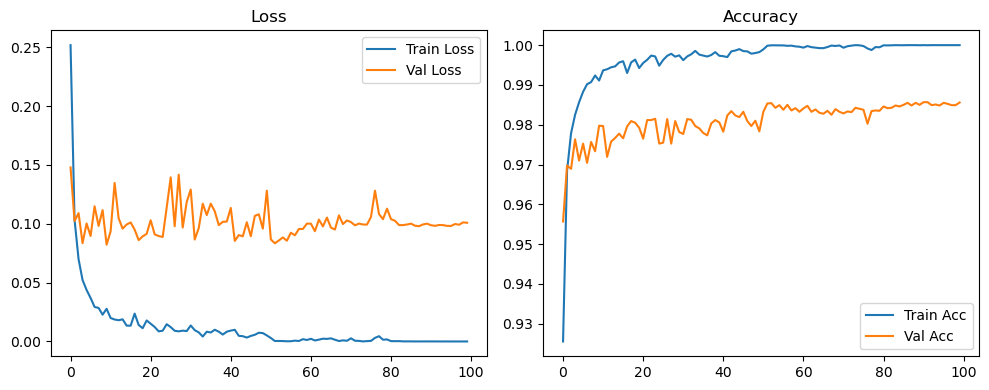

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2684, Acc: 0.9207 | Val Loss: 0.1574, Acc: 0.9534


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1188, Acc: 0.9630 | Val Loss: 0.1081, Acc: 0.9667


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0840, Acc: 0.9743 | Val Loss: 0.1002, Acc: 0.9713


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0697, Acc: 0.9786 | Val Loss: 0.0887, Acc: 0.9742


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0570, Acc: 0.9818 | Val Loss: 0.0838, Acc: 0.9765


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9834 | Val Loss: 0.0896, Acc: 0.9748


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9871 | Val Loss: 0.1019, Acc: 0.9737


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9881 | Val Loss: 0.1055, Acc: 0.9732


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9890 | Val Loss: 0.0984, Acc: 0.9748


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9889 | Val Loss: 0.0909, Acc: 0.9778


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9906 | Val Loss: 0.0945, Acc: 0.9768


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9909 | Val Loss: 0.1096, Acc: 0.9738


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9903 | Val Loss: 0.0917, Acc: 0.9773


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9908 | Val Loss: 0.0839, Acc: 0.9783


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9917 | Val Loss: 0.0827, Acc: 0.9777


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9918 | Val Loss: 0.0898, Acc: 0.9779


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9923 | Val Loss: 0.0974, Acc: 0.9781


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9930 | Val Loss: 0.1088, Acc: 0.9760


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9929 | Val Loss: 0.0904, Acc: 0.9805


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9938 | Val Loss: 0.1070, Acc: 0.9771


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9939 | Val Loss: 0.0794, Acc: 0.9800


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9941 | Val Loss: 0.0744, Acc: 0.9813


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.0928, Acc: 0.9793


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9941 | Val Loss: 0.1115, Acc: 0.9778


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9935 | Val Loss: 0.1007, Acc: 0.9782


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.0940, Acc: 0.9812


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9947 | Val Loss: 0.1059, Acc: 0.9778


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9953 | Val Loss: 0.0989, Acc: 0.9802


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9946 | Val Loss: 0.1009, Acc: 0.9794


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9949 | Val Loss: 0.0984, Acc: 0.9811


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9948 | Val Loss: 0.0933, Acc: 0.9802


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9963 | Val Loss: 0.0906, Acc: 0.9816


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9953 | Val Loss: 0.1070, Acc: 0.9789


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.0968, Acc: 0.9818


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9954 | Val Loss: 0.1089, Acc: 0.9803


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1071, Acc: 0.9792


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9961 | Val Loss: 0.0871, Acc: 0.9822


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9962 | Val Loss: 0.1009, Acc: 0.9816


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.0960, Acc: 0.9813


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.0930, Acc: 0.9814


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9971 | Val Loss: 0.0948, Acc: 0.9816


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9968 | Val Loss: 0.0973, Acc: 0.9821


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9964 | Val Loss: 0.0872, Acc: 0.9825


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9973 | Val Loss: 0.1115, Acc: 0.9801


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9963 | Val Loss: 0.1076, Acc: 0.9796


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9962 | Val Loss: 0.0945, Acc: 0.9820


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.0919, Acc: 0.9830


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.1049, Acc: 0.9845


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9964 | Val Loss: 0.0862, Acc: 0.9818


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9972 | Val Loss: 0.1010, Acc: 0.9818


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0810, Acc: 0.9847


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0884, Acc: 0.9839


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0848, Acc: 0.9853


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0917, Acc: 0.9850


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0957, Acc: 0.9851


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0989, Acc: 0.9845


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0980, Acc: 0.9858


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0984, Acc: 0.9851


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1007, Acc: 0.9845


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0955, Acc: 0.9848


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1030, Acc: 0.9840


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1067, Acc: 0.9843


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0991, Acc: 0.9839


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1031, Acc: 0.9842


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1117, Acc: 0.9832


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0950, Acc: 0.9853


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1075, Acc: 0.9842


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0997, Acc: 0.9844


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1039, Acc: 0.9834


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1034, Acc: 0.9848


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1005, Acc: 0.9830


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1085, Acc: 0.9838


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0970, Acc: 0.9825


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0946, Acc: 0.9844


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1036, Acc: 0.9836


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1054, Acc: 0.9840


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1116, Acc: 0.9836


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1097, Acc: 0.9838


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0961, Acc: 0.9858


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1129, Acc: 0.9845


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1060, Acc: 0.9850


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1049, Acc: 0.9856


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1060, Acc: 0.9851


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.1027, Acc: 0.9861


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1024, Acc: 0.9863


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1030, Acc: 0.9864


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1022, Acc: 0.9864


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1021, Acc: 0.9863


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1017, Acc: 0.9858


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0997, Acc: 0.9860


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0982, Acc: 0.9859


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1020, Acc: 0.9858


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1055, Acc: 0.9862


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1043, Acc: 0.9858


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1041, Acc: 0.9855


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1014, Acc: 0.9853


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1038, Acc: 0.9857


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1001, Acc: 0.9858


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1030, Acc: 0.9860


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1027, Acc: 0.9855


Final Test Loss: 0.0949 Accuracy: 0.9866


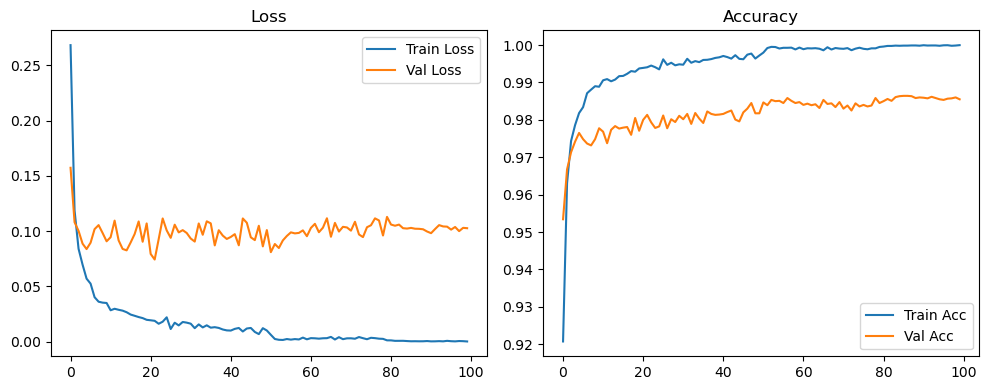

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3204, Acc: 0.9057 | Val Loss: 0.1489, Acc: 0.9563


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1738, Acc: 0.9486 | Val Loss: 0.1110, Acc: 0.9659


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1333, Acc: 0.9601 | Val Loss: 0.1004, Acc: 0.9710


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1151, Acc: 0.9649 | Val Loss: 0.0843, Acc: 0.9748


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0945, Acc: 0.9708 | Val Loss: 0.0829, Acc: 0.9759


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0903, Acc: 0.9724 | Val Loss: 0.0787, Acc: 0.9780


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0809, Acc: 0.9754 | Val Loss: 0.0803, Acc: 0.9782


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0740, Acc: 0.9764 | Val Loss: 0.0867, Acc: 0.9764


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0765, Acc: 0.9761 | Val Loss: 0.0900, Acc: 0.9750


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0675, Acc: 0.9791 | Val Loss: 0.0797, Acc: 0.9770


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0616, Acc: 0.9807 | Val Loss: 0.0763, Acc: 0.9781


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0613, Acc: 0.9805 | Val Loss: 0.0821, Acc: 0.9788


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0607, Acc: 0.9813 | Val Loss: 0.0682, Acc: 0.9807


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0557, Acc: 0.9823 | Val Loss: 0.0760, Acc: 0.9793


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0529, Acc: 0.9837 | Val Loss: 0.0744, Acc: 0.9798


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9835 | Val Loss: 0.0724, Acc: 0.9810


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9836 | Val Loss: 0.0758, Acc: 0.9807


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9851 | Val Loss: 0.0716, Acc: 0.9815


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9856 | Val Loss: 0.0781, Acc: 0.9811


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9858 | Val Loss: 0.0649, Acc: 0.9831


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0451, Acc: 0.9856 | Val Loss: 0.0679, Acc: 0.9817


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9870 | Val Loss: 0.0727, Acc: 0.9809


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9874 | Val Loss: 0.0736, Acc: 0.9818


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9872 | Val Loss: 0.0725, Acc: 0.9807


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9879 | Val Loss: 0.0756, Acc: 0.9810


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9880 | Val Loss: 0.0678, Acc: 0.9832


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9886 | Val Loss: 0.0760, Acc: 0.9824


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9874 | Val Loss: 0.0716, Acc: 0.9815


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9884 | Val Loss: 0.0758, Acc: 0.9813


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9888 | Val Loss: 0.0717, Acc: 0.9821


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0319, Acc: 0.9903 | Val Loss: 0.0724, Acc: 0.9831


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9903 | Val Loss: 0.0769, Acc: 0.9820


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9889 | Val Loss: 0.0735, Acc: 0.9822


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9901 | Val Loss: 0.0724, Acc: 0.9828


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9900 | Val Loss: 0.0746, Acc: 0.9840


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9907 | Val Loss: 0.0703, Acc: 0.9846


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9898 | Val Loss: 0.0793, Acc: 0.9838


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9902 | Val Loss: 0.0698, Acc: 0.9842


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9911 | Val Loss: 0.0704, Acc: 0.9842


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9916 | Val Loss: 0.0759, Acc: 0.9825


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9919 | Val Loss: 0.0809, Acc: 0.9832


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9916 | Val Loss: 0.0750, Acc: 0.9828


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9909 | Val Loss: 0.0811, Acc: 0.9824


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9914 | Val Loss: 0.0747, Acc: 0.9844


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9921 | Val Loss: 0.0759, Acc: 0.9840


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9924 | Val Loss: 0.0771, Acc: 0.9828


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9916 | Val Loss: 0.0781, Acc: 0.9829


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9925 | Val Loss: 0.0789, Acc: 0.9832


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9921 | Val Loss: 0.0800, Acc: 0.9841


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9918 | Val Loss: 0.0772, Acc: 0.9845


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9944 | Val Loss: 0.0727, Acc: 0.9852


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9957 | Val Loss: 0.0793, Acc: 0.9858


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.0770, Acc: 0.9856


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.0771, Acc: 0.9857


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.0776, Acc: 0.9853


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9971 | Val Loss: 0.0796, Acc: 0.9853


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.0768, Acc: 0.9858


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.0767, Acc: 0.9852


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9967 | Val Loss: 0.0761, Acc: 0.9858


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0848, Acc: 0.9854


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9974 | Val Loss: 0.0804, Acc: 0.9849


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.0802, Acc: 0.9850


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0830, Acc: 0.9854


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0892, Acc: 0.9850


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.0869, Acc: 0.9849


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0885, Acc: 0.9842


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0893, Acc: 0.9856


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0879, Acc: 0.9841


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.0865, Acc: 0.9841


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9972 | Val Loss: 0.0810, Acc: 0.9854


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.0804, Acc: 0.9852


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.0839, Acc: 0.9849


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.0821, Acc: 0.9854


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0897, Acc: 0.9849


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.0907, Acc: 0.9846


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9968 | Val Loss: 0.0891, Acc: 0.9832


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.0887, Acc: 0.9837


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0882, Acc: 0.9838


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9972 | Val Loss: 0.0914, Acc: 0.9840


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.0908, Acc: 0.9836


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.0863, Acc: 0.9841


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.0856, Acc: 0.9842


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0855, Acc: 0.9848


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0864, Acc: 0.9839


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0859, Acc: 0.9846


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0862, Acc: 0.9852


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.0863, Acc: 0.9854


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0863, Acc: 0.9858


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0871, Acc: 0.9852


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0863, Acc: 0.9851


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0870, Acc: 0.9854


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0900, Acc: 0.9856


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0892, Acc: 0.9851


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0928, Acc: 0.9851


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0899, Acc: 0.9858


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0897, Acc: 0.9857


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0882, Acc: 0.9856


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0888, Acc: 0.9860


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0900, Acc: 0.9860


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0900, Acc: 0.9855


Final Test Loss: 0.0807 Accuracy: 0.9875


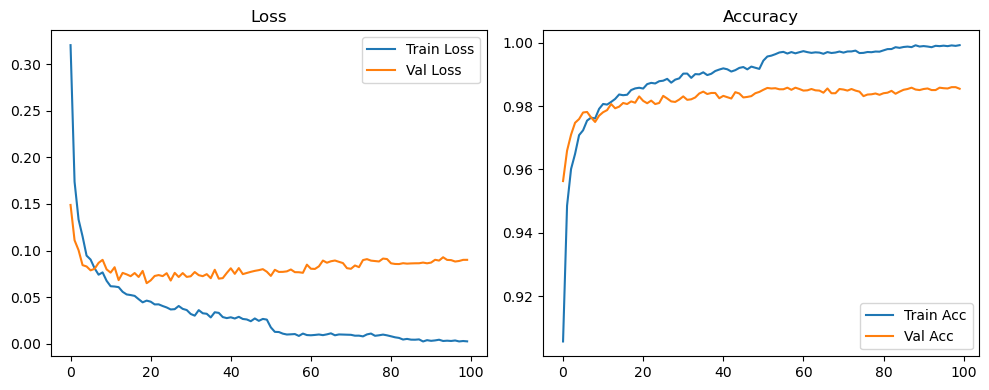

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2518, Acc: 0.9255 | Val Loss: 0.1479, Acc: 0.9557


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1034, Acc: 0.9684 | Val Loss: 0.1023, Acc: 0.9698


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0700, Acc: 0.9779 | Val Loss: 0.1090, Acc: 0.9689


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9825 | Val Loss: 0.0835, Acc: 0.9763


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0438, Acc: 0.9856 | Val Loss: 0.1003, Acc: 0.9710


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9883 | Val Loss: 0.0896, Acc: 0.9752


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9902 | Val Loss: 0.1149, Acc: 0.9704


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9907 | Val Loss: 0.0982, Acc: 0.9757


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9924 | Val Loss: 0.1116, Acc: 0.9733


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9911 | Val Loss: 0.0822, Acc: 0.9798


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9937 | Val Loss: 0.0935, Acc: 0.9797


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.1347, Acc: 0.9719


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9944 | Val Loss: 0.1048, Acc: 0.9758


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9947 | Val Loss: 0.0958, Acc: 0.9767


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.0994, Acc: 0.9778


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9960 | Val Loss: 0.1011, Acc: 0.9766


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9930 | Val Loss: 0.0950, Acc: 0.9796


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9957 | Val Loss: 0.0861, Acc: 0.9809


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.0893, Acc: 0.9805


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9942 | Val Loss: 0.0915, Acc: 0.9792


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9955 | Val Loss: 0.1030, Acc: 0.9765


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9963 | Val Loss: 0.0910, Acc: 0.9812


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.0896, Acc: 0.9812


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.0888, Acc: 0.9815


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9948 | Val Loss: 0.1138, Acc: 0.9752


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9963 | Val Loss: 0.1394, Acc: 0.9755


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.0979, Acc: 0.9814


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9978 | Val Loss: 0.1417, Acc: 0.9752


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.0968, Acc: 0.9809


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.1185, Acc: 0.9782


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9962 | Val Loss: 0.1291, Acc: 0.9777


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9972 | Val Loss: 0.0866, Acc: 0.9814


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.0963, Acc: 0.9812


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1170, Acc: 0.9797


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9976 | Val Loss: 0.1074, Acc: 0.9791


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.1171, Acc: 0.9779


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9971 | Val Loss: 0.1106, Acc: 0.9773


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.0989, Acc: 0.9803


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1017, Acc: 0.9812


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1019, Acc: 0.9806


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.1135, Acc: 0.9782


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.0854, Acc: 0.9823


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0904, Acc: 0.9834


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0893, Acc: 0.9823


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1013, Acc: 0.9819


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0894, Acc: 0.9832


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.1067, Acc: 0.9809


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.1081, Acc: 0.9797


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.0959, Acc: 0.9810


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1281, Acc: 0.9783


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0880, Acc: 0.9840


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0869, Acc: 0.9842


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0880, Acc: 0.9844


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0874, Acc: 0.9841


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0888, Acc: 0.9853


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0884, Acc: 0.9849


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0885, Acc: 0.9848


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0893, Acc: 0.9845


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0904, Acc: 0.9852


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0897, Acc: 0.9853


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0909, Acc: 0.9852


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0930, Acc: 0.9851


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0928, Acc: 0.9852


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0918, Acc: 0.9852


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0947, Acc: 0.9850


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0933, Acc: 0.9850


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0936, Acc: 0.9852


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0943, Acc: 0.9848


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0954, Acc: 0.9853


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0973, Acc: 0.9846


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0975, Acc: 0.9852


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1002, Acc: 0.9845


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0987, Acc: 0.9849


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1003, Acc: 0.9849


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1023, Acc: 0.9852


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1013, Acc: 0.9847


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1120, Acc: 0.9827


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1027, Acc: 0.9842


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1035, Acc: 0.9845


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1058, Acc: 0.9848


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1045, Acc: 0.9846


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1066, Acc: 0.9838


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1061, Acc: 0.9848


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1045, Acc: 0.9845


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1040, Acc: 0.9847


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1028, Acc: 0.9856


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1038, Acc: 0.9861


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1032, Acc: 0.9859


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1038, Acc: 0.9859


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1032, Acc: 0.9856


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1047, Acc: 0.9851


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1052, Acc: 0.9851


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1051, Acc: 0.9848


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1038, Acc: 0.9852


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1042, Acc: 0.9852


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1046, Acc: 0.9858


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1058, Acc: 0.9853


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1037, Acc: 0.9850


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1063, Acc: 0.9849


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1054, Acc: 0.9855


Final Test Loss: 0.0963 Accuracy: 0.9854


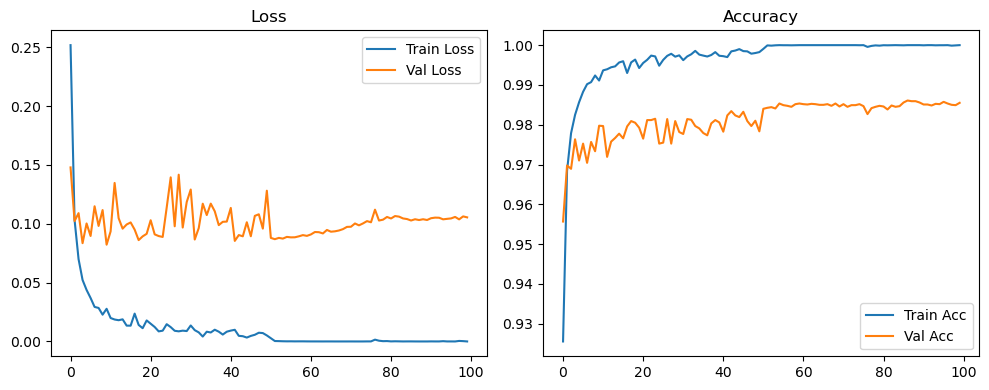

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2684, Acc: 0.9207 | Val Loss: 0.1574, Acc: 0.9534


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1188, Acc: 0.9630 | Val Loss: 0.1081, Acc: 0.9667


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0840, Acc: 0.9743 | Val Loss: 0.1002, Acc: 0.9713


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0697, Acc: 0.9786 | Val Loss: 0.0887, Acc: 0.9742


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0570, Acc: 0.9818 | Val Loss: 0.0838, Acc: 0.9765


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9834 | Val Loss: 0.0896, Acc: 0.9748


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9871 | Val Loss: 0.1019, Acc: 0.9737


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9881 | Val Loss: 0.1055, Acc: 0.9732


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9890 | Val Loss: 0.0984, Acc: 0.9748


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9889 | Val Loss: 0.0909, Acc: 0.9778


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9906 | Val Loss: 0.0945, Acc: 0.9768


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9909 | Val Loss: 0.1096, Acc: 0.9738


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9903 | Val Loss: 0.0917, Acc: 0.9773


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9908 | Val Loss: 0.0839, Acc: 0.9783


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9917 | Val Loss: 0.0827, Acc: 0.9777


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9918 | Val Loss: 0.0898, Acc: 0.9779


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9923 | Val Loss: 0.0974, Acc: 0.9781


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9930 | Val Loss: 0.1088, Acc: 0.9760


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9929 | Val Loss: 0.0904, Acc: 0.9805


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9938 | Val Loss: 0.1070, Acc: 0.9771


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9939 | Val Loss: 0.0794, Acc: 0.9800


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9941 | Val Loss: 0.0744, Acc: 0.9813


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.0928, Acc: 0.9793


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9941 | Val Loss: 0.1115, Acc: 0.9778


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9935 | Val Loss: 0.1007, Acc: 0.9782


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.0940, Acc: 0.9812


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9947 | Val Loss: 0.1059, Acc: 0.9778


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9953 | Val Loss: 0.0989, Acc: 0.9802


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9946 | Val Loss: 0.1009, Acc: 0.9794


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9949 | Val Loss: 0.0984, Acc: 0.9811


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9948 | Val Loss: 0.0933, Acc: 0.9802


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9963 | Val Loss: 0.0906, Acc: 0.9816


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9953 | Val Loss: 0.1070, Acc: 0.9789


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.0968, Acc: 0.9818


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9954 | Val Loss: 0.1089, Acc: 0.9803


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1071, Acc: 0.9792


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9961 | Val Loss: 0.0871, Acc: 0.9822


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9962 | Val Loss: 0.1009, Acc: 0.9816


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.0960, Acc: 0.9813


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.0930, Acc: 0.9814


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9971 | Val Loss: 0.0948, Acc: 0.9816


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9968 | Val Loss: 0.0973, Acc: 0.9821


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9964 | Val Loss: 0.0872, Acc: 0.9825


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9973 | Val Loss: 0.1115, Acc: 0.9801


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9963 | Val Loss: 0.1076, Acc: 0.9796


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9962 | Val Loss: 0.0945, Acc: 0.9820


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.0919, Acc: 0.9830


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.1049, Acc: 0.9845


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9964 | Val Loss: 0.0862, Acc: 0.9818


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9972 | Val Loss: 0.1010, Acc: 0.9818


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0817, Acc: 0.9841


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0800, Acc: 0.9846


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0811, Acc: 0.9848


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0835, Acc: 0.9856


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0841, Acc: 0.9850


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0864, Acc: 0.9852


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0877, Acc: 0.9858


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0837, Acc: 0.9860


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0870, Acc: 0.9861


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0863, Acc: 0.9863


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0883, Acc: 0.9852


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0948, Acc: 0.9848


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0988, Acc: 0.9854


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0936, Acc: 0.9856


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0958, Acc: 0.9858


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0954, Acc: 0.9852


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0996, Acc: 0.9851


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1016, Acc: 0.9847


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0985, Acc: 0.9852


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1044, Acc: 0.9853


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0998, Acc: 0.9856


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1007, Acc: 0.9855


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1021, Acc: 0.9844


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0981, Acc: 0.9856


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1072, Acc: 0.9843


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.1022, Acc: 0.9848


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1027, Acc: 0.9853


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1016, Acc: 0.9850


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1051, Acc: 0.9852


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1045, Acc: 0.9852


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1018, Acc: 0.9854


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1035, Acc: 0.9865


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1058, Acc: 0.9858


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1056, Acc: 0.9858


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1031, Acc: 0.9850


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1028, Acc: 0.9858


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1015, Acc: 0.9863


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1030, Acc: 0.9855


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9998 | Val Loss: 0.1056, Acc: 0.9859


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1030, Acc: 0.9853


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1032, Acc: 0.9853


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1063, Acc: 0.9853


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1037, Acc: 0.9856


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1040, Acc: 0.9852


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1058, Acc: 0.9855


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1067, Acc: 0.9859


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1082, Acc: 0.9849


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1071, Acc: 0.9853


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1082, Acc: 0.9856


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1059, Acc: 0.9852


Final Test Loss: 0.0949 Accuracy: 0.9861


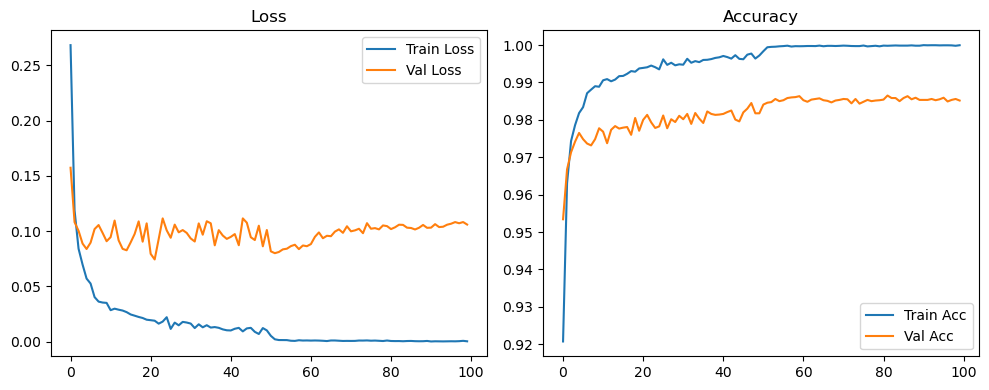

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3204, Acc: 0.9057 | Val Loss: 0.1489, Acc: 0.9563


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1738, Acc: 0.9486 | Val Loss: 0.1110, Acc: 0.9659


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1333, Acc: 0.9601 | Val Loss: 0.1004, Acc: 0.9710


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1151, Acc: 0.9649 | Val Loss: 0.0843, Acc: 0.9748


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0945, Acc: 0.9708 | Val Loss: 0.0829, Acc: 0.9759


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0903, Acc: 0.9724 | Val Loss: 0.0787, Acc: 0.9780


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0809, Acc: 0.9754 | Val Loss: 0.0803, Acc: 0.9782


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0740, Acc: 0.9764 | Val Loss: 0.0867, Acc: 0.9764


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0765, Acc: 0.9761 | Val Loss: 0.0900, Acc: 0.9750


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0675, Acc: 0.9791 | Val Loss: 0.0797, Acc: 0.9770


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0616, Acc: 0.9807 | Val Loss: 0.0763, Acc: 0.9781


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0613, Acc: 0.9805 | Val Loss: 0.0821, Acc: 0.9788


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0607, Acc: 0.9813 | Val Loss: 0.0682, Acc: 0.9807


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0557, Acc: 0.9823 | Val Loss: 0.0760, Acc: 0.9793


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0529, Acc: 0.9837 | Val Loss: 0.0744, Acc: 0.9798


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9835 | Val Loss: 0.0724, Acc: 0.9810


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9836 | Val Loss: 0.0758, Acc: 0.9807


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9851 | Val Loss: 0.0716, Acc: 0.9815


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9856 | Val Loss: 0.0781, Acc: 0.9811


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9858 | Val Loss: 0.0649, Acc: 0.9831


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0451, Acc: 0.9856 | Val Loss: 0.0679, Acc: 0.9817


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9870 | Val Loss: 0.0727, Acc: 0.9809


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9874 | Val Loss: 0.0736, Acc: 0.9818


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9872 | Val Loss: 0.0725, Acc: 0.9807


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9879 | Val Loss: 0.0756, Acc: 0.9810


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9880 | Val Loss: 0.0678, Acc: 0.9832


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9886 | Val Loss: 0.0760, Acc: 0.9824


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9874 | Val Loss: 0.0716, Acc: 0.9815


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9884 | Val Loss: 0.0758, Acc: 0.9813


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9888 | Val Loss: 0.0717, Acc: 0.9821


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0319, Acc: 0.9903 | Val Loss: 0.0724, Acc: 0.9831


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9903 | Val Loss: 0.0769, Acc: 0.9820


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9889 | Val Loss: 0.0735, Acc: 0.9822


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9901 | Val Loss: 0.0724, Acc: 0.9828


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9900 | Val Loss: 0.0746, Acc: 0.9840


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9907 | Val Loss: 0.0703, Acc: 0.9846


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9898 | Val Loss: 0.0793, Acc: 0.9838


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9902 | Val Loss: 0.0698, Acc: 0.9842


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9911 | Val Loss: 0.0704, Acc: 0.9842


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9916 | Val Loss: 0.0759, Acc: 0.9825


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9919 | Val Loss: 0.0809, Acc: 0.9832


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9916 | Val Loss: 0.0750, Acc: 0.9828


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9909 | Val Loss: 0.0811, Acc: 0.9824


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9914 | Val Loss: 0.0747, Acc: 0.9844


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9921 | Val Loss: 0.0759, Acc: 0.9840


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9924 | Val Loss: 0.0771, Acc: 0.9828


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9916 | Val Loss: 0.0781, Acc: 0.9829


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9925 | Val Loss: 0.0789, Acc: 0.9832


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9921 | Val Loss: 0.0800, Acc: 0.9841


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9918 | Val Loss: 0.0772, Acc: 0.9845


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9946 | Val Loss: 0.0721, Acc: 0.9852


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.0722, Acc: 0.9849


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.0739, Acc: 0.9852


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.0736, Acc: 0.9857


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0736, Acc: 0.9858


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9977 | Val Loss: 0.0745, Acc: 0.9854


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.0758, Acc: 0.9862


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0733, Acc: 0.9864


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0730, Acc: 0.9870


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.0774, Acc: 0.9864


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0757, Acc: 0.9862


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0776, Acc: 0.9865


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.0801, Acc: 0.9860


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0828, Acc: 0.9858


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0807, Acc: 0.9860


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0834, Acc: 0.9861


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0845, Acc: 0.9859


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0852, Acc: 0.9854


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.0813, Acc: 0.9863


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0825, Acc: 0.9864


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0804, Acc: 0.9867


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0826, Acc: 0.9868


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0825, Acc: 0.9867


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0877, Acc: 0.9862


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0861, Acc: 0.9864


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.0873, Acc: 0.9863


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0858, Acc: 0.9862


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0829, Acc: 0.9869


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0847, Acc: 0.9861


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0876, Acc: 0.9862


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0875, Acc: 0.9858


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.0846, Acc: 0.9861


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0859, Acc: 0.9855


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0850, Acc: 0.9857


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0840, Acc: 0.9860


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0838, Acc: 0.9862


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0840, Acc: 0.9866


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0859, Acc: 0.9862


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0866, Acc: 0.9862


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0866, Acc: 0.9863


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0863, Acc: 0.9864


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.0900, Acc: 0.9868


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0903, Acc: 0.9862


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0925, Acc: 0.9865


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0928, Acc: 0.9868


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0912, Acc: 0.9868


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0864, Acc: 0.9868


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0866, Acc: 0.9871


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0887, Acc: 0.9863


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0869, Acc: 0.9868


Final Test Loss: 0.0806 Accuracy: 0.9873


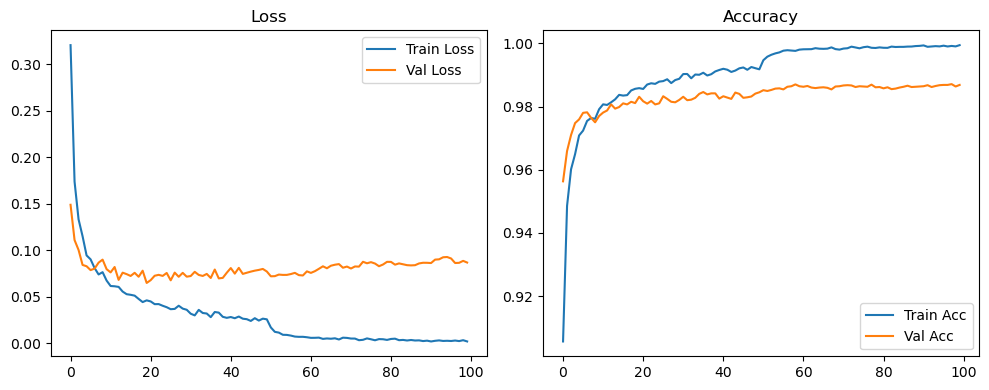

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2210, Acc: 0.9326 | Val Loss: 0.1327, Acc: 0.9584


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0960, Acc: 0.9702 | Val Loss: 0.0974, Acc: 0.9710


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0614, Acc: 0.9800 | Val Loss: 0.0963, Acc: 0.9723


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0477, Acc: 0.9845 | Val Loss: 0.0842, Acc: 0.9761


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0404, Acc: 0.9863 | Val Loss: 0.0997, Acc: 0.9731


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9890 | Val Loss: 0.1043, Acc: 0.9734


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9915 | Val Loss: 0.0880, Acc: 0.9778


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9925 | Val Loss: 0.1365, Acc: 0.9681


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9932 | Val Loss: 0.0861, Acc: 0.9778


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.1082, Acc: 0.9741


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9933 | Val Loss: 0.0867, Acc: 0.9790


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.1068, Acc: 0.9767


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9933 | Val Loss: 0.0874, Acc: 0.9783


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9948 | Val Loss: 0.0951, Acc: 0.9787


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.0961, Acc: 0.9786


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.1019, Acc: 0.9789


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9948 | Val Loss: 0.1024, Acc: 0.9781


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.0964, Acc: 0.9811


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9966 | Val Loss: 0.0920, Acc: 0.9802


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9959 | Val Loss: 0.0935, Acc: 0.9786


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.0968, Acc: 0.9793


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9950 | Val Loss: 0.0927, Acc: 0.9789


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0886, Acc: 0.9811


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0970, Acc: 0.9803


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1132, Acc: 0.9778


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.1140, Acc: 0.9773


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.1169, Acc: 0.9768


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.1054, Acc: 0.9800


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.0837, Acc: 0.9823


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.0916, Acc: 0.9803


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9980 | Val Loss: 0.1093, Acc: 0.9808


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9975 | Val Loss: 0.0970, Acc: 0.9816


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9980 | Val Loss: 0.1097, Acc: 0.9787


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1022, Acc: 0.9799


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0993, Acc: 0.9809


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1131, Acc: 0.9788


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.1272, Acc: 0.9761


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.0987, Acc: 0.9794


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9977 | Val Loss: 0.0914, Acc: 0.9807


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1022, Acc: 0.9795


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.0911, Acc: 0.9839


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1015, Acc: 0.9808


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0838, Acc: 0.9842


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1008, Acc: 0.9822


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9977 | Val Loss: 0.1267, Acc: 0.9760


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.0987, Acc: 0.9789


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.0922, Acc: 0.9813


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1084, Acc: 0.9798


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0995, Acc: 0.9811


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0948, Acc: 0.9822


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1103, Acc: 0.9807


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.0966, Acc: 0.9828


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1056, Acc: 0.9818


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0978, Acc: 0.9834


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1133, Acc: 0.9808


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.1037, Acc: 0.9808


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.0970, Acc: 0.9819


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0909, Acc: 0.9829


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1135, Acc: 0.9796


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0947, Acc: 0.9819


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0954, Acc: 0.9827


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0980, Acc: 0.9832


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0990, Acc: 0.9822


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1047, Acc: 0.9808


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0938, Acc: 0.9823


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0902, Acc: 0.9829


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0924, Acc: 0.9830


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0958, Acc: 0.9829


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9991 | Val Loss: 0.1074, Acc: 0.9817


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0938, Acc: 0.9822


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0939, Acc: 0.9837


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0932, Acc: 0.9833


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9987 | Val Loss: 0.1124, Acc: 0.9808


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1187, Acc: 0.9798


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1005, Acc: 0.9798


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0938, Acc: 0.9822


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1003, Acc: 0.9821


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1173, Acc: 0.9809


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1051, Acc: 0.9820


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1016, Acc: 0.9830


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1065, Acc: 0.9829


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.1059, Acc: 0.9820


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.0872, Acc: 0.9822


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.0856, Acc: 0.9846


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0940, Acc: 0.9832


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1154, Acc: 0.9810


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0977, Acc: 0.9845


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1034, Acc: 0.9828


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0984, Acc: 0.9831


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1054, Acc: 0.9818


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1000, Acc: 0.9832


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0983, Acc: 0.9821


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1041, Acc: 0.9833


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0952, Acc: 0.9839


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0999, Acc: 0.9832


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9994 | Val Loss: 0.0945, Acc: 0.9828


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1013, Acc: 0.9831


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1080, Acc: 0.9832


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1035, Acc: 0.9823


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1127, Acc: 0.9806


Final Test Loss: 0.0942 Accuracy: 0.9844


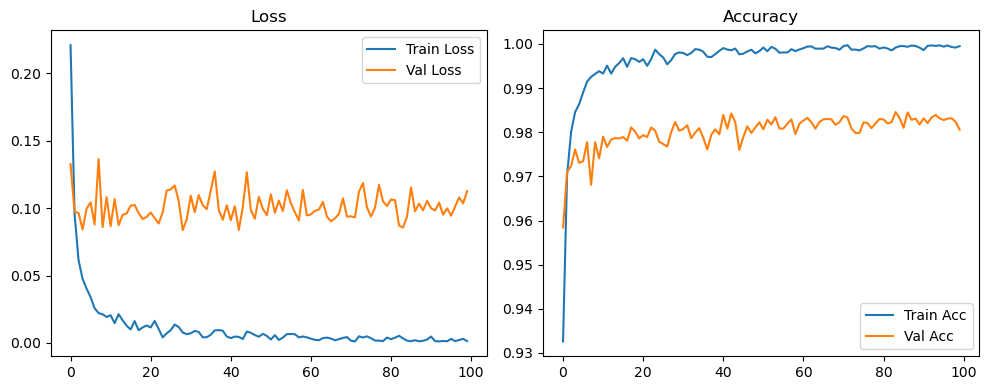

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2322, Acc: 0.9291 | Val Loss: 0.1536, Acc: 0.9555


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1129, Acc: 0.9659 | Val Loss: 0.1003, Acc: 0.9700


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0764, Acc: 0.9764 | Val Loss: 0.0927, Acc: 0.9738


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0658, Acc: 0.9798 | Val Loss: 0.0820, Acc: 0.9765


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0493, Acc: 0.9839 | Val Loss: 0.0964, Acc: 0.9732


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9845 | Val Loss: 0.0939, Acc: 0.9762


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9873 | Val Loss: 0.0867, Acc: 0.9763


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9888 | Val Loss: 0.1148, Acc: 0.9710


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9894 | Val Loss: 0.0918, Acc: 0.9762


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9900 | Val Loss: 0.0839, Acc: 0.9780


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9913 | Val Loss: 0.0893, Acc: 0.9789


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9913 | Val Loss: 0.0976, Acc: 0.9756


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9932 | Val Loss: 0.0875, Acc: 0.9795


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9924 | Val Loss: 0.0869, Acc: 0.9776


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9925 | Val Loss: 0.0801, Acc: 0.9813


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9932 | Val Loss: 0.0846, Acc: 0.9792


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9929 | Val Loss: 0.0813, Acc: 0.9795


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9948 | Val Loss: 0.0907, Acc: 0.9793


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9940 | Val Loss: 0.0751, Acc: 0.9829


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9952 | Val Loss: 0.0942, Acc: 0.9788


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9949 | Val Loss: 0.0928, Acc: 0.9812


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9960 | Val Loss: 0.0873, Acc: 0.9805


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9953 | Val Loss: 0.0837, Acc: 0.9818


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.0822, Acc: 0.9805


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9956 | Val Loss: 0.0948, Acc: 0.9801


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9956 | Val Loss: 0.0803, Acc: 0.9814


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.0910, Acc: 0.9817


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.0919, Acc: 0.9817


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9948 | Val Loss: 0.0945, Acc: 0.9809


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9957 | Val Loss: 0.0934, Acc: 0.9813


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9967 | Val Loss: 0.0845, Acc: 0.9831


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.1022, Acc: 0.9814


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9964 | Val Loss: 0.1010, Acc: 0.9804


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.0900, Acc: 0.9824


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9957 | Val Loss: 0.0895, Acc: 0.9822


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.0987, Acc: 0.9818


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0923, Acc: 0.9829


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9969 | Val Loss: 0.0910, Acc: 0.9812


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9963 | Val Loss: 0.0836, Acc: 0.9832


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.0935, Acc: 0.9825


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0935, Acc: 0.9827


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1059, Acc: 0.9812


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9970 | Val Loss: 0.0881, Acc: 0.9832


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0978, Acc: 0.9827


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0876, Acc: 0.9818


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.0857, Acc: 0.9833


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0869, Acc: 0.9832


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9973 | Val Loss: 0.0869, Acc: 0.9828


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0858, Acc: 0.9828


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.0839, Acc: 0.9831


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0868, Acc: 0.9840


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.0905, Acc: 0.9832


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0931, Acc: 0.9832


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.0997, Acc: 0.9798


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.0868, Acc: 0.9833


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.0895, Acc: 0.9836


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0944, Acc: 0.9827


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0929, Acc: 0.9827


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.0907, Acc: 0.9832


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.0915, Acc: 0.9839


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0948, Acc: 0.9831


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1020, Acc: 0.9817


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0899, Acc: 0.9835


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9985 | Val Loss: 0.1045, Acc: 0.9824


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0942, Acc: 0.9838


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0890, Acc: 0.9835


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9984 | Val Loss: 0.0943, Acc: 0.9831


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.0927, Acc: 0.9835


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0935, Acc: 0.9834


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0905, Acc: 0.9843


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9986 | Val Loss: 0.1011, Acc: 0.9831


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1039, Acc: 0.9821


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1026, Acc: 0.9825


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.0983, Acc: 0.9822


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0987, Acc: 0.9831


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0974, Acc: 0.9828


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.0936, Acc: 0.9822


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1146, Acc: 0.9812


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9981 | Val Loss: 0.1061, Acc: 0.9828


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1053, Acc: 0.9823


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0935, Acc: 0.9836


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0893, Acc: 0.9837


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.0965, Acc: 0.9832


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0895, Acc: 0.9842


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0867, Acc: 0.9842


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0958, Acc: 0.9838


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0954, Acc: 0.9837


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0900, Acc: 0.9847


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1046, Acc: 0.9834


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0983, Acc: 0.9828


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1005, Acc: 0.9828


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0948, Acc: 0.9835


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1073, Acc: 0.9818


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.0980, Acc: 0.9826


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0933, Acc: 0.9843


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0940, Acc: 0.9835


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0996, Acc: 0.9853


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.0933, Acc: 0.9841


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.1033, Acc: 0.9840


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0967, Acc: 0.9836


Final Test Loss: 0.0784 Accuracy: 0.9861


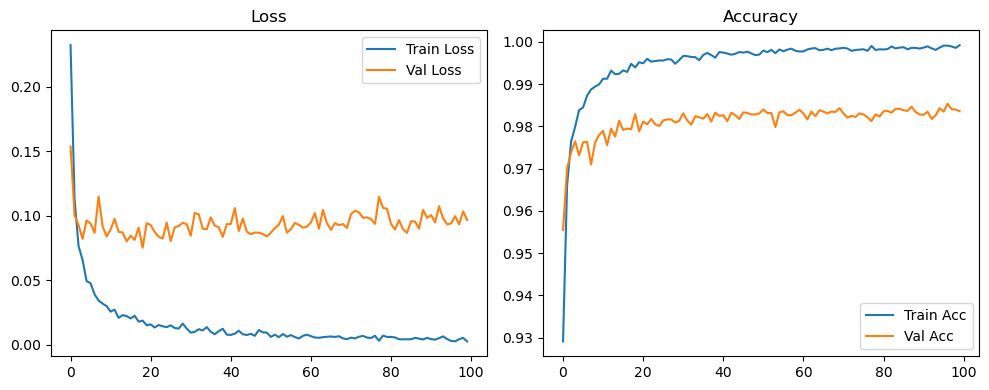

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2854, Acc: 0.9129 | Val Loss: 0.1512, Acc: 0.9573


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1663, Acc: 0.9497 | Val Loss: 0.1116, Acc: 0.9671


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1285, Acc: 0.9608 | Val Loss: 0.1059, Acc: 0.9694


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1055, Acc: 0.9669 | Val Loss: 0.0857, Acc: 0.9743


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0960, Acc: 0.9700 | Val Loss: 0.0870, Acc: 0.9737


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0832, Acc: 0.9737 | Val Loss: 0.0845, Acc: 0.9751


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0764, Acc: 0.9766 | Val Loss: 0.0761, Acc: 0.9785


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0650, Acc: 0.9797 | Val Loss: 0.0775, Acc: 0.9770


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0627, Acc: 0.9806 | Val Loss: 0.0760, Acc: 0.9778


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0609, Acc: 0.9803 | Val Loss: 0.0738, Acc: 0.9793


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0553, Acc: 0.9820 | Val Loss: 0.0852, Acc: 0.9758


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0561, Acc: 0.9818 | Val Loss: 0.0759, Acc: 0.9792


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0509, Acc: 0.9840 | Val Loss: 0.0722, Acc: 0.9798


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0492, Acc: 0.9842 | Val Loss: 0.0670, Acc: 0.9810


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0432, Acc: 0.9860 | Val Loss: 0.0703, Acc: 0.9814


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0397, Acc: 0.9874 | Val Loss: 0.0711, Acc: 0.9825


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0433, Acc: 0.9864 | Val Loss: 0.0734, Acc: 0.9798


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9871 | Val Loss: 0.0711, Acc: 0.9807


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0383, Acc: 0.9870 | Val Loss: 0.0718, Acc: 0.9814


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9875 | Val Loss: 0.0737, Acc: 0.9813


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0374, Acc: 0.9879 | Val Loss: 0.0705, Acc: 0.9808


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9879 | Val Loss: 0.0699, Acc: 0.9823


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9898 | Val Loss: 0.0671, Acc: 0.9825


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9900 | Val Loss: 0.0721, Acc: 0.9813


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9887 | Val Loss: 0.0736, Acc: 0.9818


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9905 | Val Loss: 0.0711, Acc: 0.9822


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9891 | Val Loss: 0.0721, Acc: 0.9837


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9906 | Val Loss: 0.0710, Acc: 0.9818


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9896 | Val Loss: 0.0741, Acc: 0.9815


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9904 | Val Loss: 0.0664, Acc: 0.9837


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9907 | Val Loss: 0.0646, Acc: 0.9845


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9919 | Val Loss: 0.0711, Acc: 0.9823


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9917 | Val Loss: 0.0750, Acc: 0.9837


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9920 | Val Loss: 0.0752, Acc: 0.9836


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9918 | Val Loss: 0.0753, Acc: 0.9827


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9915 | Val Loss: 0.0672, Acc: 0.9835


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0269, Acc: 0.9914 | Val Loss: 0.0756, Acc: 0.9820


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9925 | Val Loss: 0.0696, Acc: 0.9838


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9929 | Val Loss: 0.0723, Acc: 0.9829


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9928 | Val Loss: 0.0716, Acc: 0.9841


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9931 | Val Loss: 0.0770, Acc: 0.9828


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9936 | Val Loss: 0.0777, Acc: 0.9826


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0235, Acc: 0.9928 | Val Loss: 0.0734, Acc: 0.9835


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.0733, Acc: 0.9832


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9931 | Val Loss: 0.0703, Acc: 0.9849


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9934 | Val Loss: 0.0754, Acc: 0.9834


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9935 | Val Loss: 0.0706, Acc: 0.9834


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.0759, Acc: 0.9836


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9940 | Val Loss: 0.0796, Acc: 0.9832


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9937 | Val Loss: 0.0777, Acc: 0.9847


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9926 | Val Loss: 0.0795, Acc: 0.9826


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9946 | Val Loss: 0.0792, Acc: 0.9826


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9938 | Val Loss: 0.0802, Acc: 0.9836


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9942 | Val Loss: 0.0811, Acc: 0.9835


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9937 | Val Loss: 0.0754, Acc: 0.9840


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9940 | Val Loss: 0.0776, Acc: 0.9828


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9934 | Val Loss: 0.0718, Acc: 0.9852


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9945 | Val Loss: 0.0771, Acc: 0.9852


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9944 | Val Loss: 0.0777, Acc: 0.9835


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9952 | Val Loss: 0.0832, Acc: 0.9834


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9948 | Val Loss: 0.0791, Acc: 0.9838


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9947 | Val Loss: 0.0779, Acc: 0.9837


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9954 | Val Loss: 0.0735, Acc: 0.9844


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9954 | Val Loss: 0.0776, Acc: 0.9834


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9951 | Val Loss: 0.0758, Acc: 0.9838


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9953 | Val Loss: 0.0774, Acc: 0.9841


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.0731, Acc: 0.9836


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9954 | Val Loss: 0.0746, Acc: 0.9840


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9958 | Val Loss: 0.0812, Acc: 0.9848


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.0791, Acc: 0.9842


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9950 | Val Loss: 0.0795, Acc: 0.9839


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9953 | Val Loss: 0.0786, Acc: 0.9840


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9955 | Val Loss: 0.0742, Acc: 0.9831


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9961 | Val Loss: 0.0721, Acc: 0.9842


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9956 | Val Loss: 0.0815, Acc: 0.9838


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.0807, Acc: 0.9841


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9954 | Val Loss: 0.0828, Acc: 0.9838


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9958 | Val Loss: 0.0722, Acc: 0.9852


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9959 | Val Loss: 0.0823, Acc: 0.9838


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9953 | Val Loss: 0.0735, Acc: 0.9844


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.0765, Acc: 0.9857


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.0763, Acc: 0.9858


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9961 | Val Loss: 0.0774, Acc: 0.9841


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9967 | Val Loss: 0.0765, Acc: 0.9854


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9962 | Val Loss: 0.0824, Acc: 0.9836


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.0822, Acc: 0.9841


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9960 | Val Loss: 0.0818, Acc: 0.9832


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9954 | Val Loss: 0.0805, Acc: 0.9842


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.0799, Acc: 0.9826


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9965 | Val Loss: 0.0854, Acc: 0.9839


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.0826, Acc: 0.9838


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9965 | Val Loss: 0.0747, Acc: 0.9844


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9961 | Val Loss: 0.0759, Acc: 0.9852


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9962 | Val Loss: 0.0855, Acc: 0.9843


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.0800, Acc: 0.9839


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9964 | Val Loss: 0.0845, Acc: 0.9845


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.0853, Acc: 0.9838


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9960 | Val Loss: 0.0805, Acc: 0.9843


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9962 | Val Loss: 0.0808, Acc: 0.9848


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.0793, Acc: 0.9846


Final Test Loss: 0.0833 Accuracy: 0.9848


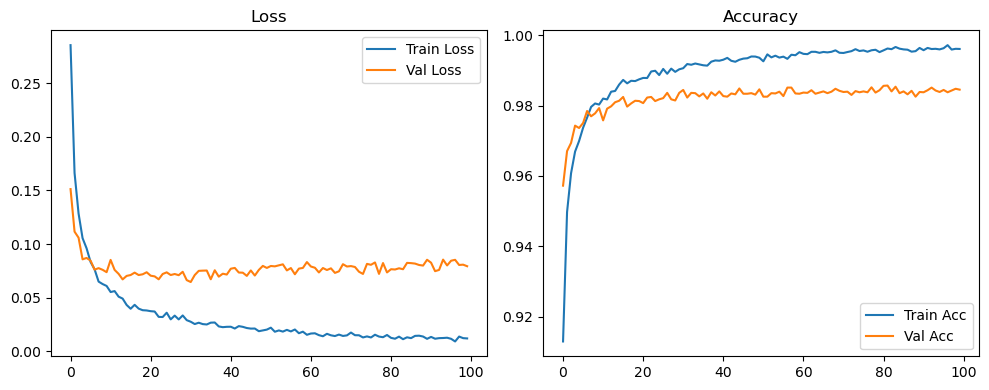

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2210, Acc: 0.9326 | Val Loss: 0.1327, Acc: 0.9584


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0960, Acc: 0.9702 | Val Loss: 0.0974, Acc: 0.9710


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0614, Acc: 0.9800 | Val Loss: 0.0963, Acc: 0.9723


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0477, Acc: 0.9845 | Val Loss: 0.0842, Acc: 0.9761


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0404, Acc: 0.9863 | Val Loss: 0.0997, Acc: 0.9731


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9890 | Val Loss: 0.1043, Acc: 0.9734


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9915 | Val Loss: 0.0880, Acc: 0.9778


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9925 | Val Loss: 0.1365, Acc: 0.9681


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9932 | Val Loss: 0.0861, Acc: 0.9778


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.1082, Acc: 0.9741


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9933 | Val Loss: 0.0867, Acc: 0.9790


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.1068, Acc: 0.9767


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9933 | Val Loss: 0.0874, Acc: 0.9783


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9948 | Val Loss: 0.0951, Acc: 0.9787


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.0961, Acc: 0.9786


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.1019, Acc: 0.9789


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9948 | Val Loss: 0.1024, Acc: 0.9781


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.0964, Acc: 0.9811


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9966 | Val Loss: 0.0920, Acc: 0.9802


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9959 | Val Loss: 0.0935, Acc: 0.9786


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.0968, Acc: 0.9793


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9950 | Val Loss: 0.0927, Acc: 0.9789


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0886, Acc: 0.9811


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0970, Acc: 0.9803


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1132, Acc: 0.9778


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.1140, Acc: 0.9773


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.1169, Acc: 0.9768


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.1054, Acc: 0.9800


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.0837, Acc: 0.9823


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.0916, Acc: 0.9803


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9980 | Val Loss: 0.1093, Acc: 0.9808


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9975 | Val Loss: 0.0970, Acc: 0.9816


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9980 | Val Loss: 0.1097, Acc: 0.9787


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1022, Acc: 0.9799


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0993, Acc: 0.9809


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1131, Acc: 0.9788


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.1272, Acc: 0.9761


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.0987, Acc: 0.9794


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9977 | Val Loss: 0.0914, Acc: 0.9807


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1022, Acc: 0.9795


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.0911, Acc: 0.9839


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1015, Acc: 0.9808


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0838, Acc: 0.9842


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1008, Acc: 0.9822


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9977 | Val Loss: 0.1267, Acc: 0.9760


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.0987, Acc: 0.9789


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.0922, Acc: 0.9813


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1084, Acc: 0.9798


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0995, Acc: 0.9811


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0948, Acc: 0.9822


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0906, Acc: 0.9843


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0904, Acc: 0.9848


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0910, Acc: 0.9848


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0896, Acc: 0.9848


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0903, Acc: 0.9847


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0960, Acc: 0.9834


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0904, Acc: 0.9846


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0959, Acc: 0.9840


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0921, Acc: 0.9844


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0911, Acc: 0.9848


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0916, Acc: 0.9848


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0980, Acc: 0.9842


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0969, Acc: 0.9844


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1044, Acc: 0.9832


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0942, Acc: 0.9848


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0975, Acc: 0.9847


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1006, Acc: 0.9852


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0929, Acc: 0.9847


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0987, Acc: 0.9845


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0977, Acc: 0.9833


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9996 | Val Loss: 0.1095, Acc: 0.9839


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1026, Acc: 0.9837


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0995, Acc: 0.9843


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0979, Acc: 0.9840


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0975, Acc: 0.9839


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0941, Acc: 0.9847


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0941, Acc: 0.9850


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0960, Acc: 0.9842


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0961, Acc: 0.9846


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0974, Acc: 0.9845


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0963, Acc: 0.9848


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0983, Acc: 0.9844


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1030, Acc: 0.9847


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0988, Acc: 0.9854


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0995, Acc: 0.9851


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1030, Acc: 0.9844


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1009, Acc: 0.9852


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0999, Acc: 0.9852


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1013, Acc: 0.9849


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1005, Acc: 0.9852


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1000, Acc: 0.9855


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1003, Acc: 0.9852


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1005, Acc: 0.9858


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1000, Acc: 0.9854


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1023, Acc: 0.9854


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1025, Acc: 0.9853


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1050, Acc: 0.9852


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1058, Acc: 0.9855


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1059, Acc: 0.9858


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1099, Acc: 0.9848


Final Test Loss: 0.1005 Accuracy: 0.9846


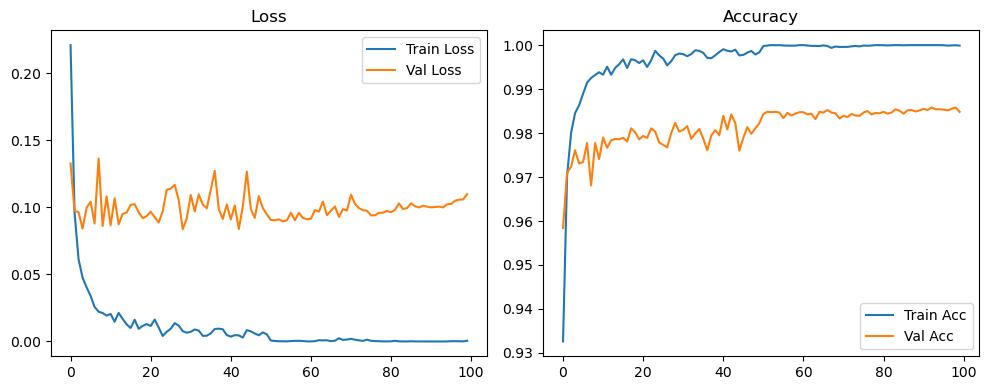

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2322, Acc: 0.9291 | Val Loss: 0.1536, Acc: 0.9555


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1129, Acc: 0.9659 | Val Loss: 0.1003, Acc: 0.9700


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0764, Acc: 0.9764 | Val Loss: 0.0927, Acc: 0.9738


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0658, Acc: 0.9798 | Val Loss: 0.0820, Acc: 0.9765


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0493, Acc: 0.9839 | Val Loss: 0.0964, Acc: 0.9732


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9845 | Val Loss: 0.0939, Acc: 0.9762


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9873 | Val Loss: 0.0867, Acc: 0.9763


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9888 | Val Loss: 0.1148, Acc: 0.9710


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9894 | Val Loss: 0.0918, Acc: 0.9762


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9900 | Val Loss: 0.0839, Acc: 0.9780


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9913 | Val Loss: 0.0893, Acc: 0.9789


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9913 | Val Loss: 0.0976, Acc: 0.9756


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9932 | Val Loss: 0.0875, Acc: 0.9795


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9924 | Val Loss: 0.0869, Acc: 0.9776


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9925 | Val Loss: 0.0801, Acc: 0.9813


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9932 | Val Loss: 0.0846, Acc: 0.9792


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9929 | Val Loss: 0.0813, Acc: 0.9795


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9948 | Val Loss: 0.0907, Acc: 0.9793


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9940 | Val Loss: 0.0751, Acc: 0.9829


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9952 | Val Loss: 0.0942, Acc: 0.9788


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9949 | Val Loss: 0.0928, Acc: 0.9812


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9960 | Val Loss: 0.0873, Acc: 0.9805


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9953 | Val Loss: 0.0837, Acc: 0.9818


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.0822, Acc: 0.9805


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9956 | Val Loss: 0.0948, Acc: 0.9801


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9956 | Val Loss: 0.0803, Acc: 0.9814


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.0910, Acc: 0.9817


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.0919, Acc: 0.9817


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9948 | Val Loss: 0.0945, Acc: 0.9809


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9957 | Val Loss: 0.0934, Acc: 0.9813


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9967 | Val Loss: 0.0845, Acc: 0.9831


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.1022, Acc: 0.9814


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9964 | Val Loss: 0.1010, Acc: 0.9804


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.0900, Acc: 0.9824


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9957 | Val Loss: 0.0895, Acc: 0.9822


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.0987, Acc: 0.9818


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0923, Acc: 0.9829


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9969 | Val Loss: 0.0910, Acc: 0.9812


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9963 | Val Loss: 0.0836, Acc: 0.9832


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.0935, Acc: 0.9825


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0935, Acc: 0.9827


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1059, Acc: 0.9812


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9970 | Val Loss: 0.0881, Acc: 0.9832


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0978, Acc: 0.9827


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0876, Acc: 0.9818


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.0857, Acc: 0.9833


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0869, Acc: 0.9832


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9973 | Val Loss: 0.0869, Acc: 0.9828


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0858, Acc: 0.9828


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.0839, Acc: 0.9831


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0757, Acc: 0.9847


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0758, Acc: 0.9849


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0775, Acc: 0.9856


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0819, Acc: 0.9854


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0773, Acc: 0.9854


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0805, Acc: 0.9851


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0799, Acc: 0.9849


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0827, Acc: 0.9859


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0881, Acc: 0.9848


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0871, Acc: 0.9842


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0841, Acc: 0.9855


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0873, Acc: 0.9860


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0921, Acc: 0.9842


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0902, Acc: 0.9861


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0889, Acc: 0.9866


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0877, Acc: 0.9862


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0914, Acc: 0.9866


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0993, Acc: 0.9852


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0948, Acc: 0.9858


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1020, Acc: 0.9844


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0937, Acc: 0.9841


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0978, Acc: 0.9846


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1028, Acc: 0.9841


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.0967, Acc: 0.9859


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1013, Acc: 0.9858


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0990, Acc: 0.9846


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1051, Acc: 0.9851


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0975, Acc: 0.9854


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1032, Acc: 0.9837


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1050, Acc: 0.9847


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0973, Acc: 0.9859


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.0963, Acc: 0.9858


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9999 | Val Loss: 0.0956, Acc: 0.9855


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0931, Acc: 0.9858


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0926, Acc: 0.9865


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0931, Acc: 0.9866


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0931, Acc: 0.9861


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0952, Acc: 0.9862


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0983, Acc: 0.9866


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1028, Acc: 0.9855


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1056, Acc: 0.9851


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1004, Acc: 0.9853


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0987, Acc: 0.9863


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0952, Acc: 0.9866


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0983, Acc: 0.9861


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0958, Acc: 0.9870


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1003, Acc: 0.9860


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0987, Acc: 0.9868


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1003, Acc: 0.9868


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1058, Acc: 0.9861


Final Test Loss: 0.0970 Accuracy: 0.9859


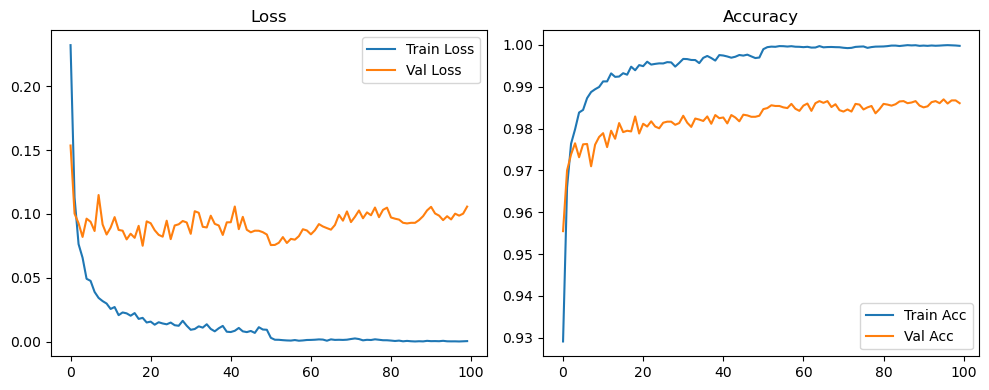

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2854, Acc: 0.9129 | Val Loss: 0.1512, Acc: 0.9573


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1663, Acc: 0.9497 | Val Loss: 0.1116, Acc: 0.9671


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1285, Acc: 0.9608 | Val Loss: 0.1059, Acc: 0.9694


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1055, Acc: 0.9669 | Val Loss: 0.0857, Acc: 0.9743


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0960, Acc: 0.9700 | Val Loss: 0.0870, Acc: 0.9737


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0832, Acc: 0.9737 | Val Loss: 0.0845, Acc: 0.9751


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0764, Acc: 0.9766 | Val Loss: 0.0761, Acc: 0.9785


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0650, Acc: 0.9797 | Val Loss: 0.0775, Acc: 0.9770


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0627, Acc: 0.9806 | Val Loss: 0.0760, Acc: 0.9778


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0609, Acc: 0.9803 | Val Loss: 0.0738, Acc: 0.9793


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0553, Acc: 0.9820 | Val Loss: 0.0852, Acc: 0.9758


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0561, Acc: 0.9818 | Val Loss: 0.0759, Acc: 0.9792


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0509, Acc: 0.9840 | Val Loss: 0.0722, Acc: 0.9798


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0492, Acc: 0.9842 | Val Loss: 0.0670, Acc: 0.9810


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0432, Acc: 0.9860 | Val Loss: 0.0703, Acc: 0.9814


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0397, Acc: 0.9874 | Val Loss: 0.0711, Acc: 0.9825


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0433, Acc: 0.9864 | Val Loss: 0.0734, Acc: 0.9798


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9871 | Val Loss: 0.0711, Acc: 0.9807


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0383, Acc: 0.9870 | Val Loss: 0.0718, Acc: 0.9814


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9875 | Val Loss: 0.0737, Acc: 0.9813


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0374, Acc: 0.9879 | Val Loss: 0.0705, Acc: 0.9808


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9879 | Val Loss: 0.0699, Acc: 0.9823


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9898 | Val Loss: 0.0671, Acc: 0.9825


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9900 | Val Loss: 0.0721, Acc: 0.9813


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9887 | Val Loss: 0.0736, Acc: 0.9818


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9905 | Val Loss: 0.0711, Acc: 0.9822


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9891 | Val Loss: 0.0721, Acc: 0.9837


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9906 | Val Loss: 0.0710, Acc: 0.9818


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9896 | Val Loss: 0.0741, Acc: 0.9815


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9904 | Val Loss: 0.0664, Acc: 0.9837


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9907 | Val Loss: 0.0646, Acc: 0.9845


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9919 | Val Loss: 0.0711, Acc: 0.9823


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9917 | Val Loss: 0.0750, Acc: 0.9837


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9920 | Val Loss: 0.0752, Acc: 0.9836


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9918 | Val Loss: 0.0753, Acc: 0.9827


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9915 | Val Loss: 0.0672, Acc: 0.9835


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0269, Acc: 0.9914 | Val Loss: 0.0756, Acc: 0.9820


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9925 | Val Loss: 0.0696, Acc: 0.9838


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9929 | Val Loss: 0.0723, Acc: 0.9829


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9928 | Val Loss: 0.0716, Acc: 0.9841


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9931 | Val Loss: 0.0770, Acc: 0.9828


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9936 | Val Loss: 0.0777, Acc: 0.9826


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0235, Acc: 0.9928 | Val Loss: 0.0734, Acc: 0.9835


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.0733, Acc: 0.9832


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9931 | Val Loss: 0.0703, Acc: 0.9849


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9934 | Val Loss: 0.0754, Acc: 0.9834


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9935 | Val Loss: 0.0706, Acc: 0.9834


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.0759, Acc: 0.9836


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9940 | Val Loss: 0.0796, Acc: 0.9832


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9937 | Val Loss: 0.0777, Acc: 0.9847


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.0719, Acc: 0.9855


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9961 | Val Loss: 0.0702, Acc: 0.9860


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.0730, Acc: 0.9852


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.0710, Acc: 0.9852


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.0735, Acc: 0.9859


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.0728, Acc: 0.9847


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0680, Acc: 0.9862


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0747, Acc: 0.9851


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.0758, Acc: 0.9848


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.0772, Acc: 0.9846


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0771, Acc: 0.9854


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0804, Acc: 0.9847


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9978 | Val Loss: 0.0790, Acc: 0.9848


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9978 | Val Loss: 0.0782, Acc: 0.9855


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.0781, Acc: 0.9851


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0772, Acc: 0.9851


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0772, Acc: 0.9860


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.0770, Acc: 0.9855


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0764, Acc: 0.9861


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0842, Acc: 0.9854


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0751, Acc: 0.9868


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9976 | Val Loss: 0.0777, Acc: 0.9858


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.0787, Acc: 0.9866


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0795, Acc: 0.9852


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0777, Acc: 0.9863


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0774, Acc: 0.9862


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9981 | Val Loss: 0.0805, Acc: 0.9857


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0791, Acc: 0.9858


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0803, Acc: 0.9853


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0824, Acc: 0.9853


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0786, Acc: 0.9865


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0806, Acc: 0.9858


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0787, Acc: 0.9860


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0780, Acc: 0.9858


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0778, Acc: 0.9864


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0778, Acc: 0.9858


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0809, Acc: 0.9859


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0804, Acc: 0.9859


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0800, Acc: 0.9858


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0810, Acc: 0.9855


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0813, Acc: 0.9858


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0816, Acc: 0.9863


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0860, Acc: 0.9864


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0852, Acc: 0.9862


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0845, Acc: 0.9858


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0853, Acc: 0.9858


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0835, Acc: 0.9856


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0837, Acc: 0.9859


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0846, Acc: 0.9857


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0831, Acc: 0.9856


Final Test Loss: 0.0883 Accuracy: 0.9866


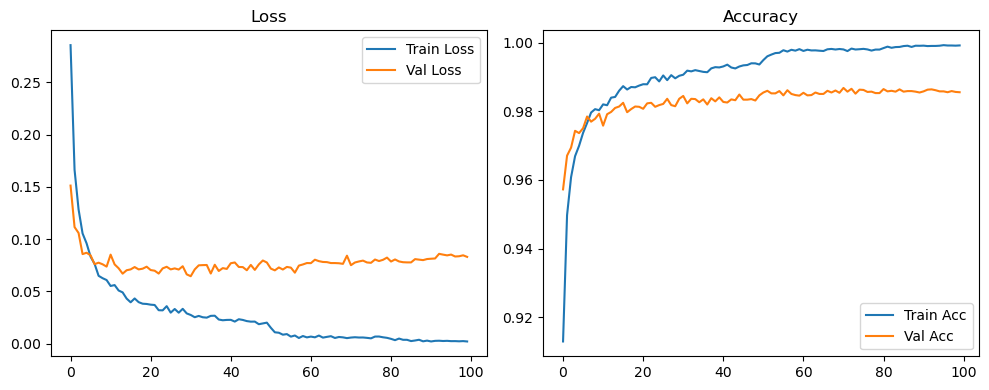

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.1834, Acc: 0.9423 | Val Loss: 0.1163, Acc: 0.9657


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0824, Acc: 0.9739 | Val Loss: 0.0890, Acc: 0.9740


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0538, Acc: 0.9828 | Val Loss: 0.0918, Acc: 0.9732


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0418, Acc: 0.9860 | Val Loss: 0.0791, Acc: 0.9772


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9901 | Val Loss: 0.0867, Acc: 0.9771


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9900 | Val Loss: 0.0981, Acc: 0.9734


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9910 | Val Loss: 0.0833, Acc: 0.9762


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9935 | Val Loss: 0.1271, Acc: 0.9695


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9941 | Val Loss: 0.0875, Acc: 0.9789


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9950 | Val Loss: 0.0841, Acc: 0.9789


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9954 | Val Loss: 0.1015, Acc: 0.9770


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9943 | Val Loss: 0.1122, Acc: 0.9765


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.0900, Acc: 0.9798


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.0865, Acc: 0.9803


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.0931, Acc: 0.9805


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9967 | Val Loss: 0.1056, Acc: 0.9768


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.0869, Acc: 0.9810


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9953 | Val Loss: 0.0893, Acc: 0.9814


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9976 | Val Loss: 0.0994, Acc: 0.9816


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0931, Acc: 0.9818


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0946, Acc: 0.9812


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9969 | Val Loss: 0.1019, Acc: 0.9801


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.1099, Acc: 0.9789


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.1070, Acc: 0.9782


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1083, Acc: 0.9785


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.1074, Acc: 0.9791


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0896, Acc: 0.9840


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0929, Acc: 0.9828


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1081, Acc: 0.9797


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1071, Acc: 0.9788


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0973, Acc: 0.9817


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9979 | Val Loss: 0.0906, Acc: 0.9823


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9979 | Val Loss: 0.0859, Acc: 0.9837


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0949, Acc: 0.9818


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0888, Acc: 0.9831


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0928, Acc: 0.9832


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.1130, Acc: 0.9791


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.0993, Acc: 0.9813


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.0979, Acc: 0.9818


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0977, Acc: 0.9823


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0997, Acc: 0.9820


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1469, Acc: 0.9768


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1065, Acc: 0.9818


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1101, Acc: 0.9798


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9979 | Val Loss: 0.0997, Acc: 0.9814


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0969, Acc: 0.9817


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1055, Acc: 0.9818


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0885, Acc: 0.9835


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1040, Acc: 0.9830


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1034, Acc: 0.9832


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9995 | Val Loss: 0.1168, Acc: 0.9822


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1142, Acc: 0.9829


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.1165, Acc: 0.9813


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1127, Acc: 0.9811


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1191, Acc: 0.9811


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1108, Acc: 0.9816


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0993, Acc: 0.9837


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0981, Acc: 0.9832


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1141, Acc: 0.9815


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1017, Acc: 0.9828


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1189, Acc: 0.9805


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.1110, Acc: 0.9808


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1069, Acc: 0.9826


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9992 | Val Loss: 0.1194, Acc: 0.9822


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9989 | Val Loss: 0.1000, Acc: 0.9828


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0965, Acc: 0.9836


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0926, Acc: 0.9849


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1012, Acc: 0.9835


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.0947, Acc: 0.9838


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9997 | Val Loss: 0.0981, Acc: 0.9856


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.1121, Acc: 0.9817


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9973 | Val Loss: 0.1202, Acc: 0.9792


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1064, Acc: 0.9821


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.0939, Acc: 0.9837


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1063, Acc: 0.9799


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0975, Acc: 0.9829


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0966, Acc: 0.9837


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0918, Acc: 0.9841


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0921, Acc: 0.9838


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1097, Acc: 0.9806


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0981, Acc: 0.9827


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1096, Acc: 0.9832


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9987 | Val Loss: 0.1104, Acc: 0.9819


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0963, Acc: 0.9832


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1004, Acc: 0.9829


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1054, Acc: 0.9812


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1132, Acc: 0.9801


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9994 | Val Loss: 0.1146, Acc: 0.9815


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1018, Acc: 0.9839


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0953, Acc: 0.9842


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1064, Acc: 0.9831


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1093, Acc: 0.9831


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.1069, Acc: 0.9823


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1011, Acc: 0.9836


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1095, Acc: 0.9829


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0979, Acc: 0.9835


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9990 | Val Loss: 0.1071, Acc: 0.9826


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1059, Acc: 0.9827


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0994, Acc: 0.9832


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0999, Acc: 0.9834


Final Test Loss: 0.0927 Accuracy: 0.9840


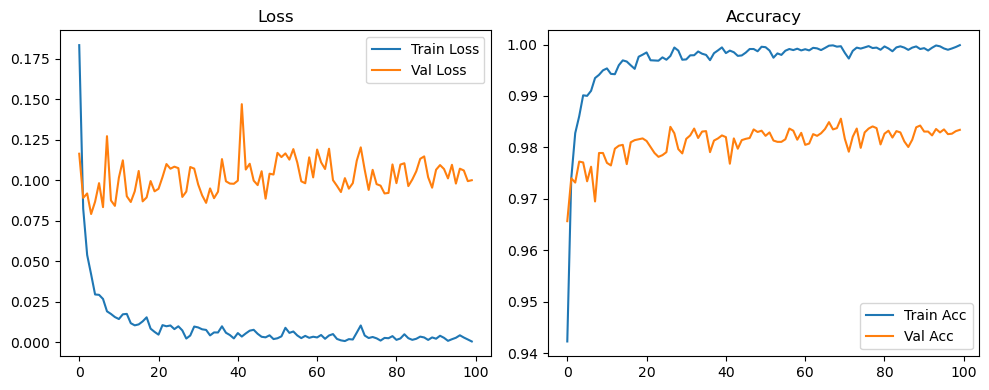

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.1988, Acc: 0.9389 | Val Loss: 0.1271, Acc: 0.9623


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0993, Acc: 0.9695 | Val Loss: 0.0894, Acc: 0.9717


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0683, Acc: 0.9780 | Val Loss: 0.0931, Acc: 0.9720


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0576, Acc: 0.9813 | Val Loss: 0.0812, Acc: 0.9750


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0485, Acc: 0.9842 | Val Loss: 0.0826, Acc: 0.9762


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0414, Acc: 0.9862 | Val Loss: 0.0860, Acc: 0.9766


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0367, Acc: 0.9880 | Val Loss: 0.0851, Acc: 0.9766


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9894 | Val Loss: 0.1056, Acc: 0.9736


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9922 | Val Loss: 0.0833, Acc: 0.9790


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9924 | Val Loss: 0.0743, Acc: 0.9812


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9927 | Val Loss: 0.0797, Acc: 0.9809


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9929 | Val Loss: 0.0913, Acc: 0.9782


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9935 | Val Loss: 0.0820, Acc: 0.9812


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9923 | Val Loss: 0.0820, Acc: 0.9799


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0176, Acc: 0.9940 | Val Loss: 0.0821, Acc: 0.9815


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.0850, Acc: 0.9793


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9938 | Val Loss: 0.0951, Acc: 0.9792


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0163, Acc: 0.9949 | Val Loss: 0.0917, Acc: 0.9806


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9951 | Val Loss: 0.0813, Acc: 0.9822


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9948 | Val Loss: 0.0842, Acc: 0.9810


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.0887, Acc: 0.9812


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.0845, Acc: 0.9820


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.0845, Acc: 0.9824


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9958 | Val Loss: 0.0821, Acc: 0.9831


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9961 | Val Loss: 0.0951, Acc: 0.9804


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.0890, Acc: 0.9813


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.0817, Acc: 0.9819


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.0806, Acc: 0.9824


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9963 | Val Loss: 0.0968, Acc: 0.9806


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9967 | Val Loss: 0.0901, Acc: 0.9815


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0888, Acc: 0.9812


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.1008, Acc: 0.9802


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.0974, Acc: 0.9814


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1065, Acc: 0.9788


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.0959, Acc: 0.9812


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.0968, Acc: 0.9804


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.0963, Acc: 0.9819


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.0862, Acc: 0.9825


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0953, Acc: 0.9824


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9971 | Val Loss: 0.0913, Acc: 0.9816


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0887, Acc: 0.9834


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9975 | Val Loss: 0.0852, Acc: 0.9830


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0876, Acc: 0.9837


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0899, Acc: 0.9840


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9979 | Val Loss: 0.0905, Acc: 0.9826


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.1007, Acc: 0.9808


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1034, Acc: 0.9815


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.1010, Acc: 0.9812


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0849, Acc: 0.9842


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.0954, Acc: 0.9816


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0984, Acc: 0.9824


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9976 | Val Loss: 0.1066, Acc: 0.9814


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0921, Acc: 0.9832


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0963, Acc: 0.9829


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0940, Acc: 0.9828


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.0945, Acc: 0.9840


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0938, Acc: 0.9842


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0964, Acc: 0.9834


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.0951, Acc: 0.9834


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9978 | Val Loss: 0.0870, Acc: 0.9841


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.0841, Acc: 0.9843


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0894, Acc: 0.9829


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0935, Acc: 0.9831


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0959, Acc: 0.9838


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1124, Acc: 0.9822


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.0927, Acc: 0.9841


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0884, Acc: 0.9858


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0928, Acc: 0.9848


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1002, Acc: 0.9828


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1030, Acc: 0.9831


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0977, Acc: 0.9836


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9982 | Val Loss: 0.1120, Acc: 0.9812


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.0904, Acc: 0.9829


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.0955, Acc: 0.9832


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9988 | Val Loss: 0.0933, Acc: 0.9832


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0991, Acc: 0.9837


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0940, Acc: 0.9838


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0930, Acc: 0.9847


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0977, Acc: 0.9847


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1073, Acc: 0.9836


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9987 | Val Loss: 0.0961, Acc: 0.9842


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0890, Acc: 0.9845


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0828, Acc: 0.9849


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1003, Acc: 0.9835


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.0925, Acc: 0.9840


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0913, Acc: 0.9846


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0972, Acc: 0.9842


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0986, Acc: 0.9837


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1015, Acc: 0.9842


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1065, Acc: 0.9835


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0962, Acc: 0.9838


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0969, Acc: 0.9847


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0828, Acc: 0.9864


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1011, Acc: 0.9847


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0956, Acc: 0.9851


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1137, Acc: 0.9837


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1012, Acc: 0.9838


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0937, Acc: 0.9842


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1006, Acc: 0.9840


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0929, Acc: 0.9853


Final Test Loss: 0.0907 Accuracy: 0.9856


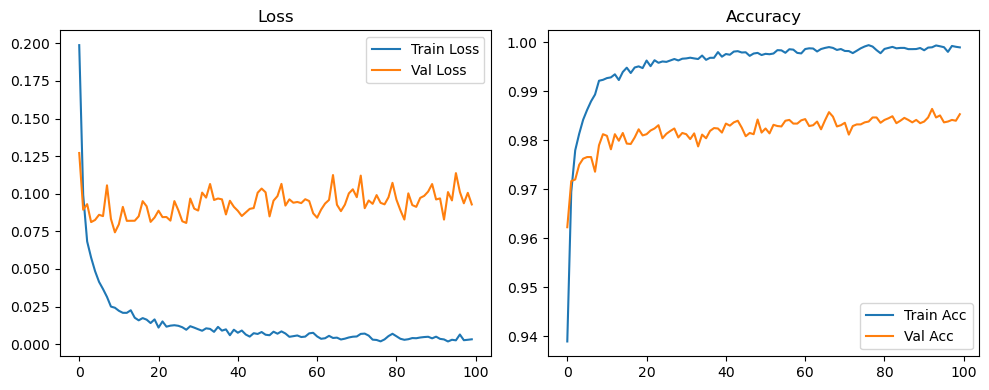

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2753, Acc: 0.9145 | Val Loss: 0.1367, Acc: 0.9587


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1505, Acc: 0.9535 | Val Loss: 0.1010, Acc: 0.9698


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1165, Acc: 0.9633 | Val Loss: 0.0928, Acc: 0.9720


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1045, Acc: 0.9674 | Val Loss: 0.0781, Acc: 0.9752


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0882, Acc: 0.9722 | Val Loss: 0.0808, Acc: 0.9729


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0799, Acc: 0.9747 | Val Loss: 0.0779, Acc: 0.9766


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0702, Acc: 0.9774 | Val Loss: 0.0797, Acc: 0.9769


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0658, Acc: 0.9790 | Val Loss: 0.0734, Acc: 0.9778


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0613, Acc: 0.9802 | Val Loss: 0.0705, Acc: 0.9784


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0554, Acc: 0.9818 | Val Loss: 0.0669, Acc: 0.9791


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0517, Acc: 0.9831 | Val Loss: 0.0759, Acc: 0.9792


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0544, Acc: 0.9828 | Val Loss: 0.0694, Acc: 0.9804


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0477, Acc: 0.9852 | Val Loss: 0.0681, Acc: 0.9808


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0448, Acc: 0.9855 | Val Loss: 0.0689, Acc: 0.9805


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0453, Acc: 0.9853 | Val Loss: 0.0662, Acc: 0.9815


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0390, Acc: 0.9868 | Val Loss: 0.0685, Acc: 0.9813


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0408, Acc: 0.9869 | Val Loss: 0.0704, Acc: 0.9810


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0363, Acc: 0.9884 | Val Loss: 0.0643, Acc: 0.9830


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0327, Acc: 0.9895 | Val Loss: 0.0665, Acc: 0.9823


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0360, Acc: 0.9888 | Val Loss: 0.0670, Acc: 0.9819


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0364, Acc: 0.9884 | Val Loss: 0.0688, Acc: 0.9828


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0317, Acc: 0.9895 | Val Loss: 0.0621, Acc: 0.9838


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9909 | Val Loss: 0.0636, Acc: 0.9835


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9906 | Val Loss: 0.0668, Acc: 0.9835


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9904 | Val Loss: 0.0713, Acc: 0.9829


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9908 | Val Loss: 0.0724, Acc: 0.9818


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9906 | Val Loss: 0.0659, Acc: 0.9842


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9912 | Val Loss: 0.0693, Acc: 0.9821


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9914 | Val Loss: 0.0699, Acc: 0.9838


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9911 | Val Loss: 0.0720, Acc: 0.9831


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9915 | Val Loss: 0.0676, Acc: 0.9836


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9931 | Val Loss: 0.0706, Acc: 0.9842


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9921 | Val Loss: 0.0686, Acc: 0.9842


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9930 | Val Loss: 0.0762, Acc: 0.9822


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0211, Acc: 0.9930 | Val Loss: 0.0739, Acc: 0.9836


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9930 | Val Loss: 0.0658, Acc: 0.9844


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9924 | Val Loss: 0.0699, Acc: 0.9848


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.0691, Acc: 0.9847


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9934 | Val Loss: 0.0716, Acc: 0.9848


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9933 | Val Loss: 0.0700, Acc: 0.9838


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9933 | Val Loss: 0.0748, Acc: 0.9848


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9935 | Val Loss: 0.0723, Acc: 0.9842


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9932 | Val Loss: 0.0655, Acc: 0.9848


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9940 | Val Loss: 0.0647, Acc: 0.9859


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9944 | Val Loss: 0.0636, Acc: 0.9859


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9951 | Val Loss: 0.0726, Acc: 0.9848


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9943 | Val Loss: 0.0732, Acc: 0.9854


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9948 | Val Loss: 0.0741, Acc: 0.9843


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9947 | Val Loss: 0.0758, Acc: 0.9848


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.0730, Acc: 0.9846


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.0785, Acc: 0.9828


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9946 | Val Loss: 0.0767, Acc: 0.9839


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9945 | Val Loss: 0.0747, Acc: 0.9833


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.0762, Acc: 0.9853


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.0777, Acc: 0.9841


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9952 | Val Loss: 0.0817, Acc: 0.9832


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9954 | Val Loss: 0.0771, Acc: 0.9848


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9953 | Val Loss: 0.0748, Acc: 0.9851


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0159, Acc: 0.9950 | Val Loss: 0.0795, Acc: 0.9844


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9954 | Val Loss: 0.0776, Acc: 0.9841


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.0690, Acc: 0.9855


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.0730, Acc: 0.9850


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.0744, Acc: 0.9853


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.0756, Acc: 0.9863


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.0829, Acc: 0.9837


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0159, Acc: 0.9950 | Val Loss: 0.0738, Acc: 0.9850


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9957 | Val Loss: 0.0738, Acc: 0.9863


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.0722, Acc: 0.9844


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.0722, Acc: 0.9860


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.0767, Acc: 0.9854


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9960 | Val Loss: 0.0734, Acc: 0.9849


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.0755, Acc: 0.9855


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.0738, Acc: 0.9852


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.0692, Acc: 0.9856


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.0725, Acc: 0.9860


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0711, Acc: 0.9849


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9962 | Val Loss: 0.0702, Acc: 0.9859


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9965 | Val Loss: 0.0709, Acc: 0.9859


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9964 | Val Loss: 0.0663, Acc: 0.9857


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0726, Acc: 0.9860


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9968 | Val Loss: 0.0704, Acc: 0.9854


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.0752, Acc: 0.9850


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.0837, Acc: 0.9842


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.0787, Acc: 0.9852


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.0738, Acc: 0.9852


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9966 | Val Loss: 0.0760, Acc: 0.9847


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.0779, Acc: 0.9851


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.0823, Acc: 0.9845


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.0725, Acc: 0.9857


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.0759, Acc: 0.9847


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.0800, Acc: 0.9848


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.0750, Acc: 0.9851


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9972 | Val Loss: 0.0773, Acc: 0.9847


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0800, Acc: 0.9845


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0782, Acc: 0.9847


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.0826, Acc: 0.9840


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.0730, Acc: 0.9853


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9975 | Val Loss: 0.0733, Acc: 0.9855


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9974 | Val Loss: 0.0755, Acc: 0.9866


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.0734, Acc: 0.9852


Final Test Loss: 0.0671 Accuracy: 0.9869


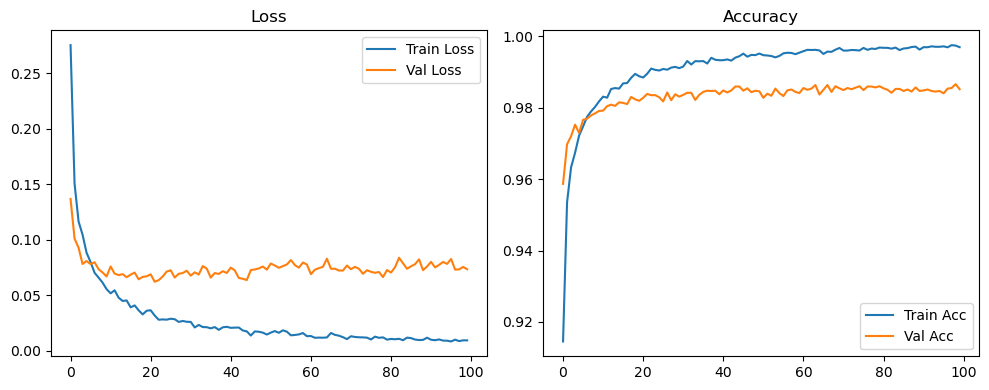

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.1740, Acc: 0.9457 | Val Loss: 0.1053, Acc: 0.9694


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0731, Acc: 0.9764 | Val Loss: 0.0893, Acc: 0.9716


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0469, Acc: 0.9841 | Val Loss: 0.0909, Acc: 0.9732


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0322, Acc: 0.9894 | Val Loss: 0.0811, Acc: 0.9762


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0257, Acc: 0.9913 | Val Loss: 0.0901, Acc: 0.9757


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0241, Acc: 0.9922 | Val Loss: 0.0976, Acc: 0.9759


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9937 | Val Loss: 0.0886, Acc: 0.9778


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9948 | Val Loss: 0.0980, Acc: 0.9763


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9948 | Val Loss: 0.1100, Acc: 0.9718


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0156, Acc: 0.9947 | Val Loss: 0.0894, Acc: 0.9776


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.0784, Acc: 0.9814


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.0997, Acc: 0.9776


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9952 | Val Loss: 0.0925, Acc: 0.9773


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.0841, Acc: 0.9802


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0864, Acc: 0.9796


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1202, Acc: 0.9731


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.0920, Acc: 0.9794


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1050, Acc: 0.9766


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.0783, Acc: 0.9815


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.0856, Acc: 0.9792


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0817, Acc: 0.9822


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.0857, Acc: 0.9807


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0890, Acc: 0.9809


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9979 | Val Loss: 0.1273, Acc: 0.9760


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.0986, Acc: 0.9796


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.0816, Acc: 0.9826


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0967, Acc: 0.9798


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0934, Acc: 0.9808


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0967, Acc: 0.9806


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.1006, Acc: 0.9790


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0835, Acc: 0.9828


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0841, Acc: 0.9822


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.0886, Acc: 0.9822


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0966, Acc: 0.9802


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0934, Acc: 0.9818


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0866, Acc: 0.9826


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0825, Acc: 0.9822


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0984, Acc: 0.9808


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1478, Acc: 0.9737


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.1127, Acc: 0.9785


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1092, Acc: 0.9797


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1090, Acc: 0.9800


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0854, Acc: 0.9829


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0922, Acc: 0.9828


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0992, Acc: 0.9816


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0858, Acc: 0.9826


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1043, Acc: 0.9818


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9977 | Val Loss: 0.0878, Acc: 0.9835


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0943, Acc: 0.9822


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0880, Acc: 0.9828


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0849, Acc: 0.9833


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0878, Acc: 0.9846


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0960, Acc: 0.9827


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0991, Acc: 0.9832


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1129, Acc: 0.9790


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.1145, Acc: 0.9808


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1032, Acc: 0.9818


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0951, Acc: 0.9831


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1229, Acc: 0.9801


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.1007, Acc: 0.9820


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1006, Acc: 0.9820


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0939, Acc: 0.9826


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0912, Acc: 0.9839


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.0925, Acc: 0.9832


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0930, Acc: 0.9828


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.1028, Acc: 0.9818


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0965, Acc: 0.9830


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0985, Acc: 0.9822


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0995, Acc: 0.9843


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1007, Acc: 0.9843


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9986 | Val Loss: 0.0987, Acc: 0.9825


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1013, Acc: 0.9817


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.1057, Acc: 0.9818


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1065, Acc: 0.9818


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1028, Acc: 0.9835


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0919, Acc: 0.9842


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0912, Acc: 0.9845


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0957, Acc: 0.9838


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0975, Acc: 0.9825


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0985, Acc: 0.9826


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1082, Acc: 0.9820


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9985 | Val Loss: 0.1244, Acc: 0.9797


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1127, Acc: 0.9800


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9986 | Val Loss: 0.0935, Acc: 0.9829


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0817, Acc: 0.9848


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0846, Acc: 0.9854


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0840, Acc: 0.9858


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0828, Acc: 0.9852


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0855, Acc: 0.9852


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0855, Acc: 0.9852


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0853, Acc: 0.9858


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0843, Acc: 0.9857


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0874, Acc: 0.9848


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0872, Acc: 0.9849


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9997 | Val Loss: 0.1015, Acc: 0.9840


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9964 | Val Loss: 0.1011, Acc: 0.9807


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.1037, Acc: 0.9802


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0886, Acc: 0.9827


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0880, Acc: 0.9842


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9997 | Val Loss: 0.0820, Acc: 0.9854


Final Test Loss: 0.0828 Accuracy: 0.9844


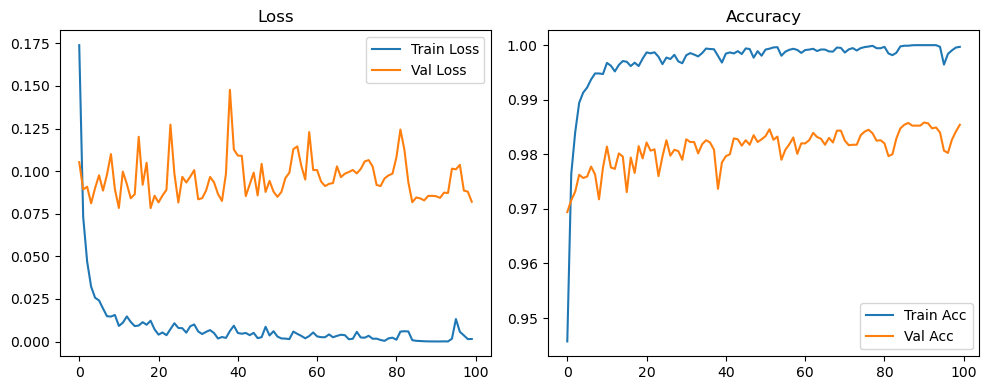

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2016, Acc: 0.9376 | Val Loss: 0.1076, Acc: 0.9676


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0906, Acc: 0.9715 | Val Loss: 0.0860, Acc: 0.9728


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0625, Acc: 0.9799 | Val Loss: 0.0884, Acc: 0.9744


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0529, Acc: 0.9829 | Val Loss: 0.0776, Acc: 0.9778


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0412, Acc: 0.9866 | Val Loss: 0.0798, Acc: 0.9765


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0362, Acc: 0.9879 | Val Loss: 0.0830, Acc: 0.9775


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0329, Acc: 0.9890 | Val Loss: 0.0767, Acc: 0.9785


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9918 | Val Loss: 0.0961, Acc: 0.9751


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9934 | Val Loss: 0.0908, Acc: 0.9781


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9929 | Val Loss: 0.0834, Acc: 0.9790


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9936 | Val Loss: 0.0843, Acc: 0.9791


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9930 | Val Loss: 0.0956, Acc: 0.9756


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9933 | Val Loss: 0.0834, Acc: 0.9793


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9939 | Val Loss: 0.0737, Acc: 0.9808


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0170, Acc: 0.9943 | Val Loss: 0.0731, Acc: 0.9822


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9950 | Val Loss: 0.0772, Acc: 0.9802


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9954 | Val Loss: 0.0826, Acc: 0.9806


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0150, Acc: 0.9950 | Val Loss: 0.0796, Acc: 0.9817


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.0729, Acc: 0.9832


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.0816, Acc: 0.9809


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9956 | Val Loss: 0.0867, Acc: 0.9804


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9954 | Val Loss: 0.0848, Acc: 0.9798


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9960 | Val Loss: 0.0860, Acc: 0.9799


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9963 | Val Loss: 0.0906, Acc: 0.9798


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.0898, Acc: 0.9812


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.0899, Acc: 0.9812


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0854, Acc: 0.9813


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.0878, Acc: 0.9818


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9962 | Val Loss: 0.1079, Acc: 0.9792


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9959 | Val Loss: 0.0826, Acc: 0.9818


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.0864, Acc: 0.9840


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.0846, Acc: 0.9834


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.0929, Acc: 0.9816


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0951, Acc: 0.9798


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9974 | Val Loss: 0.0977, Acc: 0.9806


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0855, Acc: 0.9822


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.0961, Acc: 0.9819


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0917, Acc: 0.9826


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0817, Acc: 0.9838


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.1053, Acc: 0.9793


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.0912, Acc: 0.9828


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0812, Acc: 0.9847


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0852, Acc: 0.9833


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0850, Acc: 0.9833


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.0890, Acc: 0.9825


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.0975, Acc: 0.9818


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0888, Acc: 0.9843


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0927, Acc: 0.9826


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0967, Acc: 0.9831


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0960, Acc: 0.9812


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0885, Acc: 0.9833


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1012, Acc: 0.9828


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1009, Acc: 0.9836


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1005, Acc: 0.9829


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.0962, Acc: 0.9832


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0966, Acc: 0.9836


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0919, Acc: 0.9832


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0887, Acc: 0.9839


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.0827, Acc: 0.9839


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0892, Acc: 0.9847


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0860, Acc: 0.9835


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0935, Acc: 0.9833


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9987 | Val Loss: 0.0874, Acc: 0.9848


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0902, Acc: 0.9834


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.0963, Acc: 0.9833


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.0887, Acc: 0.9839


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0925, Acc: 0.9844


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.0893, Acc: 0.9836


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0927, Acc: 0.9831


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0992, Acc: 0.9835


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1011, Acc: 0.9830


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0889, Acc: 0.9844


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1000, Acc: 0.9830


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0870, Acc: 0.9849


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0883, Acc: 0.9846


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1003, Acc: 0.9816


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0960, Acc: 0.9839


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.0940, Acc: 0.9845


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0978, Acc: 0.9844


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0915, Acc: 0.9846


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0921, Acc: 0.9846


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0866, Acc: 0.9860


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0875, Acc: 0.9847


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0911, Acc: 0.9842


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0982, Acc: 0.9835


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.0912, Acc: 0.9835


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0848, Acc: 0.9857


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0969, Acc: 0.9832


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9993 | Val Loss: 0.0901, Acc: 0.9843


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.0973, Acc: 0.9834


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0875, Acc: 0.9848


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0910, Acc: 0.9845


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0857, Acc: 0.9846


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0936, Acc: 0.9848


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0944, Acc: 0.9845


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0873, Acc: 0.9859


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0955, Acc: 0.9852


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0874, Acc: 0.9859


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0892, Acc: 0.9853


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0853, Acc: 0.9856


Final Test Loss: 0.1004 Accuracy: 0.9846


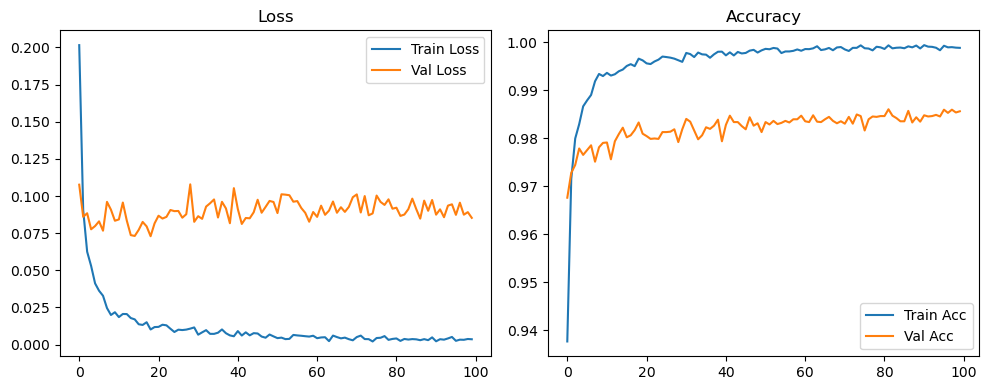

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2974, Acc: 0.9066 | Val Loss: 0.1316, Acc: 0.9593


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1484, Acc: 0.9538 | Val Loss: 0.0974, Acc: 0.9693


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1141, Acc: 0.9645 | Val Loss: 0.0922, Acc: 0.9722


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0998, Acc: 0.9686 | Val Loss: 0.0811, Acc: 0.9748


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0865, Acc: 0.9724 | Val Loss: 0.0799, Acc: 0.9746


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0759, Acc: 0.9755 | Val Loss: 0.0688, Acc: 0.9793


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0693, Acc: 0.9785 | Val Loss: 0.0781, Acc: 0.9764


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0615, Acc: 0.9801 | Val Loss: 0.0733, Acc: 0.9782


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0596, Acc: 0.9806 | Val Loss: 0.0785, Acc: 0.9767


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0548, Acc: 0.9819 | Val Loss: 0.0682, Acc: 0.9801


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0519, Acc: 0.9830 | Val Loss: 0.0761, Acc: 0.9788


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0525, Acc: 0.9829 | Val Loss: 0.0669, Acc: 0.9814


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0448, Acc: 0.9857 | Val Loss: 0.0662, Acc: 0.9813


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0431, Acc: 0.9862 | Val Loss: 0.0652, Acc: 0.9819


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0410, Acc: 0.9866 | Val Loss: 0.0632, Acc: 0.9811


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0391, Acc: 0.9869 | Val Loss: 0.0725, Acc: 0.9790


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0404, Acc: 0.9863 | Val Loss: 0.0684, Acc: 0.9795


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0376, Acc: 0.9873 | Val Loss: 0.0663, Acc: 0.9815


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0329, Acc: 0.9891 | Val Loss: 0.0666, Acc: 0.9808


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0341, Acc: 0.9885 | Val Loss: 0.0660, Acc: 0.9808


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0316, Acc: 0.9893 | Val Loss: 0.0638, Acc: 0.9822


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9895 | Val Loss: 0.0634, Acc: 0.9832


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0299, Acc: 0.9898 | Val Loss: 0.0628, Acc: 0.9831


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0306, Acc: 0.9897 | Val Loss: 0.0652, Acc: 0.9839


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0284, Acc: 0.9904 | Val Loss: 0.0711, Acc: 0.9812


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9916 | Val Loss: 0.0624, Acc: 0.9829


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0283, Acc: 0.9910 | Val Loss: 0.0669, Acc: 0.9828


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9915 | Val Loss: 0.0609, Acc: 0.9834


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9916 | Val Loss: 0.0646, Acc: 0.9833


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9917 | Val Loss: 0.0733, Acc: 0.9822


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0247, Acc: 0.9917 | Val Loss: 0.0698, Acc: 0.9828


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9925 | Val Loss: 0.0660, Acc: 0.9833


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0231, Acc: 0.9921 | Val Loss: 0.0666, Acc: 0.9840


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0212, Acc: 0.9928 | Val Loss: 0.0719, Acc: 0.9829


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9932 | Val Loss: 0.0724, Acc: 0.9830


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0212, Acc: 0.9928 | Val Loss: 0.0686, Acc: 0.9838


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9932 | Val Loss: 0.0687, Acc: 0.9823


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9934 | Val Loss: 0.0690, Acc: 0.9838


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9938 | Val Loss: 0.0747, Acc: 0.9827


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9935 | Val Loss: 0.0675, Acc: 0.9843


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9938 | Val Loss: 0.0650, Acc: 0.9848


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9949 | Val Loss: 0.0679, Acc: 0.9842


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9942 | Val Loss: 0.0660, Acc: 0.9846


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9936 | Val Loss: 0.0683, Acc: 0.9849


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9947 | Val Loss: 0.0681, Acc: 0.9843


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9942 | Val Loss: 0.0720, Acc: 0.9849


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0175, Acc: 0.9939 | Val Loss: 0.0704, Acc: 0.9845


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9941 | Val Loss: 0.0743, Acc: 0.9840


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0169, Acc: 0.9942 | Val Loss: 0.0728, Acc: 0.9841


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.0708, Acc: 0.9840


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0148, Acc: 0.9952 | Val Loss: 0.0693, Acc: 0.9845


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9954 | Val Loss: 0.0674, Acc: 0.9854


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9954 | Val Loss: 0.0662, Acc: 0.9848


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9960 | Val Loss: 0.0698, Acc: 0.9851


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9952 | Val Loss: 0.0670, Acc: 0.9848


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9950 | Val Loss: 0.0720, Acc: 0.9842


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9951 | Val Loss: 0.0701, Acc: 0.9848


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.0655, Acc: 0.9854


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9946 | Val Loss: 0.0667, Acc: 0.9855


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9957 | Val Loss: 0.0719, Acc: 0.9842


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9961 | Val Loss: 0.0729, Acc: 0.9838


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.0756, Acc: 0.9840


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.0741, Acc: 0.9841


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9961 | Val Loss: 0.0689, Acc: 0.9850


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9954 | Val Loss: 0.0708, Acc: 0.9858


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9958 | Val Loss: 0.0699, Acc: 0.9849


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.0738, Acc: 0.9847


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9957 | Val Loss: 0.0681, Acc: 0.9854


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.0687, Acc: 0.9861


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.0795, Acc: 0.9841


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.0756, Acc: 0.9846


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.0736, Acc: 0.9848


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.0731, Acc: 0.9851


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.0704, Acc: 0.9847


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.0696, Acc: 0.9859


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.0732, Acc: 0.9853


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0761, Acc: 0.9852


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9964 | Val Loss: 0.0723, Acc: 0.9850


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9967 | Val Loss: 0.0786, Acc: 0.9841


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.0767, Acc: 0.9848


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.0775, Acc: 0.9844


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0702, Acc: 0.9858


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.0761, Acc: 0.9858


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.0771, Acc: 0.9843


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.0794, Acc: 0.9848


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.0776, Acc: 0.9844


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0779, Acc: 0.9847


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.0814, Acc: 0.9846


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.0814, Acc: 0.9831


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.0718, Acc: 0.9855


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.0789, Acc: 0.9849


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0777, Acc: 0.9844


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.0794, Acc: 0.9830


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.0719, Acc: 0.9851


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.0744, Acc: 0.9848


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.0770, Acc: 0.9852


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9970 | Val Loss: 0.0736, Acc: 0.9852


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9970 | Val Loss: 0.0712, Acc: 0.9855


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0764, Acc: 0.9842


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.0736, Acc: 0.9852


Final Test Loss: 0.0757 Accuracy: 0.9867


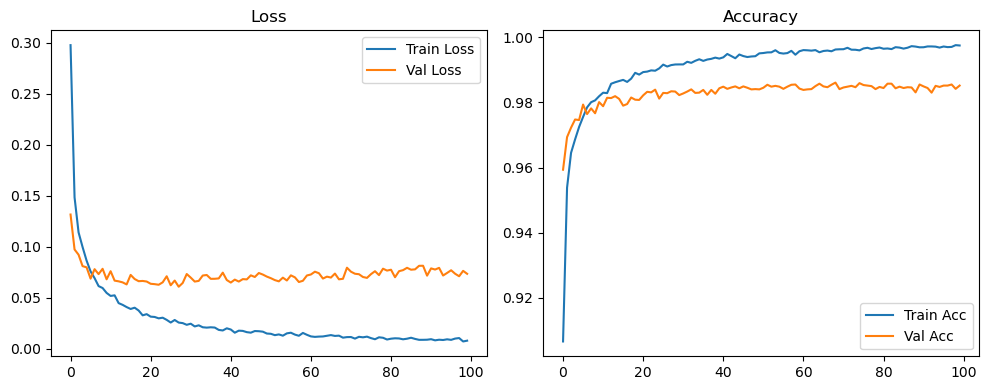

🏆 Best Config: batch64_lr0.01_0.005_0.002_dp0.2 Accuracy: 0.9878


In [8]:
root_path = "MLP_1024_float_regular_ReLU"

epochs = 100
batch_sizes = [64, 128, 256]
dropout_rates = [0.0, 0.2, 0.5]
lr_pool = [0.01, 0.005, 0.002, 0.001]

Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates)